# **$$基于NLP和神经网络的公司报告文本挖掘，预测股票价格波动$$**

***
$$李达——2022MF1班——SA22204027$$

# 选题背景及原因
随着经济持续稳定地发展，人均可支配收入逐渐增加，个人财富不断积累，如何管理财产以抵御通货膨胀，实现资产的保值、增值成为很多人关心的问题，传统的理财方式如银行存款因为利率的持续走低，逐渐无法满足人们的抵御通胀的需求，越来越多的人开始参与到收益更高股票交易市场中，但股市高收益的背后是高风险，如何找到股市波动的规律并从中牟利是所有投资者都关注的问题。

股票市场受到宏观政策、市场信心、未来预期等多种因素的综合影响，Eugene Fama提出有效市场假说理论，认为若股票市场是有效的，那么一切有价值的信息都会及时、准确、充分地反映在股价走势中，这一假说为股票价格的预测提供了理论依据。上市公司公告是上市公司信息披露的主要方式，也是投资者获取公司经营状况信息的主要来源，因此上市公司公告对股票价格的影响是值得研究的。

得益于新闻媒体的发达，公告所传递的信息如今能通过财经自媒体解读等方式被更多投资者获取，股票价格对公告信息的反应也更加迅速、敏感，快速及时地分析公告事件对股票价格影响的需求日益提升，但是由于公告文本量大，对分析人员的专业知识和综合能力要求高，人工解读费时费力且不同解读角度可能导致分析结果有所出入，机构和投资者难以做出准确判断。股票市场情况复杂，而传统预测方法通常又只考虑到股票的历史交易数据这类数字信息，在缺失公告等文本信息的情况下，很难得到较为理想的结果。而对公告的解读通常费时费力，且对专业知识和市场了解有较高的要求。因此如何便捷地从公告中提取影响股价的特征并将其与股票历史交易数据这类数字信息进行结合具有很高的研究价值。

NLP技术的发展为上市公司公告的快速分析判断提供了可能性，如今随着深度学习和自然语言处理技术的发展，使用人工智能技术去采集和分析上市公司公告，对这些公告造成的影响进行预测，能够显著减少投资者获取公告信息的难度和所花的时间。股票投资机构也能利用预测结果，与人工解读相结合，互相印证，节省大量的人力成本和时间成本；也可作为量化交易中的选股因子，增加数据样本多样性。

## （一）数据收集与处理
### 1.公司报告文本获取

出于方便以及模型针对性的考虑，此次研究获取的公告样本范围仅限定在在上海证券交易所上市的酿酒板块公司的临时报告。由于上海证券交易所官方网站未提供报告批量下载功能，本次研究运用python编程，通过调用上海证券交易所官方网站的查询接口实现各类上市公司报告的批量下载功能。

上海证券交易所官方网站的公司报告搜索页面网址和页面调用的查询接口为http://www.sse.com.cn/disclosure/listedinfo/announcement/。

本次上市公司报告文本的获取主要针对临时公告，包括IPO公司报告、公司治理、发行上市公告、上市公司章程以及其他类型报告。需注意由于上海证券交易所官方网站查询限制，接口每次查询的时间间隔不能超过3年。获取的临时公告以PDF格式存储在本地。

In [17]:
import os
import time
import requests
from copy import deepcopy

URL_SSE = "http://www.sse.com.cn/disclosure/listedinfo/announcement/"
# 股票
URL_SSE_STOCK = "http://www.sse.com.cn/js/common/ssesuggestdata.js"
# 基金
URL_SSE_FUND = "http://www.sse.com.cn/js/common/ssesuggestfunddata.js"
# E债券
URL_SSE_EBOND = "http://www.sse.com.cn/js/common/ssesuggestEbonddata.js"
# T债券
URL_SSE_TBOND = "http://www.sse.com.cn/js/common/ssesuggestTbonddata.js"
# 查询
URL_QUERY_COMPANY = "http://query.sse.com.cn/security/stock/queryCompanyBulletin.do"

URL_PDF = "http://static.sse.com.cn"

# 报告类型
REPORT_TYPE = {
    '全部': ('ALL', ''),
    '定期公告': ('ALL', 'DQBG'),
    '年报': ('YEARLY', 'DQBG'),
    '第一季度季报': ('QUATER1', 'DQBG'),
    '半年报': ('QUATER2', 'DQBG'),
    '第三季度季报': ('QUATER3', 'DQBG'),
    '临时公告': ('ALL', 'LSGG'),
    '上市公司章程': ('SHGSZC', 'LSGG'),
    '发行上市公告': ('FXSSGG', 'LSGG'),
    '公司治理': ('GSZL', 'LSGG'),
    '股东大会会议': ('GDDH', 'LSGG'),
    'IPO公司公告': ('IPOGG', 'LSGG'),
    '其他': ('QT', 'LSGG'),
}

# 证券类型
SECURITY_TYPE = {
    '全部': '0101,120100,020100,020200,120200',
    '主板': '0101',
    '科创板': '120100,020100,020200,120200',
}

HEADER = {
    'Referer': URL_SSE,
    'User-Agent': "Mozilla/5.0 (Windows NT 6.1; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/72.0.3626.121 Safari/537.36",
}

URL_PARAM = {
    # 是否分页
    'isPagination': 'false',
    'productId': '600000',
    # 关键字
    'keyWord': '',
    'securityType': SECURITY_TYPE['全部'],
    'reportType2': 'DQBG',
    'reportType': 'YEARLY',
    'beginDate': '2016-07-17',
    'endDate': '2019-07-17',
}


def get_all_codes(url):
    res = requests.get(url)
    content = res.content.decode()
    tmp = content.split('_t.push({val:"')
    code, name, pinyin = [], [], []
    for i in tmp[1:]:
        item = i.split('"')
        code.append(item[0])
        name.append(item[2])
        pinyin.append(item[4])
    # print(code)
    return code, name, pinyin


def get_pdf_url(code, begin_date, end_date, security_type='全部', report_type='临时公告'):
    url_param = deepcopy(URL_PARAM)
    url_param['productId'] = code
    url_param['securityType'] = SECURITY_TYPE[security_type]
    url_param['reportType2'] = REPORT_TYPE[report_type][1]
    url_param['reportType'] = REPORT_TYPE[report_type][0]
    url_param['beginDate'] = begin_date
    url_param['endDate'] = end_date
    result = requests.get(URL_QUERY_COMPANY, params=url_param, headers=HEADER).json()['result']

    return [(URL_PDF + i['URL'], i['BULLETIN_TYPE'], i['BULLETIN_YEAR'], i['SSEDATE'], i['TITLE']) for i in result]


def save_pdf(code, pdf_title_urls, path='./'):
    file_path = os.path.join(path, code)
    if not os.path.isdir(file_path):
        os.makedirs(file_path)
    for url, r_type, year, date, title in pdf_title_urls:
        date = ''.join(date.split('-'))
        file_name = '_'.join([code, year, date, r_type, title]) + '.pdf'
        file_full_name = os.path.join(file_path, file_name)
        # print(file_full_name)
        rs = requests.get(url, stream=True)
        with open(file_full_name, "wb") as fp:
            for chunk in rs.iter_content(chunk_size=10240):
                if chunk:
                    fp.write(chunk)


def download_report(code):   #下载2018——2021年的公告文本
    # month_day = time.strftime('-%m-%d', time.localtime())
    # year = int(time.strftime('%Y', time.localtime()))
    month_day = '-12-31'
    year = 2021
    while True:
        year_1 = year - 1   # 一年一年下载，时间跨度过长会出问题
        begin_date = str(year_1) + month_day
        end_date = str(year) + month_day
        pdf_urls = get_pdf_url(code, begin_date, end_date)

        # for i in title_urls:
        #     print(i)
        if pdf_urls:
            for i in range(1, 4):
                try:
                    save_pdf(code, pdf_urls)
                    break
                except Exception as e:
                    print(f'[{code}] 第{i}次尝试下载出错', e)
            else:
                print(f'[{code}] 下载失败')
        else:
            print(f'[{code}] 完毕')
            break
        year = year_1
        if year < 2018:
            break

stock_codes = [600084, 600132, 600197, 600199, 600238, 600365, 600519, 600543, 600559, 600573, 600600, 600616, 600696, 600702, 600779, 600809, 601579, 603198, 603369, 603589, 603779, 603919]
len_stock_codes = len(stock_codes)
for index, code in enumerate(stock_codes):
    print(f'股票总数:{len_stock_codes}, 已完成:{index}  ', end='')
    download_report(str(code))
print('任务完成')

股票总数:22, 已完成:0  [600084] 第1次尝试下载出错 [Errno 22] Invalid argument: './600084\\600084_2020_20200508_其它_*ST中葡关于公司股票撤销退市风险警示及实施其他风险警示的公告.pdf'
[600084] 第2次尝试下载出错 [Errno 22] Invalid argument: './600084\\600084_2020_20200508_其它_*ST中葡关于公司股票撤销退市风险警示及实施其他风险警示的公告.pdf'
[600084] 第3次尝试下载出错 [Errno 22] Invalid argument: './600084\\600084_2020_20200508_其它_*ST中葡关于公司股票撤销退市风险警示及实施其他风险警示的公告.pdf'
[600084] 下载失败
[600084] 第1次尝试下载出错 [Errno 22] Invalid argument: './600084\\600084_2019_20191224_其它_*ST中葡第七届董事会第十三次会议决议公告.pdf'
[600084] 第2次尝试下载出错 [Errno 22] Invalid argument: './600084\\600084_2019_20191224_其它_*ST中葡第七届董事会第十三次会议决议公告.pdf'
[600084] 第3次尝试下载出错 [Errno 22] Invalid argument: './600084\\600084_2019_20191224_其它_*ST中葡第七届董事会第十三次会议决议公告.pdf'
[600084] 下载失败
股票总数:22, 已完成:1  股票总数:22, 已完成:2  股票总数:22, 已完成:3  股票总数:22, 已完成:4  [600238] 第1次尝试下载出错 [Errno 22] Invalid argument: './600238\\600238_2018_20181229_其它_*ST椰岛董事会秘书辞职公告.pdf'
[600238] 第2次尝试下载出错 [Errno 22] Invalid argument: './600238\\600238_2018_20181229_其它_*ST椰岛董事会秘书辞职公告.p

### 2.股票历史交易数据获取

股票历史交易数据的获取来源为通达信金融终端，通过金融终端的盘后数据下载功能获取一定时间期限内的股票历史交易数据，数据统一采用前复权的形式，导出上海证券交易所上市的所有酿酒板块公司2018年至2021年的股票历史交易数据，以csv格式保存到本地。历史交易数据包括交易日期、当日成交额、当日成交量、当日涨幅、当日开盘价、当日收盘价、当日最低价、当日最高价、上一交易日收盘价等。

股票历史交易数据不仅用于基于公司报告文本挖掘的股票价格辅助预测模型报告文本标签的设置，在后续股票价格预测模型中也会使用历史交易数据作为训练的主要数据集。

### 3.文本格式转换

获取的上市公司报告均以PDF格式保存在本地，因为自然语言处理要求文本格式为纯文本，因此需将PDF报告文本转换为TXT格式。此次研究通过调用python第三方模块PDFMiner，编写程序实现批量化解析PDF文件并提取其中的全部文本信息，并以TXT格式保存在本地。

In [20]:
import os
import re
from pdfminer.converter import LTChar, TextConverter
from pdfminer.layout import LAParams
from pdfminer.pdfparser import PDFParser
from pdfminer.pdfdocument import PDFDocument
from pdfminer.pdfpage import PDFTextExtractionNotAllowed
from pdfminer.pdfpage import PDFPage
from pdfminer.pdfinterp import PDFResourceManager, PDFPageInterpreter
from pdfminer.converter import PDFPageAggregator
from pdfminer.layout import LAParams, LTTextBox
from io import StringIO
from io import open


# 读取pdf
def read(path):
    parser = PDFParser(path)
    doc = PDFDocument(parser, '')
    parser.set_document(doc)
    if not doc.is_extractable:
        raise PDFTextExtractionNotAllowed
    else:
        # 创建PDf 资源管理器 来管理共享资源
        rsrcmgr = PDFResourceManager()
        # 创建一个PDF聚合器，包含资源管理器与参数分析器
        laparams = LAParams()
        device = PDFPageAggregator(rsrcmgr, laparams=laparams)
        # 创建一个PDF解释器对象
        interpreter = PDFPageInterpreter(rsrcmgr, device)
        # 循环遍历列表，每次处理一个page的内容
        page0 = ''
        for i, page in enumerate(PDFPage.create_pages(doc)):
            interpreter.process_page(page)
            print("START PAGE %d\n" % i)
            if page is not None:
                interpreter.process_page(page)
            print("END PAGE %d\n" % i)
            # 接受该页面的LTPage对象
            layout = device.get_result()
            print(layout)
            # 这里layout是一个LTPage对象，里面存放着这个 page 解析出的各种对象
            # 包括 LTTextBox, LTFigure, LTImage, LTTextBoxHorizontal 等
            line0 = ''
            for x in layout:
                if isinstance(x, LTTextBox):
                    line0 = line0 + x.get_text().strip()
            page0 = page0 + line0
        return page0  # 返回pdf文件中所有提取到的文本内容


stock_codes = [600084, 600132, 600197, 600199, 600238, 600365, 600519, 600543, 600559, 600573, 600600, 600616, 600702, 600779, 600809, 601579, 603198, 603369, 603589, 603779, 603919]
for code in stock_codes:
    path = str(code)
    pdfList = os.listdir(path)
    #批量读取存储
    pdf_num = 0
    for li in pdfList:
        try:
            pdffile = open(path + '/' + li, "rb")
            content = read(pdffile)
        except:
            continue
        file_str = re.sub('.pdf', '.txt', li)
        file1 = 'text/' + file_str
        with open(file1, 'w+', encoding='utf8') as f:
            f.write(content)
        pdf_num = pdf_num + 1
        # handleData(str)
        print("DONE:" + file_str)
    print('number of done-article:', end="")
    print(pdf_num)


START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 1

END PAGE 1

<LTPage(4) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 2

END PAGE 2

<LTPage(6) 0.000,0.000,595.320,841.920 rotate=0>
DONE:600084_2018_20180616_其它_中葡股份关于控股股东增持公司股份进展的公告.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,842.040 rotate=0>
START PAGE 1

END PAGE 1

<LTPage(4) 0.000,0.000,595.320,842.040 rotate=0>
DONE:600084_2018_20180622_其它_中葡股份关于公司控股股东部分股份补充质押的公告.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 1

END PAGE 1

<LTPage(4) 0.000,0.000,595.320,841.920 rotate=0>
DONE:600084_2018_20180622_其它_中葡股份股票交易异常波动公告.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 1

END PAGE 1

<LTPage(4) 0.000,0.000,595.320,841.920 rotate=0>
DONE:600084_2018_20180622_其它_中葡股份股票交易异常波动的补充公告.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,842.040 rotate=0>
START PAGE 1

END PAGE 1

<LTPage(4) 0.

START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,842.040 rotate=0>
START PAGE 1

END PAGE 1

<LTPage(4) 0.000,0.000,595.320,842.040 rotate=0>
START PAGE 2

END PAGE 2

<LTPage(6) 0.000,0.000,595.320,842.040 rotate=0>
DONE:600084_2018_20180804_其它_中葡股份关于公司控股股东部分股份解除质押及再质押的公告.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,842.040 rotate=0>
START PAGE 1

END PAGE 1

<LTPage(4) 0.000,0.000,595.320,842.040 rotate=0>
START PAGE 2

END PAGE 2

<LTPage(6) 0.000,0.000,595.320,842.040 rotate=0>
START PAGE 3

END PAGE 3

<LTPage(8) 0.000,0.000,595.320,842.040 rotate=0>
DONE:600084_2018_20180809_其它_中葡股份关于公司下属二级子公司涉及诉讼事项进展的公告.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,842.040 rotate=0>
START PAGE 1

END PAGE 1

<LTPage(4) 0.000,0.000,595.320,842.040 rotate=0>
START PAGE 2

END PAGE 2

<LTPage(6) 0.000,0.000,595.320,842.040 rotate=0>
START PAGE 3

END PAGE 3

<LTPage(8) 0.000,0.000,595.320,842.040 rotate=0>
START PAGE 4

END PAGE 4

<LTPage(10) 0.000,0.000,595.

START PAGE 88

END PAGE 88

<LTPage(178) 0.000,0.000,595.200,841.680 rotate=0>
START PAGE 89

END PAGE 89

<LTPage(180) 0.000,0.000,595.200,841.680 rotate=0>
START PAGE 90

END PAGE 90

<LTPage(182) 0.000,0.000,595.200,841.680 rotate=0>
START PAGE 91

END PAGE 91

<LTPage(184) 0.000,0.000,595.200,841.680 rotate=0>
START PAGE 92

END PAGE 92

<LTPage(186) 0.000,0.000,595.200,841.680 rotate=0>
START PAGE 93

END PAGE 93

<LTPage(188) 0.000,0.000,595.200,841.680 rotate=0>
START PAGE 94

END PAGE 94

<LTPage(190) 0.000,0.000,595.200,841.680 rotate=0>
START PAGE 95

END PAGE 95

<LTPage(192) 0.000,0.000,595.200,841.680 rotate=0>
START PAGE 96

END PAGE 96

<LTPage(194) 0.000,0.000,595.200,841.680 rotate=0>
START PAGE 97

END PAGE 97

<LTPage(196) 0.000,0.000,595.200,841.680 rotate=0>
START PAGE 98

END PAGE 98

<LTPage(198) 0.000,0.000,595.200,841.680 rotate=0>
START PAGE 99

END PAGE 99

<LTPage(200) 0.000,0.000,595.200,841.680 rotate=0>
START PAGE 100

END PAGE 100

<LTPage(202) 0.000,0.0

START PAGE 59

END PAGE 59

<LTPage(120) 0.000,0.000,595.440,842.400 rotate=0>
START PAGE 60

END PAGE 60

<LTPage(122) 0.000,0.000,595.440,842.400 rotate=0>
START PAGE 61

END PAGE 61

<LTPage(124) 0.000,0.000,595.440,842.400 rotate=0>
START PAGE 62

END PAGE 62

<LTPage(126) 0.000,0.000,595.440,842.400 rotate=0>
START PAGE 63

END PAGE 63

<LTPage(128) 0.000,0.000,595.440,842.400 rotate=0>
START PAGE 64

END PAGE 64

<LTPage(130) 0.000,0.000,595.440,842.400 rotate=0>
START PAGE 65

END PAGE 65

<LTPage(132) 0.000,0.000,595.440,842.400 rotate=0>
START PAGE 66

END PAGE 66

<LTPage(134) 0.000,0.000,595.440,842.400 rotate=0>
DONE:600084_2018_20180815_其它_中葡股份：徐州电商2018年1-5月合并财务报表审计报告.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,842.040 rotate=0>
DONE:600084_2018_20180818_其它_中葡股份2015年度第一期非公开定向债务融资工具兑付公告.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 1

END PAGE 1

<LTPage(4) 0.000,0.000,595.320,841.920 rotate=0>
DONE:600084_2018_20

START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 1

END PAGE 1

<LTPage(4) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 2

END PAGE 2

<LTPage(6) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 3

END PAGE 3

<LTPage(8) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 4

END PAGE 4

<LTPage(10) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 5

END PAGE 5

<LTPage(12) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 6

END PAGE 6

<LTPage(14) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 7

END PAGE 7

<LTPage(16) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 8

END PAGE 8

<LTPage(18) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 9

END PAGE 9

<LTPage(20) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 10

END PAGE 10

<LTPage(22) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 11

END PAGE 11

<LTPage(24) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 12

END PAGE 12

<LTPage(26) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE

END PAGE 2

<LTPage(6) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 3

END PAGE 3

<LTPage(8) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 4

END PAGE 4

<LTPage(10) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 5

END PAGE 5

<LTPage(12) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 6

END PAGE 6

<LTPage(14) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 7

END PAGE 7

<LTPage(16) 0.000,0.000,595.320,841.920 rotate=0>
DONE:600084_2020_20201225_其它_中信国安葡萄酒业股份有限公司关于召开2021年第一次临时股东大会的通知.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 1

END PAGE 1

<LTPage(4) 0.000,0.000,595.320,841.920 rotate=0>
DONE:600084_2020_20201225_其它_中信国安葡萄酒业股份有限公司关于监事会主席辞职及补选监事的公告.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 rotate=0>
DONE:600084_2020_20201225_其它_中信国安葡萄酒业股份有限公司关于董事长辞职的公告.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 rotate=0>
DONE:600084_2020_20201225_其它_中信国安葡萄酒业股份有限公司关于高管辞职的公告.txt
START PAGE 

START PAGE 14

END PAGE 14

<LTPage(30) 0.000,0.000,595.000,842.000 rotate=0>
START PAGE 15

END PAGE 15

<LTPage(32) 0.000,0.000,595.000,842.000 rotate=0>
START PAGE 16

END PAGE 16

<LTPage(34) 0.000,0.000,595.000,842.000 rotate=0>
START PAGE 17

END PAGE 17

<LTPage(36) 0.000,0.000,595.000,842.000 rotate=0>
START PAGE 18

END PAGE 18

<LTPage(38) 0.000,0.000,595.000,842.000 rotate=0>
START PAGE 19

END PAGE 19

<LTPage(40) 0.000,0.000,595.000,842.000 rotate=0>
START PAGE 20

END PAGE 20

<LTPage(42) 0.000,0.000,595.000,842.000 rotate=0>
START PAGE 21

END PAGE 21

<LTPage(44) 0.000,0.000,595.000,842.000 rotate=0>
START PAGE 22

END PAGE 22

<LTPage(46) 0.000,0.000,595.000,842.000 rotate=0>
START PAGE 23

END PAGE 23

<LTPage(48) 0.000,0.000,595.000,842.000 rotate=0>
START PAGE 24

END PAGE 24

<LTPage(50) 0.000,0.000,595.000,842.000 rotate=0>
START PAGE 25

END PAGE 25

<LTPage(52) 0.000,0.000,595.000,842.000 rotate=0>
START PAGE 26

END PAGE 26

<LTPage(54) 0.000,0.000,595.000,842.

START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 1

END PAGE 1

<LTPage(4) 0.000,0.000,595.320,841.920 rotate=0>
DONE:600084_2021_20210826_其它_中信国安葡萄酒业股份有限公司关于修订《监事会议事规则》的公告.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 1

END PAGE 1

<LTPage(4) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 2

END PAGE 2

<LTPage(6) 0.000,0.000,595.320,841.920 rotate=0>
DONE:600084_2021_20210826_其它_中信国安葡萄酒业股份有限公司关于修订《董事会议事规则》的公告.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 rotate=0>
DONE:600084_2021_20210826_其它_中信国安葡萄酒业股份有限公司关于公司邮箱变更的公告.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 1

END PAGE 1

<LTPage(4) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 2

END PAGE 2

<LTPage(6) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 3

END PAGE 3

<LTPage(8) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 4

END PAGE 4

<LTPage(10) 0.000,0.000,595.320,841.9

START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 rotate=0>
DONE:600084_2021_20211229_其它_中信国安葡萄酒业股份有限公司关于全资子公司土地收储进展的公告.txt
number of done-article:129
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 1

END PAGE 1

<LTPage(4) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 2

END PAGE 2

<LTPage(6) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 3

END PAGE 3

<LTPage(8) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 4

END PAGE 4

<LTPage(10) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 5

END PAGE 5

<LTPage(12) 0.000,0.000,595.320,841.920 rotate=0>
DONE:600132_2018_20180414_其它_重庆啤酒关于召开2017年年度股东大会的通知.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 rotate=0>
DONE:600132_2018_20180414_其它_重庆啤酒关于监事辞职的公告.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 1

END PAGE 1

<LTPage(4) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 2

END PAGE 2

<LTPage(6) 0.000,0.000,595.3

START PAGE 76

END PAGE 76

<LTPage(154) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 77

END PAGE 77

<LTPage(156) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 78

END PAGE 78

<LTPage(158) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 79

END PAGE 79

<LTPage(160) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 80

END PAGE 80

<LTPage(162) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 81

END PAGE 81

<LTPage(164) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 82

END PAGE 82

<LTPage(166) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 83

END PAGE 83

<LTPage(168) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 84

END PAGE 84

<LTPage(170) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 85

END PAGE 85

<LTPage(172) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 86

END PAGE 86

<LTPage(174) 0.000,0.000,595.440,842.400 rotate=0>
DONE:600132_2018_20180414_其它_重庆啤酒：2017年度审计报告.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 rotate=0>
START P

START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 1

END PAGE 1

<LTPage(4) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 2

END PAGE 2

<LTPage(6) 0.000,0.000,595.320,841.920 rotate=0>
DONE:600132_2018_20180622_其它_重庆啤酒2017年年度权益分派实施公告.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 1

END PAGE 1

<LTPage(4) 0.000,0.000,595.320,841.920 rotate=0>
DONE:600132_2018_20180627_其它_重庆啤酒委托理财公告.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 1

END PAGE 1

<LTPage(4) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 2

END PAGE 2

<LTPage(6) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 3

END PAGE 3

<LTPage(8) 0.000,0.000,595.320,841.920 rotate=0>
DONE:600132_2018_20180719_其它_重庆啤酒关于重庆嘉酿啤酒有限公司转让柳州山城啤酒有限责任公司股权及债权的公告.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 1

END PAGE 1

<LTPage(4) 0.000,0.000,595.320,841.920 rotate=0>
DONE:6

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 rotate=0>
DONE:600132_2018_20181212_其它_重庆啤酒关于参加“重庆辖区上市公司2018年投资者网上集体接待日活动”的公告.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 1

END PAGE 1

<LTPage(4) 0.000,0.000,595.320,841.920 rotate=0>
DONE:600132_2018_20181222_其它_重庆啤酒关于湖南区域供应链优化的公告.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 1

END PAGE 1

<LTPage(4) 0.000,0.000,595.320,841.920 rotate=0>
DONE:600132_2018_20181227_其它_重庆啤酒委托理财进展公告.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 1

END PAGE 1

<LTPage(4) 0.000,0.000,595.320,841.920 rotate=0>
DONE:600132_2018_20181229_其它_重庆啤酒委托理财进展公告.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 1

END PAGE 1

<LTPage(4) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 2

END PAGE 2

<LTPage(6) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 3

END PAGE 3

<LTPage(8) 0.000,0.000

START PAGE 1

END PAGE 1

<LTPage(4) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 2

END PAGE 2

<LTPage(6) 0.000,0.000,595.320,841.920 rotate=0>
DONE:600132_2019_20190618_其它_重庆啤酒关联交易公告.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 1

END PAGE 1

<LTPage(4) 0.000,0.000,595.320,841.920 rotate=0>
DONE:600132_2019_20190618_其它_重庆啤酒独立董事关于第九届董事会第二次会议审议的关联交易事项的独立意见.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 1

END PAGE 1

<LTPage(4) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 2

END PAGE 2

<LTPage(6) 0.000,0.000,595.320,841.920 rotate=0>
DONE:600132_2019_20190622_其它_重庆啤酒2018年年度权益分派实施公告.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 1

END PAGE 1

<LTPage(4) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 2

END PAGE 2

<LTPage(6) 0.000,0.000,595.320,841.920 rotate=0>
DONE:600132_2019_20190625_其它_重庆啤酒委托理财公告.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.0

START PAGE 2

END PAGE 2

<LTPage(6) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 3

END PAGE 3

<LTPage(8) 0.000,0.000,595.320,841.920 rotate=0>
DONE:600132_2019_20191025_其它_重庆啤酒2019年第二次临时股东大会决议公告.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 1

END PAGE 1

<LTPage(4) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 2

END PAGE 2

<LTPage(6) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 3

END PAGE 3

<LTPage(8) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 4

END PAGE 4

<LTPage(10) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 5

END PAGE 5

<LTPage(12) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 6

END PAGE 6

<LTPage(14) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 7

END PAGE 7

<LTPage(16) 0.000,0.000,600.480,848.400 rotate=0>
DONE:600132_2019_20191025_其它_重庆啤酒2019年第二次临时股东大会的法律意见书.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 rotate=0>
DONE:600132_2019_20191102_其它_重庆啤酒关于参加“重庆辖区上市公司2019年投资者网上集

START PAGE 20

END PAGE 20

<LTPage(42) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 21

END PAGE 21

<LTPage(44) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 22

END PAGE 22

<LTPage(46) 0.000,0.000,595.320,841.920 rotate=0>
DONE:600132_2020_20200912_其它_重庆啤酒第九届董事会第十次会议决议公告.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.440,842.400 rotate=0>
START PAGE 1

END PAGE 1

<LTPage(4) 0.000,0.000,595.440,842.400 rotate=0>
START PAGE 2

END PAGE 2

<LTPage(6) 0.000,0.000,595.440,842.400 rotate=0>
DONE:600132_2020_20200912_其它_重庆啤酒董事会关于本次重组履行法定程序的完备性、合规性及提交的法律文件的有效性的说明.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.440,842.400 rotate=0>
START PAGE 1

END PAGE 1

<LTPage(4) 0.000,0.000,595.440,842.400 rotate=0>
START PAGE 2

END PAGE 2

<LTPage(6) 0.000,0.000,595.440,842.400 rotate=0>
DONE:600132_2020_20200912_其它_重庆啤酒董事会关于评估机构的独立性、评估假设前提的合理性、评估方法与评估目的的相关性以及评估定价的公允性的说明.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.200,841.920 rotate=0>
START PAGE 1

END PAGE 

END PAGE 94

<LTPage(190) 0.000,0.000,595.200,841.920 rotate=0>
START PAGE 95

END PAGE 95

<LTPage(192) 0.000,0.000,595.200,841.920 rotate=0>
START PAGE 96

END PAGE 96

<LTPage(194) 0.000,0.000,595.200,841.920 rotate=0>
START PAGE 97

END PAGE 97

<LTPage(196) 0.000,0.000,595.200,841.920 rotate=0>
START PAGE 98

END PAGE 98

<LTPage(198) 0.000,0.000,595.200,841.920 rotate=0>
START PAGE 99

END PAGE 99

<LTPage(200) 0.000,0.000,595.200,841.920 rotate=0>
START PAGE 100

END PAGE 100

<LTPage(202) 0.000,0.000,595.200,841.920 rotate=0>
START PAGE 101

END PAGE 101

<LTPage(204) 0.000,0.000,595.200,841.920 rotate=0>
START PAGE 102

END PAGE 102

<LTPage(206) 0.000,0.000,595.200,841.920 rotate=0>
START PAGE 103

END PAGE 103

<LTPage(208) 0.000,0.000,595.200,841.920 rotate=0>
START PAGE 104

END PAGE 104

<LTPage(210) 0.000,0.000,595.200,841.920 rotate=0>
START PAGE 105

END PAGE 105

<LTPage(212) 0.000,0.000,595.200,841.920 rotate=0>
START PAGE 106

END PAGE 106

<LTPage(214) 0.000,0.000,

START PAGE 197

END PAGE 197

<LTPage(396) 0.000,0.000,595.200,841.920 rotate=0>
START PAGE 198

END PAGE 198

<LTPage(398) 0.000,0.000,595.200,841.920 rotate=0>
START PAGE 199

END PAGE 199

<LTPage(400) 0.000,0.000,595.200,841.920 rotate=0>
START PAGE 200

END PAGE 200

<LTPage(402) 0.000,0.000,595.200,841.920 rotate=0>
START PAGE 201

END PAGE 201

<LTPage(404) 0.000,0.000,595.200,841.920 rotate=0>
START PAGE 202

END PAGE 202

<LTPage(406) 0.000,0.000,595.200,841.920 rotate=0>
START PAGE 203

END PAGE 203

<LTPage(408) 0.000,0.000,595.200,841.920 rotate=0>
START PAGE 204

END PAGE 204

<LTPage(410) 0.000,0.000,595.200,841.920 rotate=0>
START PAGE 205

END PAGE 205

<LTPage(412) 0.000,0.000,595.200,841.920 rotate=0>
START PAGE 206

END PAGE 206

<LTPage(414) 0.000,0.000,595.200,841.920 rotate=0>
START PAGE 207

END PAGE 207

<LTPage(416) 0.000,0.000,595.200,841.920 rotate=0>
START PAGE 208

END PAGE 208

<LTPage(418) 0.000,0.000,595.200,841.920 rotate=0>
START PAGE 209

END PAGE 209

START PAGE 299

END PAGE 299

<LTPage(600) 0.000,0.000,595.200,841.920 rotate=0>
START PAGE 300

END PAGE 300

<LTPage(602) 0.000,0.000,595.200,841.920 rotate=0>
START PAGE 301

END PAGE 301

<LTPage(604) 0.000,0.000,595.200,841.920 rotate=0>
START PAGE 302

END PAGE 302

<LTPage(606) 0.000,0.000,595.200,841.920 rotate=0>
START PAGE 303

END PAGE 303

<LTPage(608) 0.000,0.000,595.200,841.920 rotate=0>
START PAGE 304

END PAGE 304

<LTPage(610) 0.000,0.000,595.200,841.920 rotate=0>
START PAGE 305

END PAGE 305

<LTPage(612) 0.000,0.000,595.200,841.920 rotate=0>
START PAGE 306

END PAGE 306

<LTPage(614) 0.000,0.000,595.200,841.920 rotate=0>
START PAGE 307

END PAGE 307

<LTPage(616) 0.000,0.000,595.200,841.920 rotate=0>
START PAGE 308

END PAGE 308

<LTPage(618) 0.000,0.000,595.200,841.920 rotate=0>
START PAGE 309

END PAGE 309

<LTPage(620) 0.000,0.000,595.200,841.920 rotate=0>
START PAGE 310

END PAGE 310

<LTPage(622) 0.000,0.000,595.200,841.920 rotate=0>
START PAGE 311

END PAGE 311

END PAGE 400

<LTPage(802) 0.000,0.000,595.200,841.920 rotate=0>
START PAGE 401

END PAGE 401

<LTPage(804) 0.000,0.000,595.200,841.920 rotate=0>
START PAGE 402

END PAGE 402

<LTPage(806) 0.000,0.000,595.200,841.920 rotate=0>
START PAGE 403

END PAGE 403

<LTPage(808) 0.000,0.000,595.200,841.920 rotate=0>
START PAGE 404

END PAGE 404

<LTPage(810) 0.000,0.000,595.200,841.920 rotate=0>
START PAGE 405

END PAGE 405

<LTPage(812) 0.000,0.000,595.200,841.920 rotate=0>
START PAGE 406

END PAGE 406

<LTPage(814) 0.000,0.000,595.200,841.920 rotate=0>
START PAGE 407

END PAGE 407

<LTPage(816) 0.000,0.000,595.200,841.920 rotate=0>
START PAGE 408

END PAGE 408

<LTPage(818) 0.000,0.000,595.200,841.920 rotate=0>
START PAGE 409

END PAGE 409

<LTPage(820) 0.000,0.000,595.200,841.920 rotate=0>
START PAGE 410

END PAGE 410

<LTPage(822) 0.000,0.000,595.200,841.920 rotate=0>
START PAGE 411

END PAGE 411

<LTPage(824) 0.000,0.000,595.200,841.920 rotate=0>
START PAGE 412

END PAGE 412

<LTPage(826) 0

START PAGE 507

END PAGE 507

<LTPage(1016) 0.000,0.000,595.200,841.920 rotate=0>
START PAGE 508

END PAGE 508

<LTPage(1018) 0.000,0.000,595.200,841.920 rotate=0>
START PAGE 509

END PAGE 509

<LTPage(1020) 0.000,0.000,595.200,841.920 rotate=0>
START PAGE 510

END PAGE 510

<LTPage(1022) 0.000,0.000,595.200,841.920 rotate=0>
START PAGE 511

END PAGE 511

<LTPage(1024) 0.000,0.000,595.200,841.920 rotate=0>
START PAGE 512

END PAGE 512

<LTPage(1026) 0.000,0.000,595.200,841.920 rotate=0>
START PAGE 513

END PAGE 513

<LTPage(1028) 0.000,0.000,595.200,841.920 rotate=0>
START PAGE 514

END PAGE 514

<LTPage(1030) 0.000,0.000,595.200,841.920 rotate=0>
START PAGE 515

END PAGE 515

<LTPage(1032) 0.000,0.000,595.200,841.920 rotate=0>
START PAGE 516

END PAGE 516

<LTPage(1034) 0.000,0.000,595.200,841.920 rotate=0>
START PAGE 517

END PAGE 517

<LTPage(1036) 0.000,0.000,595.200,841.920 rotate=0>
START PAGE 518

END PAGE 518

<LTPage(1038) 0.000,0.000,595.200,841.920 rotate=0>
START PAGE 519



START PAGE 607

END PAGE 607

<LTPage(1216) 0.000,0.000,595.200,841.920 rotate=0>
START PAGE 608

END PAGE 608

<LTPage(1218) 0.000,0.000,595.200,841.920 rotate=0>
START PAGE 609

END PAGE 609

<LTPage(1220) 0.000,0.000,595.200,841.920 rotate=0>
START PAGE 610

END PAGE 610

<LTPage(1222) 0.000,0.000,595.200,841.920 rotate=0>
START PAGE 611

END PAGE 611

<LTPage(1224) 0.000,0.000,595.200,841.920 rotate=0>
START PAGE 612

END PAGE 612

<LTPage(1226) 0.000,0.000,595.200,841.920 rotate=0>
START PAGE 613

END PAGE 613

<LTPage(1228) 0.000,0.000,595.200,841.920 rotate=0>
START PAGE 614

END PAGE 614

<LTPage(1230) 0.000,0.000,595.200,841.920 rotate=0>
START PAGE 615

END PAGE 615

<LTPage(1232) 0.000,0.000,595.200,841.920 rotate=0>
START PAGE 616

END PAGE 616

<LTPage(1234) 0.000,0.000,595.200,841.920 rotate=0>
START PAGE 617

END PAGE 617

<LTPage(1236) 0.000,0.000,595.200,841.920 rotate=0>
START PAGE 618

END PAGE 618

<LTPage(1238) 0.000,0.000,595.200,841.920 rotate=0>
START PAGE 619



START PAGE 57

END PAGE 57

<LTPage(116) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 58

END PAGE 58

<LTPage(118) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 59

END PAGE 59

<LTPage(120) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 60

END PAGE 60

<LTPage(122) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 61

END PAGE 61

<LTPage(124) 0.000,0.000,595.320,841.920 rotate=0>
DONE:600132_2020_20200912_其它_重庆啤酒重大资产购买及共同增资合资公司暨关联交易报告书（草案）摘要.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.440,842.400 rotate=0>
START PAGE 1

END PAGE 1

<LTPage(4) 0.000,0.000,595.440,842.400 rotate=0>
START PAGE 2

END PAGE 2

<LTPage(6) 0.000,0.000,595.440,842.400 rotate=0>
START PAGE 3

END PAGE 3

<LTPage(8) 0.000,0.000,595.440,842.400 rotate=0>
START PAGE 4

END PAGE 4

<LTPage(10) 0.000,0.000,595.440,842.400 rotate=0>
START PAGE 5

END PAGE 5

<LTPage(12) 0.000,0.000,595.440,842.400 rotate=0>
START PAGE 6

END PAGE 6

<LTPage(14) 0.000,0.000,595.440,842.400 rotate=0>
START PAGE

START PAGE 123

END PAGE 123

<LTPage(248) 0.000,0.000,595.440,842.400 rotate=0>
START PAGE 124

END PAGE 124

<LTPage(250) 0.000,0.000,595.440,842.400 rotate=0>
START PAGE 125

END PAGE 125

<LTPage(252) 0.000,0.000,595.440,842.400 rotate=0>
START PAGE 126

END PAGE 126

<LTPage(254) 0.000,0.000,595.440,842.400 rotate=0>
START PAGE 127

END PAGE 127

<LTPage(256) 0.000,0.000,595.440,842.400 rotate=0>
START PAGE 128

END PAGE 128

<LTPage(258) 0.000,0.000,595.440,842.400 rotate=0>
START PAGE 129

END PAGE 129

<LTPage(260) 0.000,0.000,595.440,842.400 rotate=0>
START PAGE 130

END PAGE 130

<LTPage(262) 0.000,0.000,595.440,842.400 rotate=0>
START PAGE 131

END PAGE 131

<LTPage(264) 0.000,0.000,595.440,842.400 rotate=0>
START PAGE 132

END PAGE 132

<LTPage(266) 0.000,0.000,595.440,842.400 rotate=0>
START PAGE 133

END PAGE 133

<LTPage(268) 0.000,0.000,595.440,842.400 rotate=0>
START PAGE 134

END PAGE 134

<LTPage(270) 0.000,0.000,595.440,842.400 rotate=0>
START PAGE 135

END PAGE 135

START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,596.000,842.000 rotate=0>
START PAGE 1

END PAGE 1

<LTPage(4) 0.000,0.000,595.310,841.910 rotate=0>
START PAGE 2

END PAGE 2

<LTPage(6) 0.000,0.000,595.440,842.040 rotate=0>
START PAGE 3

END PAGE 3

<LTPage(8) 0.000,0.000,595.440,842.040 rotate=0>
START PAGE 4

END PAGE 4

<LTPage(10) 0.000,0.000,596.000,842.000 rotate=0>
START PAGE 5

END PAGE 5

<LTPage(12) 0.000,0.000,595.440,842.040 rotate=0>
START PAGE 6

END PAGE 6

<LTPage(14) 0.000,0.000,595.440,842.040 rotate=0>
START PAGE 7

END PAGE 7

<LTPage(16) 0.000,0.000,595.440,842.040 rotate=0>
START PAGE 8

END PAGE 8

<LTPage(18) 0.000,0.000,595.440,842.040 rotate=0>
START PAGE 9

END PAGE 9

<LTPage(20) 0.000,0.000,595.440,842.040 rotate=0>
START PAGE 10

END PAGE 10

<LTPage(22) 0.000,0.000,595.440,842.040 rotate=0>
START PAGE 11

END PAGE 11

<LTPage(24) 0.000,0.000,595.440,842.040 rotate=0>
START PAGE 12

END PAGE 12

<LTPage(26) 0.000,0.000,595.440,842.040 rotate=0>
START PAGE

START PAGE 25

END PAGE 25

<LTPage(52) 0.000,0.000,595.276,841.890 rotate=0>
START PAGE 26

END PAGE 26

<LTPage(54) 0.000,0.000,595.276,841.890 rotate=0>
START PAGE 27

END PAGE 27

<LTPage(56) 0.000,0.000,595.276,841.890 rotate=0>
START PAGE 28

END PAGE 28

<LTPage(58) 0.000,0.000,595.276,841.890 rotate=0>
START PAGE 29

END PAGE 29

<LTPage(60) 0.000,0.000,595.276,841.890 rotate=0>
START PAGE 30

END PAGE 30

<LTPage(62) 0.000,0.000,595.276,841.890 rotate=0>
START PAGE 31

END PAGE 31

<LTPage(64) 0.000,0.000,595.276,841.890 rotate=0>
START PAGE 32

END PAGE 32

<LTPage(66) 0.000,0.000,595.276,841.890 rotate=0>
START PAGE 33

END PAGE 33

<LTPage(68) 0.000,0.000,595.276,841.890 rotate=0>
START PAGE 34

END PAGE 34

<LTPage(70) 0.000,0.000,595.276,841.890 rotate=0>
START PAGE 35

END PAGE 35

<LTPage(72) 0.000,0.000,595.276,841.890 rotate=0>
START PAGE 36

END PAGE 36

<LTPage(74) 0.000,0.000,595.276,841.890 rotate=0>
START PAGE 37

END PAGE 37

<LTPage(76) 0.000,0.000,595.276,841.

START PAGE 23

END PAGE 23

<LTPage(48) 0.000,0.000,595.200,841.920 rotate=0>
START PAGE 24

END PAGE 24

<LTPage(50) 0.000,0.000,595.200,841.920 rotate=0>
START PAGE 25

END PAGE 25

<LTPage(52) 0.000,0.000,595.200,841.920 rotate=0>
START PAGE 26

END PAGE 26

<LTPage(54) 0.000,0.000,595.200,841.920 rotate=0>
START PAGE 27

END PAGE 27

<LTPage(56) 0.000,0.000,595.200,841.920 rotate=0>
START PAGE 28

END PAGE 28

<LTPage(58) 0.000,0.000,595.200,841.920 rotate=0>
START PAGE 29

END PAGE 29

<LTPage(60) 0.000,0.000,595.200,841.920 rotate=0>
START PAGE 30

END PAGE 30

<LTPage(62) 0.000,0.000,595.200,841.920 rotate=0>
START PAGE 31

END PAGE 31

<LTPage(64) 0.000,0.000,595.200,841.920 rotate=0>
START PAGE 32

END PAGE 32

<LTPage(66) 0.000,0.000,595.200,841.920 rotate=0>
START PAGE 33

END PAGE 33

<LTPage(68) 0.000,0.000,595.200,841.920 rotate=0>
START PAGE 34

END PAGE 34

<LTPage(70) 0.000,0.000,595.200,841.920 rotate=0>
START PAGE 35

END PAGE 35

<LTPage(72) 0.000,0.000,595.200,841.

START PAGE 127

END PAGE 127

<LTPage(256) 0.000,0.000,595.200,841.920 rotate=0>
START PAGE 128

END PAGE 128

<LTPage(258) 0.000,0.000,595.200,841.920 rotate=0>
START PAGE 129

END PAGE 129

<LTPage(260) 0.000,0.000,595.200,841.920 rotate=0>
START PAGE 130

END PAGE 130

<LTPage(262) 0.000,0.000,595.200,841.920 rotate=0>
START PAGE 131

END PAGE 131

<LTPage(264) 0.000,0.000,595.200,841.920 rotate=0>
START PAGE 132

END PAGE 132

<LTPage(266) 0.000,0.000,595.200,841.920 rotate=0>
START PAGE 133

END PAGE 133

<LTPage(268) 0.000,0.000,595.200,841.920 rotate=0>
START PAGE 134

END PAGE 134

<LTPage(270) 0.000,0.000,595.200,841.920 rotate=0>
START PAGE 135

END PAGE 135

<LTPage(272) 0.000,0.000,595.200,841.920 rotate=0>
START PAGE 136

END PAGE 136

<LTPage(274) 0.000,0.000,595.200,841.920 rotate=0>
START PAGE 137

END PAGE 137

<LTPage(276) 0.000,0.000,595.200,841.920 rotate=0>
START PAGE 138

END PAGE 138

<LTPage(278) 0.000,0.000,595.200,841.920 rotate=0>
START PAGE 139

END PAGE 139

END PAGE 228

<LTPage(458) 0.000,0.000,595.200,841.920 rotate=0>
START PAGE 229

END PAGE 229

<LTPage(460) 0.000,0.000,595.200,841.920 rotate=0>
START PAGE 230

END PAGE 230

<LTPage(462) 0.000,0.000,595.200,841.920 rotate=0>
START PAGE 231

END PAGE 231

<LTPage(464) 0.000,0.000,595.200,841.920 rotate=0>
START PAGE 232

END PAGE 232

<LTPage(466) 0.000,0.000,595.200,841.920 rotate=0>
START PAGE 233

END PAGE 233

<LTPage(468) 0.000,0.000,595.200,841.920 rotate=0>
START PAGE 234

END PAGE 234

<LTPage(470) 0.000,0.000,595.200,841.920 rotate=0>
START PAGE 235

END PAGE 235

<LTPage(472) 0.000,0.000,595.200,841.920 rotate=0>
START PAGE 236

END PAGE 236

<LTPage(474) 0.000,0.000,595.200,841.920 rotate=0>
START PAGE 237

END PAGE 237

<LTPage(476) 0.000,0.000,595.200,841.920 rotate=0>
START PAGE 238

END PAGE 238

<LTPage(478) 0.000,0.000,595.200,841.920 rotate=0>
START PAGE 239

END PAGE 239

<LTPage(480) 0.000,0.000,595.200,841.920 rotate=0>
START PAGE 240

END PAGE 240

<LTPage(482) 0

START PAGE 330

END PAGE 330

<LTPage(662) 0.000,0.000,595.200,841.920 rotate=0>
START PAGE 331

END PAGE 331

<LTPage(664) 0.000,0.000,595.200,841.920 rotate=0>
START PAGE 332

END PAGE 332

<LTPage(666) 0.000,0.000,595.200,841.920 rotate=0>
START PAGE 333

END PAGE 333

<LTPage(668) 0.000,0.000,595.200,841.920 rotate=0>
START PAGE 334

END PAGE 334

<LTPage(670) 0.000,0.000,595.200,841.920 rotate=0>
START PAGE 335

END PAGE 335

<LTPage(672) 0.000,0.000,595.200,841.920 rotate=0>
START PAGE 336

END PAGE 336

<LTPage(674) 0.000,0.000,595.200,841.920 rotate=0>
START PAGE 337

END PAGE 337

<LTPage(676) 0.000,0.000,595.200,841.920 rotate=0>
START PAGE 338

END PAGE 338

<LTPage(678) 0.000,0.000,595.200,841.920 rotate=0>
START PAGE 339

END PAGE 339

<LTPage(680) 0.000,0.000,595.200,841.920 rotate=0>
START PAGE 340

END PAGE 340

<LTPage(682) 0.000,0.000,595.200,841.920 rotate=0>
START PAGE 341

END PAGE 341

<LTPage(684) 0.000,0.000,595.200,841.920 rotate=0>
START PAGE 342

END PAGE 342

START PAGE 433

END PAGE 433

<LTPage(868) 0.000,0.000,595.200,841.920 rotate=0>
START PAGE 434

END PAGE 434

<LTPage(870) 0.000,0.000,595.200,841.920 rotate=0>
START PAGE 435

END PAGE 435

<LTPage(872) 0.000,0.000,595.200,841.920 rotate=0>
START PAGE 436

END PAGE 436

<LTPage(874) 0.000,0.000,595.200,841.920 rotate=0>
START PAGE 437

END PAGE 437

<LTPage(876) 0.000,0.000,595.200,841.920 rotate=0>
START PAGE 438

END PAGE 438

<LTPage(878) 0.000,0.000,595.200,841.920 rotate=0>
START PAGE 439

END PAGE 439

<LTPage(880) 0.000,0.000,595.200,841.920 rotate=0>
START PAGE 440

END PAGE 440

<LTPage(882) 0.000,0.000,595.200,841.920 rotate=0>
START PAGE 441

END PAGE 441

<LTPage(884) 0.000,0.000,595.200,841.920 rotate=0>
START PAGE 442

END PAGE 442

<LTPage(886) 0.000,0.000,595.200,841.920 rotate=0>
START PAGE 443

END PAGE 443

<LTPage(888) 0.000,0.000,595.200,841.920 rotate=0>
START PAGE 444

END PAGE 444

<LTPage(890) 0.000,0.000,595.200,841.920 rotate=0>
START PAGE 445

END PAGE 445


END PAGE 54

<LTPage(110) 0.000,0.000,595.440,842.040 rotate=0>
START PAGE 55

END PAGE 55

<LTPage(112) 0.000,0.000,595.440,842.040 rotate=0>
START PAGE 56

END PAGE 56

<LTPage(114) 0.000,0.000,595.440,842.040 rotate=0>
START PAGE 57

END PAGE 57

<LTPage(116) 0.000,0.000,595.440,842.040 rotate=0>
START PAGE 58

END PAGE 58

<LTPage(118) 0.000,0.000,595.440,842.040 rotate=0>
START PAGE 59

END PAGE 59

<LTPage(120) 0.000,0.000,595.440,842.040 rotate=0>
START PAGE 60

END PAGE 60

<LTPage(122) 0.000,0.000,595.440,842.040 rotate=0>
START PAGE 61

END PAGE 61

<LTPage(124) 0.000,0.000,595.440,842.040 rotate=0>
START PAGE 62

END PAGE 62

<LTPage(126) 0.000,0.000,595.440,842.040 rotate=0>
START PAGE 63

END PAGE 63

<LTPage(128) 0.000,0.000,595.440,842.040 rotate=0>
START PAGE 64

END PAGE 64

<LTPage(130) 0.000,0.000,595.440,842.040 rotate=0>
START PAGE 65

END PAGE 65

<LTPage(132) 0.000,0.000,595.640,842.180 rotate=0>
START PAGE 66

END PAGE 66

<LTPage(134) 0.000,0.000,595.440,842.1

END PAGE 7

<LTPage(16) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 8

END PAGE 8

<LTPage(18) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 9

END PAGE 9

<LTPage(20) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 10

END PAGE 10

<LTPage(22) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 11

END PAGE 11

<LTPage(24) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 12

END PAGE 12

<LTPage(26) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 13

END PAGE 13

<LTPage(28) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 14

END PAGE 14

<LTPage(30) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 15

END PAGE 15

<LTPage(32) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 16

END PAGE 16

<LTPage(34) 0.000,0.000,595.320,841.920 rotate=0>
DONE:600132_2020_20201010_其它_重庆啤酒2020年第一次临时股东大会决议公告.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 1

END PAGE 1

<LTPage(4) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 2

END PAGE 2

<LTPage(

START PAGE 15

END PAGE 15

<LTPage(32) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 16

END PAGE 16

<LTPage(34) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 17

END PAGE 17

<LTPage(36) 0.000,0.000,595.320,841.920 rotate=0>
DONE:600132_2020_20201212_其它_重庆啤酒股份有限公司重大资产购买及共同增资合资公司暨关联交易实施情况报告书.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.200,841.920 rotate=0>
START PAGE 1

END PAGE 1

<LTPage(4) 0.000,0.000,595.200,841.920 rotate=0>
START PAGE 2

END PAGE 2

<LTPage(6) 0.000,0.000,595.200,841.920 rotate=0>
START PAGE 3

END PAGE 3

<LTPage(8) 0.000,0.000,595.200,841.920 rotate=0>
START PAGE 4

END PAGE 4

<LTPage(10) 0.000,0.000,595.200,841.920 rotate=0>
START PAGE 5

END PAGE 5

<LTPage(12) 0.000,0.000,595.200,841.920 rotate=0>
START PAGE 6

END PAGE 6

<LTPage(14) 0.000,0.000,595.200,841.920 rotate=0>
START PAGE 7

END PAGE 7

<LTPage(16) 0.000,0.000,595.200,841.920 rotate=0>
START PAGE 8

END PAGE 8

<LTPage(18) 0.000,0.000,595.200,841.920 rotate=0>
START PAGE 9

E

END PAGE 10

<LTPage(22) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 11

END PAGE 11

<LTPage(24) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 12

END PAGE 12

<LTPage(26) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 13

END PAGE 13

<LTPage(28) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 14

END PAGE 14

<LTPage(30) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 15

END PAGE 15

<LTPage(32) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 16

END PAGE 16

<LTPage(34) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 17

END PAGE 17

<LTPage(36) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 18

END PAGE 18

<LTPage(38) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 19

END PAGE 19

<LTPage(40) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 20

END PAGE 20

<LTPage(42) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 21

END PAGE 21

<LTPage(44) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 22

END PAGE 22

<LTPage(46) 0.000,0.000,595.320,841.920 rotate=0>
S

START PAGE 37

END PAGE 37

<LTPage(76) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 38

END PAGE 38

<LTPage(78) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 39

END PAGE 39

<LTPage(80) 0.000,0.000,595.320,841.920 rotate=0>
DONE:600132_2020_20201225_会议资料_重庆啤酒股份有限公司2021年第一次临时股东大会会议资料.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 1

END PAGE 1

<LTPage(4) 0.000,0.000,595.320,841.920 rotate=0>
DONE:600132_2020_20201231_其它_重庆啤酒股份有限公司关于公司部分银行账户被冻结暨诉讼进展的公告.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 1

END PAGE 1

<LTPage(4) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 2

END PAGE 2

<LTPage(6) 0.000,0.000,595.320,841.920 rotate=0>
DONE:600132_2021_20210428_其它_重庆啤酒股份有限公司第九届董事会第十六次会议决议公告.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 1

END PAGE 1

<LTPage(4) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 2

END PAGE 2

<LTPage(6) 0.000,0.000,595

START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 rotate=0>
DONE:600132_2021_20210819_其它_重庆啤酒股份有限公司独立董事关于提名Leo Evers先生为董事候选人的独立意见.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 1

END PAGE 1

<LTPage(4) 0.000,0.000,595.320,841.920 rotate=0>
DONE:600132_2021_20210819_其它_重庆啤酒股份有限公司第九届董事会第十七次会议决议公告.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 1

END PAGE 1

<LTPage(4) 0.000,0.000,595.320,841.920 rotate=0>
DONE:600132_2021_20210824_其它_重庆啤酒股份有限公司股票交易异常波动公告.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 rotate=0>
DONE:600132_2021_20210827_其它_重庆啤酒股份有限公司第九届董事会第十八次会议决议公告.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 1

END PAGE 1

<LTPage(4) 0.000,0.000,595.320,841.920 rotate=0>
DONE:600132_2021_20210827_其它_重庆啤酒股份有限公司高级管理人员薪酬与绩效考核管理办法.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 1

EN

END PAGE 4

<LTPage(10) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 5

END PAGE 5

<LTPage(12) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 6

END PAGE 6

<LTPage(14) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 7

END PAGE 7

<LTPage(16) 0.000,0.000,595.320,841.920 rotate=0>
DONE:600132_2021_20211130_其它_重庆啤酒股份有限公司委托理财进展公告.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 1

END PAGE 1

<LTPage(4) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 2

END PAGE 2

<LTPage(6) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 3

END PAGE 3

<LTPage(8) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 4

END PAGE 4

<LTPage(10) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 5

END PAGE 5

<LTPage(12) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 6

END PAGE 6

<LTPage(14) 0.000,0.000,595.320,841.920 rotate=0>
DONE:600132_2021_20211201_其它_重庆啤酒股份有限公司委托理财公告.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 rotate=0>
START

START PAGE 1

END PAGE 1

<LTPage(4) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 2

END PAGE 2

<LTPage(6) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 3

END PAGE 3

<LTPage(8) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 4

END PAGE 4

<LTPage(10) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 5

END PAGE 5

<LTPage(12) 0.000,0.000,595.320,841.920 rotate=0>
DONE:600197_2018_20180629_规则_伊力特独立董事制度（2018年6月修订）.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 1

END PAGE 1

<LTPage(4) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 2

END PAGE 2

<LTPage(6) 0.000,0.000,595.320,841.920 rotate=0>
DONE:600197_2018_20180717_其它_伊力特2017年年度权益分派实施公告.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 1

END PAGE 1

<LTPage(4) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 2

END PAGE 2

<LTPage(6) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 3

END PAGE 3

<LTPage(8) 0.000,0.000,595.320,841.920 ro


END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 1

END PAGE 1

<LTPage(4) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 2

END PAGE 2

<LTPage(6) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 3

END PAGE 3

<LTPage(8) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 4

END PAGE 4

<LTPage(10) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 5

END PAGE 5

<LTPage(12) 0.000,0.000,595.320,841.920 rotate=0>
DONE:600197_2018_20180718_规则_伊力特可转换公司债券持有人会议规则（2018年7月）.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.560,842.040 rotate=0>
START PAGE 1

END PAGE 1

<LTPage(4) 0.000,0.000,595.560,842.040 rotate=0>
DONE:600197_2018_20180719_规则_伊力特未来三年（2018年-2020年）股东回报规划.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 rotate=0>
DONE:600197_2018_20180720_其它_伊力特关于参加新疆上市公司2018年度投资者网上集体接待日活动的公告.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 rotate=0>
DONE:600197_2018_20180801_可转债_伊力特关于公开发行可转换公司债券申请获得新疆生产建设兵团国有资产监督管理委员会审核批复

START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 rotate=0>
DONE:600197_2018_20181106_可转债_伊力特关于公开发行可转换公司债券申请文件一次反馈意见回复的公告.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 1

END PAGE 1

<LTPage(4) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 2

END PAGE 2

<LTPage(6) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 3

END PAGE 3

<LTPage(8) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 4

END PAGE 4

<LTPage(10) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 5

END PAGE 5

<LTPage(12) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 6

END PAGE 6

<LTPage(14) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 7

END PAGE 7

<LTPage(16) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 8

END PAGE 8

<LTPage(18) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 9

END PAGE 9

<LTPage(20) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 10

END PAGE 10

<LTPage(22) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 11

END PAGE 1

END PAGE 30

<LTPage(62) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 31

END PAGE 31

<LTPage(64) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 32

END PAGE 32

<LTPage(66) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 33

END PAGE 33

<LTPage(68) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 34

END PAGE 34

<LTPage(70) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 35

END PAGE 35

<LTPage(72) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 36

END PAGE 36

<LTPage(74) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 37

END PAGE 37

<LTPage(76) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 38

END PAGE 38

<LTPage(78) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 39

END PAGE 39

<LTPage(80) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 40

END PAGE 40

<LTPage(82) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 41

END PAGE 41

<LTPage(84) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 42

END PAGE 42

<LTPage(86) 0.000,0.000,595.320,841.920 rotate=0>
S

END PAGE 2

<LTPage(6) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 3

END PAGE 3

<LTPage(8) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 4

END PAGE 4

<LTPage(10) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 5

END PAGE 5

<LTPage(12) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 6

END PAGE 6

<LTPage(14) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 7

END PAGE 7

<LTPage(16) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 8

END PAGE 8

<LTPage(18) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 9

END PAGE 9

<LTPage(20) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 10

END PAGE 10

<LTPage(22) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 11

END PAGE 11

<LTPage(24) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 12

END PAGE 12

<LTPage(26) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 13

END PAGE 13

<LTPage(28) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 14

END PAGE 14

<LTPage(30) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 15

END

START PAGE 36

END PAGE 36

<LTPage(74) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 37

END PAGE 37

<LTPage(76) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 38

END PAGE 38

<LTPage(78) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 39

END PAGE 39

<LTPage(80) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 40

END PAGE 40

<LTPage(82) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 41

END PAGE 41

<LTPage(84) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 42

END PAGE 42

<LTPage(86) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 43

END PAGE 43

<LTPage(88) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 44

END PAGE 44

<LTPage(90) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 45

END PAGE 45

<LTPage(92) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 46

END PAGE 46

<LTPage(94) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 47

END PAGE 47

<LTPage(96) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 48

END PAGE 48

<LTPage(98) 0.000,0.000,595.320,841.

END PAGE 39

<LTPage(80) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 40

END PAGE 40

<LTPage(82) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 41

END PAGE 41

<LTPage(84) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 42

END PAGE 42

<LTPage(86) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 43

END PAGE 43

<LTPage(88) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 44

END PAGE 44

<LTPage(90) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 45

END PAGE 45

<LTPage(92) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 46

END PAGE 46

<LTPage(94) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 47

END PAGE 47

<LTPage(96) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 48

END PAGE 48

<LTPage(98) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 49

END PAGE 49

<LTPage(100) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 50

END PAGE 50

<LTPage(102) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 51

END PAGE 51

<LTPage(104) 0.000,0.000,595.320,841.920 rotate=0

END PAGE 33

<LTPage(68) 0.000,0.000,595.300,841.900 rotate=0>
START PAGE 34

END PAGE 34

<LTPage(70) 0.000,0.000,595.300,841.900 rotate=0>
DONE:600197_2019_20190625_可转债_伊力特主体及“伊力转债”2019年度跟踪评级报告.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 rotate=0>
DONE:600197_2019_20190625_可转债_伊力特关于可转换公司债券2019年跟踪评级结果的公告.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 rotate=0>
DONE:600197_2019_20190702_其它_伊力特关于回购公司股份的进展公告.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 rotate=0>
DONE:600197_2019_20190703_其它_伊力特关于控股股东非公开发行可交换公司债券换股价格调整的公告.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 1

END PAGE 1

<LTPage(4) 0.000,0.000,595.320,841.920 rotate=0>
DONE:600197_2019_20190709_可转债_伊力特关于可转债转股价格调整公告.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 1

END PAGE 1

<LTPage(4) 0.000,0.000,595.320,841.920 rotate=0>
DONE:600197_2019_20190709_可转债_伊力特关于可转债转股价格调整的更正公告

END PAGE 28

<LTPage(58) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 29

END PAGE 29

<LTPage(60) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 30

END PAGE 30

<LTPage(62) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 31

END PAGE 31

<LTPage(64) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 32

END PAGE 32

<LTPage(66) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 33

END PAGE 33

<LTPage(68) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 34

END PAGE 34

<LTPage(70) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 35

END PAGE 35

<LTPage(72) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 36

END PAGE 36

<LTPage(74) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 37

END PAGE 37

<LTPage(76) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 38

END PAGE 38

<LTPage(78) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 39

END PAGE 39

<LTPage(80) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 40

END PAGE 40

<LTPage(82) 0.000,0.000,595.320,841.920 rotate=0>
S

END PAGE 1

<LTPage(4) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 2

END PAGE 2

<LTPage(6) 0.000,0.000,595.320,841.920 rotate=0>
DONE:600197_2020_20200812_其它_伊力特关于公司控股股东可交换公司债券换股完成的公告.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 rotate=0>
DONE:600197_2020_20200821_其它_伊力特关于公司控股股东可交换公司债券完成摘牌的公告.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 rotate=0>
DONE:600197_2020_20200821_其它_伊力特关于董事会、监事会延期换届的提示性公告.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 1

END PAGE 1

<LTPage(4) 0.000,0.000,595.320,841.920 rotate=0>
DONE:600197_2020_20200828_其它_伊力特2020年半年度经营数据公告.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 rotate=0>
DONE:600197_2020_20200828_其它_伊力特七届二十四次董事会会议决议公告.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 1

END PAGE 1

<LTPage(4) 0.000,0.000,595.320,841.920 rotate=0>
DONE:600197_2020_20200828_其它_伊力特七届十五次监事会会议决议公告.txt
START PAGE 

END PAGE 46

<LTPage(94) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 47

END PAGE 47

<LTPage(96) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 48

END PAGE 48

<LTPage(98) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 49

END PAGE 49

<LTPage(100) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 50

END PAGE 50

<LTPage(102) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 51

END PAGE 51

<LTPage(104) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 52

END PAGE 52

<LTPage(106) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 53

END PAGE 53

<LTPage(108) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 54

END PAGE 54

<LTPage(110) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 55

END PAGE 55

<LTPage(112) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 56

END PAGE 56

<LTPage(114) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 57

END PAGE 57

<LTPage(116) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 58

END PAGE 58

<LTPage(118) 0.000,0.000,595.320,841.920 r

END PAGE 17

<LTPage(36) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 18

END PAGE 18

<LTPage(38) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 19

END PAGE 19

<LTPage(40) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 20

END PAGE 20

<LTPage(42) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 21

END PAGE 21

<LTPage(44) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 22

END PAGE 22

<LTPage(46) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 23

END PAGE 23

<LTPage(48) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 24

END PAGE 24

<LTPage(50) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 25

END PAGE 25

<LTPage(52) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 26

END PAGE 26

<LTPage(54) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 27

END PAGE 27

<LTPage(56) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 28

END PAGE 28

<LTPage(58) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 29

END PAGE 29

<LTPage(60) 0.000,0.000,595.320,841.920 rotate=0>
S

END PAGE 1

<LTPage(4) 0.000,0.000,612.000,792.000 rotate=0>
START PAGE 2

END PAGE 2

<LTPage(6) 0.000,0.000,612.000,792.000 rotate=0>
START PAGE 3

END PAGE 3

<LTPage(8) 0.000,0.000,612.000,792.000 rotate=0>
START PAGE 4

END PAGE 4

<LTPage(10) 0.000,0.000,612.000,792.000 rotate=0>
DONE:600197_2020_20201110_规则_新疆伊力特实业股份有限公司董事会审计委员会工作规则.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 1

END PAGE 1

<LTPage(4) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 2

END PAGE 2

<LTPage(6) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 3

END PAGE 3

<LTPage(8) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 4

END PAGE 4

<LTPage(10) 0.000,0.000,595.320,841.920 rotate=0>
DONE:600197_2020_20201110_规则_新疆伊力特实业股份有限公司董事会秘书管理办法.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 1

END PAGE 1

<LTPage(4) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 2

END PAGE 2

<LTPage(6) 0.000,0.000,595.320,841.920 rotate=

START PAGE 48

END PAGE 48

<LTPage(98) 0.000,0.000,595.440,842.400 rotate=0>
START PAGE 49

END PAGE 49

<LTPage(100) 0.000,0.000,595.440,842.400 rotate=0>
START PAGE 50

END PAGE 50

<LTPage(102) 0.000,0.000,595.440,842.400 rotate=0>
START PAGE 51

END PAGE 51

<LTPage(104) 0.000,0.000,595.440,842.400 rotate=0>
START PAGE 52

END PAGE 52

<LTPage(106) 0.000,0.000,595.440,842.400 rotate=0>
START PAGE 53

END PAGE 53

<LTPage(108) 0.000,0.000,595.440,842.400 rotate=0>
START PAGE 54

END PAGE 54

<LTPage(110) 0.000,0.000,595.440,842.400 rotate=0>
START PAGE 55

END PAGE 55

<LTPage(112) 0.000,0.000,595.440,842.400 rotate=0>
START PAGE 56

END PAGE 56

<LTPage(114) 0.000,0.000,595.440,842.400 rotate=0>
START PAGE 57

END PAGE 57

<LTPage(116) 0.000,0.000,595.440,842.400 rotate=0>
START PAGE 58

END PAGE 58

<LTPage(118) 0.000,0.000,595.440,842.400 rotate=0>
START PAGE 59

END PAGE 59

<LTPage(120) 0.000,0.000,595.440,842.400 rotate=0>
START PAGE 60

END PAGE 60

<LTPage(122) 0.000,0.000,

START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 1

END PAGE 1

<LTPage(4) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 2

END PAGE 2

<LTPage(6) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 3

END PAGE 3

<LTPage(8) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 4

END PAGE 4

<LTPage(10) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 5

END PAGE 5

<LTPage(12) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 6

END PAGE 6

<LTPage(14) 0.000,0.000,595.320,841.920 rotate=0>
DONE:600197_2021_20210428_其它_新疆伊力特实业股份有限公司关于召开2020年年度股东大会的通知.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 1

END PAGE 1

<LTPage(4) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 2

END PAGE 2

<LTPage(6) 0.000,0.000,595.320,841.920 rotate=0>
DONE:600197_2021_20210428_其它_新疆伊力特实业股份有限公司独立董事对公司八届三次董事会会议审议相关事项的专项说明及独立意见.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,612.000,792.000 rotate=0>
START PAGE 1

END PAGE 1

<L

START PAGE 40

END PAGE 40

<LTPage(82) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 41

END PAGE 41

<LTPage(84) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 42

END PAGE 42

<LTPage(86) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 43

END PAGE 43

<LTPage(88) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 44

END PAGE 44

<LTPage(90) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 45

END PAGE 45

<LTPage(92) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 46

END PAGE 46

<LTPage(94) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 47

END PAGE 47

<LTPage(96) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 48

END PAGE 48

<LTPage(98) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 49

END PAGE 49

<LTPage(100) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 50

END PAGE 50

<LTPage(102) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 51

END PAGE 51

<LTPage(104) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 52

END PAGE 52

<LTPage(106) 0.000,0.000,595.320,

END PAGE 3

<LTPage(8) 0.000,0.000,595.500,842.250 rotate=0>
START PAGE 4

END PAGE 4

<LTPage(10) 0.000,0.000,595.500,842.250 rotate=0>
START PAGE 5

END PAGE 5

<LTPage(12) 0.000,0.000,595.500,842.250 rotate=0>
START PAGE 6

END PAGE 6

<LTPage(14) 0.000,0.000,595.500,842.250 rotate=0>
START PAGE 7

END PAGE 7

<LTPage(16) 0.000,0.000,595.500,842.250 rotate=0>
START PAGE 8

END PAGE 8

<LTPage(18) 0.000,0.000,595.500,842.250 rotate=0>
START PAGE 9

END PAGE 9

<LTPage(20) 0.000,0.000,595.500,842.250 rotate=0>
START PAGE 10

END PAGE 10

<LTPage(22) 0.000,0.000,595.500,842.250 rotate=0>
START PAGE 11

END PAGE 11

<LTPage(24) 0.000,0.000,595.500,842.250 rotate=0>
START PAGE 12

END PAGE 12

<LTPage(26) 0.000,0.000,595.500,842.250 rotate=0>
START PAGE 13

END PAGE 13

<LTPage(28) 0.000,0.000,595.500,842.250 rotate=0>
START PAGE 14

END PAGE 14

<LTPage(30) 0.000,0.000,595.500,842.250 rotate=0>
START PAGE 15

END PAGE 15

<LTPage(32) 0.000,0.000,595.500,842.250 rotate=0>
START PAGE 16



START PAGE 15

END PAGE 15

<LTPage(32) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 16

END PAGE 16

<LTPage(34) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 17

END PAGE 17

<LTPage(36) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 18

END PAGE 18

<LTPage(38) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 19

END PAGE 19

<LTPage(40) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 20

END PAGE 20

<LTPage(42) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 21

END PAGE 21

<LTPage(44) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 22

END PAGE 22

<LTPage(46) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 23

END PAGE 23

<LTPage(48) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 24

END PAGE 24

<LTPage(50) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 25

END PAGE 25

<LTPage(52) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 26

END PAGE 26

<LTPage(54) 0.000,0.000,841.920,595.320 rotate=0>
START PAGE 27

END PAGE 27

<LTPage(56) 0.000,0.000,595.320,841.

START PAGE 18

END PAGE 18

<LTPage(38) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 19

END PAGE 19

<LTPage(40) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 20

END PAGE 20

<LTPage(42) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 21

END PAGE 21

<LTPage(44) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 22

END PAGE 22

<LTPage(46) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 23

END PAGE 23

<LTPage(48) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 24

END PAGE 24

<LTPage(50) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 25

END PAGE 25

<LTPage(52) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 26

END PAGE 26

<LTPage(54) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 27

END PAGE 27

<LTPage(56) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 28

END PAGE 28

<LTPage(58) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 29

END PAGE 29

<LTPage(60) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 30

END PAGE 30

<LTPage(62) 0.000,0.000,595.320,841.

START PAGE 28

END PAGE 28

<LTPage(58) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 29

END PAGE 29

<LTPage(60) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 30

END PAGE 30

<LTPage(62) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 31

END PAGE 31

<LTPage(64) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 32

END PAGE 32

<LTPage(66) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 33

END PAGE 33

<LTPage(68) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 34

END PAGE 34

<LTPage(70) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 35

END PAGE 35

<LTPage(72) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 36

END PAGE 36

<LTPage(74) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 37

END PAGE 37

<LTPage(76) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 38

END PAGE 38

<LTPage(78) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 39

END PAGE 39

<LTPage(80) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 40

END PAGE 40

<LTPage(82) 0.000,0.000,595.320,841.


END PAGE 63

<LTPage(128) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 64

END PAGE 64

<LTPage(130) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 65

END PAGE 65

<LTPage(132) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 66

END PAGE 66

<LTPage(134) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 67

END PAGE 67

<LTPage(136) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 68

END PAGE 68

<LTPage(138) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 69

END PAGE 69

<LTPage(140) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 70

END PAGE 70

<LTPage(142) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 71

END PAGE 71

<LTPage(144) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 72

END PAGE 72

<LTPage(146) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 73

END PAGE 73

<LTPage(148) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 74

END PAGE 74

<LTPage(150) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 75

END PAGE 75

<LTPage(152) 0.000,0.000,595.320,841.9

START PAGE 16

END PAGE 16

<LTPage(34) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 17

END PAGE 17

<LTPage(36) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 18

END PAGE 18

<LTPage(38) 0.000,0.000,595.320,841.920 rotate=0>
DONE:600199_2018_20180824_其它_金种子酒和国元证券股份有限公司关于非公开发行股票申请文件发审委审核意见的回复（修订稿）.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 1

END PAGE 1

<LTPage(4) 0.000,0.000,595.320,841.920 rotate=0>
DONE:600199_2018_20180831_其它_金种子酒2018年半年度经营数据公告.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 1

END PAGE 1

<LTPage(4) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 2

END PAGE 2

<LTPage(6) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 3

END PAGE 3

<LTPage(8) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 4

END PAGE 4

<LTPage(10) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 5

END PAGE 5

<LTPage(12) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 6

END PAGE 6

<LTPage(1

START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,578.160,818.640 rotate=0>
START PAGE 1

END PAGE 1

<LTPage(4) 0.000,0.000,578.160,820.080 rotate=0>
START PAGE 2

END PAGE 2

<LTPage(6) 0.000,0.000,578.160,818.640 rotate=0>
START PAGE 3

END PAGE 3

<LTPage(8) 0.000,0.000,578.160,819.360 rotate=0>
DONE:600199_2018_20181215_其它_金种子酒2018年第一次临时股东大会的法律意见书.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 1

END PAGE 1

<LTPage(4) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 2

END PAGE 2

<LTPage(6) 0.000,0.000,595.320,841.920 rotate=0>
DONE:600199_2018_20181225_其它_金种子酒关于出资设立安徽金种子物联科技有限公司的公告.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 1

END PAGE 1

<LTPage(4) 0.000,0.000,595.320,841.920 rotate=0>
DONE:600199_2018_20181225_其它_金种子酒第五届董事会第二十三次会议决议公告.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,578.160,818.640 rotate=0>
START PAGE 1

END PAGE 1

<LTPage(4) 0.000,0.000,578.160,817.200 rotate=0>
ST

DONE:600199_2019_20190525_其它_金种子酒：华普天健会计师事务所鉴证报告.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 1

END PAGE 1

<LTPage(4) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 2

END PAGE 2

<LTPage(6) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 3

END PAGE 3

<LTPage(8) 0.000,0.000,595.320,841.920 rotate=0>
DONE:600199_2019_20190525_其它_金种子酒：国元证券股份有限公司关于安徽金种子酒业股份有限公司使用募集资金置换预先投入募集资金投资项目的自筹资金的核查意见.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 1

END PAGE 1

<LTPage(4) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 2

END PAGE 2

<LTPage(6) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 3

END PAGE 3

<LTPage(8) 0.000,0.000,595.320,841.920 rotate=0>
DONE:600199_2019_20190525_其它_金种子酒：国元证券股份有限公司关于安徽金种子酒业股份有限公司部分募投项目实施主体变更的核查意见.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 rotate=0>
DONE:600199_2019_20190611_其它_金种子酒关于会计师事务所更名的公告.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.0

END PAGE 43

<LTPage(88) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 44

END PAGE 44

<LTPage(90) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 45

END PAGE 45

<LTPage(92) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 46

END PAGE 46

<LTPage(94) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 47

END PAGE 47

<LTPage(96) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 48

END PAGE 48

<LTPage(98) 0.000,0.000,595.320,841.920 rotate=0>
DONE:600199_2019_20191211_公司章程_金种子酒公司章程（2019年12月修订）.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 rotate=0>
DONE:600199_2019_20191211_其它_金种子酒关于修改《公司章程》部分条款的公告.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 1

END PAGE 1

<LTPage(4) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 2

END PAGE 2

<LTPage(6) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 3

END PAGE 3

<LTPage(8) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 4

END PAGE 4

<LTPage(10) 0.000,0.000,595.320,841

END PAGE 3

<LTPage(8) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 4

END PAGE 4

<LTPage(10) 0.000,0.000,595.320,841.920 rotate=0>
DONE:600199_2020_20200429_其它_金种子酒关于会计政策变更的公告.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 1

END PAGE 1

<LTPage(4) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 2

END PAGE 2

<LTPage(6) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 3

END PAGE 3

<LTPage(8) 0.000,0.000,595.320,841.920 rotate=0>
DONE:600199_2020_20200429_其它_金种子酒关于使用自有资金投资理财产品的公告.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 1

END PAGE 1

<LTPage(4) 0.000,0.000,595.320,841.920 rotate=0>
DONE:600199_2020_20200429_其它_金种子酒关于公司及全资子公司2020年度拟向各银行申请综合授信额度的公告.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 1

END PAGE 1

<LTPage(4) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 2

END PAGE 2

<LTPage(6) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 3



START PAGE 37

END PAGE 37

<LTPage(76) 0.000,0.000,595.200,841.680 rotate=0>
START PAGE 38

END PAGE 38

<LTPage(78) 0.000,0.000,595.200,841.680 rotate=0>
START PAGE 39

END PAGE 39

<LTPage(80) 0.000,0.000,595.200,841.680 rotate=0>
START PAGE 40

END PAGE 40

<LTPage(82) 0.000,0.000,595.200,841.680 rotate=0>
START PAGE 41

END PAGE 41

<LTPage(84) 0.000,0.000,595.200,841.680 rotate=0>
START PAGE 42

END PAGE 42

<LTPage(86) 0.000,0.000,595.200,841.680 rotate=0>
START PAGE 43

END PAGE 43

<LTPage(88) 0.000,0.000,595.200,841.680 rotate=0>
START PAGE 44

END PAGE 44

<LTPage(90) 0.000,0.000,595.200,841.680 rotate=0>
START PAGE 45

END PAGE 45

<LTPage(92) 0.000,0.000,595.200,841.680 rotate=0>
START PAGE 46

END PAGE 46

<LTPage(94) 0.000,0.000,595.200,841.680 rotate=0>
START PAGE 47

END PAGE 47

<LTPage(96) 0.000,0.000,595.200,841.680 rotate=0>
START PAGE 48

END PAGE 48

<LTPage(98) 0.000,0.000,595.200,841.680 rotate=0>
START PAGE 49

END PAGE 49

<LTPage(100) 0.000,0.000,595.200,841

START PAGE 18

END PAGE 18

<LTPage(38) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 19

END PAGE 19

<LTPage(40) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 20

END PAGE 20

<LTPage(42) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 21

END PAGE 21

<LTPage(44) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 22

END PAGE 22

<LTPage(46) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 23

END PAGE 23

<LTPage(48) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 24

END PAGE 24

<LTPage(50) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 25

END PAGE 25

<LTPage(52) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 26

END PAGE 26

<LTPage(54) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 27

END PAGE 27

<LTPage(56) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 28

END PAGE 28

<LTPage(58) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 29

END PAGE 29

<LTPage(60) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 30

END PAGE 30

<LTPage(62) 0.000,0.000,595.320,841.


END PAGE 39

<LTPage(80) 0.000,0.000,578.160,817.200 rotate=0>
START PAGE 40

END PAGE 40

<LTPage(82) 0.000,0.000,578.160,817.200 rotate=0>
START PAGE 41

END PAGE 41

<LTPage(84) 0.000,0.000,578.160,817.200 rotate=0>
START PAGE 42

END PAGE 42

<LTPage(86) 0.000,0.000,578.160,815.760 rotate=0>
START PAGE 43

END PAGE 43

<LTPage(88) 0.000,0.000,578.160,815.760 rotate=0>
START PAGE 44

END PAGE 44

<LTPage(90) 0.000,0.000,578.160,815.760 rotate=0>
START PAGE 45

END PAGE 45

<LTPage(92) 0.000,0.000,578.160,816.480 rotate=0>
START PAGE 46

END PAGE 46

<LTPage(94) 0.000,0.000,578.160,815.760 rotate=0>
START PAGE 47

END PAGE 47

<LTPage(96) 0.000,0.000,578.160,817.200 rotate=0>
START PAGE 48

END PAGE 48

<LTPage(98) 0.000,0.000,578.160,816.480 rotate=0>
START PAGE 49

END PAGE 49

<LTPage(100) 0.000,0.000,578.160,817.200 rotate=0>
START PAGE 50

END PAGE 50

<LTPage(102) 0.000,0.000,578.160,817.200 rotate=0>
START PAGE 51

END PAGE 51

<LTPage(104) 0.000,0.000,578.160,818.640 rotate=

START PAGE 7

END PAGE 7

<LTPage(16) 0.000,0.000,594.960,774.960 rotate=0>
START PAGE 8

END PAGE 8

<LTPage(18) 0.000,0.000,594.960,774.960 rotate=0>
START PAGE 9

END PAGE 9

<LTPage(20) 0.000,0.000,594.960,774.960 rotate=0>
START PAGE 10

END PAGE 10

<LTPage(22) 0.000,0.000,594.960,774.960 rotate=0>
START PAGE 11

END PAGE 11

<LTPage(24) 0.000,0.000,594.960,774.960 rotate=0>
START PAGE 12

END PAGE 12

<LTPage(26) 0.000,0.000,774.960,594.960 rotate=0>
START PAGE 13

END PAGE 13

<LTPage(28) 0.000,0.000,774.960,594.960 rotate=0>
START PAGE 14

END PAGE 14

<LTPage(30) 0.000,0.000,594.960,774.960 rotate=0>
START PAGE 15

END PAGE 15

<LTPage(32) 0.000,0.000,594.960,774.960 rotate=0>
START PAGE 16

END PAGE 16

<LTPage(34) 0.000,0.000,594.960,774.960 rotate=0>
START PAGE 17

END PAGE 17

<LTPage(36) 0.000,0.000,774.960,594.960 rotate=0>
START PAGE 18

END PAGE 18

<LTPage(38) 0.000,0.000,774.960,594.960 rotate=0>
START PAGE 19

END PAGE 19

<LTPage(40) 0.000,0.000,594.960,774.960 ro

START PAGE 112

END PAGE 112

<LTPage(226) 0.000,0.000,594.960,774.960 rotate=0>
START PAGE 113

END PAGE 113

<LTPage(228) 0.000,0.000,594.960,774.960 rotate=0>
START PAGE 114

END PAGE 114

<LTPage(230) 0.000,0.000,594.960,774.960 rotate=0>
START PAGE 115

END PAGE 115

<LTPage(232) 0.000,0.000,594.960,774.960 rotate=0>
START PAGE 116

END PAGE 116

<LTPage(234) 0.000,0.000,594.960,774.960 rotate=0>
START PAGE 117

END PAGE 117

<LTPage(236) 0.000,0.000,594.960,774.960 rotate=0>
START PAGE 118

END PAGE 118

<LTPage(238) 0.000,0.000,594.960,774.960 rotate=0>
START PAGE 119

END PAGE 119

<LTPage(240) 0.000,0.000,774.960,594.960 rotate=0>
START PAGE 120

END PAGE 120

<LTPage(242) 0.000,0.000,774.960,594.960 rotate=0>
START PAGE 121

END PAGE 121

<LTPage(244) 0.000,0.000,594.960,774.960 rotate=0>
START PAGE 122

END PAGE 122

<LTPage(246) 0.000,0.000,594.960,774.960 rotate=0>
START PAGE 123

END PAGE 123

<LTPage(248) 0.000,0.000,594.960,774.960 rotate=0>
START PAGE 124

END PAGE 124

START PAGE 5

END PAGE 5

<LTPage(12) 0.000,0.000,841.920,595.320 rotate=0>
START PAGE 6

END PAGE 6

<LTPage(14) 0.000,0.000,841.920,595.320 rotate=0>
DONE:600199_2021_20210429_其它_国元证券股份有限公司关于金种子酒2020年度募集资金存放与使用情况的专项核查报告.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 1

END PAGE 1

<LTPage(4) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 2

END PAGE 2

<LTPage(6) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 3

END PAGE 3

<LTPage(8) 0.000,0.000,595.320,841.920 rotate=0>
DONE:600199_2021_20210429_其它_国元证券股份有限公司关于金种子酒2021年度日常关联交易预计的核查意见.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 1

END PAGE 1

<LTPage(4) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 2

END PAGE 2

<LTPage(6) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 3

END PAGE 3

<LTPage(8) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 4

END PAGE 4

<LTPage(10) 0.000,0.000,595.320,841.920 rotate=0>
DONE:600199_2021_20210429_其它_

START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.500,842.250 rotate=0>
START PAGE 1

END PAGE 1

<LTPage(4) 0.000,0.000,595.500,842.250 rotate=0>
START PAGE 2

END PAGE 2

<LTPage(6) 0.000,0.000,595.500,842.250 rotate=0>
START PAGE 3

END PAGE 3

<LTPage(8) 0.000,0.000,595.500,842.250 rotate=0>
START PAGE 4

END PAGE 4

<LTPage(10) 0.000,0.000,595.500,842.250 rotate=0>
START PAGE 5

END PAGE 5

<LTPage(12) 0.000,0.000,595.500,842.250 rotate=0>
START PAGE 6

END PAGE 6

<LTPage(14) 0.000,0.000,595.500,842.250 rotate=0>
DONE:600199_2021_20210529_其它_2020年年度股东大会决议公告.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.500,842.250 rotate=0>
START PAGE 1

END PAGE 1

<LTPage(4) 0.000,0.000,595.500,842.250 rotate=0>
START PAGE 2

END PAGE 2

<LTPage(6) 0.000,0.000,595.500,842.250 rotate=0>
START PAGE 3

END PAGE 3

<LTPage(8) 0.000,0.000,595.500,842.250 rotate=0>
START PAGE 4

END PAGE 4

<LTPage(10) 0.000,0.000,595.500,842.250 rotate=0>
DONE:600199_2021_20210529_其它_2020年年度股东大会法律意见书.t

END PAGE 17

<LTPage(36) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 18

END PAGE 18

<LTPage(38) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 19

END PAGE 19

<LTPage(40) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 20

END PAGE 20

<LTPage(42) 0.000,0.000,595.320,841.920 rotate=0>
DONE:600238_2019_20190621_其它_ST椰岛简式权益变动报告书.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 1

END PAGE 1

<LTPage(4) 0.000,0.000,595.320,841.920 rotate=0>
DONE:600238_2019_20190625_其它_ST椰岛相关风险提示公告.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 1

END PAGE 1

<LTPage(4) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 2

END PAGE 2

<LTPage(6) 0.000,0.000,595.320,841.920 rotate=0>
DONE:600238_2019_20190627_其它_ST椰岛关于股东延期增持公司股份计划的公告.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 rotate=0>
DONE:600238_2019_20190627_其它_ST椰岛独立董事关于股东延期增持公司股份计划的独立意见.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0

START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 rotate=0>
DONE:600238_2019_20190815_其它_ST椰岛关于对上海证券交易所《关于资产清算权益出售及对外投资有关事项的问询函》延期回复的进展公告.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 1

END PAGE 1

<LTPage(4) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 2

END PAGE 2

<LTPage(6) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 3

END PAGE 3

<LTPage(8) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 4

END PAGE 4

<LTPage(10) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 5

END PAGE 5

<LTPage(12) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 6

END PAGE 6

<LTPage(14) 0.000,0.000,595.320,841.920 rotate=0>
DONE:600238_2019_20190820_其它_ST椰岛关于对上海证券交易所《关于资产清算权益出售及对外投资有关事项的问询函》的回复公告.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,2480.000,3509.000 rotate=0>
DONE:600238_2019_20190820_其它_ST椰岛：关于评估结果的意见说明.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 1

END PAGE 1

<LTPage(4

END PAGE 1

<LTPage(4) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 2

END PAGE 2

<LTPage(6) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 3

END PAGE 3

<LTPage(8) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 4

END PAGE 4

<LTPage(10) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 5

END PAGE 5

<LTPage(12) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 6

END PAGE 6

<LTPage(14) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 7

END PAGE 7

<LTPage(16) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 8

END PAGE 8

<LTPage(18) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 9

END PAGE 9

<LTPage(20) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 10

END PAGE 10

<LTPage(22) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 11

END PAGE 11

<LTPage(24) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 12

END PAGE 12

<LTPage(26) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 13

END PAGE 13

<LTPage(28) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 14

END PA

START PAGE 28

END PAGE 28

<LTPage(58) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 29

END PAGE 29

<LTPage(60) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 30

END PAGE 30

<LTPage(62) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 31

END PAGE 31

<LTPage(64) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 32

END PAGE 32

<LTPage(66) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 33

END PAGE 33

<LTPage(68) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 34

END PAGE 34

<LTPage(70) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 35

END PAGE 35

<LTPage(72) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 36

END PAGE 36

<LTPage(74) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 37

END PAGE 37

<LTPage(76) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 38

END PAGE 38

<LTPage(78) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 39

END PAGE 39

<LTPage(80) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 40

END PAGE 40

<LTPage(82) 0.000,0.000,595.320,841.

START PAGE 46

END PAGE 46

<LTPage(94) 0.000,0.000,595.560,842.520 rotate=0>
START PAGE 47

END PAGE 47

<LTPage(96) 0.000,0.000,595.560,842.520 rotate=0>
START PAGE 48

END PAGE 48

<LTPage(98) 0.000,0.000,595.560,842.520 rotate=0>
START PAGE 49

END PAGE 49

<LTPage(100) 0.000,0.000,595.560,842.520 rotate=0>
START PAGE 50

END PAGE 50

<LTPage(102) 0.000,0.000,595.560,842.520 rotate=0>
START PAGE 51

END PAGE 51

<LTPage(104) 0.000,0.000,595.560,842.520 rotate=0>
START PAGE 52

END PAGE 52

<LTPage(106) 0.000,0.000,595.560,842.520 rotate=0>
START PAGE 53

END PAGE 53

<LTPage(108) 0.000,0.000,595.560,842.520 rotate=0>
START PAGE 54

END PAGE 54

<LTPage(110) 0.000,0.000,595.560,842.520 rotate=0>
START PAGE 55

END PAGE 55

<LTPage(112) 0.000,0.000,595.560,842.520 rotate=0>
START PAGE 56

END PAGE 56

<LTPage(114) 0.000,0.000,595.560,842.520 rotate=0>
START PAGE 57

END PAGE 57

<LTPage(116) 0.000,0.000,595.560,842.520 rotate=0>
START PAGE 58

END PAGE 58

<LTPage(118) 0.000,0.000,59

START PAGE 12

END PAGE 12

<LTPage(26) 0.000,0.000,595.560,842.040 rotate=0>
START PAGE 13

END PAGE 13

<LTPage(28) 0.000,0.000,595.560,842.040 rotate=0>
START PAGE 14

END PAGE 14

<LTPage(30) 0.000,0.000,595.560,842.040 rotate=0>
START PAGE 15

END PAGE 15

<LTPage(32) 0.000,0.000,595.560,842.040 rotate=0>
DONE:600238_2020_20200624_其它_ST椰岛第七届董事会第四十九次会议决议公告.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 1

END PAGE 1

<LTPage(4) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 2

END PAGE 2

<LTPage(6) 0.000,0.000,595.320,841.920 rotate=0>
DONE:600238_2020_20200703_其它_ST椰岛股票交易异常波动公告.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 1

END PAGE 1

<LTPage(4) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 2

END PAGE 2

<LTPage(6) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 3

END PAGE 3

<LTPage(8) 0.000,0.000,595.320,841.920 rotate=0>
DONE:600238_2020_20200710_其它_ST椰岛收到上海证券交易所《关于对海南椰岛（集团）股份有限公司

END PAGE 0

<LTPage(2) 0.000,0.000,595.500,842.250 rotate=0>
START PAGE 1

END PAGE 1

<LTPage(4) 0.000,0.000,595.500,842.250 rotate=0>
DONE:600238_2021_20210723_其它_海南椰岛关于股东权益变动的提示公告.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 rotate=0>
DONE:600238_2021_20210724_其它_海南椰岛关于对外捐赠支持防汛救灾的公告.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 1

END PAGE 1

<LTPage(4) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 2

END PAGE 2

<LTPage(6) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 3

END PAGE 3

<LTPage(8) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 4

END PAGE 4

<LTPage(10) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 5

END PAGE 5

<LTPage(12) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 6

END PAGE 6

<LTPage(14) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 7

END PAGE 7

<LTPage(16) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 8

END PAGE 8

<LTPage(18) 0.000,0.000,595.320,841.920 rotate=0>
START

START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 1

END PAGE 1

<LTPage(4) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 2

END PAGE 2

<LTPage(6) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 3

END PAGE 3

<LTPage(8) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 4

END PAGE 4

<LTPage(10) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 5

END PAGE 5

<LTPage(12) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 6

END PAGE 6

<LTPage(14) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 7

END PAGE 7

<LTPage(16) 0.000,0.000,595.320,841.920 rotate=0>
DONE:600238_2021_20210904_其它_海南椰岛独立董事提名人声明.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.500,842.250 rotate=0>
START PAGE 1

END PAGE 1

<LTPage(4) 0.000,0.000,595.500,842.250 rotate=0>
DONE:600238_2021_20210904_其它_海南椰岛第七届监事会第三十四次会议决议公告.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 1

END PAGE 1

<LTPage(4) 0.000,0.000,595.320,841.920 rota

START PAGE 2

END PAGE 2

<LTPage(6) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 3

END PAGE 3

<LTPage(8) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 4

END PAGE 4

<LTPage(10) 0.000,0.000,595.320,841.920 rotate=0>
DONE:600238_2021_20211113_其它_海南椰岛关于转让参股公司股权的公告.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 rotate=0>
DONE:600238_2021_20211113_其它_海南椰岛椰岛独立董事关于第八届董事会第五次会议相关事项的独立意见.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 1

END PAGE 1

<LTPage(4) 0.000,0.000,595.320,841.920 rotate=0>
DONE:600238_2021_20211113_其它_海南椰岛第八届监事会第三次会议决议公告.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 1

END PAGE 1

<LTPage(4) 0.000,0.000,595.320,841.920 rotate=0>
DONE:600238_2021_20211113_其它_海南椰岛第八届董事会第五次会议决议公告.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 1

END PAGE 1

<LTPage(4) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 2

END PAGE 2




<LTPage(30) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 15

END PAGE 15

<LTPage(32) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 16

END PAGE 16

<LTPage(34) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 17

END PAGE 17

<LTPage(36) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 18

END PAGE 18

<LTPage(38) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 19

END PAGE 19

<LTPage(40) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 20

END PAGE 20

<LTPage(42) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 21

END PAGE 21

<LTPage(44) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 22

END PAGE 22

<LTPage(46) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 23

END PAGE 23

<LTPage(48) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 24

END PAGE 24

<LTPage(50) 0.000,0.000,595.320,841.920 rotate=0>
DONE:600365_2018_20180516_其它_通葡股份详式权益变动报告书.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 1

END PAGE 1

<LTPage(4) 0.000,0.00


END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 1

END PAGE 1

<LTPage(4) 0.000,0.000,595.320,841.920 rotate=0>
DONE:600365_2018_20180724_其它_通葡股份重大资产重组进展公告.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 1

END PAGE 1

<LTPage(4) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 2

END PAGE 2

<LTPage(6) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 3

END PAGE 3

<LTPage(8) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 4

END PAGE 4

<LTPage(10) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 5

END PAGE 5

<LTPage(12) 0.000,0.000,841.920,595.320 rotate=0>
START PAGE 6

END PAGE 6

<LTPage(14) 0.000,0.000,841.920,595.320 rotate=0>
START PAGE 7

END PAGE 7

<LTPage(16) 0.000,0.000,841.920,595.320 rotate=0>
DONE:600365_2018_20180808_其它_通葡股份2018年半年度募集资金存放与实际使用情况的专项报告.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,842.040 rotate=0>
START PAGE 1

END PAGE 1

<LTPage(4) 0.000,0.000,595.320,842.040 rotate=

START PAGE 2

END PAGE 2

<LTPage(6) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 3

END PAGE 3

<LTPage(8) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 4

END PAGE 4

<LTPage(10) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 5

END PAGE 5

<LTPage(12) 0.000,0.000,595.320,841.920 rotate=0>
DONE:600365_2019_20190413_其它_通葡股份关于召开2018年年度股东大会的通知.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,842.040 rotate=0>
START PAGE 1

END PAGE 1

<LTPage(4) 0.000,0.000,595.320,842.040 rotate=0>
DONE:600365_2019_20190413_其它_通葡股份关于续聘2019年度财务及内控审计机构的公告.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.000,841.000 rotate=0>
START PAGE 1

END PAGE 1

<LTPage(4) 0.000,0.000,595.000,841.000 rotate=0>
START PAGE 2

END PAGE 2

<LTPage(6) 0.000,0.000,595.000,841.000 rotate=0>
START PAGE 3

END PAGE 3

<LTPage(8) 0.000,0.000,595.000,841.000 rotate=0>
START PAGE 4

END PAGE 4

<LTPage(10) 0.000,0.000,595.000,841.000 rotate=0>
START PAGE 5

END PAGE 5

<LTPage(12) 0.000,0.000,595.00

END PAGE 44

<LTPage(90) 0.000,0.000,612.000,792.000 rotate=0>
START PAGE 45

END PAGE 45

<LTPage(92) 0.000,0.000,612.000,792.000 rotate=0>
START PAGE 46

END PAGE 46

<LTPage(94) 0.000,0.000,612.000,792.000 rotate=0>
START PAGE 47

END PAGE 47

<LTPage(96) 0.000,0.000,612.000,792.000 rotate=0>
START PAGE 48

END PAGE 48

<LTPage(98) 0.000,0.000,612.000,792.000 rotate=0>
START PAGE 49

END PAGE 49

<LTPage(100) 0.000,0.000,612.000,792.000 rotate=0>
START PAGE 50

END PAGE 50

<LTPage(102) 0.000,0.000,612.000,792.000 rotate=0>
START PAGE 51

END PAGE 51

<LTPage(104) 0.000,0.000,612.000,792.000 rotate=0>
START PAGE 52

END PAGE 52

<LTPage(106) 0.000,0.000,612.000,792.000 rotate=0>
START PAGE 53

END PAGE 53

<LTPage(108) 0.000,0.000,612.000,792.000 rotate=0>
START PAGE 54

END PAGE 54

<LTPage(110) 0.000,0.000,612.000,792.000 rotate=0>
START PAGE 55

END PAGE 55

<LTPage(112) 0.000,0.000,612.000,792.000 rotate=0>
START PAGE 56

END PAGE 56

<LTPage(114) 0.000,0.000,612.000,792.000 rot

END PAGE 39

<LTPage(80) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 40

END PAGE 40

<LTPage(82) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 41

END PAGE 41

<LTPage(84) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 42

END PAGE 42

<LTPage(86) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 43

END PAGE 43

<LTPage(88) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 44

END PAGE 44

<LTPage(90) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 45

END PAGE 45

<LTPage(92) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 46

END PAGE 46

<LTPage(94) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 47

END PAGE 47

<LTPage(96) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 48

END PAGE 48

<LTPage(98) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 49

END PAGE 49

<LTPage(100) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 50

END PAGE 50

<LTPage(102) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 51

END PAGE 51

<LTPage(104) 0.000,0.000,595.320,841.920 rotate=0

START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 1

END PAGE 1

<LTPage(4) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 2

END PAGE 2

<LTPage(6) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 3

END PAGE 3

<LTPage(8) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 4

END PAGE 4

<LTPage(10) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 5

END PAGE 5

<LTPage(12) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 6

END PAGE 6

<LTPage(14) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 7

END PAGE 7

<LTPage(16) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 8

END PAGE 8

<LTPage(18) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 9

END PAGE 9

<LTPage(20) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 10

END PAGE 10

<LTPage(22) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 11

END PAGE 11

<LTPage(24) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 12

END PAGE 12

<LTPage(26) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE

START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.000,842.000 rotate=0>
START PAGE 1

END PAGE 1

<LTPage(4) 0.000,0.000,595.000,842.000 rotate=0>
START PAGE 2

END PAGE 2

<LTPage(6) 0.000,0.000,595.000,842.000 rotate=0>
START PAGE 3

END PAGE 3

<LTPage(8) 0.000,0.000,595.000,842.000 rotate=0>
START PAGE 4

END PAGE 4

<LTPage(10) 0.000,0.000,595.000,842.000 rotate=0>
DONE:600365_2019_20190919_其它_通葡股份：华融证券股份有限公司关于通化葡萄酒股份有限公司使用部分闲置募集资金暂时补充流动资金的核查意见.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,842.040 rotate=0>
START PAGE 1

END PAGE 1

<LTPage(4) 0.000,0.000,595.320,842.040 rotate=0>
DONE:600365_2019_20191025_其它_通葡股份2019年第三季度经营数据公告.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 rotate=0>
DONE:600365_2019_20191228_其它_通葡股份关于公司高级管理人员辞职的公告.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 1

END PAGE 1

<LTPage(4) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 2

END PAGE 2

<LTPage(6) 0.000,0.000,595.320,8

START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 1

END PAGE 1

<LTPage(4) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 2

END PAGE 2

<LTPage(6) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 3

END PAGE 3

<LTPage(8) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 4

END PAGE 4

<LTPage(10) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 5

END PAGE 5

<LTPage(12) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 6

END PAGE 6

<LTPage(14) 0.000,0.000,595.320,841.920 rotate=0>
DONE:600365_2020_20200813_其它_通葡股份关于收到上海证券交易所《关于通化葡萄酒股份有限公司违规担保有关事项的监管工作函》的回复公告.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.000,842.000 rotate=0>
START PAGE 1

END PAGE 1

<LTPage(4) 0.000,0.000,595.000,842.000 rotate=0>
START PAGE 2

END PAGE 2

<LTPage(6) 0.000,0.000,595.000,842.000 rotate=0>
START PAGE 3

END PAGE 3

<LTPage(8) 0.000,0.000,595.000,842.000 rotate=0>
DONE:600365_2020_20200813_其它_通葡股份：会计师意见.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.

START PAGE 1

END PAGE 1

<LTPage(4) 0.000,0.000,595.320,841.920 rotate=0>
DONE:600365_2020_20201014_其它_ST通葡更正公告.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 rotate=0>
DONE:600365_2020_20201022_其它_ST通葡关于公司股票实施其他风险警示相关事项进展公告.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,842.040 rotate=0>
START PAGE 1

END PAGE 1

<LTPage(4) 0.000,0.000,595.320,842.040 rotate=0>
DONE:600365_2020_20201031_其它_ST通葡2020年第三季度经营数据公告.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 rotate=0>
DONE:600365_2020_20201124_其它_ST通葡关于公司股票实施其他风险警示相关事项进展公告.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 1

END PAGE 1

<LTPage(4) 0.000,0.000,595.320,841.920 rotate=0>
DONE:600365_2020_20201222_其它_ST通葡关于公司股票实施其他风险警示相关事项进展公告.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 1

END PAGE 1

<LTPage(4) 0.000,0.000,595.320,841.920 rotate=0>
DONE:600365_2020_20201223_其它_ST通葡股票交易异常波动公告.txt
ST

START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 1

END PAGE 1

<LTPage(4) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 2

END PAGE 2

<LTPage(6) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 3

END PAGE 3

<LTPage(8) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 4

END PAGE 4

<LTPage(10) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 5

END PAGE 5

<LTPage(12) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 6

END PAGE 6

<LTPage(14) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 7

END PAGE 7

<LTPage(16) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 8

END PAGE 8

<LTPage(18) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 9

END PAGE 9

<LTPage(20) 0.000,0.000,595.320,841.920 rotate=0>
DONE:600365_2021_20210831_其它_北京市金杜律师事务所关于通化葡萄酒股份有限公司违规担保相关事项之法律意见书.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.500,842.250 rotate=0>
START PAGE 1

END PAGE 1

<LTPage(4) 0.000,0.000,595.500,842.250 rotate=0>
START PAGE 2

END PAGE 

START PAGE 80

END PAGE 80

<LTPage(162) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 81

END PAGE 81

<LTPage(164) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 82

END PAGE 82

<LTPage(166) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 83

END PAGE 83

<LTPage(168) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 84

END PAGE 84

<LTPage(170) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 85

END PAGE 85

<LTPage(172) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 86

END PAGE 86

<LTPage(174) 0.000,0.000,595.320,841.920 rotate=0>
DONE:600365_2021_20210918_会议资料_通化葡萄酒股份有限公司2021年第三次临时股东大会资料.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 1

END PAGE 1

<LTPage(4) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 2

END PAGE 2

<LTPage(6) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 3

END PAGE 3

<LTPage(8) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 4

END PAGE 4

<LTPage(10) 0.000,0.000,595.320,841.920 rotate=0>
START PA

START PAGE 32

END PAGE 32

<LTPage(66) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 33

END PAGE 33

<LTPage(68) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 34

END PAGE 34

<LTPage(70) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 35

END PAGE 35

<LTPage(72) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 36

END PAGE 36

<LTPage(74) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 37

END PAGE 37

<LTPage(76) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 38

END PAGE 38

<LTPage(78) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 39

END PAGE 39

<LTPage(80) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 40

END PAGE 40

<LTPage(82) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 41

END PAGE 41

<LTPage(84) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 42

END PAGE 42

<LTPage(86) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 43

END PAGE 43

<LTPage(88) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 44

END PAGE 44

<LTPage(90) 0.000,0.000,595.320,841.

START PAGE 78

END PAGE 78

<LTPage(158) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 79

END PAGE 79

<LTPage(160) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 80

END PAGE 80

<LTPage(162) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 81

END PAGE 81

<LTPage(164) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 82

END PAGE 82

<LTPage(166) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 83

END PAGE 83

<LTPage(168) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 84

END PAGE 84

<LTPage(170) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 85

END PAGE 85

<LTPage(172) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 86

END PAGE 86

<LTPage(174) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 87

END PAGE 87

<LTPage(176) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 88

END PAGE 88

<LTPage(178) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 89

END PAGE 89

<LTPage(180) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 90

END PAGE 90

<LTPage(182) 0.000,0.000

END PAGE 180

<LTPage(362) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 181

END PAGE 181

<LTPage(364) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 182

END PAGE 182

<LTPage(366) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 183

END PAGE 183

<LTPage(368) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 184

END PAGE 184

<LTPage(370) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 185

END PAGE 185

<LTPage(372) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 186

END PAGE 186

<LTPage(374) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 187

END PAGE 187

<LTPage(376) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 188

END PAGE 188

<LTPage(378) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 189

END PAGE 189

<LTPage(380) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 190

END PAGE 190

<LTPage(382) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 191

END PAGE 191

<LTPage(384) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 192

END PAGE 192

<LTPage(386) 0

START PAGE 7

END PAGE 7

<LTPage(16) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 8

END PAGE 8

<LTPage(18) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 9

END PAGE 9

<LTPage(20) 0.000,0.000,595.320,841.920 rotate=0>
DONE:600519_2018_20180328_其它_贵州茅台：2017年度内部控制审计报告.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,842.040 rotate=0>
START PAGE 1

END PAGE 1

<LTPage(4) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 2

END PAGE 2

<LTPage(6) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 3

END PAGE 3

<LTPage(8) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 4

END PAGE 4

<LTPage(10) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 5

END PAGE 5

<LTPage(12) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 6

END PAGE 6

<LTPage(14) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 7

END PAGE 7

<LTPage(16) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 8

END PAGE 8

<LTPage(18) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 9

END PAGE 9

<LTPage(20) 0

START PAGE 14

END PAGE 14

<LTPage(30) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 15

END PAGE 15

<LTPage(32) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 16

END PAGE 16

<LTPage(34) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 17

END PAGE 17

<LTPage(36) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 18

END PAGE 18

<LTPage(38) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 19

END PAGE 19

<LTPage(40) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 20

END PAGE 20

<LTPage(42) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 21

END PAGE 21

<LTPage(44) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 22

END PAGE 22

<LTPage(46) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 23

END PAGE 23

<LTPage(48) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 24

END PAGE 24

<LTPage(50) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 25

END PAGE 25

<LTPage(52) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 26

END PAGE 26

<LTPage(54) 0.000,0.000,595.320,841.

END PAGE 27

<LTPage(56) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 28

END PAGE 28

<LTPage(58) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 29

END PAGE 29

<LTPage(60) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 30

END PAGE 30

<LTPage(62) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 31

END PAGE 31

<LTPage(64) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 32

END PAGE 32

<LTPage(66) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 33

END PAGE 33

<LTPage(68) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 34

END PAGE 34

<LTPage(70) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 35

END PAGE 35

<LTPage(72) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 36

END PAGE 36

<LTPage(74) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 37

END PAGE 37

<LTPage(76) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 38

END PAGE 38

<LTPage(78) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 39

END PAGE 39

<LTPage(80) 0.000,0.000,595.320,841.920 rotate=0>
S

END PAGE 27

<LTPage(56) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 28

END PAGE 28

<LTPage(58) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 29

END PAGE 29

<LTPage(60) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 30

END PAGE 30

<LTPage(62) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 31

END PAGE 31

<LTPage(64) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 32

END PAGE 32

<LTPage(66) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 33

END PAGE 33

<LTPage(68) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 34

END PAGE 34

<LTPage(70) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 35

END PAGE 35

<LTPage(72) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 36

END PAGE 36

<LTPage(74) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 37

END PAGE 37

<LTPage(76) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 38

END PAGE 38

<LTPage(78) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 39

END PAGE 39

<LTPage(80) 0.000,0.000,595.320,841.920 rotate=0>
S

DONE:600519_2018_20181121_会议资料_贵州茅台2018年第三次临时股东大会会议资料.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 1

END PAGE 1

<LTPage(4) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 2

END PAGE 2

<LTPage(6) 0.000,0.000,595.320,841.920 rotate=0>
DONE:600519_2018_20181129_其它_贵州茅台2018年第三次临时股东大会决议公告.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 1

END PAGE 1

<LTPage(4) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 2

END PAGE 2

<LTPage(6) 0.000,0.000,595.320,841.920 rotate=0>
DONE:600519_2018_20181129_其它_贵州茅台2018年第三次临时股东大会法律意见书.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 rotate=0>
DONE:600519_2018_20181228_其它_贵州茅台关于2019年度茅台酒销售计划的公告.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 rotate=0>
DONE:600519_2019_20190102_其它_贵州茅台关于生产经营情况的公告.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 1

END PAGE 1

<LTPage(4) 0.000,0.000,

START PAGE 58

END PAGE 58

<LTPage(118) 0.000,0.000,595.200,841.680 rotate=0>
START PAGE 59

END PAGE 59

<LTPage(120) 0.000,0.000,595.200,841.680 rotate=0>
START PAGE 60

END PAGE 60

<LTPage(122) 0.000,0.000,595.200,841.680 rotate=0>
START PAGE 61

END PAGE 61

<LTPage(124) 0.000,0.000,595.200,841.680 rotate=0>
START PAGE 62

END PAGE 62

<LTPage(126) 0.000,0.000,595.200,841.680 rotate=0>
START PAGE 63

END PAGE 63

<LTPage(128) 0.000,0.000,595.200,841.680 rotate=0>
START PAGE 64

END PAGE 64

<LTPage(130) 0.000,0.000,595.200,841.680 rotate=0>
START PAGE 65

END PAGE 65

<LTPage(132) 0.000,0.000,595.200,841.680 rotate=0>
START PAGE 66

END PAGE 66

<LTPage(134) 0.000,0.000,595.200,841.680 rotate=0>
START PAGE 67

END PAGE 67

<LTPage(136) 0.000,0.000,595.200,841.680 rotate=0>
START PAGE 68

END PAGE 68

<LTPage(138) 0.000,0.000,595.200,841.680 rotate=0>
START PAGE 69

END PAGE 69

<LTPage(140) 0.000,0.000,595.200,841.680 rotate=0>
START PAGE 70

END PAGE 70

<LTPage(142) 0.000,0.000

START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 rotate=0>
DONE:600519_2019_20190604_其它_贵州茅台关于参加2019年贵州辖区上市公司投资者网上集体接待日活动的公告.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 1

END PAGE 1

<LTPage(4) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 2

END PAGE 2

<LTPage(6) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 3

END PAGE 3

<LTPage(8) 0.000,0.000,595.320,841.920 rotate=0>
DONE:600519_2019_20190622_其它_贵州茅台2018年年度权益分派实施公告.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 1

END PAGE 1

<LTPage(4) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 2

END PAGE 2

<LTPage(6) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 3

END PAGE 3

<LTPage(8) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 4

END PAGE 4

<LTPage(10) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 5

END PAGE 5

<LTPage(12) 0.000,0.000,595.320,841.920 rotate=0>
DONE:600519_2019_20190703_其它_贵州茅台第二届董事会2019年度第三次会议

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 1

END PAGE 1

<LTPage(4) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 2

END PAGE 2

<LTPage(6) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 3

END PAGE 3

<LTPage(8) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 4

END PAGE 4

<LTPage(10) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 5

END PAGE 5

<LTPage(12) 0.000,0.000,595.080,841.680 rotate=0>
DONE:600519_2020_20200321_其它_贵州茅台2020年第一次临时股东大会的法律意见书.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 rotate=0>
DONE:600519_2020_20200321_其它_贵州茅台第二届监事会2020年度第二次会议决议公告.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 rotate=0>
DONE:600519_2020_20200321_其它_贵州茅台第二届董事会2020年度第五次会议决议公告.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 rotate=0>
DONE:600519_2020_20200407_其它_贵州茅台第二届董事会2020年度第六次会议决议公告.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 1

END PAGE 1

<

START PAGE 51

END PAGE 51

<LTPage(104) 0.000,0.000,595.200,841.680 rotate=0>
START PAGE 52

END PAGE 52

<LTPage(106) 0.000,0.000,595.200,841.680 rotate=0>
START PAGE 53

END PAGE 53

<LTPage(108) 0.000,0.000,595.200,841.680 rotate=0>
START PAGE 54

END PAGE 54

<LTPage(110) 0.000,0.000,595.200,841.680 rotate=0>
START PAGE 55

END PAGE 55

<LTPage(112) 0.000,0.000,595.200,841.680 rotate=0>
START PAGE 56

END PAGE 56

<LTPage(114) 0.000,0.000,595.200,841.680 rotate=0>
START PAGE 57

END PAGE 57

<LTPage(116) 0.000,0.000,595.200,841.680 rotate=0>
START PAGE 58

END PAGE 58

<LTPage(118) 0.000,0.000,595.200,841.680 rotate=0>
START PAGE 59

END PAGE 59

<LTPage(120) 0.000,0.000,595.200,841.680 rotate=0>
START PAGE 60

END PAGE 60

<LTPage(122) 0.000,0.000,595.200,841.680 rotate=0>
START PAGE 61

END PAGE 61

<LTPage(124) 0.000,0.000,595.200,841.680 rotate=0>
START PAGE 62

END PAGE 62

<LTPage(126) 0.000,0.000,595.200,841.680 rotate=0>
START PAGE 63

END PAGE 63

<LTPage(128) 0.000,0.000

END PAGE 12

<LTPage(26) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 13

END PAGE 13

<LTPage(28) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 14

END PAGE 14

<LTPage(30) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 15

END PAGE 15

<LTPage(32) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 16

END PAGE 16

<LTPage(34) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 17

END PAGE 17

<LTPage(36) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 18

END PAGE 18

<LTPage(38) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 19

END PAGE 19

<LTPage(40) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 20

END PAGE 20

<LTPage(42) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 21

END PAGE 21

<LTPage(44) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 22

END PAGE 22

<LTPage(46) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 23

END PAGE 23

<LTPage(48) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 24

END PAGE 24

<LTPage(50) 0.000,0.000,595.320,841.920 rotate=0>
S

START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 1

END PAGE 1

<LTPage(4) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 2

END PAGE 2

<LTPage(6) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 3

END PAGE 3

<LTPage(8) 0.000,0.000,595.320,841.920 rotate=0>
DONE:600519_2021_20210210_其它_贵州茅台第三届董事会2021年度第一次会议决议公告.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 1

END PAGE 1

<LTPage(4) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 2

END PAGE 2

<LTPage(6) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 3

END PAGE 3

<LTPage(8) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 4

END PAGE 4

<LTPage(10) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 5

END PAGE 5

<LTPage(12) 0.000,0.000,595.320,841.920 rotate=0>
DONE:600519_2021_20210331_其它_贵州茅台2020年度独立董事述职报告.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 1

END PAGE 1

<LTPage(4) 0.000,0.000,595.320,841.9

START PAGE 62

END PAGE 62

<LTPage(126) 0.000,0.000,595.000,841.000 rotate=0>
START PAGE 63

END PAGE 63

<LTPage(128) 0.000,0.000,595.000,841.000 rotate=0>
START PAGE 64

END PAGE 64

<LTPage(130) 0.000,0.000,595.000,841.000 rotate=0>
START PAGE 65

END PAGE 65

<LTPage(132) 0.000,0.000,595.000,841.000 rotate=0>
START PAGE 66

END PAGE 66

<LTPage(134) 0.000,0.000,595.000,841.000 rotate=0>
START PAGE 67

END PAGE 67

<LTPage(136) 0.000,0.000,595.000,841.000 rotate=0>
START PAGE 68

END PAGE 68

<LTPage(138) 0.000,0.000,595.000,841.000 rotate=0>
START PAGE 69

END PAGE 69

<LTPage(140) 0.000,0.000,595.000,841.000 rotate=0>
START PAGE 70

END PAGE 70

<LTPage(142) 0.000,0.000,595.000,841.000 rotate=0>
START PAGE 71

END PAGE 71

<LTPage(144) 0.000,0.000,595.000,841.000 rotate=0>
START PAGE 72

END PAGE 72

<LTPage(146) 0.000,0.000,595.000,841.000 rotate=0>
START PAGE 73

END PAGE 73

<LTPage(148) 0.000,0.000,595.000,841.000 rotate=0>
START PAGE 74

END PAGE 74

<LTPage(150) 0.000,0.000

START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 1

END PAGE 1

<LTPage(4) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 2

END PAGE 2

<LTPage(6) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 3

END PAGE 3

<LTPage(8) 0.000,0.000,595.320,841.920 rotate=0>
DONE:600519_2021_20210621_其它_贵州茅台2020年年度权益分派实施公告.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 rotate=0>
DONE:600519_2021_20210729_其它_贵州茅台第三届董事会2021年度第五次会议决议公告.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 1

END PAGE 1

<LTPage(4) 0.000,0.000,595.320,841.920 rotate=0>
DONE:600519_2021_20210731_其它_贵州茅台第三届董事会2021年度第六次会议决议公告.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 1

END PAGE 1

<LTPage(4) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 2

END PAGE 2

<LTPage(6) 0.000,0.000,595.320,841.920 rotate=0>
DONE:600519_2021_20210831_其它_贵州茅台关于收到推荐董事长人选文件的公告.txt
START PAGE 0

END PAGE 0


END PAGE 28

<LTPage(58) 0.000,0.000,841.920,595.320 rotate=0>
START PAGE 29

END PAGE 29

<LTPage(60) 0.000,0.000,841.920,595.320 rotate=0>
START PAGE 30

END PAGE 30

<LTPage(62) 0.000,0.000,841.920,595.320 rotate=0>
START PAGE 31

END PAGE 31

<LTPage(64) 0.000,0.000,841.920,595.320 rotate=0>
START PAGE 32

END PAGE 32

<LTPage(66) 0.000,0.000,841.920,595.320 rotate=0>
START PAGE 33

END PAGE 33

<LTPage(68) 0.000,0.000,841.920,595.320 rotate=0>
START PAGE 34

END PAGE 34

<LTPage(70) 0.000,0.000,841.920,595.320 rotate=0>
START PAGE 35

END PAGE 35

<LTPage(72) 0.000,0.000,841.920,595.320 rotate=0>
START PAGE 36

END PAGE 36

<LTPage(74) 0.000,0.000,841.920,595.320 rotate=0>
START PAGE 37

END PAGE 37

<LTPage(76) 0.000,0.000,841.920,595.320 rotate=0>
START PAGE 38

END PAGE 38

<LTPage(78) 0.000,0.000,841.920,595.320 rotate=0>
START PAGE 39

END PAGE 39

<LTPage(80) 0.000,0.000,841.920,595.320 rotate=0>
START PAGE 40

END PAGE 40

<LTPage(82) 0.000,0.000,841.920,595.320 rotate=0>
S

START PAGE 12

END PAGE 12

<LTPage(26) 0.000,0.000,841.920,595.320 rotate=0>
START PAGE 13

END PAGE 13

<LTPage(28) 0.000,0.000,841.920,595.320 rotate=0>
START PAGE 14

END PAGE 14

<LTPage(30) 0.000,0.000,841.920,595.320 rotate=0>
START PAGE 15

END PAGE 15

<LTPage(32) 0.000,0.000,841.920,595.320 rotate=0>
START PAGE 16

END PAGE 16

<LTPage(34) 0.000,0.000,841.920,595.320 rotate=0>
START PAGE 17

END PAGE 17

<LTPage(36) 0.000,0.000,841.920,595.320 rotate=0>
START PAGE 18

END PAGE 18

<LTPage(38) 0.000,0.000,841.920,595.320 rotate=0>
START PAGE 19

END PAGE 19

<LTPage(40) 0.000,0.000,841.920,595.320 rotate=0>
START PAGE 20

END PAGE 20

<LTPage(42) 0.000,0.000,841.920,595.320 rotate=0>
START PAGE 21

END PAGE 21

<LTPage(44) 0.000,0.000,841.920,595.320 rotate=0>
START PAGE 22

END PAGE 22

<LTPage(46) 0.000,0.000,841.920,595.320 rotate=0>
START PAGE 23

END PAGE 23

<LTPage(48) 0.000,0.000,841.920,595.320 rotate=0>
START PAGE 24

END PAGE 24

<LTPage(50) 0.000,0.000,841.920,595.

END PAGE 1

<LTPage(4) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 2

END PAGE 2

<LTPage(6) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 3

END PAGE 3

<LTPage(8) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 4

END PAGE 4

<LTPage(10) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 5

END PAGE 5

<LTPage(12) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 6

END PAGE 6

<LTPage(14) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 7

END PAGE 7

<LTPage(16) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 8

END PAGE 8

<LTPage(18) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 9

END PAGE 9

<LTPage(20) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 10

END PAGE 10

<LTPage(22) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 11

END PAGE 11

<LTPage(24) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 12

END PAGE 12

<LTPage(26) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 13

END PAGE 13

<LTPage(28) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 14

END PA


END PAGE 3

<LTPage(8) 0.000,0.000,595.320,841.920 rotate=0>
DONE:600519_2021_20211116_其它_贵州茅台第三届董事会2021年度第十一次会议决议公告.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 1

END PAGE 1

<LTPage(4) 0.000,0.000,595.320,841.920 rotate=0>
DONE:600519_2021_20211210_其它_贵州茅台第三届董事会2021年度第十二次会议决议公告.txt
number of done-article:184
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,842.040 rotate=0>
START PAGE 1

END PAGE 1

<LTPage(4) 0.000,0.000,595.320,842.040 rotate=0>
START PAGE 2

END PAGE 2

<LTPage(6) 0.000,0.000,595.320,842.040 rotate=0>
START PAGE 3

END PAGE 3

<LTPage(8) 0.000,0.000,595.320,842.040 rotate=0>
START PAGE 4

END PAGE 4

<LTPage(10) 0.000,0.000,595.320,842.040 rotate=0>
START PAGE 5

END PAGE 5

<LTPage(12) 0.000,0.000,595.320,842.040 rotate=0>
START PAGE 6

END PAGE 6

<LTPage(14) 0.000,0.000,595.320,842.040 rotate=0>
START PAGE 7

END PAGE 7

<LTPage(16) 0.000,0.000,595.320,842.040 rotate=0>
START PAGE 8

END PAGE 8

<LTPage(18)

START PAGE 3

END PAGE 3

<LTPage(8) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 4

END PAGE 4

<LTPage(10) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 5

END PAGE 5

<LTPage(12) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 6

END PAGE 6

<LTPage(14) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 7

END PAGE 7

<LTPage(16) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 8

END PAGE 8

<LTPage(18) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 9

END PAGE 9

<LTPage(20) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 10

END PAGE 10

<LTPage(22) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 11

END PAGE 11

<LTPage(24) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 12

END PAGE 12

<LTPage(26) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 13

END PAGE 13

<LTPage(28) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 14

END PAGE 14

<LTPage(30) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 15

END PAGE 15

<LTPage(32) 0.000,0.000,595.320,841.920 rotate=0>
S

END PAGE 10

<LTPage(22) 0.000,0.000,612.000,792.000 rotate=0>
START PAGE 11

END PAGE 11

<LTPage(24) 0.000,0.000,612.000,792.000 rotate=0>
START PAGE 12

END PAGE 12

<LTPage(26) 0.000,0.000,612.000,792.000 rotate=0>
START PAGE 13

END PAGE 13

<LTPage(28) 0.000,0.000,612.000,792.000 rotate=0>
START PAGE 14

END PAGE 14

<LTPage(30) 0.000,0.000,612.000,792.000 rotate=0>
START PAGE 15

END PAGE 15

<LTPage(32) 0.000,0.000,612.000,792.000 rotate=0>
START PAGE 16

END PAGE 16

<LTPage(34) 0.000,0.000,612.000,792.000 rotate=0>
DONE:600543_2018_20180428_规则_莫高股份股东大会议事规则（2018年4月修订）.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 1

END PAGE 1

<LTPage(4) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 2

END PAGE 2

<LTPage(6) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 3

END PAGE 3

<LTPage(8) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 4

END PAGE 4

<LTPage(10) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 5

END PAGE 5

<LTPage(12

END PAGE 32

<LTPage(66) 0.000,0.000,595.320,842.040 rotate=0>
START PAGE 33

END PAGE 33

<LTPage(68) 0.000,0.000,595.320,842.040 rotate=0>
START PAGE 34

END PAGE 34

<LTPage(70) 0.000,0.000,595.320,842.040 rotate=0>
START PAGE 35

END PAGE 35

<LTPage(72) 0.000,0.000,595.320,842.040 rotate=0>
START PAGE 36

END PAGE 36

<LTPage(74) 0.000,0.000,595.320,842.040 rotate=0>
START PAGE 37

END PAGE 37

<LTPage(76) 0.000,0.000,595.320,842.040 rotate=0>
START PAGE 38

END PAGE 38

<LTPage(78) 0.000,0.000,595.320,842.040 rotate=0>
START PAGE 39

END PAGE 39

<LTPage(80) 0.000,0.000,595.320,842.040 rotate=0>
START PAGE 40

END PAGE 40

<LTPage(82) 0.000,0.000,595.320,842.040 rotate=0>
START PAGE 41

END PAGE 41

<LTPage(84) 0.000,0.000,595.320,842.040 rotate=0>
START PAGE 42

END PAGE 42

<LTPage(86) 0.000,0.000,595.320,842.040 rotate=0>
START PAGE 43

END PAGE 43

<LTPage(88) 0.000,0.000,595.320,842.040 rotate=0>
DONE:600543_2018_20180713_公司章程_莫高股份公司章程（2018年7月修订）.txt
START PAGE 0

END PAGE 0

END PAGE 18

<LTPage(38) 0.000,0.000,595.320,842.040 rotate=0>
START PAGE 19

END PAGE 19

<LTPage(40) 0.000,0.000,595.320,842.040 rotate=0>
START PAGE 20

END PAGE 20

<LTPage(42) 0.000,0.000,595.320,842.040 rotate=0>
START PAGE 21

END PAGE 21

<LTPage(44) 0.000,0.000,595.320,842.040 rotate=0>
START PAGE 22

END PAGE 22

<LTPage(46) 0.000,0.000,595.320,842.040 rotate=0>
START PAGE 23

END PAGE 23

<LTPage(48) 0.000,0.000,595.320,842.040 rotate=0>
START PAGE 24

END PAGE 24

<LTPage(50) 0.000,0.000,595.320,842.040 rotate=0>
START PAGE 25

END PAGE 25

<LTPage(52) 0.000,0.000,595.320,842.040 rotate=0>
START PAGE 26

END PAGE 26

<LTPage(54) 0.000,0.000,595.320,842.040 rotate=0>
START PAGE 27

END PAGE 27

<LTPage(56) 0.000,0.000,595.320,842.040 rotate=0>
START PAGE 28

END PAGE 28

<LTPage(58) 0.000,0.000,595.320,842.040 rotate=0>
START PAGE 29

END PAGE 29

<LTPage(60) 0.000,0.000,595.320,842.040 rotate=0>
START PAGE 30

END PAGE 30

<LTPage(62) 0.000,0.000,595.320,842.040 rotate=0>
S

END PAGE 6

<LTPage(14) 0.000,0.000,612.000,792.000 rotate=0>
START PAGE 7

END PAGE 7

<LTPage(16) 0.000,0.000,612.000,792.000 rotate=0>
START PAGE 8

END PAGE 8

<LTPage(18) 0.000,0.000,612.000,792.000 rotate=0>
START PAGE 9

END PAGE 9

<LTPage(20) 0.000,0.000,612.000,792.000 rotate=0>
START PAGE 10

END PAGE 10

<LTPage(22) 0.000,0.000,612.000,792.000 rotate=0>
START PAGE 11

END PAGE 11

<LTPage(24) 0.000,0.000,612.000,792.000 rotate=0>
START PAGE 12

END PAGE 12

<LTPage(26) 0.000,0.000,612.000,792.000 rotate=0>
START PAGE 13

END PAGE 13

<LTPage(28) 0.000,0.000,612.000,792.000 rotate=0>
START PAGE 14

END PAGE 14

<LTPage(30) 0.000,0.000,612.000,792.000 rotate=0>
START PAGE 15

END PAGE 15

<LTPage(32) 0.000,0.000,612.000,792.000 rotate=0>
START PAGE 16

END PAGE 16

<LTPage(34) 0.000,0.000,612.000,792.000 rotate=0>
DONE:600543_2019_20190427_规则_莫高股份股东大会议事规则（2019年4月修订）.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 1

END PAGE 1

<LTPag

START PAGE 1

END PAGE 1

<LTPage(4) 0.000,0.000,595.320,841.920 rotate=0>
DONE:600543_2019_20190521_其它_莫高股份关于使用自有资金购买理财产品的公告.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 1

END PAGE 1

<LTPage(4) 0.000,0.000,595.320,841.920 rotate=0>
DONE:600543_2019_20190614_其它_莫高股份关于使用自有资金购买理财产品的公告.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 1

END PAGE 1

<LTPage(4) 0.000,0.000,595.320,841.920 rotate=0>
DONE:600543_2019_20190829_其它_莫高股份2019年1-6月经营数据公告.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 1

END PAGE 1

<LTPage(4) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 2

END PAGE 2

<LTPage(6) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 3

END PAGE 3

<LTPage(8) 0.000,0.000,595.320,841.920 rotate=0>
DONE:600543_2019_20190829_其它_莫高股份关于出售房产的公告.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 rotate=0>
DONE:600543_2019_20190829_其它_莫高股份第九届监事会第

START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 1

END PAGE 1

<LTPage(4) 0.000,0.000,595.320,841.920 rotate=0>
DONE:600543_2020_20200425_其它_莫高股份独立董事关于2020年度日常关联交易的独立意见.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 1

END PAGE 1

<LTPage(4) 0.000,0.000,595.320,841.920 rotate=0>
DONE:600543_2020_20200425_其它_莫高股份独立董事关于对外担保的专项说明及独立意见.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 rotate=0>
DONE:600543_2020_20200425_其它_莫高股份监事会关于会计政策变更的专项说明.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 rotate=0>
DONE:600543_2020_20200425_其它_莫高股份董事会关于会计政策变更的专项说明.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 1

END PAGE 1

<LTPage(4) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 2

END PAGE 2

<LTPage(6) 0.000,0.000,595.320,841.920 rotate=0>
DONE:600543_2020_20200425_其它_莫高股份董事会审计委员会2019年度履职报告.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000

START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 1

END PAGE 1

<LTPage(4) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 2

END PAGE 2

<LTPage(6) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 3

END PAGE 3

<LTPage(8) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 4

END PAGE 4

<LTPage(10) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 5

END PAGE 5

<LTPage(12) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 6

END PAGE 6

<LTPage(14) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 7

END PAGE 7

<LTPage(16) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 8

END PAGE 8

<LTPage(18) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 9

END PAGE 9

<LTPage(20) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 10

END PAGE 10

<LTPage(22) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 11

END PAGE 11

<LTPage(24) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 12

END PAGE 12

<LTPage(26) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE

END PAGE 5

<LTPage(12) 0.000,0.000,595.320,842.040 rotate=0>
START PAGE 6

END PAGE 6

<LTPage(14) 0.000,0.000,595.320,842.040 rotate=0>
START PAGE 7

END PAGE 7

<LTPage(16) 0.000,0.000,595.320,842.040 rotate=0>
START PAGE 8

END PAGE 8

<LTPage(18) 0.000,0.000,595.320,842.040 rotate=0>
START PAGE 9

END PAGE 9

<LTPage(20) 0.000,0.000,595.320,842.040 rotate=0>
START PAGE 10

END PAGE 10

<LTPage(22) 0.000,0.000,595.320,842.040 rotate=0>
START PAGE 11

END PAGE 11

<LTPage(24) 0.000,0.000,595.320,842.040 rotate=0>
START PAGE 12

END PAGE 12

<LTPage(26) 0.000,0.000,595.320,842.040 rotate=0>
START PAGE 13

END PAGE 13

<LTPage(28) 0.000,0.000,595.320,842.040 rotate=0>
START PAGE 14

END PAGE 14

<LTPage(30) 0.000,0.000,595.320,842.040 rotate=0>
START PAGE 15

END PAGE 15

<LTPage(32) 0.000,0.000,595.320,842.040 rotate=0>
START PAGE 16

END PAGE 16

<LTPage(34) 0.000,0.000,595.320,842.040 rotate=0>
START PAGE 17

END PAGE 17

<LTPage(36) 0.000,0.000,595.320,842.040 rotate=0>
START PAGE

START PAGE 27

END PAGE 27

<LTPage(56) 0.000,0.000,595.320,842.040 rotate=0>
START PAGE 28

END PAGE 28

<LTPage(58) 0.000,0.000,595.320,842.040 rotate=0>
START PAGE 29

END PAGE 29

<LTPage(60) 0.000,0.000,595.320,842.040 rotate=0>
START PAGE 30

END PAGE 30

<LTPage(62) 0.000,0.000,595.320,842.040 rotate=0>
START PAGE 31

END PAGE 31

<LTPage(64) 0.000,0.000,595.320,842.040 rotate=0>
START PAGE 32

END PAGE 32

<LTPage(66) 0.000,0.000,595.320,842.040 rotate=0>
START PAGE 33

END PAGE 33

<LTPage(68) 0.000,0.000,595.320,842.040 rotate=0>
START PAGE 34

END PAGE 34

<LTPage(70) 0.000,0.000,595.320,842.040 rotate=0>
START PAGE 35

END PAGE 35

<LTPage(72) 0.000,0.000,595.320,842.040 rotate=0>
START PAGE 36

END PAGE 36

<LTPage(74) 0.000,0.000,595.320,842.040 rotate=0>
START PAGE 37

END PAGE 37

<LTPage(76) 0.000,0.000,595.320,842.040 rotate=0>
START PAGE 38

END PAGE 38

<LTPage(78) 0.000,0.000,595.320,842.040 rotate=0>
START PAGE 39

END PAGE 39

<LTPage(80) 0.000,0.000,595.320,842.

START PAGE 2

END PAGE 2

<LTPage(6) 0.000,0.000,595.320,841.920 rotate=0>
DONE:600543_2021_20210428_其它_莫高股份第九届监事会第九次会议决议公告.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,842.040 rotate=0>
START PAGE 1

END PAGE 1

<LTPage(4) 0.000,0.000,595.320,842.040 rotate=0>
START PAGE 2

END PAGE 2

<LTPage(6) 0.000,0.000,595.320,842.040 rotate=0>
START PAGE 3

END PAGE 3

<LTPage(8) 0.000,0.000,595.320,842.040 rotate=0>
START PAGE 4

END PAGE 4

<LTPage(10) 0.000,0.000,595.320,842.040 rotate=0>
START PAGE 5

END PAGE 5

<LTPage(12) 0.000,0.000,595.320,842.040 rotate=0>
DONE:600543_2021_20210428_其它_莫高股份第九届董事会第十次会议决议公告.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,612.000,792.000 rotate=0>
START PAGE 1

END PAGE 1

<LTPage(4) 0.000,0.000,612.000,792.000 rotate=0>
START PAGE 2

END PAGE 2

<LTPage(6) 0.000,0.000,612.000,792.000 rotate=0>
START PAGE 3

END PAGE 3

<LTPage(8) 0.000,0.000,612.000,792.000 rotate=0>
START PAGE 4

END PAGE 4

<LTPage(10) 0.000,0.000,612.000,792.000 r

END PAGE 44

<LTPage(90) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 45

END PAGE 45

<LTPage(92) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 46

END PAGE 46

<LTPage(94) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 47

END PAGE 47

<LTPage(96) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 48

END PAGE 48

<LTPage(98) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 49

END PAGE 49

<LTPage(100) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 50

END PAGE 50

<LTPage(102) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 51

END PAGE 51

<LTPage(104) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 52

END PAGE 52

<LTPage(106) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 53

END PAGE 53

<LTPage(108) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 54

END PAGE 54

<LTPage(110) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 55

END PAGE 55

<LTPage(112) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 56

END PAGE 56

<LTPage(114) 0.000,0.000,595.320,841.920 rot

END PAGE 2

<LTPage(6) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 3

END PAGE 3

<LTPage(8) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 4

END PAGE 4

<LTPage(10) 0.000,0.000,595.320,841.920 rotate=0>
DONE:600543_2021_20211030_其它_莫高股份关于召开2021年第一次临时股东大会的通知.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 rotate=0>
DONE:600543_2021_20211030_其它_莫高股份关于更换董事的公告.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 rotate=0>
DONE:600543_2021_20211030_其它_莫高股份第九届监事会第十一次会议决议公告.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,842.040 rotate=0>
START PAGE 1

END PAGE 1

<LTPage(4) 0.000,0.000,595.320,842.040 rotate=0>
DONE:600543_2021_20211030_其它_莫高股份第九届董事会第十三次会议决议公告.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 1

END PAGE 1

<LTPage(4) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 2

END PAGE 2

<LTPage(6) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 3

END PAGE 3

<LTPage(8) 0.000,0.000,

END PAGE 56

<LTPage(114) 0.000,0.000,595.220,842.000 rotate=0>
START PAGE 57

END PAGE 57

<LTPage(116) 0.000,0.000,595.220,842.000 rotate=0>
START PAGE 58

END PAGE 58

<LTPage(118) 0.000,0.000,595.220,842.000 rotate=0>
START PAGE 59

END PAGE 59

<LTPage(120) 0.000,0.000,595.220,842.000 rotate=0>
START PAGE 60

END PAGE 60

<LTPage(122) 0.000,0.000,595.220,842.000 rotate=0>
START PAGE 61

END PAGE 61

<LTPage(124) 0.000,0.000,595.220,842.000 rotate=0>
START PAGE 62

END PAGE 62

<LTPage(126) 0.000,0.000,595.220,842.000 rotate=0>
START PAGE 63

END PAGE 63

<LTPage(128) 0.000,0.000,595.220,842.000 rotate=0>
START PAGE 64

END PAGE 64

<LTPage(130) 0.000,0.000,595.220,842.000 rotate=0>
START PAGE 65

END PAGE 65

<LTPage(132) 0.000,0.000,595.220,842.000 rotate=0>
START PAGE 66

END PAGE 66

<LTPage(134) 0.000,0.000,595.220,842.000 rotate=0>
START PAGE 67

END PAGE 67

<LTPage(136) 0.000,0.000,595.220,842.000 rotate=0>
START PAGE 68

END PAGE 68

<LTPage(138) 0.000,0.000,595.220,842.00

START PAGE 160

END PAGE 160

<LTPage(322) 0.000,0.000,595.220,842.000 rotate=0>
START PAGE 161

END PAGE 161

<LTPage(324) 0.000,0.000,595.220,842.000 rotate=0>
START PAGE 162

END PAGE 162

<LTPage(326) 0.000,0.000,595.220,842.000 rotate=0>
START PAGE 163

END PAGE 163

<LTPage(328) 0.000,0.000,595.220,842.000 rotate=0>
START PAGE 164

END PAGE 164

<LTPage(330) 0.000,0.000,595.220,842.000 rotate=0>
START PAGE 165

END PAGE 165

<LTPage(332) 0.000,0.000,595.220,842.000 rotate=0>
START PAGE 166

END PAGE 166

<LTPage(334) 0.000,0.000,595.220,842.000 rotate=0>
START PAGE 167

END PAGE 167

<LTPage(336) 0.000,0.000,595.220,842.000 rotate=0>
START PAGE 168

END PAGE 168

<LTPage(338) 0.000,0.000,595.220,842.000 rotate=0>
START PAGE 169

END PAGE 169

<LTPage(340) 0.000,0.000,595.220,842.000 rotate=0>
START PAGE 170

END PAGE 170

<LTPage(342) 0.000,0.000,595.220,842.000 rotate=0>
START PAGE 171

END PAGE 171

<LTPage(344) 0.000,0.000,595.220,842.000 rotate=0>
START PAGE 172

END PAGE 172

END PAGE 263

<LTPage(528) 0.000,0.000,595.220,842.000 rotate=0>
START PAGE 264

END PAGE 264

<LTPage(530) 0.000,0.000,595.220,842.000 rotate=0>
START PAGE 265

END PAGE 265

<LTPage(532) 0.000,0.000,595.220,842.000 rotate=0>
START PAGE 266

END PAGE 266

<LTPage(534) 0.000,0.000,595.220,842.000 rotate=0>
START PAGE 267

END PAGE 267

<LTPage(536) 0.000,0.000,595.220,842.000 rotate=0>
START PAGE 268

END PAGE 268

<LTPage(538) 0.000,0.000,842.000,595.220 rotate=0>
START PAGE 269

END PAGE 269

<LTPage(540) 0.000,0.000,595.220,842.000 rotate=0>
START PAGE 270

END PAGE 270

<LTPage(542) 0.000,0.000,595.220,842.000 rotate=0>
START PAGE 271

END PAGE 271

<LTPage(544) 0.000,0.000,595.220,842.000 rotate=0>
START PAGE 272

END PAGE 272

<LTPage(546) 0.000,0.000,595.220,842.000 rotate=0>
START PAGE 273

END PAGE 273

<LTPage(548) 0.000,0.000,595.220,842.000 rotate=0>
START PAGE 274

END PAGE 274

<LTPage(550) 0.000,0.000,595.220,842.000 rotate=0>
START PAGE 275

END PAGE 275

<LTPage(552) 0

END PAGE 368

<LTPage(738) 0.000,0.000,595.220,842.000 rotate=0>
START PAGE 369

END PAGE 369

<LTPage(740) 0.000,0.000,595.220,842.000 rotate=0>
START PAGE 370

END PAGE 370

<LTPage(742) 0.000,0.000,595.220,842.000 rotate=0>
START PAGE 371

END PAGE 371

<LTPage(744) 0.000,0.000,595.220,842.000 rotate=0>
START PAGE 372

END PAGE 372

<LTPage(746) 0.000,0.000,595.220,842.000 rotate=0>
START PAGE 373

END PAGE 373

<LTPage(748) 0.000,0.000,595.220,842.000 rotate=0>
START PAGE 374

END PAGE 374

<LTPage(750) 0.000,0.000,595.220,842.000 rotate=0>
START PAGE 375

END PAGE 375

<LTPage(752) 0.000,0.000,595.220,842.000 rotate=0>
START PAGE 376

END PAGE 376

<LTPage(754) 0.000,0.000,595.220,842.000 rotate=0>
START PAGE 377

END PAGE 377

<LTPage(756) 0.000,0.000,595.220,842.000 rotate=0>
START PAGE 378

END PAGE 378

<LTPage(758) 0.000,0.000,595.220,842.000 rotate=0>
START PAGE 379

END PAGE 379

<LTPage(760) 0.000,0.000,595.220,842.000 rotate=0>
START PAGE 380

END PAGE 380

<LTPage(762) 0

START PAGE 473

END PAGE 473

<LTPage(948) 0.000,0.000,595.220,842.000 rotate=0>
START PAGE 474

END PAGE 474

<LTPage(950) 0.000,0.000,595.220,842.000 rotate=0>
START PAGE 475

END PAGE 475

<LTPage(952) 0.000,0.000,595.220,842.000 rotate=0>
START PAGE 476

END PAGE 476

<LTPage(954) 0.000,0.000,595.220,842.000 rotate=0>
START PAGE 477

END PAGE 477

<LTPage(956) 0.000,0.000,595.220,842.000 rotate=0>
START PAGE 478

END PAGE 478

<LTPage(958) 0.000,0.000,595.220,842.000 rotate=0>
START PAGE 479

END PAGE 479

<LTPage(960) 0.000,0.000,595.220,842.000 rotate=0>
START PAGE 480

END PAGE 480

<LTPage(962) 0.000,0.000,595.220,842.000 rotate=0>
START PAGE 481

END PAGE 481

<LTPage(964) 0.000,0.000,595.220,842.000 rotate=0>
START PAGE 482

END PAGE 482

<LTPage(966) 0.000,0.000,595.220,842.000 rotate=0>
START PAGE 483

END PAGE 483

<LTPage(968) 0.000,0.000,595.220,842.000 rotate=0>
START PAGE 484

END PAGE 484

<LTPage(970) 0.000,0.000,595.220,842.000 rotate=0>
START PAGE 485

END PAGE 485

START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 1

END PAGE 1

<LTPage(4) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 2

END PAGE 2

<LTPage(6) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 3

END PAGE 3

<LTPage(8) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 4

END PAGE 4

<LTPage(10) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 5

END PAGE 5

<LTPage(12) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 6

END PAGE 6

<LTPage(14) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 7

END PAGE 7

<LTPage(16) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 8

END PAGE 8

<LTPage(18) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 9

END PAGE 9

<LTPage(20) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 10

END PAGE 10

<LTPage(22) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 11

END PAGE 11

<LTPage(24) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 12

END PAGE 12

<LTPage(26) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE

START PAGE 105

END PAGE 105

<LTPage(212) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 106

END PAGE 106

<LTPage(214) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 107

END PAGE 107

<LTPage(216) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 108

END PAGE 108

<LTPage(218) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 109

END PAGE 109

<LTPage(220) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 110

END PAGE 110

<LTPage(222) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 111

END PAGE 111

<LTPage(224) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 112

END PAGE 112

<LTPage(226) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 113

END PAGE 113

<LTPage(228) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 114

END PAGE 114

<LTPage(230) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 115

END PAGE 115

<LTPage(232) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 116

END PAGE 116

<LTPage(234) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 117

END PAGE 117


END PAGE 206

<LTPage(414) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 207

END PAGE 207

<LTPage(416) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 208

END PAGE 208

<LTPage(418) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 209

END PAGE 209

<LTPage(420) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 210

END PAGE 210

<LTPage(422) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 211

END PAGE 211

<LTPage(424) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 212

END PAGE 212

<LTPage(426) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 213

END PAGE 213

<LTPage(428) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 214

END PAGE 214

<LTPage(430) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 215

END PAGE 215

<LTPage(432) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 216

END PAGE 216

<LTPage(434) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 217

END PAGE 217

<LTPage(436) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 218

END PAGE 218

<LTPage(438) 

START PAGE 308

END PAGE 308

<LTPage(618) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 309

END PAGE 309

<LTPage(620) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 310

END PAGE 310

<LTPage(622) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 311

END PAGE 311

<LTPage(624) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 312

END PAGE 312

<LTPage(626) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 313

END PAGE 313

<LTPage(628) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 314

END PAGE 314

<LTPage(630) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 315

END PAGE 315

<LTPage(632) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 316

END PAGE 316

<LTPage(634) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 317

END PAGE 317

<LTPage(636) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 318

END PAGE 318

<LTPage(638) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 319

END PAGE 319

<LTPage(640) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 320

END PAGE 320

END PAGE 410

<LTPage(822) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 411

END PAGE 411

<LTPage(824) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 412

END PAGE 412

<LTPage(826) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 413

END PAGE 413

<LTPage(828) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 414

END PAGE 414

<LTPage(830) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 415

END PAGE 415

<LTPage(832) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 416

END PAGE 416

<LTPage(834) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 417

END PAGE 417

<LTPage(836) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 418

END PAGE 418

<LTPage(838) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 419

END PAGE 419

<LTPage(840) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 420

END PAGE 420

<LTPage(842) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 421

END PAGE 421

<LTPage(844) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 422

END PAGE 422

<LTPage(846) 0

START PAGE 4

END PAGE 4

<LTPage(10) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 5

END PAGE 5

<LTPage(12) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 6

END PAGE 6

<LTPage(14) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 7

END PAGE 7

<LTPage(16) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 8

END PAGE 8

<LTPage(18) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 9

END PAGE 9

<LTPage(20) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 10

END PAGE 10

<LTPage(22) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 11

END PAGE 11

<LTPage(24) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 12

END PAGE 12

<LTPage(26) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 13

END PAGE 13

<LTPage(28) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 14

END PAGE 14

<LTPage(30) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 15

END PAGE 15

<LTPage(32) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 16

END PAGE 16

<LTPage(34) 0.000,0.000,595.320,841.920 rotate=0

START PAGE 3

END PAGE 3

<LTPage(8) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 4

END PAGE 4

<LTPage(10) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 5

END PAGE 5

<LTPage(12) 0.000,0.000,596.000,842.000 rotate=0>
START PAGE 6

END PAGE 6

<LTPage(14) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 7

END PAGE 7

<LTPage(16) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 8

END PAGE 8

<LTPage(18) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 9

END PAGE 9

<LTPage(20) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 10

END PAGE 10

<LTPage(22) 0.000,0.000,596.000,842.000 rotate=0>
START PAGE 11

END PAGE 11

<LTPage(24) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 12

END PAGE 12

<LTPage(26) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 13

END PAGE 13

<LTPage(28) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 14

END PAGE 14

<LTPage(30) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 15

END PAGE 15

<LTPage(32) 0.000,0.000,596.000,842.000 rotate=0>
D

START PAGE 33

END PAGE 33

<LTPage(68) 0.000,0.000,596.000,842.000 rotate=0>
START PAGE 34

END PAGE 34

<LTPage(70) 0.000,0.000,596.000,842.000 rotate=0>
START PAGE 35

END PAGE 35

<LTPage(72) 0.000,0.000,596.000,842.000 rotate=0>
START PAGE 36

END PAGE 36

<LTPage(74) 0.000,0.000,596.000,842.000 rotate=0>
START PAGE 37

END PAGE 37

<LTPage(76) 0.000,0.000,596.000,842.000 rotate=0>
START PAGE 38

END PAGE 38

<LTPage(78) 0.000,0.000,596.000,842.000 rotate=0>
START PAGE 39

END PAGE 39

<LTPage(80) 0.000,0.000,596.000,842.000 rotate=0>
START PAGE 40

END PAGE 40

<LTPage(82) 0.000,0.000,596.000,842.000 rotate=0>
START PAGE 41

END PAGE 41

<LTPage(84) 0.000,0.000,596.000,842.000 rotate=0>
START PAGE 42

END PAGE 42

<LTPage(86) 0.000,0.000,596.000,842.000 rotate=0>
START PAGE 43

END PAGE 43

<LTPage(88) 0.000,0.000,596.000,842.000 rotate=0>
START PAGE 44

END PAGE 44

<LTPage(90) 0.000,0.000,596.000,842.000 rotate=0>
START PAGE 45

END PAGE 45

<LTPage(92) 0.000,0.000,596.000,842.

START PAGE 3

END PAGE 3

<LTPage(8) 0.000,0.000,596.000,842.000 rotate=0>
START PAGE 4

END PAGE 4

<LTPage(10) 0.000,0.000,596.000,842.000 rotate=0>
START PAGE 5

END PAGE 5

<LTPage(12) 0.000,0.000,596.000,842.000 rotate=0>
START PAGE 6

END PAGE 6

<LTPage(14) 0.000,0.000,596.000,842.000 rotate=0>
START PAGE 7

END PAGE 7

<LTPage(16) 0.000,0.000,596.000,842.000 rotate=0>
START PAGE 8

END PAGE 8

<LTPage(18) 0.000,0.000,596.000,842.000 rotate=0>
START PAGE 9

END PAGE 9

<LTPage(20) 0.000,0.000,596.000,842.000 rotate=0>
START PAGE 10

END PAGE 10

<LTPage(22) 0.000,0.000,596.000,842.000 rotate=0>
DONE:600559_2018_20180428_其它_老白干酒：非经营性资金占用及其他关联资金往来情况汇总表的专项审核报告.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 1

END PAGE 1

<LTPage(4) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 2

END PAGE 2

<LTPage(6) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 3

END PAGE 3

<LTPage(8) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 4

END PAGE 

END PAGE 24

<LTPage(50) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 25

END PAGE 25

<LTPage(52) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 26

END PAGE 26

<LTPage(54) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 27

END PAGE 27

<LTPage(56) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 28

END PAGE 28

<LTPage(58) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 29

END PAGE 29

<LTPage(60) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 30

END PAGE 30

<LTPage(62) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 31

END PAGE 31

<LTPage(64) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 32

END PAGE 32

<LTPage(66) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 33

END PAGE 33

<LTPage(68) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 34

END PAGE 34

<LTPage(70) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 35

END PAGE 35

<LTPage(72) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 36

END PAGE 36

<LTPage(74) 0.000,0.000,595.320,841.920 rotate=0>
S

END PAGE 30

<LTPage(62) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 31

END PAGE 31

<LTPage(64) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 32

END PAGE 32

<LTPage(66) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 33

END PAGE 33

<LTPage(68) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 34

END PAGE 34

<LTPage(70) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 35

END PAGE 35

<LTPage(72) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 36

END PAGE 36

<LTPage(74) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 37

END PAGE 37

<LTPage(76) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 38

END PAGE 38

<LTPage(78) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 39

END PAGE 39

<LTPage(80) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 40

END PAGE 40

<LTPage(82) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 41

END PAGE 41

<LTPage(84) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 42

END PAGE 42

<LTPage(86) 0.000,0.000,595.320,841.920 rotate=0>
S

START PAGE 14

END PAGE 14

<LTPage(30) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 15

END PAGE 15

<LTPage(32) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 16

END PAGE 16

<LTPage(34) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 17

END PAGE 17

<LTPage(36) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 18

END PAGE 18

<LTPage(38) 0.000,0.000,595.320,841.920 rotate=0>
DONE:600559_2019_20190215_其它_老白干酒：国泰君安证券股份有限公司关于河北衡水老白干酒业股份有限公司发行股份及支付现金购买资产并募集配套资金暨关联交易实施情况之独立财务顾问核查意见.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 1

END PAGE 1

<LTPage(4) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 2

END PAGE 2

<LTPage(6) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 3

END PAGE 3

<LTPage(8) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 4

END PAGE 4

<LTPage(10) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 5

END PAGE 5

<LTPage(12) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 6

END PAGE 6

<LTPage(14) 0.000,0.000,

END PAGE 47

<LTPage(96) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 48

END PAGE 48

<LTPage(98) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 49

END PAGE 49

<LTPage(100) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 50

END PAGE 50

<LTPage(102) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 51

END PAGE 51

<LTPage(104) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 52

END PAGE 52

<LTPage(106) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 53

END PAGE 53

<LTPage(108) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 54

END PAGE 54

<LTPage(110) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 55

END PAGE 55

<LTPage(112) 0.000,0.000,595.320,841.920 rotate=0>
DONE:600559_2019_20190427_公司章程_老白干酒公司章程.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 1

END PAGE 1

<LTPage(4) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 2

END PAGE 2

<LTPage(6) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 3

END PAGE 3

<LTPage(8) 

START PAGE 13

END PAGE 13

<LTPage(28) 0.000,0.000,596.000,842.000 rotate=0>
START PAGE 14

END PAGE 14

<LTPage(30) 0.000,0.000,596.000,842.000 rotate=0>
START PAGE 15

END PAGE 15

<LTPage(32) 0.000,0.000,596.000,842.000 rotate=0>
START PAGE 16

END PAGE 16

<LTPage(34) 0.000,0.000,596.000,842.000 rotate=0>
START PAGE 17

END PAGE 17

<LTPage(36) 0.000,0.000,596.000,842.000 rotate=0>
START PAGE 18

END PAGE 18

<LTPage(38) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 19

END PAGE 19

<LTPage(40) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 20

END PAGE 20

<LTPage(42) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 21

END PAGE 21

<LTPage(44) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 22

END PAGE 22

<LTPage(46) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 23

END PAGE 23

<LTPage(48) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 24

END PAGE 24

<LTPage(50) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 25

END PAGE 25

<LTPage(52) 0.000,0.000,595.320,841.

START PAGE 3

END PAGE 3

<LTPage(8) 0.000,0.000,596.000,842.000 rotate=0>
START PAGE 4

END PAGE 4

<LTPage(10) 0.000,0.000,596.000,842.000 rotate=0>
START PAGE 5

END PAGE 5

<LTPage(12) 0.000,0.000,596.000,842.000 rotate=0>
START PAGE 6

END PAGE 6

<LTPage(14) 0.000,0.000,596.000,842.000 rotate=0>
START PAGE 7

END PAGE 7

<LTPage(16) 0.000,0.000,596.000,842.000 rotate=0>
START PAGE 8

END PAGE 8

<LTPage(18) 0.000,0.000,596.000,842.000 rotate=0>
START PAGE 9

END PAGE 9

<LTPage(20) 0.000,0.000,596.000,842.000 rotate=0>
DONE:600559_2019_20190427_其它_老白干酒：利安达会计师事务所关于丰联酒业业绩承诺完成情况的专项审核报告.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,596.000,842.000 rotate=0>
START PAGE 1

END PAGE 1

<LTPage(4) 0.000,0.000,596.000,842.000 rotate=0>
START PAGE 2

END PAGE 2

<LTPage(6) 0.000,0.000,596.000,842.000 rotate=0>
START PAGE 3

END PAGE 3

<LTPage(8) 0.000,0.000,596.000,842.000 rotate=0>
START PAGE 4

END PAGE 4

<LTPage(10) 0.000,0.000,596.000,842.000 rotate=0>
START PAGE 5

END PAGE 5

START PAGE 8

END PAGE 8

<LTPage(18) 0.000,0.000,596.000,842.000 rotate=0>
START PAGE 9

END PAGE 9

<LTPage(20) 0.000,0.000,596.000,842.000 rotate=0>
DONE:600559_2019_20190430_其它_老白干酒：2018年内部控制审计报告.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 1

END PAGE 1

<LTPage(4) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 2

END PAGE 2

<LTPage(6) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 3

END PAGE 3

<LTPage(8) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 4

END PAGE 4

<LTPage(10) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 5

END PAGE 5

<LTPage(12) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 6

END PAGE 6

<LTPage(14) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 7

END PAGE 7

<LTPage(16) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 8

END PAGE 8

<LTPage(18) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 9

END PAGE 9

<LTPage(20) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 10

END PAGE 10

<LTPage(22) 

END PAGE 37

<LTPage(76) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 38

END PAGE 38

<LTPage(78) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 39

END PAGE 39

<LTPage(80) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 40

END PAGE 40

<LTPage(82) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 41

END PAGE 41

<LTPage(84) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 42

END PAGE 42

<LTPage(86) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 43

END PAGE 43

<LTPage(88) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 44

END PAGE 44

<LTPage(90) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 45

END PAGE 45

<LTPage(92) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 46

END PAGE 46

<LTPage(94) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 47

END PAGE 47

<LTPage(96) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 48

END PAGE 48

<LTPage(98) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 49

END PAGE 49

<LTPage(100) 0.000,0.000,595.320,841.920 rotate=0>


START PAGE 9

END PAGE 9

<LTPage(20) 0.000,0.000,596.000,842.000 rotate=0>
DONE:600559_2020_20200425_其它_老白干酒：内部控制审计报告.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,596.000,842.000 rotate=0>
START PAGE 1

END PAGE 1

<LTPage(4) 0.000,0.000,596.000,842.000 rotate=0>
START PAGE 2

END PAGE 2

<LTPage(6) 0.000,0.000,596.000,842.000 rotate=0>
START PAGE 3

END PAGE 3

<LTPage(8) 0.000,0.000,596.000,842.000 rotate=0>
START PAGE 4

END PAGE 4

<LTPage(10) 0.000,0.000,596.000,842.000 rotate=0>
START PAGE 5

END PAGE 5

<LTPage(12) 0.000,0.000,596.000,842.000 rotate=0>
START PAGE 6

END PAGE 6

<LTPage(14) 0.000,0.000,596.000,842.000 rotate=0>
START PAGE 7

END PAGE 7

<LTPage(16) 0.000,0.000,596.000,842.000 rotate=0>
START PAGE 8

END PAGE 8

<LTPage(18) 0.000,0.000,596.000,842.000 rotate=0>
START PAGE 9

END PAGE 9

<LTPage(20) 0.000,0.000,596.000,842.000 rotate=0>
START PAGE 10

END PAGE 10

<LTPage(22) 0.000,0.000,596.000,842.000 rotate=0>
START PAGE 11

END PAGE 11

<LTPage(24) 0.0

END PAGE 4

<LTPage(10) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 5

END PAGE 5

<LTPage(12) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 6

END PAGE 6

<LTPage(14) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 7

END PAGE 7

<LTPage(16) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 8

END PAGE 8

<LTPage(18) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 9

END PAGE 9

<LTPage(20) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 10

END PAGE 10

<LTPage(22) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 11

END PAGE 11

<LTPage(24) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 12

END PAGE 12

<LTPage(26) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 13

END PAGE 13

<LTPage(28) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 14

END PAGE 14

<LTPage(30) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 15

END PAGE 15

<LTPage(32) 0.000,0.000,595.320,841.920 rotate=0>
DONE:600559_2020_20200425_规则_老白干酒股东大会议事规则.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0

START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 1

END PAGE 1

<LTPage(4) 0.000,0.000,595.320,841.920 rotate=0>
DONE:600559_2020_20200828_其它_老白干酒第七届监事会第二次会议决议公告.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 1

END PAGE 1

<LTPage(4) 0.000,0.000,595.320,841.920 rotate=0>
DONE:600559_2020_20200828_其它_老白干酒第七届董事会第二次会议决议公告.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 1

END PAGE 1

<LTPage(4) 0.000,0.000,595.320,841.920 rotate=0>
DONE:600559_2020_20201029_其它_老白干酒2020年前三季度主要经营数据公告.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 1

END PAGE 1

<LTPage(4) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 2

END PAGE 2

<LTPage(6) 0.000,0.000,595.320,841.920 rotate=0>
DONE:600559_2020_20201106_其它_老白干酒关于第一期员工持股计划股票出售完毕的公告.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,596.000,842.000 rotate=0>
DONE:600559_2020_20201209_其它_河北

START PAGE 72

END PAGE 72

<LTPage(146) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 73

END PAGE 73

<LTPage(148) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 74

END PAGE 74

<LTPage(150) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 75

END PAGE 75

<LTPage(152) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 76

END PAGE 76

<LTPage(154) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 77

END PAGE 77

<LTPage(156) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 78

END PAGE 78

<LTPage(158) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 79

END PAGE 79

<LTPage(160) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 80

END PAGE 80

<LTPage(162) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 81

END PAGE 81

<LTPage(164) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 82

END PAGE 82

<LTPage(166) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 83

END PAGE 83

<LTPage(168) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 84

END PAGE 84

<LTPage(170) 0.000,0.000

START PAGE 3

END PAGE 3

<LTPage(8) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 4

END PAGE 4

<LTPage(10) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 5

END PAGE 5

<LTPage(12) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 6

END PAGE 6

<LTPage(14) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 7

END PAGE 7

<LTPage(16) 0.000,0.000,595.320,841.920 rotate=0>
DONE:600559_2021_20210429_其它_河北衡水老白干酒业股份有限公司信息披露事务管理制度修正案.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 1

END PAGE 1

<LTPage(4) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 2

END PAGE 2

<LTPage(6) 0.000,0.000,595.320,841.920 rotate=0>
DONE:600559_2021_20210429_其它_河北衡水老白干酒业股份有限公司关于会计政策变更的公告.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 1

END PAGE 1

<LTPage(4) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 2

END PAGE 2

<LTPage(6) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 3

END PAGE 3

<LTPage(8) 0.000,0.000,

START PAGE 3

END PAGE 3

<LTPage(8) 0.000,0.000,595.320,841.920 rotate=0>
DONE:600559_2021_20210513_其它_河北衡水老白干酒业股份有限公司关于2020年年度股东大会增加临时提案的公告.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 1

END PAGE 1

<LTPage(4) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 2

END PAGE 2

<LTPage(6) 0.000,0.000,595.320,841.920 rotate=0>
DONE:600559_2021_20210513_其它_河北衡水老白干酒业股份有限公司关于召开2020年度业绩说明会的公告.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 1

END PAGE 1

<LTPage(4) 0.000,0.000,595.320,841.920 rotate=0>
DONE:600559_2021_20210520_其它_河北衡水老白干酒业股份有限公司于举行2021年“投资者网上集体接待日”活动的公告.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 1

END PAGE 1

<LTPage(4) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 2

END PAGE 2

<LTPage(6) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 3

END PAGE 3

<LTPage(8) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 4

END PAGE 4

<LTPage(10) 

START PAGE 34

END PAGE 34

<LTPage(70) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 35

END PAGE 35

<LTPage(72) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 36

END PAGE 36

<LTPage(74) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 37

END PAGE 37

<LTPage(76) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 38

END PAGE 38

<LTPage(78) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 39

END PAGE 39

<LTPage(80) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 40

END PAGE 40

<LTPage(82) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 41

END PAGE 41

<LTPage(84) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 42

END PAGE 42

<LTPage(86) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 43

END PAGE 43

<LTPage(88) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 44

END PAGE 44

<LTPage(90) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 45

END PAGE 45

<LTPage(92) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 46

END PAGE 46

<LTPage(94) 0.000,0.000,595.320,841.

START PAGE 19

END PAGE 19

<LTPage(40) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 20

END PAGE 20

<LTPage(42) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 21

END PAGE 21

<LTPage(44) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 22

END PAGE 22

<LTPage(46) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 23

END PAGE 23

<LTPage(48) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 24

END PAGE 24

<LTPage(50) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 25

END PAGE 25

<LTPage(52) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 26

END PAGE 26

<LTPage(54) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 27

END PAGE 27

<LTPage(56) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 28

END PAGE 28

<LTPage(58) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 29

END PAGE 29

<LTPage(60) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 30

END PAGE 30

<LTPage(62) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 31

END PAGE 31

<LTPage(64) 0.000,0.000,595.320,841.

START PAGE 3

END PAGE 3

<LTPage(8) 0.000,0.000,595.320,842.040 rotate=0>
START PAGE 4

END PAGE 4

<LTPage(10) 0.000,0.000,595.320,842.040 rotate=0>
START PAGE 5

END PAGE 5

<LTPage(12) 0.000,0.000,595.320,842.040 rotate=0>
START PAGE 6

END PAGE 6

<LTPage(14) 0.000,0.000,595.320,842.040 rotate=0>
START PAGE 7

END PAGE 7

<LTPage(16) 0.000,0.000,594.960,842.040 rotate=0>
START PAGE 8

END PAGE 8

<LTPage(18) 0.000,0.000,594.960,842.040 rotate=0>
START PAGE 9

END PAGE 9

<LTPage(20) 0.000,0.000,594.960,842.040 rotate=0>
START PAGE 10

END PAGE 10

<LTPage(22) 0.000,0.000,594.960,842.040 rotate=0>
START PAGE 11

END PAGE 11

<LTPage(24) 0.000,0.000,842.040,594.960 rotate=0>
START PAGE 12

END PAGE 12

<LTPage(26) 0.000,0.000,842.040,594.960 rotate=0>
START PAGE 13

END PAGE 13

<LTPage(28) 0.000,0.000,842.040,594.960 rotate=0>
START PAGE 14

END PAGE 14

<LTPage(30) 0.000,0.000,842.040,594.960 rotate=0>
START PAGE 15

END PAGE 15

<LTPage(32) 0.000,0.000,594.960,842.040 rotate=0>
S

START PAGE 16

END PAGE 16

<LTPage(34) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 17

END PAGE 17

<LTPage(36) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 18

END PAGE 18

<LTPage(38) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 19

END PAGE 19

<LTPage(40) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 20

END PAGE 20

<LTPage(42) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 21

END PAGE 21

<LTPage(44) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 22

END PAGE 22

<LTPage(46) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 23

END PAGE 23

<LTPage(48) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 24

END PAGE 24

<LTPage(50) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 25

END PAGE 25

<LTPage(52) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 26

END PAGE 26

<LTPage(54) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 27

END PAGE 27

<LTPage(56) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 28

END PAGE 28

<LTPage(58) 0.000,0.000,595.320,841.

START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 1

END PAGE 1

<LTPage(4) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 2

END PAGE 2

<LTPage(6) 0.000,0.000,595.320,841.920 rotate=0>
DONE:600573_2019_20190425_其它_惠泉啤酒第八届监事会第四次会议决议公告.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 1

END PAGE 1

<LTPage(4) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 2

END PAGE 2

<LTPage(6) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 3

END PAGE 3

<LTPage(8) 0.000,0.000,595.320,841.920 rotate=0>
DONE:600573_2019_20190425_其它_惠泉啤酒第八届董事会第六次会议决议公告.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 1

END PAGE 1

<LTPage(4) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 2

END PAGE 2

<LTPage(6) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 3

END PAGE 3

<LTPage(8) 0.000,0.000,595.320,841.920 rotate=0>
DONE:600573_2019_20190425_其它_惠泉啤酒董事会关于会计政策变更的说明.txt
START PAGE 0

END

START PAGE 3

END PAGE 3

<LTPage(8) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 4

END PAGE 4

<LTPage(10) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 5

END PAGE 5

<LTPage(12) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 6

END PAGE 6

<LTPage(14) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 7

END PAGE 7

<LTPage(16) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 8

END PAGE 8

<LTPage(18) 0.000,0.000,595.320,841.920 rotate=0>
DONE:600573_2019_20190425_规则_惠泉啤酒2018年度履行社会责任的报告.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 1

END PAGE 1

<LTPage(4) 0.000,0.000,595.320,841.920 rotate=0>
DONE:600573_2019_20190427_其它_惠泉啤酒2019年一季度经营数据公告.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 1

END PAGE 1

<LTPage(4) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 2

END PAGE 2

<LTPage(6) 0.000,0.000,595.320,841.920 rotate=0>
DONE:600573_2019_20190427_其它_惠泉啤酒关于会计政策变更的公告.txt
START PAGE 0

EN

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 1

END PAGE 1

<LTPage(4) 0.000,0.000,595.320,841.920 rotate=0>
DONE:600573_2019_20191106_其它_惠泉啤酒2019年第一次临时股东大会决议公告.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 1

END PAGE 1

<LTPage(4) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 2

END PAGE 2

<LTPage(6) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 3

END PAGE 3

<LTPage(8) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 4

END PAGE 4

<LTPage(10) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 5

END PAGE 5

<LTPage(12) 0.000,0.000,595.320,841.920 rotate=0>
DONE:600573_2019_20191106_其它_惠泉啤酒2019年第一次临时股东大会的法律意见书.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 rotate=0>
DONE:600573_2019_20191106_其它_惠泉啤酒独立董事关于选举公司第八届董事会董事长的独立意见.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 1

END PAGE 1

<LTPage(4) 0.000,0.000,595.320,841.920 rotate=0>
DONE:600573

START PAGE 18

END PAGE 18

<LTPage(38) 0.000,0.000,594.960,842.040 rotate=0>
START PAGE 19

END PAGE 19

<LTPage(40) 0.000,0.000,594.960,842.040 rotate=0>
START PAGE 20

END PAGE 20

<LTPage(42) 0.000,0.000,594.960,842.040 rotate=0>
START PAGE 21

END PAGE 21

<LTPage(44) 0.000,0.000,594.960,842.040 rotate=0>
START PAGE 22

END PAGE 22

<LTPage(46) 0.000,0.000,594.960,842.040 rotate=0>
START PAGE 23

END PAGE 23

<LTPage(48) 0.000,0.000,594.960,842.040 rotate=0>
START PAGE 24

END PAGE 24

<LTPage(50) 0.000,0.000,594.960,842.040 rotate=0>
START PAGE 25

END PAGE 25

<LTPage(52) 0.000,0.000,594.960,842.040 rotate=0>
START PAGE 26

END PAGE 26

<LTPage(54) 0.000,0.000,594.960,842.040 rotate=0>
START PAGE 27

END PAGE 27

<LTPage(56) 0.000,0.000,594.960,842.040 rotate=0>
START PAGE 28

END PAGE 28

<LTPage(58) 0.000,0.000,594.960,842.040 rotate=0>
START PAGE 29

END PAGE 29

<LTPage(60) 0.000,0.000,594.960,842.040 rotate=0>
START PAGE 30

END PAGE 30

<LTPage(62) 0.000,0.000,594.960,842.

START PAGE 25

END PAGE 25

<LTPage(52) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 26

END PAGE 26

<LTPage(54) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 27

END PAGE 27

<LTPage(56) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 28

END PAGE 28

<LTPage(58) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 29

END PAGE 29

<LTPage(60) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 30

END PAGE 30

<LTPage(62) 0.000,0.000,595.320,841.920 rotate=0>
DONE:600573_2020_20200604_会议资料_惠泉啤酒2019年年度股东大会会议资料.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 1

END PAGE 1

<LTPage(4) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 2

END PAGE 2

<LTPage(6) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 3

END PAGE 3

<LTPage(8) 0.000,0.000,595.320,841.920 rotate=0>
DONE:600573_2020_20200613_其它_惠泉啤酒2019年年度股东大会决议公告.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 1

END PAGE 1

<LTPage(4) 0.000,0.000,

START PAGE 39

END PAGE 39

<LTPage(80) 0.000,0.000,594.960,842.040 rotate=0>
START PAGE 40

END PAGE 40

<LTPage(82) 0.000,0.000,594.960,842.040 rotate=0>
START PAGE 41

END PAGE 41

<LTPage(84) 0.000,0.000,594.960,842.040 rotate=0>
START PAGE 42

END PAGE 42

<LTPage(86) 0.000,0.000,594.960,842.040 rotate=0>
START PAGE 43

END PAGE 43

<LTPage(88) 0.000,0.000,594.960,842.040 rotate=0>
START PAGE 44

END PAGE 44

<LTPage(90) 0.000,0.000,594.960,842.040 rotate=0>
START PAGE 45

END PAGE 45

<LTPage(92) 0.000,0.000,594.960,842.040 rotate=0>
START PAGE 46

END PAGE 46

<LTPage(94) 0.000,0.000,594.960,842.040 rotate=0>
START PAGE 47

END PAGE 47

<LTPage(96) 0.000,0.000,594.960,842.040 rotate=0>
START PAGE 48

END PAGE 48

<LTPage(98) 0.000,0.000,594.960,842.040 rotate=0>
START PAGE 49

END PAGE 49

<LTPage(100) 0.000,0.000,594.960,842.040 rotate=0>
START PAGE 50

END PAGE 50

<LTPage(102) 0.000,0.000,594.960,842.040 rotate=0>
START PAGE 51

END PAGE 51

<LTPage(104) 0.000,0.000,594.960,8

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 rotate=0>
DONE:600573_2021_20210422_其它_福建省燕京惠泉啤酒股份有限公司独立董事关于预计2021年度日常关联交易情况的事前认可和独立意见.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 rotate=0>
DONE:600573_2021_20210422_其它_福建省燕京惠泉啤酒股份有限公司监事会关于会计政策变更的说明.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 1

END PAGE 1

<LTPage(4) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 2

END PAGE 2

<LTPage(6) 0.000,0.000,595.320,841.920 rotate=0>
DONE:600573_2021_20210422_其它_福建省燕京惠泉啤酒股份有限公司第八届监事会第十二次会议决议公告.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 1

END PAGE 1

<LTPage(4) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 2

END PAGE 2

<LTPage(6) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 3

END PAGE 3

<LTPage(8) 0.000,0.000,595.320,841.920 rotate=0>
DONE:600573_2021_20210422_其它_福建省燕京惠泉啤酒股份有限公司第八届董事会第十九次会议决议公告.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,842.040 rotate=0>
DONE:600600_2018_20180105_其它_青岛啤酒澄清公告.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,612.000,792.000 rotate=0>
START PAGE 1

END PAGE 1

<LTPage(4) 0.000,0.000,612.000,792.000 rotate=0>
START PAGE 2

END PAGE 2

<LTPage(6) 0.000,0.000,612.000,792.000 rotate=0>
START PAGE 3

END PAGE 3

<LTPage(8) 0.000,0.000,612.000,792.000 rotate=0>
START PAGE 4

END PAGE 4

<LTPage(10) 0.000,0.000,612.000,792.000 rotate=0>
START PAGE 5

END PAGE 5

<LTPage(12) 0.000,0.000,612.000,792.000 rotate=0>
START PAGE 6

END PAGE 6

<LTPage(14) 0.000,0.000,612.000,792.000 rotate=0>
DONE:600600_2018_20180125_其它_青岛啤酒H股公告.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 1

END PAGE 1

<LTPage(4) 0.000,0.000,595.320,841.920 rotate=0>
DONE:600600_2018_20180320_其它_青岛啤酒关于控股股东及其一致行动人受让股份实施完成的公告.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 rotate=0>
DONE:600600_2018_20180320_其它_青岛啤酒关于非执行董事

START PAGE 65

END PAGE 65

<LTPage(132) 0.000,0.000,612.000,792.000 rotate=0>
START PAGE 66

END PAGE 66

<LTPage(134) 0.000,0.000,612.000,792.000 rotate=0>
START PAGE 67

END PAGE 67

<LTPage(136) 0.000,0.000,612.000,792.000 rotate=0>
START PAGE 68

END PAGE 68

<LTPage(138) 0.000,0.000,612.000,792.000 rotate=0>
START PAGE 69

END PAGE 69

<LTPage(140) 0.000,0.000,612.000,792.000 rotate=0>
START PAGE 70

END PAGE 70

<LTPage(142) 0.000,0.000,612.000,792.000 rotate=0>
START PAGE 71

END PAGE 71

<LTPage(144) 0.000,0.000,612.000,792.000 rotate=0>
START PAGE 72

END PAGE 72

<LTPage(146) 0.000,0.000,612.000,792.000 rotate=0>
START PAGE 73

END PAGE 73

<LTPage(148) 0.000,0.000,612.000,792.000 rotate=0>
START PAGE 74

END PAGE 74

<LTPage(150) 0.000,0.000,612.000,792.000 rotate=0>
START PAGE 75

END PAGE 75

<LTPage(152) 0.000,0.000,792.000,612.000 rotate=0>
START PAGE 76

END PAGE 76

<LTPage(154) 0.000,0.000,612.000,792.000 rotate=0>
START PAGE 77

END PAGE 77

<LTPage(156) 0.000,0.000

END PAGE 23

<LTPage(48) 0.000,0.000,1190.550,807.874 rotate=0>
START PAGE 24

END PAGE 24

<LTPage(50) 0.000,0.000,1190.550,807.874 rotate=0>
START PAGE 25

END PAGE 25

<LTPage(52) 0.000,0.000,1190.550,807.874 rotate=0>
START PAGE 26

END PAGE 26

<LTPage(54) 0.000,0.000,1190.550,807.874 rotate=0>
START PAGE 27

END PAGE 27

<LTPage(56) 0.000,0.000,595.276,807.874 rotate=0>
DONE:600600_2018_20180328_规则_青岛啤酒环境、社会及管治报告.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 1

END PAGE 1

<LTPage(4) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 2

END PAGE 2

<LTPage(6) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 3

END PAGE 3

<LTPage(8) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 4

END PAGE 4

<LTPage(10) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 5

END PAGE 5

<LTPage(12) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 6

END PAGE 6

<LTPage(14) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 7

END PAGE 7

<LTPage(16) 0.000,0

END PAGE 26

<LTPage(54) 0.000,0.000,595.320,842.040 rotate=0>
START PAGE 27

END PAGE 27

<LTPage(56) 0.000,0.000,595.320,842.040 rotate=0>
START PAGE 28

END PAGE 28

<LTPage(58) 0.000,0.000,595.320,842.040 rotate=0>
START PAGE 29

END PAGE 29

<LTPage(60) 0.000,0.000,595.320,842.040 rotate=0>
START PAGE 30

END PAGE 30

<LTPage(62) 0.000,0.000,595.320,842.040 rotate=0>
START PAGE 31

END PAGE 31

<LTPage(64) 0.000,0.000,595.320,842.040 rotate=0>
START PAGE 32

END PAGE 32

<LTPage(66) 0.000,0.000,595.320,842.040 rotate=0>
START PAGE 33

END PAGE 33

<LTPage(68) 0.000,0.000,595.320,842.040 rotate=0>
START PAGE 34

END PAGE 34

<LTPage(70) 0.000,0.000,595.320,842.040 rotate=0>
START PAGE 35

END PAGE 35

<LTPage(72) 0.000,0.000,595.320,842.040 rotate=0>
START PAGE 36

END PAGE 36

<LTPage(74) 0.000,0.000,595.320,842.040 rotate=0>
START PAGE 37

END PAGE 37

<LTPage(76) 0.000,0.000,595.320,842.040 rotate=0>
START PAGE 38

END PAGE 38

<LTPage(78) 0.000,0.000,595.320,842.040 rotate=0>
S


END PAGE 1

<LTPage(4) 0.000,0.000,595.320,841.920 rotate=0>
DONE:600600_2019_20190329_其它_青岛啤酒第九届监事会第五次会议决议公告.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 1

END PAGE 1

<LTPage(4) 0.000,0.000,595.320,841.920 rotate=0>
DONE:600600_2019_20190329_其它_青岛啤酒第九届董事会第五次会议决议公告.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 1

END PAGE 1

<LTPage(4) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 2

END PAGE 2

<LTPage(6) 0.000,0.000,595.320,841.920 rotate=0>
DONE:600600_2019_20190329_其它_青岛啤酒董事会审计委员会2018年度履职情况报告.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.440,841.680 rotate=0>
START PAGE 1

END PAGE 1

<LTPage(4) 0.000,0.000,595.440,841.680 rotate=0>
START PAGE 2

END PAGE 2

<LTPage(6) 0.000,0.000,595.440,841.680 rotate=0>
DONE:600600_2019_20190329_其它_青岛啤酒：2018年度内部控制审计报告.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.440,841.680 rotate=0>
START PAGE 1

END PAGE 1

<LTPage(4) 0.000,0.0

START PAGE 94

END PAGE 94

<LTPage(190) 0.000,0.000,595.440,841.920 rotate=0>
START PAGE 95

END PAGE 95

<LTPage(192) 0.000,0.000,595.440,841.920 rotate=0>
START PAGE 96

END PAGE 96

<LTPage(194) 0.000,0.000,595.440,841.920 rotate=0>
START PAGE 97

END PAGE 97

<LTPage(196) 0.000,0.000,595.440,841.920 rotate=0>
START PAGE 98

END PAGE 98

<LTPage(198) 0.000,0.000,595.440,841.920 rotate=0>
START PAGE 99

END PAGE 99

<LTPage(200) 0.000,0.000,595.440,841.920 rotate=0>
START PAGE 100

END PAGE 100

<LTPage(202) 0.000,0.000,595.440,841.920 rotate=0>
START PAGE 101

END PAGE 101

<LTPage(204) 0.000,0.000,595.440,841.920 rotate=0>
START PAGE 102

END PAGE 102

<LTPage(206) 0.000,0.000,841.920,595.440 rotate=0>
START PAGE 103

END PAGE 103

<LTPage(208) 0.000,0.000,841.920,595.440 rotate=0>
START PAGE 104

END PAGE 104

<LTPage(210) 0.000,0.000,841.920,595.440 rotate=0>
START PAGE 105

END PAGE 105

<LTPage(212) 0.000,0.000,841.920,595.440 rotate=0>
START PAGE 106

END PAGE 106

<LTPage(21

START PAGE 8

END PAGE 8

<LTPage(18) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 9

END PAGE 9

<LTPage(20) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 10

END PAGE 10

<LTPage(22) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 11

END PAGE 11

<LTPage(24) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 12

END PAGE 12

<LTPage(26) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 13

END PAGE 13

<LTPage(28) 0.000,0.000,595.320,841.920 rotate=0>
DONE:600600_2019_20190614_会议资料_青岛啤酒2018年年度股东大会会议资料.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 1

END PAGE 1

<LTPage(4) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 2

END PAGE 2

<LTPage(6) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 3

END PAGE 3

<LTPage(8) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 4

END PAGE 4

<LTPage(10) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 5

END PAGE 5

<LTPage(12) 0.000,0.000,595.320,841.920 rotate=0>
DONE:600600_2019_20190629_其它_

START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 1

END PAGE 1

<LTPage(4) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 2

END PAGE 2

<LTPage(6) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 3

END PAGE 3

<LTPage(8) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 4

END PAGE 4

<LTPage(10) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 5

END PAGE 5

<LTPage(12) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 6

END PAGE 6

<LTPage(14) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 7

END PAGE 7

<LTPage(16) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 8

END PAGE 8

<LTPage(18) 0.000,0.000,595.320,841.920 rotate=0>
DONE:600600_2020_20200410_会议资料_青岛啤酒2020年第一次临时股东大会会议资料.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,842.040 rotate=0>
START PAGE 1

END PAGE 1

<LTPage(4) 0.000,0.000,595.320,842.040 rotate=0>
START PAGE 2

END PAGE 2

<LTPage(6) 0.000,0.000,595.320,842.040 rotate=0>
START PAGE 3

END PAGE 3

<LTPage(8) 

START PAGE 6

END PAGE 6

<LTPage(14) 0.000,0.000,595.440,842.400 rotate=0>
START PAGE 7

END PAGE 7

<LTPage(16) 0.000,0.000,595.440,842.400 rotate=0>
START PAGE 8

END PAGE 8

<LTPage(18) 0.000,0.000,595.440,842.400 rotate=0>
START PAGE 9

END PAGE 9

<LTPage(20) 0.000,0.000,595.440,842.400 rotate=0>
DONE:600600_2020_20200422_其它_青岛啤酒：关于青啤公司A股限制性股票激励计划（草案）的法律意见书.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.000,841.000 rotate=0>
START PAGE 1

END PAGE 1

<LTPage(4) 0.000,0.000,595.000,841.000 rotate=0>
START PAGE 2

END PAGE 2

<LTPage(6) 0.000,0.000,595.000,841.000 rotate=0>
START PAGE 3

END PAGE 3

<LTPage(8) 0.000,0.000,595.000,841.000 rotate=0>
START PAGE 4

END PAGE 4

<LTPage(10) 0.000,0.000,595.000,841.000 rotate=0>
START PAGE 5

END PAGE 5

<LTPage(12) 0.000,0.000,595.000,841.000 rotate=0>
START PAGE 6

END PAGE 6

<LTPage(14) 0.000,0.000,595.000,841.000 rotate=0>
START PAGE 7

END PAGE 7

<LTPage(16) 0.000,0.000,595.000,841.000 rotate=0>
START PAGE 8

END PAGE 8



END PAGE 3

<LTPage(8) 0.000,0.000,612.000,792.000 rotate=0>
START PAGE 4

END PAGE 4

<LTPage(10) 0.000,0.000,612.000,792.000 rotate=0>
START PAGE 5

END PAGE 5

<LTPage(12) 0.000,0.000,612.000,792.000 rotate=0>
START PAGE 6

END PAGE 6

<LTPage(14) 0.000,0.000,612.000,792.000 rotate=0>
START PAGE 7

END PAGE 7

<LTPage(16) 0.000,0.000,612.000,792.000 rotate=0>
START PAGE 8

END PAGE 8

<LTPage(18) 0.000,0.000,612.000,792.000 rotate=0>
START PAGE 9

END PAGE 9

<LTPage(20) 0.000,0.000,612.000,792.000 rotate=0>
START PAGE 10

END PAGE 10

<LTPage(22) 0.000,0.000,612.000,792.000 rotate=0>
START PAGE 11

END PAGE 11

<LTPage(24) 0.000,0.000,612.000,792.000 rotate=0>
START PAGE 12

END PAGE 12

<LTPage(26) 0.000,0.000,612.000,792.000 rotate=0>
START PAGE 13

END PAGE 13

<LTPage(28) 0.000,0.000,612.000,792.000 rotate=0>
START PAGE 14

END PAGE 14

<LTPage(30) 0.000,0.000,612.000,792.000 rotate=0>
START PAGE 15

END PAGE 15

<LTPage(32) 0.000,0.000,612.000,792.000 rotate=0>
START PAGE 16



END PAGE 27

<LTPage(56) 0.000,0.000,595.320,842.040 rotate=0>
START PAGE 28

END PAGE 28

<LTPage(58) 0.000,0.000,595.320,842.040 rotate=0>
START PAGE 29

END PAGE 29

<LTPage(60) 0.000,0.000,595.320,842.040 rotate=0>
START PAGE 30

END PAGE 30

<LTPage(62) 0.000,0.000,595.320,842.040 rotate=0>
START PAGE 31

END PAGE 31

<LTPage(64) 0.000,0.000,595.320,842.040 rotate=0>
START PAGE 32

END PAGE 32

<LTPage(66) 0.000,0.000,595.320,842.040 rotate=0>
START PAGE 33

END PAGE 33

<LTPage(68) 0.000,0.000,595.320,842.040 rotate=0>
START PAGE 34

END PAGE 34

<LTPage(70) 0.000,0.000,595.320,842.040 rotate=0>
START PAGE 35

END PAGE 35

<LTPage(72) 0.000,0.000,595.320,842.040 rotate=0>
START PAGE 36

END PAGE 36

<LTPage(74) 0.000,0.000,595.320,842.040 rotate=0>
START PAGE 37

END PAGE 37

<LTPage(76) 0.000,0.000,595.320,842.040 rotate=0>
START PAGE 38

END PAGE 38

<LTPage(78) 0.000,0.000,595.320,842.040 rotate=0>
START PAGE 39

END PAGE 39

<LTPage(80) 0.000,0.000,595.320,842.040 rotate=0>
S

START PAGE 18

END PAGE 18

<LTPage(38) 0.000,0.000,841.920,595.320 rotate=0>
START PAGE 19

END PAGE 19

<LTPage(40) 0.000,0.000,841.920,595.320 rotate=0>
START PAGE 20

END PAGE 20

<LTPage(42) 0.000,0.000,841.920,595.320 rotate=0>
START PAGE 21

END PAGE 21

<LTPage(44) 0.000,0.000,841.920,595.320 rotate=0>
START PAGE 22

END PAGE 22

<LTPage(46) 0.000,0.000,841.920,595.320 rotate=0>
START PAGE 23

END PAGE 23

<LTPage(48) 0.000,0.000,841.920,595.320 rotate=0>
START PAGE 24

END PAGE 24

<LTPage(50) 0.000,0.000,841.920,595.320 rotate=0>
START PAGE 25

END PAGE 25

<LTPage(52) 0.000,0.000,841.920,595.320 rotate=0>
START PAGE 26

END PAGE 26

<LTPage(54) 0.000,0.000,841.920,595.320 rotate=0>
START PAGE 27

END PAGE 27

<LTPage(56) 0.000,0.000,841.920,595.320 rotate=0>
START PAGE 28

END PAGE 28

<LTPage(58) 0.000,0.000,841.920,595.320 rotate=0>
START PAGE 29

END PAGE 29

<LTPage(60) 0.000,0.000,841.920,595.320 rotate=0>
START PAGE 30

END PAGE 30

<LTPage(62) 0.000,0.000,841.920,595.

END PAGE 35

<LTPage(72) 0.000,0.000,841.920,595.320 rotate=0>
START PAGE 36

END PAGE 36

<LTPage(74) 0.000,0.000,841.920,595.320 rotate=0>
START PAGE 37

END PAGE 37

<LTPage(76) 0.000,0.000,841.920,595.320 rotate=0>
START PAGE 38

END PAGE 38

<LTPage(78) 0.000,0.000,841.920,595.320 rotate=0>
START PAGE 39

END PAGE 39

<LTPage(80) 0.000,0.000,841.920,595.320 rotate=0>
START PAGE 40

END PAGE 40

<LTPage(82) 0.000,0.000,841.920,595.320 rotate=0>
START PAGE 41

END PAGE 41

<LTPage(84) 0.000,0.000,841.920,595.320 rotate=0>
START PAGE 42

END PAGE 42

<LTPage(86) 0.000,0.000,841.920,595.320 rotate=0>
START PAGE 43

END PAGE 43

<LTPage(88) 0.000,0.000,841.920,595.320 rotate=0>
START PAGE 44

END PAGE 44

<LTPage(90) 0.000,0.000,841.920,595.320 rotate=0>
START PAGE 45

END PAGE 45

<LTPage(92) 0.000,0.000,841.920,595.320 rotate=0>
START PAGE 46

END PAGE 46

<LTPage(94) 0.000,0.000,841.920,595.320 rotate=0>
START PAGE 47

END PAGE 47

<LTPage(96) 0.000,0.000,841.920,595.320 rotate=0>
S

START PAGE 44

END PAGE 44

<LTPage(90) 0.000,0.000,595.500,842.250 rotate=0>
START PAGE 45

END PAGE 45

<LTPage(92) 0.000,0.000,595.500,842.250 rotate=0>
START PAGE 46

END PAGE 46

<LTPage(94) 0.000,0.000,595.500,842.250 rotate=0>
START PAGE 47

END PAGE 47

<LTPage(96) 0.000,0.000,595.500,842.250 rotate=0>
START PAGE 48

END PAGE 48

<LTPage(98) 0.000,0.000,595.500,842.250 rotate=0>
START PAGE 49

END PAGE 49

<LTPage(100) 0.000,0.000,595.500,842.250 rotate=0>
START PAGE 50

END PAGE 50

<LTPage(102) 0.000,0.000,595.500,842.250 rotate=0>
START PAGE 51

END PAGE 51

<LTPage(104) 0.000,0.000,595.500,842.250 rotate=0>
DONE:600600_2021_20210601_其它_青岛啤酒股份有限公司章程（2021年5月31日经公司董事会通过修订）.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.500,842.250 rotate=0>
START PAGE 1

END PAGE 1

<LTPage(4) 0.000,0.000,595.500,842.250 rotate=0>
START PAGE 2

END PAGE 2

<LTPage(6) 0.000,0.000,595.500,842.250 rotate=0>
START PAGE 3

END PAGE 3

<LTPage(8) 0.000,0.000,595.500,842.250 rotate=0>
START

END PAGE 6

<LTPage(14) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 7

END PAGE 7

<LTPage(16) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 8

END PAGE 8

<LTPage(18) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 9

END PAGE 9

<LTPage(20) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 10

END PAGE 10

<LTPage(22) 0.000,0.000,595.320,841.920 rotate=0>
DONE:600600_2021_20210629_其它_青岛啤酒股份有限公司股东大会议事规则最新修订文本.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.500,842.250 rotate=0>
START PAGE 1

END PAGE 1

<LTPage(4) 0.000,0.000,595.500,842.250 rotate=0>
START PAGE 2

END PAGE 2

<LTPage(6) 0.000,0.000,595.500,842.250 rotate=0>
START PAGE 3

END PAGE 3

<LTPage(8) 0.000,0.000,595.500,842.250 rotate=0>
DONE:600600_2021_20210629_其它_青岛啤酒股份有限公司董事会战略与投资委员会工作细则最新修订文本.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 1

END PAGE 1

<LTPage(4) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 2

END PAGE 2

<LTPage(6) 0.000,0.000,595.320,84

START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.500,842.250 rotate=0>
DONE:600600_2021_20211008_其它_青岛啤酒股份有限公司第十届监事会2021年第二次临时会议决议公告.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 1

END PAGE 1

<LTPage(4) 0.000,0.000,595.320,841.920 rotate=0>
DONE:600600_2021_20211008_其它_青岛啤酒股份有限公司第十届董事会2021年第二次临时会议决议公告.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.440,841.680 rotate=0>
START PAGE 1

END PAGE 1

<LTPage(4) 0.000,0.000,595.440,841.680 rotate=0>
START PAGE 2

END PAGE 2

<LTPage(6) 0.000,0.000,595.440,841.680 rotate=0>
START PAGE 3

END PAGE 3

<LTPage(8) 0.000,0.000,595.440,841.680 rotate=0>
START PAGE 4

END PAGE 4

<LTPage(10) 0.000,0.000,595.440,841.680 rotate=0>
START PAGE 5

END PAGE 5

<LTPage(12) 0.000,0.000,595.440,841.680 rotate=0>
START PAGE 6

END PAGE 6

<LTPage(14) 0.000,0.000,595.440,841.680 rotate=0>
START PAGE 7

END PAGE 7

<LTPage(16) 0.000,0.000,595.440,841.680 rotate=0>
START PAGE 8

END PAGE 8

<LTPage(18) 0

START PAGE 2

END PAGE 2

<LTPage(6) 0.000,0.000,595.000,842.000 rotate=0>
DONE:600616_2018_20180331_其它_金枫酒业：2017年内控审计报告.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 1

END PAGE 1

<LTPage(4) 0.000,0.000,595.000,842.000 rotate=0>
START PAGE 2

END PAGE 2

<LTPage(6) 0.000,0.000,595.000,842.000 rotate=0>
START PAGE 3

END PAGE 3

<LTPage(8) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 4

END PAGE 4

<LTPage(10) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 5

END PAGE 5

<LTPage(12) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 6

END PAGE 6

<LTPage(14) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 7

END PAGE 7

<LTPage(16) 0.000,0.000,595.440,842.400 rotate=0>
START PAGE 8

END PAGE 8

<LTPage(18) 0.000,0.000,842.400,595.440 rotate=0>
START PAGE 9

END PAGE 9

<LTPage(20) 0.000,0.000,841.920,595.320 rotate=0>
DONE:600616_2018_20180331_其它_金枫酒业：2017年募集资金年度存放与使用情况鉴证报告.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,8

START PAGE 93

END PAGE 93

<LTPage(188) 0.000,0.000,841.920,595.320 rotate=0>
START PAGE 94

END PAGE 94

<LTPage(190) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 95

END PAGE 95

<LTPage(192) 0.000,0.000,841.920,595.320 rotate=0>
START PAGE 96

END PAGE 96

<LTPage(194) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 97

END PAGE 97

<LTPage(196) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 98

END PAGE 98

<LTPage(198) 0.000,0.000,841.920,595.320 rotate=0>
START PAGE 99

END PAGE 99

<LTPage(200) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 100

END PAGE 100

<LTPage(202) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 101

END PAGE 101

<LTPage(204) 0.000,0.000,595.440,842.400 rotate=0>
DONE:600616_2018_20180331_其它_金枫酒业：2017年度审计报告.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 1

END PAGE 1

<LTPage(4) 0.000,0.000,595.000,842.000 rotate=0>
START PAGE 2

END PAGE 2

<LTPage(6) 0.000,0.000,595.000,842.000 rotate=0>
START PAGE 

END PAGE 35

<LTPage(72) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 36

END PAGE 36

<LTPage(74) 0.000,0.000,595.320,841.920 rotate=0>
DONE:600616_2018_20180714_公司章程_金枫酒业章程.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 1

END PAGE 1

<LTPage(4) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 2

END PAGE 2

<LTPage(6) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 3

END PAGE 3

<LTPage(8) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 4

END PAGE 4

<LTPage(10) 0.000,0.000,595.320,841.920 rotate=0>
DONE:600616_2018_20180714_其它_金枫酒业关于修订公司章程的公告.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 1

END PAGE 1

<LTPage(4) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 2

END PAGE 2

<LTPage(6) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 3

END PAGE 3

<LTPage(8) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 4

END PAGE 4

<LTPage(10) 0.000,0.000,595.320,841.920 rotate=0>
DONE:600616_2018

START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.000,842.000 rotate=0>
START PAGE 1

END PAGE 1

<LTPage(4) 0.000,0.000,595.000,842.000 rotate=0>
START PAGE 2

END PAGE 2

<LTPage(6) 0.000,0.000,595.000,842.000 rotate=0>
START PAGE 3

END PAGE 3

<LTPage(8) 0.000,0.000,595.000,842.000 rotate=0>
START PAGE 4

END PAGE 4

<LTPage(10) 0.000,0.000,595.000,842.000 rotate=0>
START PAGE 5

END PAGE 5

<LTPage(12) 0.000,0.000,595.000,842.000 rotate=0>
START PAGE 6

END PAGE 6

<LTPage(14) 0.000,0.000,595.000,842.000 rotate=0>
START PAGE 7

END PAGE 7

<LTPage(16) 0.000,0.000,595.000,842.000 rotate=0>
START PAGE 8

END PAGE 8

<LTPage(18) 0.000,0.000,595.000,842.000 rotate=0>
START PAGE 9

END PAGE 9

<LTPage(20) 0.000,0.000,595.000,842.000 rotate=0>
START PAGE 10

END PAGE 10

<LTPage(22) 0.000,0.000,595.000,842.000 rotate=0>
START PAGE 11

END PAGE 11

<LTPage(24) 0.000,0.000,595.000,842.000 rotate=0>
START PAGE 12

END PAGE 12

<LTPage(26) 0.000,0.000,595.000,842.000 rotate=0>
START PAGE

START PAGE 87

END PAGE 87

<LTPage(176) 0.000,0.000,595.000,842.000 rotate=0>
START PAGE 88

END PAGE 88

<LTPage(178) 0.000,0.000,595.000,842.000 rotate=0>
START PAGE 89

END PAGE 89

<LTPage(180) 0.000,0.000,595.000,842.000 rotate=0>
START PAGE 90

END PAGE 90

<LTPage(182) 0.000,0.000,595.000,842.000 rotate=0>
START PAGE 91

END PAGE 91

<LTPage(184) 0.000,0.000,595.000,842.000 rotate=0>
START PAGE 92

END PAGE 92

<LTPage(186) 0.000,0.000,595.000,842.000 rotate=0>
START PAGE 93

END PAGE 93

<LTPage(188) 0.000,0.000,595.000,842.000 rotate=0>
START PAGE 94

END PAGE 94

<LTPage(190) 0.000,0.000,595.000,842.000 rotate=0>
START PAGE 95

END PAGE 95

<LTPage(192) 0.000,0.000,595.000,842.000 rotate=0>
START PAGE 96

END PAGE 96

<LTPage(194) 0.000,0.000,595.000,842.000 rotate=0>
START PAGE 97

END PAGE 97

<LTPage(196) 0.000,0.000,595.000,842.000 rotate=0>
START PAGE 98

END PAGE 98

<LTPage(198) 0.000,0.000,595.000,842.000 rotate=0>
START PAGE 99

END PAGE 99

<LTPage(200) 0.000,0.000

START PAGE 4

END PAGE 4

<LTPage(10) 0.000,0.000,595.000,842.000 rotate=0>
START PAGE 5

END PAGE 5

<LTPage(12) 0.000,0.000,595.000,842.000 rotate=0>
START PAGE 6

END PAGE 6

<LTPage(14) 0.000,0.000,595.000,842.000 rotate=0>
START PAGE 7

END PAGE 7

<LTPage(16) 0.000,0.000,595.000,842.000 rotate=0>
START PAGE 8

END PAGE 8

<LTPage(18) 0.000,0.000,595.000,842.000 rotate=0>
START PAGE 9

END PAGE 9

<LTPage(20) 0.000,0.000,595.000,842.000 rotate=0>
START PAGE 10

END PAGE 10

<LTPage(22) 0.000,0.000,595.000,842.000 rotate=0>
START PAGE 11

END PAGE 11

<LTPage(24) 0.000,0.000,595.000,842.000 rotate=0>
START PAGE 12

END PAGE 12

<LTPage(26) 0.000,0.000,595.000,842.000 rotate=0>
START PAGE 13

END PAGE 13

<LTPage(28) 0.000,0.000,595.000,842.000 rotate=0>
START PAGE 14

END PAGE 14

<LTPage(30) 0.000,0.000,595.000,842.000 rotate=0>
START PAGE 15

END PAGE 15

<LTPage(32) 0.000,0.000,595.000,842.000 rotate=0>
START PAGE 16

END PAGE 16

<LTPage(34) 0.000,0.000,595.000,842.000 rotate=0

END PAGE 2

<LTPage(6) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 3

END PAGE 3

<LTPage(8) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 4

END PAGE 4

<LTPage(10) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 5

END PAGE 5

<LTPage(12) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 6

END PAGE 6

<LTPage(14) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 7

END PAGE 7

<LTPage(16) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 8

END PAGE 8

<LTPage(18) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 9

END PAGE 9

<LTPage(20) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 10

END PAGE 10

<LTPage(22) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 11

END PAGE 11

<LTPage(24) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 12

END PAGE 12

<LTPage(26) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 13

END PAGE 13

<LTPage(28) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 14

END PAGE 14

<LTPage(30) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 15

END

END PAGE 7

<LTPage(16) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 8

END PAGE 8

<LTPage(18) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 9

END PAGE 9

<LTPage(20) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 10

END PAGE 10

<LTPage(22) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 11

END PAGE 11

<LTPage(24) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 12

END PAGE 12

<LTPage(26) 0.000,0.000,595.320,841.920 rotate=0>
DONE:600616_2019_20190525_其它_金枫酒业第四十三次股东大会（2018年年会）决议公告.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,612.000,792.000 rotate=0>
START PAGE 1

END PAGE 1

<LTPage(4) 0.000,0.000,612.000,792.000 rotate=0>
START PAGE 2

END PAGE 2

<LTPage(6) 0.000,0.000,612.000,792.000 rotate=0>
START PAGE 3

END PAGE 3

<LTPage(8) 0.000,0.000,612.000,792.000 rotate=0>
START PAGE 4

END PAGE 4

<LTPage(10) 0.000,0.000,612.000,792.000 rotate=0>
START PAGE 5

END PAGE 5

<LTPage(12) 0.000,0.000,612.000,792.000 rotate=0>
START PAGE 6

END PAGE 6

<LTPage(14) 0.

START PAGE 7

END PAGE 7

<LTPage(16) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 8

END PAGE 8

<LTPage(18) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 9

END PAGE 9

<LTPage(20) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 10

END PAGE 10

<LTPage(22) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 11

END PAGE 11

<LTPage(24) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 12

END PAGE 12

<LTPage(26) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 13

END PAGE 13

<LTPage(28) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 14

END PAGE 14

<LTPage(30) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 15

END PAGE 15

<LTPage(32) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 16

END PAGE 16

<LTPage(34) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 17

END PAGE 17

<LTPage(36) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 18

END PAGE 18

<LTPage(38) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 19

END PAGE 19

<LTPage(40) 0.000,0.000,595.320,841.920 ro

START PAGE 2

END PAGE 2

<LTPage(6) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 3

END PAGE 3

<LTPage(8) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 4

END PAGE 4

<LTPage(10) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 5

END PAGE 5

<LTPage(12) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 6

END PAGE 6

<LTPage(14) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 7

END PAGE 7

<LTPage(16) 0.000,0.000,595.320,841.920 rotate=0>
DONE:600616_2020_20201031_其它_金枫酒业2020年第一次临时股东大会通知.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 1

END PAGE 1

<LTPage(4) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 2

END PAGE 2

<LTPage(6) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 3

END PAGE 3

<LTPage(8) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 4

END PAGE 4

<LTPage(10) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 5

END PAGE 5

<LTPage(12) 0.000,0.000,595.320,841.920 rotate=0>
DONE:600616_2020_20201031_其它_金枫酒业关于上海石库门

START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 1

END PAGE 1

<LTPage(4) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 2

END PAGE 2

<LTPage(6) 0.000,0.000,595.320,841.920 rotate=0>
DONE:600616_2020_20201217_其它_金枫酒业股票异常波动公告.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 1

END PAGE 1

<LTPage(4) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 2

END PAGE 2

<LTPage(6) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 3

END PAGE 3

<LTPage(8) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 4

END PAGE 4

<LTPage(10) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 5

END PAGE 5

<LTPage(12) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 6

END PAGE 6

<LTPage(14) 0.000,0.000,595.320,841.920 rotate=0>
DONE:600616_2020_20201218_其它_金枫酒业2021年第一次临时股东大会通知.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 1

END PAGE 1

<LTPage(4) 0.000,0.000,595.320,841.920 rotate=

START PAGE 29

END PAGE 29

<LTPage(60) 0.000,0.000,595.000,842.000 rotate=0>
START PAGE 30

END PAGE 30

<LTPage(62) 0.000,0.000,595.000,842.000 rotate=0>
START PAGE 31

END PAGE 31

<LTPage(64) 0.000,0.000,595.000,842.000 rotate=0>
START PAGE 32

END PAGE 32

<LTPage(66) 0.000,0.000,595.000,842.000 rotate=0>
START PAGE 33

END PAGE 33

<LTPage(68) 0.000,0.000,595.000,842.000 rotate=0>
START PAGE 34

END PAGE 34

<LTPage(70) 0.000,0.000,595.000,842.000 rotate=0>
START PAGE 35

END PAGE 35

<LTPage(72) 0.000,0.000,595.000,842.000 rotate=0>
START PAGE 36

END PAGE 36

<LTPage(74) 0.000,0.000,595.000,842.000 rotate=0>
START PAGE 37

END PAGE 37

<LTPage(76) 0.000,0.000,595.000,842.000 rotate=0>
START PAGE 38

END PAGE 38

<LTPage(78) 0.000,0.000,595.000,842.000 rotate=0>
START PAGE 39

END PAGE 39

<LTPage(80) 0.000,0.000,595.000,842.000 rotate=0>
START PAGE 40

END PAGE 40

<LTPage(82) 0.000,0.000,595.000,842.000 rotate=0>
START PAGE 41

END PAGE 41

<LTPage(84) 0.000,0.000,595.000,842.

START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,612.000,792.000 rotate=0>
START PAGE 1

END PAGE 1

<LTPage(4) 0.000,0.000,612.000,792.000 rotate=0>
START PAGE 2

END PAGE 2

<LTPage(6) 0.000,0.000,612.000,792.000 rotate=0>
START PAGE 3

END PAGE 3

<LTPage(8) 0.000,0.000,612.000,792.000 rotate=0>
START PAGE 4

END PAGE 4

<LTPage(10) 0.000,0.000,612.000,792.000 rotate=0>
START PAGE 5

END PAGE 5

<LTPage(12) 0.000,0.000,612.000,792.000 rotate=0>
START PAGE 6

END PAGE 6

<LTPage(14) 0.000,0.000,612.000,792.000 rotate=0>
START PAGE 7

END PAGE 7

<LTPage(16) 0.000,0.000,612.000,792.000 rotate=0>
START PAGE 8

END PAGE 8

<LTPage(18) 0.000,0.000,612.000,792.000 rotate=0>
START PAGE 9

END PAGE 9

<LTPage(20) 0.000,0.000,612.000,792.000 rotate=0>
DONE:600616_2021_20210330_其它_金枫酒业2020年关联方占用资金情况专项报告.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.000,842.000 rotate=0>
START PAGE 1

END PAGE 1

<LTPage(4) 0.000,0.000,595.000,842.000 rotate=0>
START PAGE 2

END PAGE 2

<LTPage(6) 0

END PAGE 3

<LTPage(8) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 4

END PAGE 4

<LTPage(10) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 5

END PAGE 5

<LTPage(12) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 6

END PAGE 6

<LTPage(14) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 7

END PAGE 7

<LTPage(16) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 8

END PAGE 8

<LTPage(18) 0.000,0.000,595.320,841.920 rotate=0>
DONE:600616_2021_20210429_其它_金枫酒业第四十五次股东大会（2020年年会）决议公告.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 1

END PAGE 1

<LTPage(4) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 2

END PAGE 2

<LTPage(6) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 3

END PAGE 3

<LTPage(8) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 4

END PAGE 4

<LTPage(10) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 5

END PAGE 5

<LTPage(12) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 6

END PAGE 6

<LTPage(14) 0.000,0.0

START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 rotate=0>
DONE:600702_2018_20180818_其它_舍得酒业第九届董事会第十七次会议决议公告.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 1

END PAGE 1

<LTPage(4) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 2

END PAGE 2

<LTPage(6) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 3

END PAGE 3

<LTPage(8) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 4

END PAGE 4

<LTPage(10) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 5

END PAGE 5

<LTPage(12) 0.000,0.000,595.320,841.920 rotate=0>
DONE:600702_2018_20180822_其它_舍得酒业2018年第三次临时股东大会决议公告.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.276,841.890 rotate=0>
START PAGE 1

END PAGE 1

<LTPage(4) 0.000,0.000,595.276,841.890 rotate=0>
START PAGE 2

END PAGE 2

<LTPage(6) 0.000,0.000,595.276,841.890 rotate=0>
START PAGE 3

END PAGE 3

<LTPage(8) 0.000,0.000,595.276,841.890 rotate=0>
START PAGE 4

END PAGE 4

<LTPage(10) 0.000,0.000,595.276,841.8

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 1

END PAGE 1

<LTPage(4) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 2

END PAGE 2

<LTPage(6) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 3

END PAGE 3

<LTPage(8) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 4

END PAGE 4

<LTPage(10) 0.000,0.000,595.320,841.920 rotate=0>
DONE:600702_2018_20181130_其它_舍得酒业监事会关于公司限制性股票激励计划相关事项的核查意见.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 1

END PAGE 1

<LTPage(4) 0.000,0.000,595.320,841.920 rotate=0>
DONE:600702_2018_20181130_其它_舍得酒业第九届监事会第十四次会议决议公告.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 1

END PAGE 1

<LTPage(4) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 2

END PAGE 2

<LTPage(6) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 3

END PAGE 3

<LTPage(8) 0.000,0.000,595.320,841.920 rotate=0>
DONE:600702_2018_20181130_其它_舍得酒业第九届董事会第二十次会议决议公告.txt
START PAGE 0

END

START PAGE 14

END PAGE 14

<LTPage(30) 0.000,0.000,595.200,841.680 rotate=0>
START PAGE 15

END PAGE 15

<LTPage(32) 0.000,0.000,595.200,841.680 rotate=0>
START PAGE 16

END PAGE 16

<LTPage(34) 0.000,0.000,595.200,841.680 rotate=0>
START PAGE 17

END PAGE 17

<LTPage(36) 0.000,0.000,595.200,841.680 rotate=0>
DONE:600702_2018_20181130_其它_舍得酒业：北京康达（成都）律师事务所关于舍得酒业股份有限公司股票激励计划（草案）的法律意见书.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 1

END PAGE 1

<LTPage(4) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 2

END PAGE 2

<LTPage(6) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 3

END PAGE 3

<LTPage(8) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 4

END PAGE 4

<LTPage(10) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 5

END PAGE 5

<LTPage(12) 0.000,0.000,595.320,841.920 rotate=0>
DONE:600702_2018_20181130_规则_舍得酒业限制性股票激励计划实施考核管理办法.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 1

END PAGE 1



END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 rotate=0>
DONE:600702_2019_20190716_其它_舍得酒业关于《中国证监会行政许可项目审查一次反馈意见通知书》之反馈意见回复（修订稿）的公告.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 rotate=0>
DONE:600702_2019_20190716_其它_舍得酒业关于非公开发行股票告知函有关问题回复的公告.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 1

END PAGE 1

<LTPage(4) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 2

END PAGE 2

<LTPage(6) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 3

END PAGE 3

<LTPage(8) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 4

END PAGE 4

<LTPage(10) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 5

END PAGE 5

<LTPage(12) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 6

END PAGE 6

<LTPage(14) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 7

END PAGE 7

<LTPage(16) 0.000,0.000,841.920,595.320 rotate=0>
START PAGE 8

END PAGE 8

<LTPage(18) 0.000,0.000,841.920,595.320 rotate=0>
START PAGE 9

END PAGE 9

<LTPage(20) 0.000,0.

START PAGE 24

END PAGE 24

<LTPage(50) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 25

END PAGE 25

<LTPage(52) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 26

END PAGE 26

<LTPage(54) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 27

END PAGE 27

<LTPage(56) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 28

END PAGE 28

<LTPage(58) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 29

END PAGE 29

<LTPage(60) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 30

END PAGE 30

<LTPage(62) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 31

END PAGE 31

<LTPage(64) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 32

END PAGE 32

<LTPage(66) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 33

END PAGE 33

<LTPage(68) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 34

END PAGE 34

<LTPage(70) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 35

END PAGE 35

<LTPage(72) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 36

END PAGE 36

<LTPage(74) 0.000,0.000,595.320,841.

START PAGE 33

END PAGE 33

<LTPage(68) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 34

END PAGE 34

<LTPage(70) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 35

END PAGE 35

<LTPage(72) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 36

END PAGE 36

<LTPage(74) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 37

END PAGE 37

<LTPage(76) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 38

END PAGE 38

<LTPage(78) 0.000,0.000,595.320,841.920 rotate=0>
DONE:600702_2019_20190806_公司章程_舍得酒业公司章程（2019年8月修订）.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 1

END PAGE 1

<LTPage(4) 0.000,0.000,595.320,841.920 rotate=0>
DONE:600702_2019_20190806_其它_舍得酒业关于减少公司注册资本暨修订《公司章程》的公告.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 1

END PAGE 1

<LTPage(4) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 2

END PAGE 2

<LTPage(6) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 3

END PAGE 3

<LTPage(8) 0.000

START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 1

END PAGE 1

<LTPage(4) 0.000,0.000,595.320,841.920 rotate=0>
DONE:600702_2019_20190827_其它_舍得酒业关于对外捐赠的公告.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 1

END PAGE 1

<LTPage(4) 0.000,0.000,595.320,841.920 rotate=0>
DONE:600702_2019_20190827_其它_舍得酒业独立董事关于公司对外捐赠的独立意见.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 1

END PAGE 1

<LTPage(4) 0.000,0.000,595.320,841.920 rotate=0>
DONE:600702_2019_20190827_其它_舍得酒业第九届董事会第三十次会议决议公告.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 1

END PAGE 1

<LTPage(4) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 2

END PAGE 2

<LTPage(6) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 3

END PAGE 3

<LTPage(8) 0.000,0.000,595.320,841.920 rotate=0>
DONE:600702_2019_20190827_规则_舍得酒业对外捐赠管理制度.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000

DONE:600702_2019_20191221_其它_舍得酒业第九届董事会第三十二次会议决议公告.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.200,841.680 rotate=0>
START PAGE 1

END PAGE 1

<LTPage(4) 0.000,0.000,595.200,841.680 rotate=0>
START PAGE 2

END PAGE 2

<LTPage(6) 0.000,0.000,595.200,841.680 rotate=0>
START PAGE 3

END PAGE 3

<LTPage(8) 0.000,0.000,595.200,841.680 rotate=0>
START PAGE 4

END PAGE 4

<LTPage(10) 0.000,0.000,595.200,841.680 rotate=0>
START PAGE 5

END PAGE 5

<LTPage(12) 0.000,0.000,595.200,841.680 rotate=0>
DONE:600702_2019_20191221_其它_舍得酒业：北京康达（成都）律师事务所关于舍得酒业回购注销部分激励对象限制性股票的法律意见书.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 1

END PAGE 1

<LTPage(4) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 2

END PAGE 2

<LTPage(6) 0.000,0.000,595.320,841.920 rotate=0>
DONE:600702_2019_20191224_其它_舍得酒业股权激励限制性股票回购注销实施公告.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.200,841.680 rotate=0>
START PAGE 1

END PAGE 1

<LTPage(4) 0.000,0.000,595.200,84

START PAGE 5

END PAGE 5

<LTPage(12) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 6

END PAGE 6

<LTPage(14) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 7

END PAGE 7

<LTPage(16) 0.000,0.000,595.320,841.920 rotate=0>
DONE:600702_2020_20200929_其它_ST舍得2020年第三次临时股东大会的法律意见书.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 1

END PAGE 1

<LTPage(4) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 2

END PAGE 2

<LTPage(6) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 3

END PAGE 3

<LTPage(8) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 4

END PAGE 4

<LTPage(10) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 5

END PAGE 5

<LTPage(12) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 6

END PAGE 6

<LTPage(14) 0.000,0.000,595.320,841.920 rotate=0>
DONE:600702_2020_20200929_其它_ST舍得关于召开2020年第四次临时股东大会的通知.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 1

END PAGE 1

<LTPage(4) 0.000,0.000,595

START PAGE 3

END PAGE 3

<LTPage(8) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 4

END PAGE 4

<LTPage(10) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 5

END PAGE 5

<LTPage(12) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 6

END PAGE 6

<LTPage(14) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 7

END PAGE 7

<LTPage(16) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 8

END PAGE 8

<LTPage(18) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 9

END PAGE 9

<LTPage(20) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 10

END PAGE 10

<LTPage(22) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 11

END PAGE 11

<LTPage(24) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 12

END PAGE 12

<LTPage(26) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 13

END PAGE 13

<LTPage(28) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 14

END PAGE 14

<LTPage(30) 0.000,0.000,595.320,841.920 rotate=0>
DONE:600702_2020_20201204_其它_舍得酒业简式权益变动报告书（天洋控股集团有限公司）.txt
START PAGE 0

END PA

START PAGE 1

END PAGE 1

<LTPage(4) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 2

END PAGE 2

<LTPage(6) 0.000,0.000,595.320,841.920 rotate=0>
DONE:600702_2020_20201229_其它_舍得酒业关于相关人员被公安机关立案调查的进展公告.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 1

END PAGE 1

<LTPage(4) 0.000,0.000,595.320,841.920 rotate=0>
DONE:600702_2020_20201231_其它_舍得酒业关于天洋控股集团有限公司所持公司控股股东股权被司法拍卖的进展公告.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 rotate=0>
DONE:600702_2021_20210715_其它_舍得酒业第十届董事会第六次会议决议公告.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,594.360,837.000 rotate=0>
START PAGE 1

END PAGE 1

<LTPage(4) 0.000,0.000,595.200,841.680 rotate=0>
START PAGE 2

END PAGE 2

<LTPage(6) 0.000,0.000,595.200,841.680 rotate=0>
DONE:600702_2021_20210716_其它_舍得酒业控股股东及实际控制人关于股票交易异常波动核实情况的回函.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 1

END PAGE 1

<LTPage(4) 0.000,0.000,595.320,841.920 rotate=0>
DONE

START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 1

END PAGE 1

<LTPage(4) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 2

END PAGE 2

<LTPage(6) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 3

END PAGE 3

<LTPage(8) 0.000,0.000,595.320,841.920 rotate=0>
DONE:600702_2021_20210817_其它_舍得酒业关于调整公司回购专用证券账户剩余股份用途并注销的公告.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 rotate=0>
DONE:600702_2021_20210817_其它_舍得酒业关于调整公司董事会专门委员会委员的公告.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 1

END PAGE 1

<LTPage(4) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 2

END PAGE 2

<LTPage(6) 0.000,0.000,595.000,842.000 rotate=0>
START PAGE 3

END PAGE 3

<LTPage(8) 0.000,0.000,612.000,792.000 rotate=0>
START PAGE 4

END PAGE 4

<LTPage(10) 0.000,0.000,595.000,842.000 rotate=0>
DONE:600702_2021_20210817_其它_舍得酒业独立董事关于公司第十届董事会第八次会议相关事项的独立意见.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.9

START PAGE 4

END PAGE 4

<LTPage(10) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 5

END PAGE 5

<LTPage(12) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 6

END PAGE 6

<LTPage(14) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 7

END PAGE 7

<LTPage(16) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 8

END PAGE 8

<LTPage(18) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 9

END PAGE 9

<LTPage(20) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 10

END PAGE 10

<LTPage(22) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 11

END PAGE 11

<LTPage(24) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 12

END PAGE 12

<LTPage(26) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 13

END PAGE 13

<LTPage(28) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 14

END PAGE 14

<LTPage(30) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 15

END PAGE 15

<LTPage(32) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 16

END PAGE 16

<LTPage(34) 0.000,0.000,595.320,841.920 rotate=0

START PAGE 30

END PAGE 30

<LTPage(62) 0.000,0.000,596.040,843.000 rotate=0>
START PAGE 31

END PAGE 31

<LTPage(64) 0.000,0.000,596.040,843.000 rotate=0>
START PAGE 32

END PAGE 32

<LTPage(66) 0.000,0.000,596.040,843.000 rotate=0>
START PAGE 33

END PAGE 33

<LTPage(68) 0.000,0.000,596.040,843.000 rotate=0>
START PAGE 34

END PAGE 34

<LTPage(70) 0.000,0.000,596.040,843.000 rotate=0>
START PAGE 35

END PAGE 35

<LTPage(72) 0.000,0.000,596.040,843.000 rotate=0>
START PAGE 36

END PAGE 36

<LTPage(74) 0.000,0.000,596.040,843.000 rotate=0>
START PAGE 37

END PAGE 37

<LTPage(76) 0.000,0.000,596.040,843.000 rotate=0>
START PAGE 38

END PAGE 38

<LTPage(78) 0.000,0.000,596.040,843.000 rotate=0>
START PAGE 39

END PAGE 39

<LTPage(80) 0.000,0.000,596.040,843.000 rotate=0>
START PAGE 40

END PAGE 40

<LTPage(82) 0.000,0.000,596.040,843.000 rotate=0>
START PAGE 41

END PAGE 41

<LTPage(84) 0.000,0.000,596.040,843.000 rotate=0>
START PAGE 42

END PAGE 42

<LTPage(86) 0.000,0.000,596.040,843.

START PAGE 9

END PAGE 9

<LTPage(20) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 10

END PAGE 10

<LTPage(22) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 11

END PAGE 11

<LTPage(24) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 12

END PAGE 12

<LTPage(26) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 13

END PAGE 13

<LTPage(28) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 14

END PAGE 14

<LTPage(30) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 15

END PAGE 15

<LTPage(32) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 16

END PAGE 16

<LTPage(34) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 17

END PAGE 17

<LTPage(36) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 18

END PAGE 18

<LTPage(38) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 19

END PAGE 19

<LTPage(40) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 20

END PAGE 20

<LTPage(42) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 21

END PAGE 21

<LTPage(44) 0.000,0.000,595.320,841.92

END PAGE 7

<LTPage(16) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 8

END PAGE 8

<LTPage(18) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 9

END PAGE 9

<LTPage(20) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 10

END PAGE 10

<LTPage(22) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 11

END PAGE 11

<LTPage(24) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 12

END PAGE 12

<LTPage(26) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 13

END PAGE 13

<LTPage(28) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 14

END PAGE 14

<LTPage(30) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 15

END PAGE 15

<LTPage(32) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 16

END PAGE 16

<LTPage(34) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 17

END PAGE 17

<LTPage(36) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 18

END PAGE 18

<LTPage(38) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 19

END PAGE 19

<LTPage(40) 0.000,0.000,595.320,841.920 rotate=0>
START 

START PAGE 33

END PAGE 33

<LTPage(68) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 34

END PAGE 34

<LTPage(70) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 35

END PAGE 35

<LTPage(72) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 36

END PAGE 36

<LTPage(74) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 37

END PAGE 37

<LTPage(76) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 38

END PAGE 38

<LTPage(78) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 39

END PAGE 39

<LTPage(80) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 40

END PAGE 40

<LTPage(82) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 41

END PAGE 41

<LTPage(84) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 42

END PAGE 42

<LTPage(86) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 43

END PAGE 43

<LTPage(88) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 44

END PAGE 44

<LTPage(90) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 45

END PAGE 45

<LTPage(92) 0.000,0.000,595.320,841.

START PAGE 1

END PAGE 1

<LTPage(4) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 2

END PAGE 2

<LTPage(6) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 3

END PAGE 3

<LTPage(8) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 4

END PAGE 4

<LTPage(10) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 5

END PAGE 5

<LTPage(12) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 6

END PAGE 6

<LTPage(14) 0.000,0.000,595.320,841.920 rotate=0>
DONE:600779_2018_20180714_会议资料_水井坊2018年第一次临时股东大会会议资料.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 1

END PAGE 1

<LTPage(4) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 2

END PAGE 2

<LTPage(6) 0.000,0.000,595.320,841.920 rotate=0>
DONE:600779_2018_20180725_其它_水井坊2018年半年度经营数据公告.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 1

END PAGE 1

<LTPage(4) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 2

END PAGE 2

<LTPage(6) 0.000,0.000,595.320,841.920

END PAGE 2

<LTPage(6) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 3

END PAGE 3

<LTPage(8) 0.000,0.000,595.320,841.920 rotate=0>
DONE:600779_2018_20180808_其它_水井坊：Grand Metropolitan International Holdings Limited 要约收购四川水井坊股份有限公司股份的第三次提示性公告.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 rotate=0>
DONE:600779_2018_20180813_其它_水井坊关于Grand Metropolitan International Holdings Limited 要约收购期满暨股票停牌公告.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 1

END PAGE 1

<LTPage(4) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 2

END PAGE 2

<LTPage(6) 0.000,0.000,595.320,841.920 rotate=0>
DONE:600779_2018_20180814_其它_水井坊关于Grand Metropolitan International Holdings Limited要约收购公司股份结果的公告.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 rotate=0>
DONE:600779_2018_20180814_其它_水井坊关于公司股票复牌的提示性公告.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 1

END PAGE 1

<LTPage(4) 0.000,0.0

START PAGE 2

END PAGE 2

<LTPage(6) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 3

END PAGE 3

<LTPage(8) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 4

END PAGE 4

<LTPage(10) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 5

END PAGE 5

<LTPage(12) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 6

END PAGE 6

<LTPage(14) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 7

END PAGE 7

<LTPage(16) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 8

END PAGE 8

<LTPage(18) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 9

END PAGE 9

<LTPage(20) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 10

END PAGE 10

<LTPage(22) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 11

END PAGE 11

<LTPage(24) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 12

END PAGE 12

<LTPage(26) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 13

END PAGE 13

<LTPage(28) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 14

END PAGE 14

<LTPage(30) 0.000,0.000,595.320,841.920 rotate=0>
STAR

END PAGE 12

<LTPage(26) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 13

END PAGE 13

<LTPage(28) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 14

END PAGE 14

<LTPage(30) 0.000,0.000,595.440,842.400 rotate=0>
DONE:600779_2019_20190706_其它_水井坊：2019年限制性股票激励计划法律意见书.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.560,842.040 rotate=0>
START PAGE 1

END PAGE 1

<LTPage(4) 0.000,0.000,595.560,842.040 rotate=0>
START PAGE 2

END PAGE 2

<LTPage(6) 0.000,0.000,595.560,842.040 rotate=0>
START PAGE 3

END PAGE 3

<LTPage(8) 0.000,0.000,595.560,842.040 rotate=0>
START PAGE 4

END PAGE 4

<LTPage(10) 0.000,0.000,595.560,842.040 rotate=0>
DONE:600779_2019_20190706_规则_水井坊2019年限制性股票激励计划实施考核管理办法.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 1

END PAGE 1

<LTPage(4) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 2

END PAGE 2

<LTPage(6) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 3

END PAGE 3

<LTPage(8) 0.000,0.000,595.320,841.920

DONE:600779_2019_20190822_其它_水井坊监事会关于公司限制性股票激励计划授予日激励对象名单的核查意见.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 1

END PAGE 1

<LTPage(4) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 2

END PAGE 2

<LTPage(6) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 3

END PAGE 3

<LTPage(8) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 4

END PAGE 4

<LTPage(10) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 5

END PAGE 5

<LTPage(12) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 6

END PAGE 6

<LTPage(14) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 7

END PAGE 7

<LTPage(16) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 8

END PAGE 8

<LTPage(18) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 9

END PAGE 9

<LTPage(20) 0.000,0.000,595.220,842.000 rotate=0>
DONE:600779_2019_20190822_其它_水井坊：北京市中伦律师事务所关于水井坊2019年限制性股票激励计划调整及限制性股票授予的法律意见书.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 rotate=0>
DONE:600779_2019_20

END PAGE 12

<LTPage(26) 0.000,0.000,595.320,842.040 rotate=0>
START PAGE 13

END PAGE 13

<LTPage(28) 0.000,0.000,595.320,842.040 rotate=0>
START PAGE 14

END PAGE 14

<LTPage(30) 0.000,0.000,595.320,842.040 rotate=0>
START PAGE 15

END PAGE 15

<LTPage(32) 0.000,0.000,595.320,842.040 rotate=0>
START PAGE 16

END PAGE 16

<LTPage(34) 0.000,0.000,595.320,842.040 rotate=0>
START PAGE 17

END PAGE 17

<LTPage(36) 0.000,0.000,595.320,842.040 rotate=0>
START PAGE 18

END PAGE 18

<LTPage(38) 0.000,0.000,595.320,842.040 rotate=0>
START PAGE 19

END PAGE 19

<LTPage(40) 0.000,0.000,595.320,842.040 rotate=0>
START PAGE 20

END PAGE 20

<LTPage(42) 0.000,0.000,595.320,842.040 rotate=0>
START PAGE 21

END PAGE 21

<LTPage(44) 0.000,0.000,595.320,842.040 rotate=0>
START PAGE 22

END PAGE 22

<LTPage(46) 0.000,0.000,595.320,842.040 rotate=0>
START PAGE 23

END PAGE 23

<LTPage(48) 0.000,0.000,595.320,842.040 rotate=0>
START PAGE 24

END PAGE 24

<LTPage(50) 0.000,0.000,595.320,842.040 rotate=0>
S

START PAGE 14

END PAGE 14

<LTPage(30) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 15

END PAGE 15

<LTPage(32) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 16

END PAGE 16

<LTPage(34) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 17

END PAGE 17

<LTPage(36) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 18

END PAGE 18

<LTPage(38) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 19

END PAGE 19

<LTPage(40) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 20

END PAGE 20

<LTPage(42) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 21

END PAGE 21

<LTPage(44) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 22

END PAGE 22

<LTPage(46) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 23

END PAGE 23

<LTPage(48) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 24

END PAGE 24

<LTPage(50) 0.000,0.000,595.320,841.920 rotate=0>
DONE:600779_2020_20200516_会议资料_水井坊2019年度股东大会资料.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 1

EN

START PAGE 18

END PAGE 18

<LTPage(38) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 19

END PAGE 19

<LTPage(40) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 20

END PAGE 20

<LTPage(42) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 21

END PAGE 21

<LTPage(44) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 22

END PAGE 22

<LTPage(46) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 23

END PAGE 23

<LTPage(48) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 24

END PAGE 24

<LTPage(50) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 25

END PAGE 25

<LTPage(52) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 26

END PAGE 26

<LTPage(54) 0.000,0.000,595.320,841.920 rotate=0>
DONE:600779_2020_20201015_公司章程_水井坊公司章程（2020年10月14日）.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 1

END PAGE 1

<LTPage(4) 0.000,0.000,595.320,841.920 rotate=0>
DONE:600779_2020_20201015_其它_水井坊九届监事会2020年第四次会议决议公告.txt
START PAGE 0

END PAGE 0

<LTPage(2)

START PAGE 2

END PAGE 2

<LTPage(6) 0.000,0.000,595.800,842.400 rotate=0>
START PAGE 3

END PAGE 3

<LTPage(8) 0.000,0.000,595.800,842.400 rotate=0>
START PAGE 4

END PAGE 4

<LTPage(10) 0.000,0.000,595.800,842.400 rotate=0>
START PAGE 5

END PAGE 5

<LTPage(12) 0.000,0.000,595.800,842.400 rotate=0>
START PAGE 6

END PAGE 6

<LTPage(14) 0.000,0.000,595.800,842.400 rotate=0>
DONE:600779_2021_20210824_其它_四川君合律师事务所关于四川水井坊股份有限公司股权激励计划限制性股票回购注销实施之法律意见书.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 1

END PAGE 1

<LTPage(4) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 2

END PAGE 2

<LTPage(6) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 3

END PAGE 3

<LTPage(8) 0.000,0.000,595.320,841.920 rotate=0>
DONE:600779_2021_20210824_其它_水井坊股权激励限制性股票回购注销实施公告.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 rotate=0>
DONE:600779_2021_20210901_其它_水井坊关于以集中竞价交易方式回购公司股份的进展公告.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.32

END PAGE 14

<LTPage(30) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 15

END PAGE 15

<LTPage(32) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 16

END PAGE 16

<LTPage(34) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 17

END PAGE 17

<LTPage(36) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 18

END PAGE 18

<LTPage(38) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 19

END PAGE 19

<LTPage(40) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 20

END PAGE 20

<LTPage(42) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 21

END PAGE 21

<LTPage(44) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 22

END PAGE 22

<LTPage(46) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 23

END PAGE 23

<LTPage(48) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 24

END PAGE 24

<LTPage(50) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 25

END PAGE 25

<LTPage(52) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 26

END PAGE 26

<LTPage(54) 0.000,0.000,595.320,841.920 rotate=0>
S

START PAGE 7

END PAGE 7

<LTPage(16) 0.000,0.000,595.000,841.000 rotate=0>
START PAGE 8

END PAGE 8

<LTPage(18) 0.000,0.000,595.000,841.000 rotate=0>
DONE:600779_2021_20211008_其它_四川君合律师事务所关于四川水井坊股份有限公司2021年第一次临时股东大会的法律意见书.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 1

END PAGE 1

<LTPage(4) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 2

END PAGE 2

<LTPage(6) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 3

END PAGE 3

<LTPage(8) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 4

END PAGE 4

<LTPage(10) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 5

END PAGE 5

<LTPage(12) 0.000,0.000,595.320,841.920 rotate=0>
DONE:600779_2021_20211008_其它_四川水井坊股份有限公司2021年第一次临时股东大会决议公告.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 1

END PAGE 1

<LTPage(4) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 2

END PAGE 2

<LTPage(6) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 3

END PAGE 3

<LTPag

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 1

END PAGE 1

<LTPage(4) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 2

END PAGE 2

<LTPage(6) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 3

END PAGE 3

<LTPage(8) 0.000,0.000,595.320,841.920 rotate=0>
DONE:600809_2018_20180427_其它_山西汾酒第七届董事会第十八次会议决议公告.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 1

END PAGE 1

<LTPage(4) 0.000,0.000,595.320,841.920 rotate=0>
DONE:600809_2018_20180519_其它_山西汾酒第七届董事会第十九次会议决议公告.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 1

END PAGE 1

<LTPage(4) 0.000,0.000,595.320,841.920 rotate=0>
DONE:600809_2018_20180522_其它_山西汾酒关于参加山西辖区上市公司2018年度投资者网上集体接待日活动的公告.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 1

END PAGE 1

<LTPage(4) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 2

END PAGE 2

<LTPage(6) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE

END PAGE 2

<LTPage(6) 0.000,0.000,595.320,842.040 rotate=0>
START PAGE 3

END PAGE 3

<LTPage(8) 0.000,0.000,595.320,842.040 rotate=0>
START PAGE 4

END PAGE 4

<LTPage(10) 0.000,0.000,595.320,842.040 rotate=0>
START PAGE 5

END PAGE 5

<LTPage(12) 0.000,0.000,595.320,842.040 rotate=0>
START PAGE 6

END PAGE 6

<LTPage(14) 0.000,0.000,595.320,842.040 rotate=0>
START PAGE 7

END PAGE 7

<LTPage(16) 0.000,0.000,595.320,842.040 rotate=0>
START PAGE 8

END PAGE 8

<LTPage(18) 0.000,0.000,595.320,842.040 rotate=0>
START PAGE 9

END PAGE 9

<LTPage(20) 0.000,0.000,595.320,842.040 rotate=0>
START PAGE 10

END PAGE 10

<LTPage(22) 0.000,0.000,595.320,842.040 rotate=0>
START PAGE 11

END PAGE 11

<LTPage(24) 0.000,0.000,595.320,842.040 rotate=0>
START PAGE 12

END PAGE 12

<LTPage(26) 0.000,0.000,595.320,842.040 rotate=0>
START PAGE 13

END PAGE 13

<LTPage(28) 0.000,0.000,595.320,842.040 rotate=0>
START PAGE 14

END PAGE 14

<LTPage(30) 0.000,0.000,595.320,842.040 rotate=0>
START PAGE 15

END


END PAGE 2

<LTPage(6) 0.000,0.000,595.320,841.920 rotate=0>
DONE:600809_2018_20180818_其它_山西汾酒独立董事提名人声明（樊三星）.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 1

END PAGE 1

<LTPage(4) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 2

END PAGE 2

<LTPage(6) 0.000,0.000,595.320,841.920 rotate=0>
DONE:600809_2018_20180818_其它_山西汾酒独立董事提名人声明（王超群）.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 1

END PAGE 1

<LTPage(4) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 2

END PAGE 2

<LTPage(6) 0.000,0.000,595.320,841.920 rotate=0>
DONE:600809_2018_20180818_其它_山西汾酒独立董事提名人声明（贾瑞东）.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 1

END PAGE 1

<LTPage(4) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 2

END PAGE 2

<LTPage(6) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 3

END PAGE 3

<LTPage(8) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 4

END PAGE 4

<LTPag

START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 1

END PAGE 1

<LTPage(4) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 2

END PAGE 2

<LTPage(6) 0.000,0.000,595.320,841.920 rotate=0>
DONE:600809_2018_20181214_其它_山西汾酒独立董事意见书.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 1

END PAGE 1

<LTPage(4) 0.000,0.000,595.320,841.920 rotate=0>
DONE:600809_2018_20181214_其它_山西汾酒第七届监事会第十一次会议决议公告.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 1

END PAGE 1

<LTPage(4) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 2

END PAGE 2

<LTPage(6) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 3

END PAGE 3

<LTPage(8) 0.000,0.000,595.320,841.920 rotate=0>
DONE:600809_2018_20181214_其它_山西汾酒第七届董事会第三十一次会议决议公告.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 1

END PAGE 1

<LTPage(4) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 2

END PAG

START PAGE 7

END PAGE 7

<LTPage(16) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 8

END PAGE 8

<LTPage(18) 0.000,0.000,595.320,841.920 rotate=0>
DONE:600809_2019_20191126_其它_山西汾酒关于收购山西杏花村义泉涌酒业股份有限公司部分资产暨关联交易的公告.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 1

END PAGE 1

<LTPage(4) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 2

END PAGE 2

<LTPage(6) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 3

END PAGE 3

<LTPage(8) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 4

END PAGE 4

<LTPage(10) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 5

END PAGE 5

<LTPage(12) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 6

END PAGE 6

<LTPage(14) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 7

END PAGE 7

<LTPage(16) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 8

END PAGE 8

<LTPage(18) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 9

END PAGE 9

<LTPage(20) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 10

END PAG

END PAGE 9

<LTPage(20) 0.000,0.000,595.200,841.920 rotate=0>
START PAGE 10

END PAGE 10

<LTPage(22) 0.000,0.000,595.200,841.920 rotate=0>
START PAGE 11

END PAGE 11

<LTPage(24) 0.000,0.000,595.200,841.920 rotate=0>
START PAGE 12

END PAGE 12

<LTPage(26) 0.000,0.000,595.200,841.920 rotate=0>
START PAGE 13

END PAGE 13

<LTPage(28) 0.000,0.000,595.200,841.920 rotate=0>
START PAGE 14

END PAGE 14

<LTPage(30) 0.000,0.000,595.200,841.920 rotate=0>
START PAGE 15

END PAGE 15

<LTPage(32) 0.000,0.000,595.200,841.920 rotate=0>
START PAGE 16

END PAGE 16

<LTPage(34) 0.000,0.000,595.200,841.920 rotate=0>
START PAGE 17

END PAGE 17

<LTPage(36) 0.000,0.000,595.200,841.920 rotate=0>
START PAGE 18

END PAGE 18

<LTPage(38) 0.000,0.000,595.200,841.920 rotate=0>
START PAGE 19

END PAGE 19

<LTPage(40) 0.000,0.000,595.200,841.920 rotate=0>
START PAGE 20

END PAGE 20

<LTPage(42) 0.000,0.000,595.200,841.920 rotate=0>
START PAGE 21

END PAGE 21

<LTPage(44) 0.000,0.000,595.200,841.920 rotate=0>
ST

START PAGE 11

END PAGE 11

<LTPage(24) 0.000,0.000,612.000,792.000 rotate=0>
START PAGE 12

END PAGE 12

<LTPage(26) 0.000,0.000,612.000,792.000 rotate=0>
START PAGE 13

END PAGE 13

<LTPage(28) 0.000,0.000,612.000,792.000 rotate=0>
START PAGE 14

END PAGE 14

<LTPage(30) 0.000,0.000,612.000,792.000 rotate=0>
START PAGE 15

END PAGE 15

<LTPage(32) 0.000,0.000,612.000,792.000 rotate=0>
START PAGE 16

END PAGE 16

<LTPage(34) 0.000,0.000,612.000,792.000 rotate=0>
START PAGE 17

END PAGE 17

<LTPage(36) 0.000,0.000,612.000,792.000 rotate=0>
START PAGE 18

END PAGE 18

<LTPage(38) 0.000,0.000,612.000,792.000 rotate=0>
START PAGE 19

END PAGE 19

<LTPage(40) 0.000,0.000,612.000,792.000 rotate=0>
START PAGE 20

END PAGE 20

<LTPage(42) 0.000,0.000,612.000,792.000 rotate=0>
START PAGE 21

END PAGE 21

<LTPage(44) 0.000,0.000,612.000,792.000 rotate=0>
START PAGE 22

END PAGE 22

<LTPage(46) 0.000,0.000,612.000,792.000 rotate=0>
START PAGE 23

END PAGE 23

<LTPage(48) 0.000,0.000,612.000,792.

END PAGE 2

<LTPage(6) 0.000,0.000,595.320,841.920 rotate=0>
DONE:600809_2019_20191203_其它_山西汾酒独立董事提名人声明（李玉敏）.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 1

END PAGE 1

<LTPage(4) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 2

END PAGE 2

<LTPage(6) 0.000,0.000,595.320,841.920 rotate=0>
DONE:600809_2019_20191203_其它_山西汾酒独立董事提名人声明（杜文广、王朝成、樊三星、贾瑞东、王超群）.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,842.040 rotate=0>
START PAGE 1

END PAGE 1

<LTPage(4) 0.000,0.000,595.320,842.040 rotate=0>
START PAGE 2

END PAGE 2

<LTPage(6) 0.000,0.000,595.320,842.040 rotate=0>
START PAGE 3

END PAGE 3

<LTPage(8) 0.000,0.000,595.320,842.040 rotate=0>
START PAGE 4

END PAGE 4

<LTPage(10) 0.000,0.000,595.320,842.040 rotate=0>
START PAGE 5

END PAGE 5

<LTPage(12) 0.000,0.000,595.320,842.040 rotate=0>
START PAGE 6

END PAGE 6

<LTPage(14) 0.000,0.000,595.320,842.040 rotate=0>
START PAGE 7

END PAGE 7

<LTPage(16) 0.000,0.000,595.320,842.040 

START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 1

END PAGE 1

<LTPage(4) 0.000,0.000,595.320,841.920 rotate=0>
DONE:600809_2020_20200207_其它_山西汾酒2019年度业绩快报公告.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 rotate=0>
DONE:600809_2020_20200325_其它_山西汾酒第八届监事会第二次会议决议公告.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 1

END PAGE 1

<LTPage(4) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 2

END PAGE 2

<LTPage(6) 0.000,0.000,595.320,841.920 rotate=0>
DONE:600809_2020_20200325_其它_山西汾酒第八届董事会第三次会议决议公告.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 1

END PAGE 1

<LTPage(4) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 2

END PAGE 2

<LTPage(6) 0.000,0.000,595.320,841.920 rotate=0>
DONE:600809_2020_20200328_其它_山西汾酒关于2018年限制性股票激励计划预留限制性股票失效的公告.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.560,842.040 rotate=0>
START PAGE 1

END PAGE 1

<L

START PAGE 38

END PAGE 38

<LTPage(78) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 39

END PAGE 39

<LTPage(80) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 40

END PAGE 40

<LTPage(82) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 41

END PAGE 41

<LTPage(84) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 42

END PAGE 42

<LTPage(86) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 43

END PAGE 43

<LTPage(88) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 44

END PAGE 44

<LTPage(90) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 45

END PAGE 45

<LTPage(92) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 46

END PAGE 46

<LTPage(94) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 47

END PAGE 47

<LTPage(96) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 48

END PAGE 48

<LTPage(98) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 49

END PAGE 49

<LTPage(100) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 50

END PAGE 50

<LTPage(102) 0.000,0.000,595.320,84

END PAGE 6

<LTPage(14) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 7

END PAGE 7

<LTPage(16) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 8

END PAGE 8

<LTPage(18) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 9

END PAGE 9

<LTPage(20) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 10

END PAGE 10

<LTPage(22) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 11

END PAGE 11

<LTPage(24) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 12

END PAGE 12

<LTPage(26) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 13

END PAGE 13

<LTPage(28) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 14

END PAGE 14

<LTPage(30) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 15

END PAGE 15

<LTPage(32) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 16

END PAGE 16

<LTPage(34) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 17

END PAGE 17

<LTPage(36) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 18

END PAGE 18

<LTPage(38) 0.000,0.000,595.320,841.920 rotate=0>
START PA

START PAGE 10

END PAGE 10

<LTPage(22) 0.000,0.000,595.000,842.000 rotate=0>
START PAGE 11

END PAGE 11

<LTPage(24) 0.000,0.000,595.000,842.000 rotate=0>
START PAGE 12

END PAGE 12

<LTPage(26) 0.000,0.000,595.000,842.000 rotate=0>
START PAGE 13

END PAGE 13

<LTPage(28) 0.000,0.000,595.000,842.000 rotate=0>
START PAGE 14

END PAGE 14

<LTPage(30) 0.000,0.000,595.000,842.000 rotate=0>
START PAGE 15

END PAGE 15

<LTPage(32) 0.000,0.000,595.000,842.000 rotate=0>
START PAGE 16

END PAGE 16

<LTPage(34) 0.000,0.000,595.000,842.000 rotate=0>
DONE:600809_2020_20201119_其它_审计报告及财务报表2019年度、2020年1-9月.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,842.040 rotate=0>
START PAGE 1

END PAGE 1

<LTPage(4) 0.000,0.000,595.320,842.040 rotate=0>
DONE:600809_2020_20201119_其它_独立董事意见.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 1

END PAGE 1

<LTPage(4) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 2

END PAGE 2

<LTPage(6) 0.000,0.000,595.32

START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 1

END PAGE 1

<LTPage(4) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 2

END PAGE 2

<LTPage(6) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 3

END PAGE 3

<LTPage(8) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 4

END PAGE 4

<LTPage(10) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 5

END PAGE 5

<LTPage(12) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 6

END PAGE 6

<LTPage(14) 0.000,0.000,595.320,841.920 rotate=0>
DONE:600809_2021_20210410_其它_关于回购并注销部分限制性股票的公告.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 1

END PAGE 1

<LTPage(4) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 2

END PAGE 2

<LTPage(6) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 3

END PAGE 3

<LTPage(8) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 4

END PAGE 4

<LTPage(10) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 5

END PAGE 5

<LTPage(12) 0.000,0

START PAGE 61

END PAGE 61

<LTPage(124) 0.000,0.000,841.900,595.300 rotate=0>
START PAGE 62

END PAGE 62

<LTPage(126) 0.000,0.000,841.900,595.300 rotate=0>
START PAGE 63

END PAGE 63

<LTPage(128) 0.000,0.000,841.900,595.300 rotate=0>
START PAGE 64

END PAGE 64

<LTPage(130) 0.000,0.000,841.900,595.300 rotate=0>
START PAGE 65

END PAGE 65

<LTPage(132) 0.000,0.000,841.900,595.300 rotate=0>
START PAGE 66

END PAGE 66

<LTPage(134) 0.000,0.000,841.900,595.300 rotate=0>
START PAGE 67

END PAGE 67

<LTPage(136) 0.000,0.000,841.900,595.300 rotate=0>
START PAGE 68

END PAGE 68

<LTPage(138) 0.000,0.000,595.300,841.900 rotate=0>
START PAGE 69

END PAGE 69

<LTPage(140) 0.000,0.000,595.300,841.900 rotate=0>
START PAGE 70

END PAGE 70

<LTPage(142) 0.000,0.000,595.300,841.900 rotate=0>
START PAGE 71

END PAGE 71

<LTPage(144) 0.000,0.000,595.300,841.900 rotate=0>
START PAGE 72

END PAGE 72

<LTPage(146) 0.000,0.000,595.300,841.900 rotate=0>
START PAGE 73

END PAGE 73

<LTPage(148) 0.000,0.000

END PAGE 163

<LTPage(328) 0.000,0.000,595.300,841.900 rotate=0>
START PAGE 164

END PAGE 164

<LTPage(330) 0.000,0.000,595.300,841.900 rotate=0>
START PAGE 165

END PAGE 165

<LTPage(332) 0.000,0.000,595.300,841.900 rotate=0>
START PAGE 166

END PAGE 166

<LTPage(334) 0.000,0.000,595.300,841.900 rotate=0>
START PAGE 167

END PAGE 167

<LTPage(336) 0.000,0.000,595.300,841.900 rotate=0>
START PAGE 168

END PAGE 168

<LTPage(338) 0.000,0.000,595.300,841.900 rotate=0>
START PAGE 169

END PAGE 169

<LTPage(340) 0.000,0.000,595.300,841.900 rotate=0>
START PAGE 170

END PAGE 170

<LTPage(342) 0.000,0.000,595.300,841.900 rotate=0>
START PAGE 171

END PAGE 171

<LTPage(344) 0.000,0.000,595.300,841.900 rotate=0>
START PAGE 172

END PAGE 172

<LTPage(346) 0.000,0.000,595.300,841.900 rotate=0>
START PAGE 173

END PAGE 173

<LTPage(348) 0.000,0.000,595.300,841.900 rotate=0>
START PAGE 174

END PAGE 174

<LTPage(350) 0.000,0.000,595.300,841.900 rotate=0>
START PAGE 175

END PAGE 175

<LTPage(352) 0

START PAGE 66

END PAGE 66

<LTPage(134) 0.000,0.000,595.300,841.900 rotate=0>
START PAGE 67

END PAGE 67

<LTPage(136) 0.000,0.000,595.300,841.900 rotate=0>
START PAGE 68

END PAGE 68

<LTPage(138) 0.000,0.000,595.300,841.900 rotate=0>
START PAGE 69

END PAGE 69

<LTPage(140) 0.000,0.000,595.300,841.900 rotate=0>
START PAGE 70

END PAGE 70

<LTPage(142) 0.000,0.000,595.300,841.900 rotate=0>
START PAGE 71

END PAGE 71

<LTPage(144) 0.000,0.000,595.300,841.900 rotate=0>
START PAGE 72

END PAGE 72

<LTPage(146) 0.000,0.000,595.300,841.900 rotate=0>
START PAGE 73

END PAGE 73

<LTPage(148) 0.000,0.000,595.300,841.900 rotate=0>
START PAGE 74

END PAGE 74

<LTPage(150) 0.000,0.000,595.300,841.900 rotate=0>
START PAGE 75

END PAGE 75

<LTPage(152) 0.000,0.000,595.300,841.900 rotate=0>
START PAGE 76

END PAGE 76

<LTPage(154) 0.000,0.000,595.300,841.900 rotate=0>
START PAGE 77

END PAGE 77

<LTPage(156) 0.000,0.000,595.300,841.900 rotate=0>
START PAGE 78

END PAGE 78

<LTPage(158) 0.000,0.000

END PAGE 12

<LTPage(26) 0.000,0.000,595.560,842.040 rotate=0>
START PAGE 13

END PAGE 13

<LTPage(28) 0.000,0.000,595.560,842.040 rotate=0>
DONE:600809_2021_20210427_其它_关于修订公司《章程》及其附件的公告.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 1

END PAGE 1

<LTPage(4) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 2

END PAGE 2

<LTPage(6) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 3

END PAGE 3

<LTPage(8) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 4

END PAGE 4

<LTPage(10) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 5

END PAGE 5

<LTPage(12) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 6

END PAGE 6

<LTPage(14) 0.000,0.000,841.920,595.320 rotate=0>
START PAGE 7

END PAGE 7

<LTPage(16) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 8

END PAGE 8

<LTPage(18) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 9

END PAGE 9

<LTPage(20) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 10

END PAGE 10

<LTPage(22) 0.000,0.000,

START PAGE 25

END PAGE 25

<LTPage(52) 0.000,0.000,595.276,807.874 rotate=0>
START PAGE 26

END PAGE 26

<LTPage(54) 0.000,0.000,595.276,807.874 rotate=0>
START PAGE 27

END PAGE 27

<LTPage(56) 0.000,0.000,595.276,807.874 rotate=0>
START PAGE 28

END PAGE 28

<LTPage(58) 0.000,0.000,595.276,807.874 rotate=0>
START PAGE 29

END PAGE 29

<LTPage(60) 0.000,0.000,595.276,807.874 rotate=0>
START PAGE 30

END PAGE 30

<LTPage(62) 0.000,0.000,595.276,807.874 rotate=0>
START PAGE 31

END PAGE 31

<LTPage(64) 0.000,0.000,595.276,807.874 rotate=0>
START PAGE 32

END PAGE 32

<LTPage(66) 0.000,0.000,595.276,807.874 rotate=0>
START PAGE 33

END PAGE 33

<LTPage(68) 0.000,0.000,595.276,807.874 rotate=0>
START PAGE 34

END PAGE 34

<LTPage(70) 0.000,0.000,595.276,807.874 rotate=0>
START PAGE 35

END PAGE 35

<LTPage(72) 0.000,0.000,595.276,807.874 rotate=0>
START PAGE 36

END PAGE 36

<LTPage(74) 0.000,0.000,595.276,807.874 rotate=0>
START PAGE 37

END PAGE 37

<LTPage(76) 0.000,0.000,595.276,807.

END PAGE 10

<LTPage(22) 0.000,0.000,595.500,842.250 rotate=0>
START PAGE 11

END PAGE 11

<LTPage(24) 0.000,0.000,595.500,842.250 rotate=0>
START PAGE 12

END PAGE 12

<LTPage(26) 0.000,0.000,595.500,842.250 rotate=0>
START PAGE 13

END PAGE 13

<LTPage(28) 0.000,0.000,595.500,842.250 rotate=0>
START PAGE 14

END PAGE 14

<LTPage(30) 0.000,0.000,595.500,842.250 rotate=0>
START PAGE 15

END PAGE 15

<LTPage(32) 0.000,0.000,595.500,842.250 rotate=0>
START PAGE 16

END PAGE 16

<LTPage(34) 0.000,0.000,595.500,842.250 rotate=0>
START PAGE 17

END PAGE 17

<LTPage(36) 0.000,0.000,595.500,842.250 rotate=0>
START PAGE 18

END PAGE 18

<LTPage(38) 0.000,0.000,595.500,842.250 rotate=0>
START PAGE 19

END PAGE 19

<LTPage(40) 0.000,0.000,595.500,842.250 rotate=0>
START PAGE 20

END PAGE 20

<LTPage(42) 0.000,0.000,595.500,842.250 rotate=0>
START PAGE 21

END PAGE 21

<LTPage(44) 0.000,0.000,595.500,842.250 rotate=0>
START PAGE 22

END PAGE 22

<LTPage(46) 0.000,0.000,595.500,842.250 rotate=0>
S

START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 rotate=0>
DONE:600809_2021_20211223_其它_独立董事意见书.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 1

END PAGE 1

<LTPage(4) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 2

END PAGE 2

<LTPage(6) 0.000,0.000,595.320,841.920 rotate=0>
DONE:600809_2021_20211223_其它_第八届董事会第十八次会议决议公告.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 1

END PAGE 1

<LTPage(4) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 2

END PAGE 2

<LTPage(6) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 3

END PAGE 3

<LTPage(8) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 4

END PAGE 4

<LTPage(10) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 5

END PAGE 5

<LTPage(12) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 6

END PAGE 6

<LTPage(14) 0.000,0.000,595.320,841.920 rotate=0>
DONE:600809_2021_20211229_会议资料_2022年第一次临时股东大会会议资料.txt
number of done-article:187


START PAGE 26

END PAGE 26

<LTPage(54) 0.000,0.000,595.000,842.000 rotate=0>
START PAGE 27

END PAGE 27

<LTPage(56) 0.000,0.000,595.000,842.000 rotate=0>
START PAGE 28

END PAGE 28

<LTPage(58) 0.000,0.000,595.000,842.000 rotate=0>
START PAGE 29

END PAGE 29

<LTPage(60) 0.000,0.000,595.000,842.000 rotate=0>
START PAGE 30

END PAGE 30

<LTPage(62) 0.000,0.000,595.000,842.000 rotate=0>
START PAGE 31

END PAGE 31

<LTPage(64) 0.000,0.000,595.000,842.000 rotate=0>
START PAGE 32

END PAGE 32

<LTPage(66) 0.000,0.000,595.000,842.000 rotate=0>
START PAGE 33

END PAGE 33

<LTPage(68) 0.000,0.000,595.000,842.000 rotate=0>
START PAGE 34

END PAGE 34

<LTPage(70) 0.000,0.000,595.000,842.000 rotate=0>
START PAGE 35

END PAGE 35

<LTPage(72) 0.000,0.000,595.000,842.000 rotate=0>
START PAGE 36

END PAGE 36

<LTPage(74) 0.000,0.000,595.000,842.000 rotate=0>
START PAGE 37

END PAGE 37

<LTPage(76) 0.000,0.000,595.000,842.000 rotate=0>
START PAGE 38

END PAGE 38

<LTPage(78) 0.000,0.000,595.000,842.

START PAGE 19

END PAGE 19

<LTPage(40) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 20

END PAGE 20

<LTPage(42) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 21

END PAGE 21

<LTPage(44) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 22

END PAGE 22

<LTPage(46) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 23

END PAGE 23

<LTPage(48) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 24

END PAGE 24

<LTPage(50) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 25

END PAGE 25

<LTPage(52) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 26

END PAGE 26

<LTPage(54) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 27

END PAGE 27

<LTPage(56) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 28

END PAGE 28

<LTPage(58) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 29

END PAGE 29

<LTPage(60) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 30

END PAGE 30

<LTPage(62) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 31

END PAGE 31

<LTPage(64) 0.000,0.000,595.320,841.

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 1

END PAGE 1

<LTPage(4) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 2

END PAGE 2

<LTPage(6) 0.000,0.000,595.320,841.920 rotate=0>
DONE:601579_2018_20180612_其它_会稽山关于股东权益变动的提示性公告.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,593.280,845.640 rotate=0>
START PAGE 1

END PAGE 1

<LTPage(4) 0.000,0.000,593.640,847.800 rotate=0>
START PAGE 2

END PAGE 2

<LTPage(6) 0.000,0.000,591.120,842.040 rotate=0>
START PAGE 3

END PAGE 3

<LTPage(8) 0.000,0.000,589.680,840.240 rotate=0>
START PAGE 4

END PAGE 4

<LTPage(10) 0.000,0.000,591.120,840.240 rotate=0>
START PAGE 5

END PAGE 5

<LTPage(12) 0.000,0.000,592.200,838.800 rotate=0>
START PAGE 6

END PAGE 6

<LTPage(14) 0.000,0.000,591.120,838.800 rotate=0>
START PAGE 7

END PAGE 7

<LTPage(16) 0.000,0.000,592.920,837.000 rotate=0>
START PAGE 8

END PAGE 8

<LTPage(18) 0.000,0.000,588.240,837.360 rotate=0>
START PAGE 9

END PAGE 9

<LTPage(20) 0.000,0.000,593.280,

END PAGE 22

<LTPage(46) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 23

END PAGE 23

<LTPage(48) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 24

END PAGE 24

<LTPage(50) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 25

END PAGE 25

<LTPage(52) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 26

END PAGE 26

<LTPage(54) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 27

END PAGE 27

<LTPage(56) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 28

END PAGE 28

<LTPage(58) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 29

END PAGE 29

<LTPage(60) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 30

END PAGE 30

<LTPage(62) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 31

END PAGE 31

<LTPage(64) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 32

END PAGE 32

<LTPage(66) 0.000,0.000,595.320,841.920 rotate=0>
DONE:601579_2019_20190907_公司章程_会稽山公司章程（2019年9月修订）.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 1

END PAGE 1

<L

START PAGE 14

END PAGE 14

<LTPage(30) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 15

END PAGE 15

<LTPage(32) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 16

END PAGE 16

<LTPage(34) 0.000,0.000,595.320,841.920 rotate=0>
DONE:601579_2019_20190919_其它_会稽山关于上海证券交易所对公司2019年半年度报告的事后审核问询函的回复公告.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 1

END PAGE 1

<LTPage(4) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 2

END PAGE 2

<LTPage(6) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 3

END PAGE 3

<LTPage(8) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 4

END PAGE 4

<LTPage(10) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 5

END PAGE 5

<LTPage(12) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 6

END PAGE 6

<LTPage(14) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 7

END PAGE 7

<LTPage(16) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 8

END PAGE 8

<LTPage(18) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 9



END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 1

END PAGE 1

<LTPage(4) 0.000,0.000,595.320,841.920 rotate=0>
DONE:601579_2019_20191128_其它_会稽山关于回购股份比例达1%暨回购进展公告.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 1

END PAGE 1

<LTPage(4) 0.000,0.000,595.320,841.920 rotate=0>
DONE:601579_2019_20191203_其它_会稽山关于股份回购进展情况公告.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 1

END PAGE 1

<LTPage(4) 0.000,0.000,595.320,841.920 rotate=0>
DONE:601579_2020_20200428_其它_会稽山2020年第一季度经营数据公告.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 1

END PAGE 1

<LTPage(4) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 2

END PAGE 2

<LTPage(6) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 3

END PAGE 3

<LTPage(8) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 4

END PAGE 4

<LTPage(10) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 5

END PAGE 5

<LTPag

END PAGE 6

<LTPage(14) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 7

END PAGE 7

<LTPage(16) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 8

END PAGE 8

<LTPage(18) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 9

END PAGE 9

<LTPage(20) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 10

END PAGE 10

<LTPage(22) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 11

END PAGE 11

<LTPage(24) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 12

END PAGE 12

<LTPage(26) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 13

END PAGE 13

<LTPage(28) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 14

END PAGE 14

<LTPage(30) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 15

END PAGE 15

<LTPage(32) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 16

END PAGE 16

<LTPage(34) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 17

END PAGE 17

<LTPage(36) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 18

END PAGE 18

<LTPage(38) 0.000,0.000,595.320,841.920 rotate=0>
START PA

START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,596.160,855.840 rotate=0>
DONE:601579_2020_20201124_其它_会稽山股票交易异常波动的书面回复函-控股股东.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 1

END PAGE 1

<LTPage(4) 0.000,0.000,595.320,841.920 rotate=0>
DONE:601579_2020_20201212_其它_会稽山关于持股5%以上股东所持股份司法拍卖完成过户的公告.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 1

END PAGE 1

<LTPage(4) 0.000,0.000,595.320,841.920 rotate=0>
DONE:601579_2020_20201222_其它_会稽山关于第一期员工持股计划股票出售完毕暨终止的公告.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 1

END PAGE 1

<LTPage(4) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 2

END PAGE 2

<LTPage(6) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 3

END PAGE 3

<LTPage(8) 0.000,0.000,595.320,841.920 rotate=0>
DONE:601579_2020_20201223_其它_会稽山关于股票交易异常波动的公告.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,599.400,855.360 rotate=0>
DONE:601579_2020_20201

START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 1

END PAGE 1

<LTPage(4) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 2

END PAGE 2

<LTPage(6) 0.000,0.000,595.320,841.920 rotate=0>
DONE:601579_2021_20210416_其它_会稽山绍兴酒股份有限公司2020年度董事会审计委员会履职情况报告.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 1

END PAGE 1

<LTPage(4) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 2

END PAGE 2

<LTPage(6) 0.000,0.000,595.320,841.920 rotate=0>
DONE:601579_2021_20210416_其它_会稽山绍兴酒股份有限公司关于2020年度利润分配预案的公告.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 rotate=0>
DONE:601579_2021_20210416_其它_会稽山绍兴酒股份有限公司关于公司向银行申请综合授信额度的公告.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 1

END PAGE 1

<LTPage(4) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 2

END PAGE 2

<LTPage(6) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 3

END PAGE 3

<LTPage(8) 0.000,0.000,595.320,

START PAGE 12

END PAGE 12

<LTPage(26) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 13

END PAGE 13

<LTPage(28) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 14

END PAGE 14

<LTPage(30) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 15

END PAGE 15

<LTPage(32) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 16

END PAGE 16

<LTPage(34) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 17

END PAGE 17

<LTPage(36) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 18

END PAGE 18

<LTPage(38) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 19

END PAGE 19

<LTPage(40) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 20

END PAGE 20

<LTPage(42) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 21

END PAGE 21

<LTPage(44) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 22

END PAGE 22

<LTPage(46) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 23

END PAGE 23

<LTPage(48) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 24

END PAGE 24

<LTPage(50) 0.000,0.000,595.320,841.

START PAGE 3

END PAGE 3

<LTPage(8) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 4

END PAGE 4

<LTPage(10) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 5

END PAGE 5

<LTPage(12) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 6

END PAGE 6

<LTPage(14) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 7

END PAGE 7

<LTPage(16) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 8

END PAGE 8

<LTPage(18) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 9

END PAGE 9

<LTPage(20) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 10

END PAGE 10

<LTPage(22) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 11

END PAGE 11

<LTPage(24) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 12

END PAGE 12

<LTPage(26) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 13

END PAGE 13

<LTPage(28) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 14

END PAGE 14

<LTPage(30) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 15

END PAGE 15

<LTPage(32) 0.000,0.000,595.320,841.920 rotate=0>
S

START PAGE 5

END PAGE 5

<LTPage(12) 0.000,0.000,595.200,841.680 rotate=0>
START PAGE 6

END PAGE 6

<LTPage(14) 0.000,0.000,595.200,841.680 rotate=0>
START PAGE 7

END PAGE 7

<LTPage(16) 0.000,0.000,595.200,841.680 rotate=0>
DONE:603198_2018_20180424_其它_迎驾贡酒：内部控制审计报告.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 1

END PAGE 1

<LTPage(4) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 2

END PAGE 2

<LTPage(6) 0.000,0.000,841.920,595.320 rotate=0>
START PAGE 3

END PAGE 3

<LTPage(8) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 4

END PAGE 4

<LTPage(10) 0.000,0.000,595.320,841.920 rotate=0>
DONE:603198_2018_20180424_其它_迎驾贡酒：国融证券股份有限公司关于安徽迎驾贡酒股份有限公司2017年度募集资金存放与使用情况专项核查报告.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 1

END PAGE 1

<LTPage(4) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 2

END PAGE 2

<LTPage(6) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 3

END PAGE 3

<LTPage(8) 0

START PAGE 35

END PAGE 35

<LTPage(72) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 36

END PAGE 36

<LTPage(74) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 37

END PAGE 37

<LTPage(76) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 38

END PAGE 38

<LTPage(78) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 39

END PAGE 39

<LTPage(80) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 40

END PAGE 40

<LTPage(82) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 41

END PAGE 41

<LTPage(84) 0.000,0.000,595.320,841.920 rotate=0>
DONE:603198_2018_20180519_公司章程_迎驾贡酒公司章程（2018年修订）.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 1

END PAGE 1

<LTPage(4) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 2

END PAGE 2

<LTPage(6) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 3

END PAGE 3

<LTPage(8) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 4

END PAGE 4

<LTPage(10) 0.000,0.000,595.320,841.920 rotate=0>
DONE:603198_2018_20180519


<LTPage(2) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 1

END PAGE 1

<LTPage(4) 0.000,0.000,595.320,841.920 rotate=0>
DONE:603198_2018_20181031_其它_迎驾贡酒第三届监事会第五次会议决议公告.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 1

END PAGE 1

<LTPage(4) 0.000,0.000,595.320,841.920 rotate=0>
DONE:603198_2018_20181031_其它_迎驾贡酒第三届董事会第七次会议决议公告.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 1

END PAGE 1

<LTPage(4) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 2

END PAGE 2

<LTPage(6) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 3

END PAGE 3

<LTPage(8) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 4

END PAGE 4

<LTPage(10) 0.000,0.000,595.320,841.920 rotate=0>
DONE:603198_2018_20181031_其它_迎驾贡酒：国融证券股份有限公司关于安徽迎驾贡酒股份有限公司子公司购买资产暨关联交易的核查意见.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 rotate=0>
DONE:603198_2018_20181127_其它_迎驾贡酒关于募集资金理财到期收回的公告.txt
START PAGE 0

END PAGE 0

<LTPage(2

END PAGE 1

<LTPage(4) 0.000,0.000,841.920,595.320 rotate=0>
DONE:603198_2019_20190430_其它_迎驾贡酒关于调整公司组织架构的公告.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 1

END PAGE 1

<LTPage(4) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 2

END PAGE 2

<LTPage(6) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 3

END PAGE 3

<LTPage(8) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 4

END PAGE 4

<LTPage(10) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 5

END PAGE 5

<LTPage(12) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 6

END PAGE 6

<LTPage(14) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 7

END PAGE 7

<LTPage(16) 0.000,0.000,595.320,841.920 rotate=0>
DONE:603198_2019_20190430_其它_迎驾贡酒关于转让全资子公司股权暨关联交易的公告.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 1

END PAGE 1

<LTPage(4) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 2

END PAGE 2

<LTPage(6) 0.000,0.000,595.320,841.920 rotate=0>
DO

END PAGE 43

<LTPage(88) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 44

END PAGE 44

<LTPage(90) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 45

END PAGE 45

<LTPage(92) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 46

END PAGE 46

<LTPage(94) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 47

END PAGE 47

<LTPage(96) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 48

END PAGE 48

<LTPage(98) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 49

END PAGE 49

<LTPage(100) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 50

END PAGE 50

<LTPage(102) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 51

END PAGE 51

<LTPage(104) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 52

END PAGE 52

<LTPage(106) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 53

END PAGE 53

<LTPage(108) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 54

END PAGE 54

<LTPage(110) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 55

END PAGE 55

<LTPage(112) 0.000,0.000,595.320,841.920 rota

END PAGE 7

<LTPage(16) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 8

END PAGE 8

<LTPage(18) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 9

END PAGE 9

<LTPage(20) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 10

END PAGE 10

<LTPage(22) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 11

END PAGE 11

<LTPage(24) 0.000,0.000,595.320,841.920 rotate=0>
DONE:603198_2019_20190430_规则_迎驾贡酒董事、监事和高级管理人员所持股份及其变动管理制度.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 1

END PAGE 1

<LTPage(4) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 2

END PAGE 2

<LTPage(6) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 3

END PAGE 3

<LTPage(8) 0.000,0.000,595.320,841.920 rotate=0>
DONE:603198_2019_20190510_其它_迎驾贡酒：国融证券股份有限公司关于安徽迎驾贡酒股份有限公司首次公开发行股票并上市之保荐总结报告书.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 1

END PAGE 1

<LTPage(4) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 2

END PAGE 2

<LTPage(6)

START PAGE 8

END PAGE 8

<LTPage(18) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 9

END PAGE 9

<LTPage(20) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 10

END PAGE 10

<LTPage(22) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 11

END PAGE 11

<LTPage(24) 0.000,0.000,595.320,841.920 rotate=0>
DONE:603198_2019_20190522_规则_迎驾贡酒对外投资管理制度.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 1

END PAGE 1

<LTPage(4) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 2

END PAGE 2

<LTPage(6) 0.000,0.000,595.320,841.920 rotate=0>
DONE:603198_2019_20190530_其它_迎驾贡酒2018年年度权益分派实施公告.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 1

END PAGE 1

<LTPage(4) 0.000,0.000,595.320,841.920 rotate=0>
DONE:603198_2019_20190808_其它_迎驾贡酒2019年第二季度主要经营数据公告.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 1

END PAGE 1

<LTPage(4) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 2


START PAGE 15

END PAGE 15

<LTPage(32) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 16

END PAGE 16

<LTPage(34) 0.000,0.000,595.320,841.920 rotate=0>
DONE:603198_2019_20191213_其它_迎驾贡酒委托理财进展公告.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 1

END PAGE 1

<LTPage(4) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 2

END PAGE 2

<LTPage(6) 0.000,0.000,595.320,841.920 rotate=0>
DONE:603198_2019_20191227_其它_迎驾贡酒关于媒体报道的澄清公告.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 1

END PAGE 1

<LTPage(4) 0.000,0.000,841.920,595.320 rotate=0>
START PAGE 2

END PAGE 2

<LTPage(6) 0.000,0.000,841.920,595.320 rotate=0>
START PAGE 3

END PAGE 3

<LTPage(8) 0.000,0.000,841.920,595.320 rotate=0>
START PAGE 4

END PAGE 4

<LTPage(10) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 5

END PAGE 5

<LTPage(12) 0.000,0.000,841.920,595.320 rotate=0>
START PAGE 6

END PAGE 6

<LTPage(14) 0.000,0.000,841.920,595.320 rotate

START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 1

END PAGE 1

<LTPage(4) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 2

END PAGE 2

<LTPage(6) 0.000,0.000,595.320,841.920 rotate=0>
DONE:603198_2020_20200425_其它_迎驾贡酒第三届监事会第九次会议决议公告.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 1

END PAGE 1

<LTPage(4) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 2

END PAGE 2

<LTPage(6) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 3

END PAGE 3

<LTPage(8) 0.000,0.000,595.320,841.920 rotate=0>
DONE:603198_2020_20200425_其它_迎驾贡酒第三届董事会第十一次会议决议公告.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 1

END PAGE 1

<LTPage(4) 0.000,0.000,841.920,595.320 rotate=0>
START PAGE 2

END PAGE 2

<LTPage(6) 0.000,0.000,595.320,841.920 rotate=0>
DONE:603198_2020_20200425_其它_迎驾贡酒股东集中竞价减持股份结果公告.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 1

EN

START PAGE 79

END PAGE 79

<LTPage(160) 0.000,0.000,595.200,841.680 rotate=0>
START PAGE 80

END PAGE 80

<LTPage(162) 0.000,0.000,595.200,841.680 rotate=0>
START PAGE 81

END PAGE 81

<LTPage(164) 0.000,0.000,595.200,841.680 rotate=0>
START PAGE 82

END PAGE 82

<LTPage(166) 0.000,0.000,595.200,841.680 rotate=0>
START PAGE 83

END PAGE 83

<LTPage(168) 0.000,0.000,595.200,841.680 rotate=0>
START PAGE 84

END PAGE 84

<LTPage(170) 0.000,0.000,595.200,841.680 rotate=0>
START PAGE 85

END PAGE 85

<LTPage(172) 0.000,0.000,595.200,841.680 rotate=0>
START PAGE 86

END PAGE 86

<LTPage(174) 0.000,0.000,595.200,841.680 rotate=0>
START PAGE 87

END PAGE 87

<LTPage(176) 0.000,0.000,595.200,841.680 rotate=0>
START PAGE 88

END PAGE 88

<LTPage(178) 0.000,0.000,595.200,841.680 rotate=0>
START PAGE 89

END PAGE 89

<LTPage(180) 0.000,0.000,595.200,841.680 rotate=0>
START PAGE 90

END PAGE 90

<LTPage(182) 0.000,0.000,595.200,841.680 rotate=0>
START PAGE 91

END PAGE 91

<LTPage(184) 0.000,0.000

START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 1

END PAGE 1

<LTPage(4) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 2

END PAGE 2

<LTPage(6) 0.000,0.000,595.320,841.920 rotate=0>
DONE:603198_2020_20200617_其它_迎驾贡酒2019年年度权益分派实施公告.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 1

END PAGE 1

<LTPage(4) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 2

END PAGE 2

<LTPage(6) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 3

END PAGE 3

<LTPage(8) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 4

END PAGE 4

<LTPage(10) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 5

END PAGE 5

<LTPage(12) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 6

END PAGE 6

<LTPage(14) 0.000,0.000,595.320,841.920 rotate=0>
DONE:603198_2020_20200717_其它_迎驾贡酒委托理财进展公告.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 1

END PAGE 1

<LTPage(4) 0.000,0.000,595.320,841.920 rotate=0

END PAGE 3

<LTPage(8) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 4

END PAGE 4

<LTPage(10) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 5

END PAGE 5

<LTPage(12) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 6

END PAGE 6

<LTPage(14) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 7

END PAGE 7

<LTPage(16) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 8

END PAGE 8

<LTPage(18) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 9

END PAGE 9

<LTPage(20) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 10

END PAGE 10

<LTPage(22) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 11

END PAGE 11

<LTPage(24) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 12

END PAGE 12

<LTPage(26) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 13

END PAGE 13

<LTPage(28) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 14

END PAGE 14

<LTPage(30) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 15

END PAGE 15

<LTPage(32) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 16



START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 1

END PAGE 1

<LTPage(4) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 2

END PAGE 2

<LTPage(6) 0.000,0.000,595.320,841.920 rotate=0>
DONE:603198_2021_20210423_其它_迎驾贡酒：股票交易异常波动公告.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 1

END PAGE 1

<LTPage(4) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 2

END PAGE 2

<LTPage(6) 0.000,0.000,595.320,841.920 rotate=0>
DONE:603198_2021_20210424_其它_ 迎驾贡酒：第四届监事会第三次会议决议公告.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 1

END PAGE 1

<LTPage(4) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 2

END PAGE 2

<LTPage(6) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 3

END PAGE 3

<LTPage(8) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 4

END PAGE 4

<LTPage(10) 0.000,0.000,595.320,841.920 rotate=0>
DONE:603198_2021_20210424_其它_迎驾贡酒：2020年度独立董事述职报告.txt
START PAGE 0

END

START PAGE 30

END PAGE 30

<LTPage(62) 0.000,0.000,595.200,841.680 rotate=0>
START PAGE 31

END PAGE 31

<LTPage(64) 0.000,0.000,595.200,841.680 rotate=0>
START PAGE 32

END PAGE 32

<LTPage(66) 0.000,0.000,595.200,841.680 rotate=0>
START PAGE 33

END PAGE 33

<LTPage(68) 0.000,0.000,595.200,841.680 rotate=0>
START PAGE 34

END PAGE 34

<LTPage(70) 0.000,0.000,595.200,841.680 rotate=0>
START PAGE 35

END PAGE 35

<LTPage(72) 0.000,0.000,595.200,841.680 rotate=0>
START PAGE 36

END PAGE 36

<LTPage(74) 0.000,0.000,595.200,841.680 rotate=0>
START PAGE 37

END PAGE 37

<LTPage(76) 0.000,0.000,595.200,841.680 rotate=0>
START PAGE 38

END PAGE 38

<LTPage(78) 0.000,0.000,595.200,841.680 rotate=0>
START PAGE 39

END PAGE 39

<LTPage(80) 0.000,0.000,595.200,841.680 rotate=0>
START PAGE 40

END PAGE 40

<LTPage(82) 0.000,0.000,595.200,841.680 rotate=0>
START PAGE 41

END PAGE 41

<LTPage(84) 0.000,0.000,595.200,841.680 rotate=0>
START PAGE 42

END PAGE 42

<LTPage(86) 0.000,0.000,595.200,841.

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 1

END PAGE 1

<LTPage(4) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 2

END PAGE 2

<LTPage(6) 0.000,0.000,595.276,841.890 rotate=0>
START PAGE 3

END PAGE 3

<LTPage(8) 0.000,0.000,595.276,841.890 rotate=0>
DONE:603198_2021_20210424_其它_迎驾贡酒：独立董事关于第四届董事会第三次会议相关议案的独立意见.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 1

END PAGE 1

<LTPage(4) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 2

END PAGE 2

<LTPage(6) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 3

END PAGE 3

<LTPage(8) 0.000,0.000,595.320,841.920 rotate=0>
DONE:603198_2021_20210424_其它_迎驾贡酒：第四届董事会第三次会议决议公告.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 1

END PAGE 1

<LTPage(4) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 2

END PAGE 2

<LTPage(6) 0.000,0.000,595.320,841.920 rotate=0>
DONE:603198_2021_20210424_其它_迎驾贡酒：董事会审计委员会2020年度履职报告.txt
START PAGE 0


START PAGE 2

END PAGE 2

<LTPage(6) 0.000,0.000,595.500,842.250 rotate=0>
DONE:603198_2021_20211102_其它_迎驾贡酒：股票交易异常波动公告.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 1

END PAGE 1

<LTPage(4) 0.000,0.000,595.276,841.890 rotate=0>
START PAGE 2

END PAGE 2

<LTPage(6) 0.000,0.000,595.276,841.890 rotate=0>
START PAGE 3

END PAGE 3

<LTPage(8) 0.000,0.000,595.276,841.890 rotate=0>
DONE:603198_2021_20211214_其它_安徽迎驾贡酒股份有限公司独立董事关于第四届董事会第六次会议相关议案的独立意见.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 1

END PAGE 1

<LTPage(4) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 2

END PAGE 2

<LTPage(6) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 3

END PAGE 3

<LTPage(8) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 4

END PAGE 4

<LTPage(10) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 5

END PAGE 5

<LTPage(12) 0.000,0.000,595.320,841.920 rotate=0>
DONE:603198_2021_20211214_其它_迎驾贡酒：关于使用部分闲置自有资金进行委托理财


<LTPage(10) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 5

END PAGE 5

<LTPage(12) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 6

END PAGE 6

<LTPage(14) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 7

END PAGE 7

<LTPage(16) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 8

END PAGE 8

<LTPage(18) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 9

END PAGE 9

<LTPage(20) 0.000,0.000,595.320,841.920 rotate=0>
DONE:603369_2018_20181010_其它_今世缘关于投资入伙诸暨东证睿禾投资合伙企业（有限合伙）的公告.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 rotate=0>
DONE:603369_2018_20181011_其它_今世缘关于按期收回信托产品本金和收益的公告.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 rotate=0>
DONE:603369_2018_20181015_其它_今世缘重大事项提示性公告.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 1

END PAGE 1

<LTPage(4) 0.000,0.000,595.320,841.920 rotate=0>
DONE:603369_2018_20181016_其它_今世缘关于投资“中航信托.天启556号天诚聚富投资基金集合资金信托计划”的公告.txt
START PAGE 0

END PAGE 0

<LTPa

START PAGE 25

END PAGE 25

<LTPage(52) 0.000,0.000,595.440,842.040 rotate=0>
START PAGE 26

END PAGE 26

<LTPage(54) 0.000,0.000,595.440,842.040 rotate=0>
START PAGE 27

END PAGE 27

<LTPage(56) 0.000,0.000,595.440,842.040 rotate=0>
START PAGE 28

END PAGE 28

<LTPage(58) 0.000,0.000,595.440,842.040 rotate=0>
START PAGE 29

END PAGE 29

<LTPage(60) 0.000,0.000,595.440,842.040 rotate=0>
START PAGE 30

END PAGE 30

<LTPage(62) 0.000,0.000,595.440,842.040 rotate=0>
START PAGE 31

END PAGE 31

<LTPage(64) 0.000,0.000,595.440,842.040 rotate=0>
START PAGE 32

END PAGE 32

<LTPage(66) 0.000,0.000,595.440,842.040 rotate=0>
START PAGE 33

END PAGE 33

<LTPage(68) 0.000,0.000,595.440,842.040 rotate=0>
START PAGE 34

END PAGE 34

<LTPage(70) 0.000,0.000,595.440,842.040 rotate=0>
START PAGE 35

END PAGE 35

<LTPage(72) 0.000,0.000,595.440,842.040 rotate=0>
START PAGE 36

END PAGE 36

<LTPage(74) 0.000,0.000,595.440,842.040 rotate=0>
START PAGE 37

END PAGE 37

<LTPage(76) 0.000,0.000,595.440,842.

START PAGE 132

END PAGE 132

<LTPage(266) 0.000,0.000,595.440,842.040 rotate=0>
START PAGE 133

END PAGE 133

<LTPage(268) 0.000,0.000,595.440,842.040 rotate=0>
START PAGE 134

END PAGE 134

<LTPage(270) 0.000,0.000,595.440,842.040 rotate=0>
DONE:603369_2019_20190413_其它_今世缘：2018年度审计报告.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.440,842.040 rotate=0>
START PAGE 1

END PAGE 1

<LTPage(4) 0.000,0.000,595.440,842.040 rotate=0>
START PAGE 2

END PAGE 2

<LTPage(6) 0.000,0.000,595.440,842.040 rotate=0>
START PAGE 3

END PAGE 3

<LTPage(8) 0.000,0.000,595.440,842.040 rotate=0>
START PAGE 4

END PAGE 4

<LTPage(10) 0.000,0.000,595.440,842.040 rotate=0>
START PAGE 5

END PAGE 5

<LTPage(12) 0.000,0.000,595.440,842.040 rotate=0>
START PAGE 6

END PAGE 6

<LTPage(14) 0.000,0.000,595.440,842.040 rotate=0>
START PAGE 7

END PAGE 7

<LTPage(16) 0.000,0.000,595.440,842.040 rotate=0>
START PAGE 8

END PAGE 8

<LTPage(18) 0.000,0.000,595.440,842.040 rotate=0>
START PAGE 9

END PAGE 9

<LT

START PAGE 1

END PAGE 1

<LTPage(4) 0.000,0.000,595.320,841.920 rotate=0>
DONE:603369_2019_20190618_其它_今世缘关于确认“上海信托广州华府债权投资集合资金信托计划”的公告.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 1

END PAGE 1

<LTPage(4) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 2

END PAGE 2

<LTPage(6) 0.000,0.000,595.320,841.920 rotate=0>
DONE:603369_2019_20190618_其它_今世缘关于继续使用自有闲置资金进行现金管理的公告.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 rotate=0>
DONE:603369_2019_20190618_其它_今世缘独立董事关于关联交易事项的事前认可意见.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 1

END PAGE 1

<LTPage(4) 0.000,0.000,595.320,841.920 rotate=0>
DONE:603369_2019_20190618_其它_今世缘第三届董事会第二十二次会议决议公告.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 1

END PAGE 1

<LTPage(4) 0.000,0.000,595.320,841.920 rotate=0>
DONE:603369_2019_20190618_其它_今世缘第三届董事会第二十二次会议独立董事意见.txt
START PAGE 0

END PAGE 0

<LTPage(2

END PAGE 6

<LTPage(14) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 7

END PAGE 7

<LTPage(16) 0.000,0.000,595.320,841.920 rotate=0>
DONE:603369_2019_20191219_其它_今世缘关于投资设立产业并购基金的公告.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 rotate=0>
DONE:603369_2019_20191219_其它_今世缘独立董事关于公司第三届董事会第二十六次会议相关议案的独立意见.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 1

END PAGE 1

<LTPage(4) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 2

END PAGE 2

<LTPage(6) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 3

END PAGE 3

<LTPage(8) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 4

END PAGE 4

<LTPage(10) 0.000,0.000,595.320,841.920 rotate=0>
DONE:603369_2019_20191224_其它_今世缘关于对外提供委托贷款进展的公告.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 1

END PAGE 1

<LTPage(4) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 2

END PAGE 2

<LTPage(6) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 3

E

END PAGE 4

<LTPage(10) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 5

END PAGE 5

<LTPage(12) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 6

END PAGE 6

<LTPage(14) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 7

END PAGE 7

<LTPage(16) 0.000,0.000,595.320,841.920 rotate=0>
DONE:603369_2020_20200610_其它_今世缘2019年年度股东大会决议公告.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,612.120,792.120 rotate=0>
START PAGE 1

END PAGE 1

<LTPage(4) 0.000,0.000,612.120,792.120 rotate=0>
START PAGE 2

END PAGE 2

<LTPage(6) 0.000,0.000,612.120,792.120 rotate=0>
START PAGE 3

END PAGE 3

<LTPage(8) 0.000,0.000,612.120,792.120 rotate=0>
START PAGE 4

END PAGE 4

<LTPage(10) 0.000,0.000,612.120,792.120 rotate=0>
START PAGE 5

END PAGE 5

<LTPage(12) 0.000,0.000,612.120,792.120 rotate=0>
START PAGE 6

END PAGE 6

<LTPage(14) 0.000,0.000,612.120,792.120 rotate=0>
START PAGE 7

END PAGE 7

<LTPage(16) 0.000,0.000,612.120,792.120 rotate=0>
START PAGE 8

END PAGE 8

<LTPage(18) 0.000,0.000,612.

START PAGE 22

END PAGE 22

<LTPage(46) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 23

END PAGE 23

<LTPage(48) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 24

END PAGE 24

<LTPage(50) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 25

END PAGE 25

<LTPage(52) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 26

END PAGE 26

<LTPage(54) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 27

END PAGE 27

<LTPage(56) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 28

END PAGE 28

<LTPage(58) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 29

END PAGE 29

<LTPage(60) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 30

END PAGE 30

<LTPage(62) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 31

END PAGE 31

<LTPage(64) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 32

END PAGE 32

<LTPage(66) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 33

END PAGE 33

<LTPage(68) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 34

END PAGE 34

<LTPage(70) 0.000,0.000,595.320,841.

START PAGE 10

END PAGE 10

<LTPage(22) 0.000,0.000,595.440,842.040 rotate=0>
START PAGE 11

END PAGE 11

<LTPage(24) 0.000,0.000,595.440,842.040 rotate=0>
START PAGE 12

END PAGE 12

<LTPage(26) 0.000,0.000,595.440,842.040 rotate=0>
START PAGE 13

END PAGE 13

<LTPage(28) 0.000,0.000,595.440,842.040 rotate=0>
START PAGE 14

END PAGE 14

<LTPage(30) 0.000,0.000,595.440,842.040 rotate=0>
START PAGE 15

END PAGE 15

<LTPage(32) 0.000,0.000,595.440,842.040 rotate=0>
START PAGE 16

END PAGE 16

<LTPage(34) 0.000,0.000,595.440,842.040 rotate=0>
START PAGE 17

END PAGE 17

<LTPage(36) 0.000,0.000,595.440,842.040 rotate=0>
START PAGE 18

END PAGE 18

<LTPage(38) 0.000,0.000,595.440,842.040 rotate=0>
START PAGE 19

END PAGE 19

<LTPage(40) 0.000,0.000,595.440,842.040 rotate=0>
START PAGE 20

END PAGE 20

<LTPage(42) 0.000,0.000,595.440,842.040 rotate=0>
START PAGE 21

END PAGE 21

<LTPage(44) 0.000,0.000,595.440,842.040 rotate=0>
START PAGE 22

END PAGE 22

<LTPage(46) 0.000,0.000,595.440,842.

START PAGE 120

END PAGE 120

<LTPage(242) 0.000,0.000,595.440,842.040 rotate=0>
START PAGE 121

END PAGE 121

<LTPage(244) 0.000,0.000,595.440,842.040 rotate=0>
START PAGE 122

END PAGE 122

<LTPage(246) 0.000,0.000,595.440,842.040 rotate=0>
START PAGE 123

END PAGE 123

<LTPage(248) 0.000,0.000,595.440,842.040 rotate=0>
START PAGE 124

END PAGE 124

<LTPage(250) 0.000,0.000,595.440,842.040 rotate=0>
START PAGE 125

END PAGE 125

<LTPage(252) 0.000,0.000,595.440,842.040 rotate=0>
START PAGE 126

END PAGE 126

<LTPage(254) 0.000,0.000,595.200,841.440 rotate=0>
START PAGE 127

END PAGE 127

<LTPage(256) 0.000,0.000,595.440,842.040 rotate=0>
START PAGE 128

END PAGE 128

<LTPage(258) 0.000,0.000,595.440,842.040 rotate=0>
START PAGE 129

END PAGE 129

<LTPage(260) 0.000,0.000,595.440,842.040 rotate=0>
START PAGE 130

END PAGE 130

<LTPage(262) 0.000,0.000,595.440,842.040 rotate=0>
START PAGE 131

END PAGE 131

<LTPage(264) 0.000,0.000,595.440,842.040 rotate=0>
START PAGE 132

END PAGE 132

END PAGE 2

<LTPage(6) 0.000,0.000,595.500,842.250 rotate=0>
START PAGE 3

END PAGE 3

<LTPage(8) 0.000,0.000,595.500,842.250 rotate=0>
START PAGE 4

END PAGE 4

<LTPage(10) 0.000,0.000,595.500,842.250 rotate=0>
START PAGE 5

END PAGE 5

<LTPage(12) 0.000,0.000,595.500,842.250 rotate=0>
START PAGE 6

END PAGE 6

<LTPage(14) 0.000,0.000,595.500,842.250 rotate=0>
START PAGE 7

END PAGE 7

<LTPage(16) 0.000,0.000,595.500,842.250 rotate=0>
START PAGE 8

END PAGE 8

<LTPage(18) 0.000,0.000,595.500,842.250 rotate=0>
START PAGE 9

END PAGE 9

<LTPage(20) 0.000,0.000,595.500,842.250 rotate=0>
START PAGE 10

END PAGE 10

<LTPage(22) 0.000,0.000,595.500,842.250 rotate=0>
START PAGE 11

END PAGE 11

<LTPage(24) 0.000,0.000,595.500,842.250 rotate=0>
START PAGE 12

END PAGE 12

<LTPage(26) 0.000,0.000,595.500,842.250 rotate=0>
START PAGE 13

END PAGE 13

<LTPage(28) 0.000,0.000,595.500,842.250 rotate=0>
START PAGE 14

END PAGE 14

<LTPage(30) 0.000,0.000,595.500,842.250 rotate=0>
START PAGE 15

END

START PAGE 7

END PAGE 7

<LTPage(16) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 8

END PAGE 8

<LTPage(18) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 9

END PAGE 9

<LTPage(20) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 10

END PAGE 10

<LTPage(22) 0.000,0.000,595.320,841.920 rotate=0>
DONE:603369_2021_20210928_其它_江苏今世缘酒业股份有限公司委托理财公告.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 1

END PAGE 1

<LTPage(4) 0.000,0.000,595.320,841.920 rotate=0>
DONE:603369_2021_20211030_其它_江苏今世缘酒业股份有限公司2021年1至9月份与行业相关的定期经营数据公告.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 1

END PAGE 1

<LTPage(4) 0.000,0.000,595.320,841.920 rotate=0>
DONE:603369_2021_20211030_其它_江苏今世缘酒业股份有限公司关于召开2021年第三季度业绩说明会的公告.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 rotate=0>
DONE:603369_2021_20211030_其它_江苏今世缘酒业股份有限公司第四届监事会第七次会议决议公告.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 

START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 1

END PAGE 1

<LTPage(4) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 2

END PAGE 2

<LTPage(6) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 3

END PAGE 3

<LTPage(8) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 4

END PAGE 4

<LTPage(10) 0.000,0.000,841.920,595.320 rotate=0>
START PAGE 5

END PAGE 5

<LTPage(12) 0.000,0.000,841.920,595.320 rotate=0>
START PAGE 6

END PAGE 6

<LTPage(14) 0.000,0.000,841.920,595.320 rotate=0>
DONE:603589_2018_20180427_其它_口子窖关于2017年度募集资金存放与实际使用情况的专项报告.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 1

END PAGE 1

<LTPage(4) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 2

END PAGE 2

<LTPage(6) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 3

END PAGE 3

<LTPage(8) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 4

END PAGE 4

<LTPage(10) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 5

END PAGE 5

<LTPage

START PAGE 3

END PAGE 3

<LTPage(8) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 4

END PAGE 4

<LTPage(10) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 5

END PAGE 5

<LTPage(12) 0.000,0.000,595.320,841.920 rotate=0>
DONE:603589_2018_20180519_其它_口子窖2017年年度股东大会决议公告.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,612.480,842.400 rotate=0>
START PAGE 1

END PAGE 1

<LTPage(4) 0.000,0.000,612.480,842.400 rotate=0>
START PAGE 2

END PAGE 2

<LTPage(6) 0.000,0.000,612.480,842.400 rotate=0>
START PAGE 3

END PAGE 3

<LTPage(8) 0.000,0.000,612.480,842.400 rotate=0>
START PAGE 4

END PAGE 4

<LTPage(10) 0.000,0.000,612.480,842.400 rotate=0>
DONE:603589_2018_20180519_其它_口子窖2017年年度股东大会的法律意见书.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 rotate=0>
DONE:603589_2018_20180601_其它_口子窖关于使用部分闲置募集资金购买理财产品到期收回的公告.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 1

END PAGE 1

<LTPage(4) 0.000,0.000,595.320,841.920 rotate=0>
STAR

START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 1

END PAGE 1

<LTPage(4) 0.000,0.000,595.320,841.920 rotate=0>
DONE:603589_2018_20181107_其它_口子窖关于股东股票质押展期的公告.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 1

END PAGE 1

<LTPage(4) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 2

END PAGE 2

<LTPage(6) 0.000,0.000,595.320,841.920 rotate=0>
DONE:603589_2018_20181120_其它_口子窖关于股东部分股份解除质押的公告.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 1

END PAGE 1

<LTPage(4) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 2

END PAGE 2

<LTPage(6) 0.000,0.000,595.320,841.920 rotate=0>
DONE:603589_2018_20181130_其它_口子窖关于股东股票质押展期的公告.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 1

END PAGE 1

<LTPage(4) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 2

END PAGE 2

<LTPage(6) 0.000,0.000,595.320,841.920 rotate=0>
DONE:603589_2018_201812

START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 1

END PAGE 1

<LTPage(4) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 2

END PAGE 2

<LTPage(6) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 3

END PAGE 3

<LTPage(8) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 4

END PAGE 4

<LTPage(10) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 5

END PAGE 5

<LTPage(12) 0.000,0.000,595.320,841.920 rotate=0>
DONE:603589_2019_20190510_其它_口子窖2018年年度股东大会决议公告.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.220,842.000 rotate=0>
START PAGE 1

END PAGE 1

<LTPage(4) 0.000,0.000,595.220,842.000 rotate=0>
START PAGE 2

END PAGE 2

<LTPage(6) 0.000,0.000,595.220,842.000 rotate=0>
START PAGE 3

END PAGE 3

<LTPage(8) 0.000,0.000,595.220,842.000 rotate=0>
START PAGE 4

END PAGE 4

<LTPage(10) 0.000,0.000,612.480,842.400 rotate=0>
DONE:603589_2019_20190510_其它_口子窖2018年度股东大会的法律意见书.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 ro

END PAGE 2

<LTPage(6) 0.000,0.000,595.320,841.920 rotate=0>
DONE:603589_2019_20191023_其它_口子窖关于股东部分股份解除质押的公告.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 1

END PAGE 1

<LTPage(4) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 2

END PAGE 2

<LTPage(6) 0.000,0.000,595.320,841.920 rotate=0>
DONE:603589_2019_20191024_其它_口子窖关于股东减持股份进展的公告.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 1

END PAGE 1

<LTPage(4) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 2

END PAGE 2

<LTPage(6) 0.000,0.000,595.320,841.920 rotate=0>
DONE:603589_2019_20191024_其它_口子窖关于股东部分股份解除质押的公告.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 1

END PAGE 1

<LTPage(4) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 2

END PAGE 2

<LTPage(6) 0.000,0.000,595.320,841.920 rotate=0>
DONE:603589_2019_20191026_其它_口子窖关于股东部分股份解除质押的公告.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,8

START PAGE 10

END PAGE 10

<LTPage(22) 0.000,0.000,842.400,595.440 rotate=0>
START PAGE 11

END PAGE 11

<LTPage(24) 0.000,0.000,842.400,595.440 rotate=0>
DONE:603589_2020_20200428_其它_口子窖：关于安徽口子酒业股份有限公司募集资金年度存放与使用情况鉴证报告.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.440,842.400 rotate=0>
START PAGE 1

END PAGE 1

<LTPage(4) 0.000,0.000,595.440,842.400 rotate=0>
START PAGE 2

END PAGE 2

<LTPage(6) 0.000,0.000,595.440,842.400 rotate=0>
START PAGE 3

END PAGE 3

<LTPage(8) 0.000,0.000,842.400,595.440 rotate=0>
DONE:603589_2020_20200428_其它_口子窖：关于安徽口子酒业股份有限公司非经营性资金占用及其他关联资金往来情况专项审核报告.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.440,842.400 rotate=0>
START PAGE 1

END PAGE 1

<LTPage(4) 0.000,0.000,595.440,842.400 rotate=0>
START PAGE 2

END PAGE 2

<LTPage(6) 0.000,0.000,595.440,842.400 rotate=0>
DONE:603589_2020_20200428_其它_口子窖：内部控制审计报告.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,594.960,842.040 rotate=0>
START PAGE 1

END PAGE 1

<LTPage(4) 0.000,0.000,594

START PAGE 91

END PAGE 91

<LTPage(184) 0.000,0.000,595.440,842.400 rotate=0>
START PAGE 92

END PAGE 92

<LTPage(186) 0.000,0.000,595.440,842.400 rotate=0>
START PAGE 93

END PAGE 93

<LTPage(188) 0.000,0.000,595.440,842.400 rotate=0>
START PAGE 94

END PAGE 94

<LTPage(190) 0.000,0.000,595.440,842.400 rotate=0>
START PAGE 95

END PAGE 95

<LTPage(192) 0.000,0.000,595.440,842.400 rotate=0>
START PAGE 96

END PAGE 96

<LTPage(194) 0.000,0.000,595.440,842.400 rotate=0>
START PAGE 97

END PAGE 97

<LTPage(196) 0.000,0.000,595.440,842.400 rotate=0>
START PAGE 98

END PAGE 98

<LTPage(198) 0.000,0.000,595.440,842.400 rotate=0>
START PAGE 99

END PAGE 99

<LTPage(200) 0.000,0.000,595.440,842.400 rotate=0>
START PAGE 100

END PAGE 100

<LTPage(202) 0.000,0.000,595.440,842.400 rotate=0>
START PAGE 101

END PAGE 101

<LTPage(204) 0.000,0.000,595.440,842.400 rotate=0>
START PAGE 102

END PAGE 102

<LTPage(206) 0.000,0.000,595.440,842.400 rotate=0>
DONE:603589_2020_20200428_其它_口子窖：审计报告.txt
STAR

START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 1

END PAGE 1

<LTPage(4) 0.000,0.000,595.320,841.920 rotate=0>
DONE:603589_2020_20200702_其它_口子窖关于以集中竞价交易方式回购股份进展的公告.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 1

END PAGE 1

<LTPage(4) 0.000,0.000,595.320,841.920 rotate=0>
DONE:603589_2020_20200804_其它_口子窖关于以集中竞价交易方式回购股份进展的公告.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 1

END PAGE 1

<LTPage(4) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 2

END PAGE 2

<LTPage(6) 0.000,0.000,841.920,595.320 rotate=0>
START PAGE 3

END PAGE 3

<LTPage(8) 0.000,0.000,841.920,595.320 rotate=0>
START PAGE 4

END PAGE 4

<LTPage(10) 0.000,0.000,595.320,841.920 rotate=0>
DONE:603589_2020_20200807_其它_口子窖关于股东股票质押展期的公告.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 1

END PAGE 1

<LTPage(4) 0.000,0.000,595.320,841.920 rotate=0>
DONE:60358

START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 1

END PAGE 1

<LTPage(4) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 2

END PAGE 2

<LTPage(6) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 3

END PAGE 3

<LTPage(8) 0.000,0.000,595.320,841.920 rotate=0>
DONE:603589_2021_20210429_其它_安徽口子酒业股份有限公司2020年度董事会财务与审计委员会履职情况报告.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 1

END PAGE 1

<LTPage(4) 0.000,0.000,595.320,841.920 rotate=0>
DONE:603589_2021_20210429_其它_安徽口子酒业股份有限公司2021年第一季度经营数据公告.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,612.000,792.000 rotate=0>
START PAGE 1

END PAGE 1

<LTPage(4) 0.000,0.000,612.000,792.000 rotate=0>
START PAGE 2

END PAGE 2

<LTPage(6) 0.000,0.000,612.000,792.000 rotate=0>
DONE:603589_2021_20210429_其它_安徽口子酒业股份有限公司关于2020年度利润分配方案的公告.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 1

END PAGE 1

<LTPage(4) 0.000,0.000,595.320,

START PAGE 31

END PAGE 31

<LTPage(64) 0.000,0.000,595.440,842.400 rotate=0>
START PAGE 32

END PAGE 32

<LTPage(66) 0.000,0.000,595.440,842.400 rotate=0>
START PAGE 33

END PAGE 33

<LTPage(68) 0.000,0.000,595.440,842.400 rotate=0>
START PAGE 34

END PAGE 34

<LTPage(70) 0.000,0.000,595.440,842.400 rotate=0>
START PAGE 35

END PAGE 35

<LTPage(72) 0.000,0.000,595.440,842.400 rotate=0>
START PAGE 36

END PAGE 36

<LTPage(74) 0.000,0.000,595.440,842.400 rotate=0>
START PAGE 37

END PAGE 37

<LTPage(76) 0.000,0.000,595.440,842.400 rotate=0>
START PAGE 38

END PAGE 38

<LTPage(78) 0.000,0.000,595.440,842.400 rotate=0>
START PAGE 39

END PAGE 39

<LTPage(80) 0.000,0.000,595.440,842.400 rotate=0>
START PAGE 40

END PAGE 40

<LTPage(82) 0.000,0.000,595.440,842.400 rotate=0>
START PAGE 41

END PAGE 41

<LTPage(84) 0.000,0.000,595.440,842.400 rotate=0>
START PAGE 42

END PAGE 42

<LTPage(86) 0.000,0.000,595.440,842.400 rotate=0>
START PAGE 43

END PAGE 43

<LTPage(88) 0.000,0.000,595.440,842.

END PAGE 24

<LTPage(50) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 25

END PAGE 25

<LTPage(52) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 26

END PAGE 26

<LTPage(54) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 27

END PAGE 27

<LTPage(56) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 28

END PAGE 28

<LTPage(58) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 29

END PAGE 29

<LTPage(60) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 30

END PAGE 30

<LTPage(62) 0.000,0.000,595.320,841.920 rotate=0>
DONE:603589_2021_20210512_会议资料_安徽口子酒业股份有限公司2020年年度股东大会会议资料.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 1

END PAGE 1

<LTPage(4) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 2

END PAGE 2

<LTPage(6) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 3

END PAGE 3

<LTPage(8) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 4

END PAGE 4

<LTPage(10) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 5

END PAGE 5

<LTP

START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 1

END PAGE 1

<LTPage(4) 0.000,0.000,841.920,595.320 rotate=0>
START PAGE 2

END PAGE 2

<LTPage(6) 0.000,0.000,841.920,595.320 rotate=0>
START PAGE 3

END PAGE 3

<LTPage(8) 0.000,0.000,595.320,841.920 rotate=0>
DONE:603589_2021_20210903_其它_安徽口子酒业股份有限公司关于股东股票质押展期的公告.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 1

END PAGE 1

<LTPage(4) 0.000,0.000,841.920,595.320 rotate=0>
START PAGE 2

END PAGE 2

<LTPage(6) 0.000,0.000,841.920,595.320 rotate=0>
START PAGE 3

END PAGE 3

<LTPage(8) 0.000,0.000,595.320,841.920 rotate=0>
DONE:603589_2021_20210928_其它_安徽口子酒业股份有限公司关于股东进行股票质押式回购交易的公告.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 1

END PAGE 1

<LTPage(4) 0.000,0.000,841.920,595.320 rotate=0>
START PAGE 2

END PAGE 2

<LTPage(6) 0.000,0.000,841.920,595.320 rotate=0>
START PAGE 3

END PAGE 3

<LTPage(8) 0.000,0.000,595

END PAGE 2

<LTPage(6) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 3

END PAGE 3

<LTPage(8) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 4

END PAGE 4

<LTPage(10) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 5

END PAGE 5

<LTPage(12) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 6

END PAGE 6

<LTPage(14) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 7

END PAGE 7

<LTPage(16) 0.000,0.000,595.320,841.920 rotate=0>
DONE:603779_2018_20180522_其它_威龙股份2017年年度股东大会决议公告.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 1

END PAGE 1

<LTPage(4) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 2

END PAGE 2

<LTPage(6) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 3

END PAGE 3

<LTPage(8) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 4

END PAGE 4

<LTPage(10) 0.000,0.000,595.320,841.920 rotate=0>
DONE:603779_2018_20180522_其它_威龙股份2017年年度股东大会的法律意见书.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 rotate=0>
S

START PAGE 2

END PAGE 2

<LTPage(6) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 3

END PAGE 3

<LTPage(8) 0.000,0.000,595.320,841.920 rotate=0>
DONE:603779_2018_20181106_其它_威龙股份：国金证券股份有限公司关于威龙葡萄酒股份有限公司非公开发行股票部分限售股解禁上市流通的核查意见.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 1

END PAGE 1

<LTPage(4) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 2

END PAGE 2

<LTPage(6) 0.000,0.000,595.320,841.920 rotate=0>
DONE:603779_2018_20181106_发行与上市_威龙股份非公开发行股份部分限售股上市流通公告.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 1

END PAGE 1

<LTPage(4) 0.000,0.000,595.320,841.920 rotate=0>
DONE:603779_2018_20181109_其它_威龙股份关于前十名无限售条件股东情况的公告.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 1

END PAGE 1

<LTPage(4) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 2

END PAGE 2

<LTPage(6) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 3

END PAGE 3

<LTPage(8) 0.000,0.000,59

START PAGE 1

END PAGE 1

<LTPage(4) 0.000,0.000,595.320,841.920 rotate=0>
DONE:603779_2019_20191008_其它_威龙股份关于股份回购进展情况的公告.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 1

END PAGE 1

<LTPage(4) 0.000,0.000,595.320,841.920 rotate=0>
DONE:603779_2019_20191015_其它_威龙股份关于控股股东部分股份被司法冻结的公告.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 1

END PAGE 1

<LTPage(4) 0.000,0.000,595.320,841.920 rotate=0>
DONE:603779_2019_20191016_其它_威龙股份关于控股股东股份被司法轮候冻结的公告.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 1

END PAGE 1

<LTPage(4) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 2

END PAGE 2

<LTPage(6) 0.000,0.000,595.320,841.920 rotate=0>
DONE:603779_2019_20191017_其它_威龙股份关于实施2019年半年度权益分派方案后调整股份回购价格上限的公告.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 1

END PAGE 1

<LTPage(4) 0.000,0.000,595.320,841.920 rotate=0>
DONE:603779_2019_

START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 1

END PAGE 1

<LTPage(4) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 2

END PAGE 2

<LTPage(6) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 3

END PAGE 3

<LTPage(8) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 4

END PAGE 4

<LTPage(10) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 5

END PAGE 5

<LTPage(12) 0.000,0.000,595.320,841.920 rotate=0>
DONE:603779_2019_20191221_其它_ST威龙关于召开2020年第一次临时股东大会的通知.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 1

END PAGE 1

<LTPage(4) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 2

END PAGE 2

<LTPage(6) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 3

END PAGE 3

<LTPage(8) 0.000,0.000,595.320,841.920 rotate=0>
DONE:603779_2019_20191221_其它_ST威龙关于豁免公司控股股东、实际控制人自愿性股份锁定承诺的公告.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 rotate=0>
DONE:603779_2019_20191221_其它_ST威龙归还暂时补充流动资金的闲置募集

START PAGE 1

END PAGE 1

<LTPage(4) 0.000,0.000,595.320,841.920 rotate=0>
DONE:603779_2020_20200819_其它_ST威龙关于完成法定代表人工商变更并换发营业执照的公告.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 1

END PAGE 1

<LTPage(4) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 2

END PAGE 2

<LTPage(6) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 3

END PAGE 3

<LTPage(8) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 4

END PAGE 4

<LTPage(10) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 5

END PAGE 5

<LTPage(12) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 6

END PAGE 6

<LTPage(14) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 7

END PAGE 7

<LTPage(16) 0.000,0.000,841.920,595.320 rotate=0>
START PAGE 8

END PAGE 8

<LTPage(18) 0.000,0.000,841.920,595.320 rotate=0>
START PAGE 9

END PAGE 9

<LTPage(20) 0.000,0.000,841.920,595.320 rotate=0>
START PAGE 10

END PAGE 10

<LTPage(22) 0.000,0.000,841.920,595.320 rotate=0>
START PAGE 11

END PAGE 11

<L

END PAGE 25

<LTPage(52) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 26

END PAGE 26

<LTPage(54) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 27

END PAGE 27

<LTPage(56) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 28

END PAGE 28

<LTPage(58) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 29

END PAGE 29

<LTPage(60) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 30

END PAGE 30

<LTPage(62) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 31

END PAGE 31

<LTPage(64) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 32

END PAGE 32

<LTPage(66) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 33

END PAGE 33

<LTPage(68) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 34

END PAGE 34

<LTPage(70) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 35

END PAGE 35

<LTPage(72) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 36

END PAGE 36

<LTPage(74) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 37

END PAGE 37

<LTPage(76) 0.000,0.000,595.320,841.920 rotate=0>
S

END PAGE 1

<LTPage(4) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 2

END PAGE 2

<LTPage(6) 0.000,0.000,595.320,841.920 rotate=0>
DONE:603779_2020_20201230_其它_威龙葡萄酒股份有限公司关于公司涉及违规担保案件的诉讼结果公告（二）.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 1

END PAGE 1

<LTPage(4) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 2

END PAGE 2

<LTPage(6) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 3

END PAGE 3

<LTPage(8) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 4

END PAGE 4

<LTPage(10) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 5

END PAGE 5

<LTPage(12) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 6

END PAGE 6

<LTPage(14) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 7

END PAGE 7

<LTPage(16) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 8

END PAGE 8

<LTPage(18) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 9

END PAGE 9

<LTPage(20) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 10

END PAGE 10

<LTPage(22) 0

START PAGE 4

END PAGE 4

<LTPage(10) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 5

END PAGE 5

<LTPage(12) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 6

END PAGE 6

<LTPage(14) 0.000,0.000,595.320,841.920 rotate=0>
DONE:603779_2021_20211029_其它_威龙葡萄酒股份有限公司关于召开2021年第五次临时股东大会的通知.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 1

END PAGE 1

<LTPage(4) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 2

END PAGE 2

<LTPage(6) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 3

END PAGE 3

<LTPage(8) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 4

END PAGE 4

<LTPage(10) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 5

END PAGE 5

<LTPage(12) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 6

END PAGE 6

<LTPage(14) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 7

END PAGE 7

<LTPage(16) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 8

END PAGE 8

<LTPage(18) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 9

END PAGE 9



START PAGE 10

END PAGE 10

<LTPage(22) 0.000,0.000,595.000,841.000 rotate=0>
START PAGE 11

END PAGE 11

<LTPage(24) 0.000,0.000,595.000,841.000 rotate=0>
START PAGE 12

END PAGE 12

<LTPage(26) 0.000,0.000,595.000,841.000 rotate=0>
START PAGE 13

END PAGE 13

<LTPage(28) 0.000,0.000,595.000,841.000 rotate=0>
START PAGE 14

END PAGE 14

<LTPage(30) 0.000,0.000,595.000,841.000 rotate=0>
DONE:603779_2021_20211116_其它_北京市中伦（青岛）律师事务所关于威龙葡萄酒股份有限公司2021年第五次临时股东大会的法律意见书.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 1

END PAGE 1

<LTPage(4) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 2

END PAGE 2

<LTPage(6) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 3

END PAGE 3

<LTPage(8) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 4

END PAGE 4

<LTPage(10) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 5

END PAGE 5

<LTPage(12) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 6

END PAGE 6

<LTPage(14) 0.000,0.000,595.320,841.920 rotate=0>
S

END PAGE 1

<LTPage(4) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 2

END PAGE 2

<LTPage(6) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 3

END PAGE 3

<LTPage(8) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 4

END PAGE 4

<LTPage(10) 0.000,0.000,595.320,841.920 rotate=0>
DONE:603779_2021_20211216_其它_威龙葡萄酒股份有限公司关于首发募投项目延期的公告.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.000,841.000 rotate=0>
START PAGE 1

END PAGE 1

<LTPage(4) 0.000,0.000,595.000,841.000 rotate=0>
START PAGE 2

END PAGE 2

<LTPage(6) 0.000,0.000,595.000,841.000 rotate=0>
START PAGE 3

END PAGE 3

<LTPage(8) 0.000,0.000,595.000,841.000 rotate=0>
DONE:603779_2021_20211216_其它_威龙葡萄酒股份有限公司独立董事关于公司第五届董事会第八次临时会议相关事项的独立意见.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 rotate=0>
DONE:603779_2021_20211216_其它_威龙葡萄酒股份有限公司第五届监事会第六次临时会议决议公告.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 1

END PAGE 1

<LTPage(4) 0.000,0.000,595.320,841.920 rot

START PAGE 9

END PAGE 9

<LTPage(20) 0.000,0.000,595.320,841.920 rotate=0>
DONE:603919_2018_20180612_其它_金徽酒第三届董事会第二次会议决议公告.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 1

END PAGE 1

<LTPage(4) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 2

END PAGE 2

<LTPage(6) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 3

END PAGE 3

<LTPage(8) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 4

END PAGE 4

<LTPage(10) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 5

END PAGE 5

<LTPage(12) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 6

END PAGE 6

<LTPage(14) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 7

END PAGE 7

<LTPage(16) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 8

END PAGE 8

<LTPage(18) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 9

END PAGE 9

<LTPage(20) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 10

END PAGE 10

<LTPage(22) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 11

END PAGE 11

<LTPage(24

START PAGE 5

END PAGE 5

<LTPage(12) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 6

END PAGE 6

<LTPage(14) 0.000,0.000,595.320,841.920 rotate=0>
DONE:603919_2018_20180807_其它_金徽酒关于召开2018年第二次临时股东大会的通知.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 1

END PAGE 1

<LTPage(4) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 2

END PAGE 2

<LTPage(6) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 3

END PAGE 3

<LTPage(8) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 4

END PAGE 4

<LTPage(10) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 5

END PAGE 5

<LTPage(12) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 6

END PAGE 6

<LTPage(14) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 7

END PAGE 7

<LTPage(16) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 8

END PAGE 8

<LTPage(18) 0.000,0.000,595.320,841.920 rotate=0>
DONE:603919_2018_20180807_其它_金徽酒关于拟与关联方签订工程施工合同暨偶发性关联交易的公告.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.00

END PAGE 28

<LTPage(58) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 29

END PAGE 29

<LTPage(60) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 30

END PAGE 30

<LTPage(62) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 31

END PAGE 31

<LTPage(64) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 32

END PAGE 32

<LTPage(66) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 33

END PAGE 33

<LTPage(68) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 34

END PAGE 34

<LTPage(70) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 35

END PAGE 35

<LTPage(72) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 36

END PAGE 36

<LTPage(74) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 37

END PAGE 37

<LTPage(76) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 38

END PAGE 38

<LTPage(78) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 39

END PAGE 39

<LTPage(80) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 40

END PAGE 40

<LTPage(82) 0.000,0.000,595.320,841.920 rotate=0>
S


<LTPage(50) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 25

END PAGE 25

<LTPage(52) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 26

END PAGE 26

<LTPage(54) 0.000,0.000,595.440,842.400 rotate=0>
START PAGE 27

END PAGE 27

<LTPage(56) 0.000,0.000,595.440,842.400 rotate=0>
START PAGE 28

END PAGE 28

<LTPage(58) 0.000,0.000,595.440,842.400 rotate=0>
START PAGE 29

END PAGE 29

<LTPage(60) 0.000,0.000,595.440,842.400 rotate=0>
START PAGE 30

END PAGE 30

<LTPage(62) 0.000,0.000,595.440,842.400 rotate=0>
START PAGE 31

END PAGE 31

<LTPage(64) 0.000,0.000,595.320,841.920 rotate=0>
DONE:603919_2019_20190528_其它_金徽酒非公开发行股票发行情况报告书.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 1

END PAGE 1

<LTPage(4) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 2

END PAGE 2

<LTPage(6) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 3

END PAGE 3

<LTPage(8) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 4

END PAGE 4

<LTPage(10) 0.000,0.000,59

END PAGE 1

<LTPage(4) 0.000,0.000,595.320,841.920 rotate=0>
DONE:603919_2019_20190824_其它_金徽酒对外投资设立全资子公司的公告.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.000,842.000 rotate=0>
START PAGE 1

END PAGE 1

<LTPage(4) 0.000,0.000,595.000,842.000 rotate=0>
START PAGE 2

END PAGE 2

<LTPage(6) 0.000,0.000,595.000,842.000 rotate=0>
START PAGE 3

END PAGE 3

<LTPage(8) 0.000,0.000,595.000,842.000 rotate=0>
START PAGE 4

END PAGE 4

<LTPage(10) 0.000,0.000,595.000,842.000 rotate=0>
DONE:603919_2019_20190824_其它_金徽酒独立董事关于第三届董事会第七次会议相关事项的事前认可意见.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.000,842.000 rotate=0>
START PAGE 1

END PAGE 1

<LTPage(4) 0.000,0.000,595.000,842.000 rotate=0>
START PAGE 2

END PAGE 2

<LTPage(6) 0.000,0.000,595.000,842.000 rotate=0>
START PAGE 3

END PAGE 3

<LTPage(8) 0.000,0.000,595.000,842.000 rotate=0>
START PAGE 4

END PAGE 4

<LTPage(10) 0.000,0.000,595.000,842.000 rotate=0>
START PAGE 5

END PAGE 5

<LTPage(12) 0.000,0.000,595.000,842.000 rotat

END PAGE 1

<LTPage(4) 0.000,0.000,595.320,841.920 rotate=0>
DONE:603919_2019_20191024_其它_金徽酒关于控股股东股份解除质押及继续质押的公告.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 1

END PAGE 1

<LTPage(4) 0.000,0.000,595.320,841.920 rotate=0>
DONE:603919_2019_20191030_其它_金徽酒2019年三季度经营数据公告.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 1

END PAGE 1

<LTPage(4) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 2

END PAGE 2

<LTPage(6) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 3

END PAGE 3

<LTPage(8) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 4

END PAGE 4

<LTPage(10) 0.000,0.000,595.320,841.920 rotate=0>
DONE:603919_2019_20191030_其它_金徽酒关于使用闲置募集资金进行定期存款的公告.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,593.280,840.960 rotate=0>
START PAGE 1

END PAGE 1

<LTPage(4) 0.000,0.000,593.280,840.960 rotate=0>
START PAGE 2

END PAGE 2

<LTPage(6) 0.000,0.000,593.280,840.960 rotate=0>
START PAGE 3

END PAGE 3

END PAGE 55

<LTPage(112) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 56

END PAGE 56

<LTPage(114) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 57

END PAGE 57

<LTPage(116) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 58

END PAGE 58

<LTPage(118) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 59

END PAGE 59

<LTPage(120) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 60

END PAGE 60

<LTPage(122) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 61

END PAGE 61

<LTPage(124) 0.000,0.000,595.320,841.920 rotate=0>
DONE:603919_2020_20200914_其它_金徽酒要约收购报告书.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 1

END PAGE 1

<LTPage(4) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 2

END PAGE 2

<LTPage(6) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 3

END PAGE 3

<LTPage(8) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 4

END PAGE 4

<LTPage(10) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 5

END PAGE 5

<LTPage(12) 0.00

START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 1

END PAGE 1

<LTPage(4) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 2

END PAGE 2

<LTPage(6) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 3

END PAGE 3

<LTPage(8) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 4

END PAGE 4

<LTPage(10) 0.000,0.000,595.000,842.000 rotate=0>
DONE:603919_2020_20201009_其它_金徽酒2020年第二次临时股东大会法律意见书.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.000,842.000 rotate=0>
START PAGE 1

END PAGE 1

<LTPage(4) 0.000,0.000,595.000,842.000 rotate=0>
START PAGE 2

END PAGE 2

<LTPage(6) 0.000,0.000,595.000,842.000 rotate=0>
START PAGE 3

END PAGE 3

<LTPage(8) 0.000,0.000,595.000,842.000 rotate=0>
START PAGE 4

END PAGE 4

<LTPage(10) 0.000,0.000,595.000,842.000 rotate=0>
DONE:603919_2020_20201009_其它_金徽酒独立董事关于公司第三届董事会第十八次会议相关事项的独立意见.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 1

END PAGE 1

<LTPage(4) 0.000,0.000,59

START PAGE 1

END PAGE 1

<LTPage(4) 0.000,0.000,595.320,841.920 rotate=0>
DONE:603919_2020_20201023_其它_金徽酒股份有限公司股票交易异常波动的公告.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 1

END PAGE 1

<LTPage(4) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 2

END PAGE 2

<LTPage(6) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 3

END PAGE 3

<LTPage(8) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 4

END PAGE 4

<LTPage(10) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 5

END PAGE 5

<LTPage(12) 0.000,0.000,595.000,842.000 rotate=0>
DONE:603919_2020_20201027_其它_国泰君安证券股份有限公司关于金徽酒股份有限公司增加预计2020年度日常关联交易的核查意见.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 1

END PAGE 1

<LTPage(4) 0.000,0.000,595.320,841.920 rotate=0>
DONE:603919_2020_20201027_其它_金徽酒股份有限公司2020年第三季度经营数据公告.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 1

END PAGE 1

<LTPage(4) 0.000,0.000,595.320,8

START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 1

END PAGE 1

<LTPage(4) 0.000,0.000,595.320,841.920 rotate=0>
DONE:603919_2020_20201219_其它_金徽酒股份有限公司关于持股5%以上股东股份质押的公告.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 1

END PAGE 1

<LTPage(4) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 2

END PAGE 2

<LTPage(6) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 3

END PAGE 3

<LTPage(8) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 4

END PAGE 4

<LTPage(10) 0.000,0.000,841.920,595.320 rotate=0>
START PAGE 5

END PAGE 5

<LTPage(12) 0.000,0.000,841.920,595.320 rotate=0>
START PAGE 6

END PAGE 6

<LTPage(14) 0.000,0.000,841.920,595.320 rotate=0>
START PAGE 7

END PAGE 7

<LTPage(16) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 8

END PAGE 8

<LTPage(18) 0.000,0.000,595.000,842.000 rotate=0>
DONE:603919_2021_20210320_其它_国泰君安证券股份有限公司关于金徽酒股份有限公司确认2020年度日常关联交易情况及预计2021年度日常关联交易的核查意见.txt
START PAGE 0

END

END PAGE 2

<LTPage(6) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 3

END PAGE 3

<LTPage(8) 0.000,0.000,595.320,841.920 rotate=0>
DONE:603919_2021_20210421_其它_金徽酒股份有限公司关于选举董事长、聘任高级管理人员、董事会秘书、审计监察部负责人及证券事务代表的公告.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.000,842.000 rotate=0>
START PAGE 1

END PAGE 1

<LTPage(4) 0.000,0.000,595.000,842.000 rotate=0>
START PAGE 2

END PAGE 2

<LTPage(6) 0.000,0.000,595.000,842.000 rotate=0>
START PAGE 3

END PAGE 3

<LTPage(8) 0.000,0.000,595.000,842.000 rotate=0>
START PAGE 4

END PAGE 4

<LTPage(10) 0.000,0.000,595.000,842.000 rotate=0>
START PAGE 5

END PAGE 5

<LTPage(12) 0.000,0.000,595.000,842.000 rotate=0>
DONE:603919_2021_20210421_其它_金徽酒股份有限公司独立董事关于第四届董事会第一次会议相关事项的独立意见.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.320,841.920 rotate=0>
START PAGE 1

END PAGE 1

<LTPage(4) 0.000,0.000,595.320,841.920 rotate=0>
DONE:603919_2021_20210421_其它_金徽酒股份有限公司第四届监事会第一次会议决议公告.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,59

START PAGE 2

END PAGE 2

<LTPage(6) 0.000,0.000,595.320,841.920 rotate=0>
DONE:603919_2021_20210820_其它_金徽酒股份有限公司关于持股5%以上股东集中竞价减持股份计划公告.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.500,842.250 rotate=0>
START PAGE 1

END PAGE 1

<LTPage(4) 0.000,0.000,595.500,842.250 rotate=0>
START PAGE 2

END PAGE 2

<LTPage(6) 0.000,0.000,595.500,842.250 rotate=0>
START PAGE 3

END PAGE 3

<LTPage(8) 0.000,0.000,595.500,842.250 rotate=0>
START PAGE 4

END PAGE 4

<LTPage(10) 0.000,0.000,595.500,842.250 rotate=0>
START PAGE 5

END PAGE 5

<LTPage(12) 0.000,0.000,595.500,842.250 rotate=0>
START PAGE 6

END PAGE 6

<LTPage(14) 0.000,0.000,595.500,842.250 rotate=0>
START PAGE 7

END PAGE 7

<LTPage(16) 0.000,0.000,595.500,842.250 rotate=0>
START PAGE 8

END PAGE 8

<LTPage(18) 0.000,0.000,595.500,842.250 rotate=0>
DONE:603919_2021_20210827_会议资料_金徽酒股份有限公司2021年第一次临时股东大会会议资料.txt
START PAGE 0

END PAGE 0

<LTPage(2) 0.000,0.000,595.000,842.000 rotate=0>
START PAGE 1

END PAGE 1

<LTPage(4) 0.000

## （二）数据预处理
### 1.语料清洗
因为上市公司公告文本可能存在编码格式不统一的问题，可能有“GB2312””UTF-8”等多种编码格式，在进行中文文本处理时可能会出现报错的情况，因此本次研究所有文本数据统一使用”UTF-8”编码，在文本读取和保存时也保持一致。

上市公司公告文本中存在大量符号，如“￥$%+-”，中英文标点符号，如“，。；、”，以及数字、英文单词等内容，这些内容对人们阅读公告有帮助作用，且包含一定的信息，但是对于计算机而言，很难利用这些字符来理解、判断文本内容。例如上市公司公告中披露的公司财务具体数据，在自然语言处理的过程中，计算机很难做到对公司具体财务数据的精准提取，且不经过对比或数据分析处理的财务数据也很难反映出关键信息，所以将财务数据、符号、英文单词等信息从公司报告文本中拆分出来，能够减轻计算机的处理压力，避免在后续的训练学习过程中产生噪音信息。如有必要，像公司净利润、市盈率、研发投入这类财务经营数据可以用于从数据维度预测公司股票价格，避免决策信息不完全导致的模型误判。

因为采用本次研究采用的上市公司报告是通过爬虫爬取获得的，需要删除其中正常文本外的html标签、超链接等无效数据。同时去除文本中的空格和换行，以便于后续文本分词后能准确读取单词，同时也能缩减文本长度，统一输入文本格式。

### 2.文本分词
中文文本数据不同于英文文本，词汇之间没有自然的分割，但是自然语言处理中特征提取、文本表示等操作都是以词语为基本单位的，因此为了便于后续操作处理，对中文文本数据进行分词是必要操作。
中文文本分词的对词语划分的准确性要求很高，一个词语的错误划分可能导致后续文本的划分错误，不同的划分会造成对语句理解的极大不同，在公司报告文本中语句划分错误会对正确理解语义造成障碍，不利于后续用自然语言处理方法挖掘公司报告文本信息。
本次研究通过python调用目前在中文分词领域发展较为成熟的开源工具结巴，实现对上市公司公告的中文分词处理。

### 3.去停用词
停止词(Stop Words)指的是对文章的意义没有实质影响，但是在自然环境中出现频率非常高的词，本次研究主要针对上市公司公告文本，大致可以将停用词分为两类：

(1)在公司公告文本中随处可见，应用十分广泛的词，比如“公司”“公告”等词几乎在每个公告中都会出现，在文本挖掘时很难从中获取和股票价格有关的信息，也很难在文本中获取这些词汇和其他词汇的关联。　　

(2)副词、介词、语气助词、连接词等，如“的”“地”“得”。这些词本身并无明确的意义，在整体文本中数量多，分布广，但无助于对文本信息的提取，甚至会对文本挖掘造成负面影响。

因此去停用词是自然语言处理中数据预处理的必要操作。
剔除上市公司公告中的停用词首先需要明确哪些词属于停用词，因此需要建立停用词表，本次研究使用哈工大停用词表，并在其中补充了部分上市公司公告常用词，使其更具有针对性。

In [23]:
import jieba
import re
import gensim
from gensim.models import word2vec, Word2Vec
from gensim.models.word2vec import LineSentence
import os
import numpy as np
import pandas as pd


#  加载停用词列表
def load_stopword():
    f_stop = open('hit_stopwords.txt', encoding='utf-8')  # 自己的中文停用词表
    sw = [line.strip() for line in f_stop]  # strip() 方法用于移除字符串头尾指定的字符（默认为空格）
    f_stop.close()
    return sw


def divide_words(txt):
    stop_words = load_stopword()
    words = jieba.lcut(txt)     # 使用精确模式对文本进行分词
    print(len(words))
    words = [word for word in words if word not in list(stop_words)]    # 去除停用词
    words = [word for word in words if word != ' ' and word != '\n']    # 去除空格/换行
    print(len(words))
    # print(words)
    return words

# 去除标点符号
remove_chars = '[·’!"\#$%&\'()＃！（）*+,-./:;<=>?\@，：?￥★、…．＞【】［］《》？“”‘’\[\\]^_`{|}~1234567890]+'
data_path = 'D:/毕业论文/本科毕设/python_project/text/'
data = sorted(os.listdir(data_path))
print(data)
df = pd.DataFrame(data, columns=['text_title'])
df.to_excel('text_label.xls', index=False)

counts = {}  # 通过键值对的形式存储词语及其出现的次数
final_txt = []
i = 0

for txt in data:

    txt = open(data_path + txt, "r", encoding='utf-8').read()
    txt = re.sub(remove_chars, "", txt)

    words = divide_words(txt)

    for word in words:
        if len(word) == 1:    # 单个词语不计算在内
            continue
        else:
            counts[word] = counts.get(word, 0) + 1    # 遍历所有词语，每出现一次其对应的值加 1

    items = list(counts.items())
    items.sort(key=lambda x: x[1], reverse=True)    # 根据词语出现的次数进行从大到小排序

    print(len(items))

    for i in range(3):
        word, count = items[i]
        print("{0:<5}{1:>5}".format(word, count))
    print(words[0:10])
    final_txt.append(words[1:])

print(final_txt)
print(len(final_txt))

# 保存文本 （有问题）
f = open('test2.txt', 'w', encoding='utf-8')
f.write(str(final_txt))
f.close()

a = np.array(final_txt)
np.save('a.npy', a)   # 保存为.npy格式


Building prefix dict from the default dictionary ...


['600084_2018_20180616_其它_中葡股份关于控股股东增持公司股份进展的公告.txt', '600084_2018_20180622_其它_中葡股份关于公司控股股东部分股份补充质押的公告.txt', '600084_2018_20180622_其它_中葡股份股票交易异常波动公告.txt', '600084_2018_20180622_其它_中葡股份股票交易异常波动的补充公告.txt', '600084_2018_20180623_其它_中葡股份关于公司控股股东部分股份补充质押的公告.txt', '600084_2018_20180627_其它_中葡股份关于公司控股股东部分股份补充质押的公告.txt', '600084_2018_20180717_其它_中葡股份关于推选职工监事的公告.txt', '600084_2018_20180717_其它_中葡股份第六届监事会第二十二次会议决议公告.txt', '600084_2018_20180717_其它_中葡股份第六届董事会独立董事对第四十八次会议相关议案的独立意见.txt', '600084_2018_20180717_其它_中葡股份第六届董事会第四十八次会议决议公告.txt', '600084_2018_20180718_其它_中葡股份关于参加新疆上市公司2018年度投资者网上集体接待日活动的公告.txt', '600084_2018_20180728_其它_中葡股份关于股价波动风险提示性公告.txt', '600084_2018_20180728_其它_中葡股份股票交易异常波动公告.txt', '600084_2018_20180802_其它_中葡股份2018年第一次临时股东大会决议公告.txt', '600084_2018_20180804_其它_中葡股份关于公司控股股东部分股份解除质押及再质押的公告.txt', '600084_2018_20180809_其它_中葡股份关于公司下属二级子公司涉及诉讼事项进展的公告.txt', '600084_2018_20180815_其它_中葡股份关于出售公司控股子公司部分股权暨关联交易的公告.txt', '600084_2018_20180815_其它_中葡股份第七届监事会第一次会议决议公告.txt', '600084_2018_20180815_其它_中葡

Dumping model to file cache C:\Users\HP\AppData\Local\Temp\jieba.cache


2023-01-04 09:20:29,259 - jieba - DEBUG - Dumping model to file cache C:\Users\HP\AppData\Local\Temp\jieba.cache


Loading model cost 0.814 seconds.


2023-01-04 09:20:29,357 - jieba - DEBUG - Loading model cost 0.814 seconds.


Prefix dict has been built successfully.


2023-01-04 09:20:29,358 - jieba - DEBUG - Prefix dict has been built successfully.
793
498
144
增持      27
股份      24
国安      21
['证券', '代码', '股票', '简称', '中葡', '股份', '编号', '中信', '国安', '葡萄酒业']
472
290
197
股份      36
国安      35
增持      27
['证券', '代码', '股票', '简称', '中葡', '股份', '编号', '中信', '国安', '葡萄酒业']
508
339
266
股份      42
国安      39
披露      32
['证券', '代码', '股票', '简称', '中葡', '股份', '编号', '中信', '国安', '葡萄酒业']
539
361
272
披露      55
股份      48
国安      43
['证券', '代码', '股票', '简称', '中葡', '股份', '编号', '中信', '国安', '葡萄酒业']
472
290
273
股份      60
披露      58
国安      57
['证券', '代码', '股票', '简称', '中葡', '股份', '编号', '中信', '国安', '葡萄酒业']
472
290
274
股份      72
国安      71
质押      68
['证券', '代码', '股票', '简称', '中葡', '股份', '编号', '中信', '国安', '葡萄酒业']
201
121
309
股份      76
国安      74
质押      68
['证券', '代码', '股票', '简称', '中葡', '股份', '编号', '中信', '国安', '葡萄酒业']
495
356
389
国安      92
股份      87
质押      68
['证券', '代码', '股票', '简称', '中葡', '股份', '编号', '中信', '国安', '葡萄酒业']
356
252
439
国安      93
股份      88
质押      68
['中信', '

563
2414
国安     707
有限公司   701
股份     688
['证券', '代码', '股票', '简称', 'ST', '中葡', '公告', '编号', '中信', '国安']
244
149
2419
国安     710
有限公司   704
股份     691
['证券', '代码', '证券', '简称', 'ST', '中葡', '公告', '编号', '中信', '国安']
1234
962
2509
国安     718
有限公司   718
股份     695
['证券', '代码', '股票', '简称', 'ST', '中葡', '公告', '编号', '中信', '国安']
1151
731
2512
国安     721
有限公司   721
股份     699
['证券', '代码', '证券', '简称', 'ST', '中葡', '公告', '编号', '中信', '国安']
174
123
2512
国安     724
有限公司   724
股份     702
['中信', '国安', '葡萄酒业', '股份', '有限公司', '独立', '董事', '第七届', '董事会', '第二十五次']
489
316
2512
国安     731
有限公司   731
股份     708
['证券', '代码', '证券', '简称', 'ST', '中葡', '公告', '编号', '中信', '国安']
771
535
2513
国安     740
有限公司   736
股份     717
['证券', '代码', '股票', '简称', 'ST', '中葡', '公告', '编号', '中信', '国安']
1214
934
2514
有限公司   749
国安     748
股份     721
['年', '第三次', '临时', '股东大会', '会议', '资料', '中信', '国安', '葡萄酒业', '股份']
179
106
2514
有限公司   752
国安     751
股份     725
['证券', '代码', '证券', '简称', 'ST', '中葡', '公告', '编号', '中信', '国安']
1984
1383
2699
有限公司   754

['证券', '代码', '证券', '简称', '重庆', '啤酒', '公告', '编号', '号', '重庆']
774
471
5743
有限公司  1363
董事会   1253
股份    1162
['证券', '代码', '证券', '简称', '重庆', '啤酒', '公告', '编号', '号', '重庆']
227
136
5749
有限公司  1367
董事会   1254
股份    1164
['证券', '代码', '证券', '简称', '重庆', '啤酒', '公告', '编号', '号', '重庆']
684
428
5768
有限公司  1370
董事会   1257
股份    1167
['证券', '代码', '证券', '简称', '重庆', '啤酒', '公告', '编号', '号', '重庆']
689
424
5768
有限公司  1376
董事会   1260
股份    1170
['证券', '代码', '证券', '简称', '重庆', '啤酒', '公告', '编号', '号', '重庆']
688
424
5769
有限公司  1382
董事会   1263
股份    1173
['证券', '代码', '证券', '简称', '重庆', '啤酒', '公告', '编号', '号', '重庆']
1428
736
5779
有限公司  1390
董事会   1275
股份    1179
['证券', '代码', '证券', '简称', '重庆', '啤酒', '公告', '编号', '号', '重庆']
200
113
5782
有限公司  1393
董事会   1275
股份    1181
['重庆', '啤酒', '股份', '有限公司', '独立', '董事', '调整', '独立', '董事', '薪酬']
341
190
5784
有限公司  1398
董事会   1279
股份    1185
['证券', '代码', '证券', '简称', '重庆', '啤酒', '公告', '编号', '号', '重庆']
1942
1029
5788
有限公司  1403
董事会   1294
股份    1192
['证券', '代码', '证券', '简称', '重庆', '啤酒', '公告

3307
10114
啤酒    4398
有限公司  3846
重庆    3649
['重庆', '啤酒', '股份', '有限公司', '重大', '资产', '购买', '共同', '增资', '合资']
16345
10187
10191
啤酒    4461
有限公司  3908
重庆    3719
['重庆', '啤酒', '股份', '有限公司', 'CHONGQING', 'BREWERY', 'CO', 'LTD', '章', '程二零二']
1895
1130
10195
啤酒    4470
有限公司  3917
重庆    3729
['证券', '代码', '证券', '简称', '重庆', '啤酒', '公告', '编号', '重庆', '啤酒']
2728
1787
10197
啤酒    4517
有限公司  3938
重庆    3740
['证券', '代码', '股票', '简称', '重庆', '啤酒', '公告', '编号', '重庆', '啤酒']
366
214
10200
啤酒    4523
有限公司  3943
重庆    3746
['证券', '代码', '证券', '简称', '重庆', '啤酒', '公告', '编号', '重庆', '啤酒']
1340
900
10221
啤酒    4548
有限公司  3961
重庆    3749
['证券', '代码', '股票', '简称', '重庆', '啤酒', '公告', '编号', '重庆', '啤酒']
1226
745
10221
啤酒    4551
有限公司  3964
重庆    3752
['重庆', '啤酒', '股份', '有限公司', '独立', '董事', '第九届', '董事会', '第十二次', '会议']
278
131
10223
啤酒    4555
有限公司  3967
重庆    3756
['证券', '代码', '证券', '简称', '重庆', '啤酒', '公告', '编号', '重庆', '啤酒']
20253
11598
10361
啤酒    4568
有限公司  3981
重庆    3775
['证券', '代码', '证券', '简称', '重庆', '啤酒', '公告', '编号', '重庆',

6094
11624
啤酒    5188
有限公司  4699
重庆    4277
['证券', '简称', '伊力特', '证券', '代码', '公告', '编号', '新疆', '伊力特', '实业']
4820
3369
11672
啤酒    5188
有限公司  4715
重庆    4277
['新疆', '伊力特', '实业', '股份', '有限公司', '公开', '发行', '转换', '公司债券', '摊薄']
1740
1234
11681
啤酒    5188
有限公司  4725
重庆    4277
['新疆', '伊力特', '实业', '股份', '有限公司', '转换', '公司债券', '持有人', '会议', '规则']
710
498
11685
啤酒    5188
有限公司  4729
重庆    4277
['新疆', '伊力特', '实业', '股份', '有限公司', '未来', '三年', '年', '年', '股东']
300
184
11686
啤酒    5188
有限公司  4734
重庆    4277
['新疆', '伊力特', '实业', '股份', '有限公司', '参加', '新疆', '上市公司', '年度', '投资者']
176
113
11686
啤酒    5188
有限公司  4738
重庆    4277
['新疆', '伊力特', '实业', '股份', '有限公司', '公开', '发行', '转换', '公司债券', '申请']
309
181
11688
啤酒    5188
有限公司  4742
重庆    4277
['新疆', '伊力特', '实业', '股份', '有限公司', '年', '半年度', '经营', '数据', '公告']
14444
10448
12003
啤酒    5188
有限公司  4826
重庆    4277
['新疆', '伊力特', '实业', '股份', '有限公司', '年', '第二次', '临时', '股东大会', '会议']
2397
1229
12013
啤酒    5188
有限公司  4828
重庆    4277
['证券', '代码', '证券', '简称', '伊力特', '公告', '编号', '新疆',

306
188
14231
有限公司  5793
啤酒    5188
股东    4909
['新疆', '伊力特', '实业', '股份', '有限公司', '参加', '年', '新疆', '辖区', '上市公司']
953
633
14233
有限公司  5798
啤酒    5188
股东    4920
['证券', '代码', '证券', '简称', '伊力特', '公告', '编号', '新疆', '伊力特', '实业']
640
415
14233
有限公司  5805
啤酒    5188
股东    4921
['证券', '代码', '证券', '简称', '伊力特', '公告', '编号', '新疆', '伊力特', '实业']
344
233
14235
有限公司  5812
啤酒    5188
股东    4921
['新疆', '伊力特', '实业', '股份', '有限公司', '转换', '公司债券', '年', '跟踪', '评级']
7640
5085
14329
有限公司  5822
啤酒    5188
股东    4924
['东方', '金诚债', '跟踪', '评字', '号', '年', '月', '主要', '指标', '依据']
951
670
14329
有限公司  5833
啤酒    5188
股东    4938
['证券', '代码', '证券', '简称', '伊力特', '公告', '编号', '新疆', '伊力特', '实业']
325
201
14329
有限公司  5841
啤酒    5188
股东    4942
['证券', '代码', '证券', '简称', '伊力特', '公告', '编号', '新疆', '伊力特', '实业']
725
422
14330
有限公司  5847
啤酒    5188
股东    4945
['新疆', '伊力特', '实业', '股份', '有限公司', '可转', '债转股', '暨', '股份', '变动']
260
158
14331
有限公司  5851
啤酒    5188
股东    4946
['新疆', '伊力特', '实业', '股份', '有限公司', '年', '年度', '权益', '分派', '实施']
550
362

307
194
15470
有限公司  6748
股份    5877
股东    5489
['新疆', '伊力特', '实业', '股份', '有限公司', '年', '第三季度', '经营', '数据', '公告']
330
232
15471
有限公司  6753
股份    5882
股东    5489
['新疆', '伊力特', '实业', '股份', '有限公司', '八届', '九次', '董事会', '会议', '决议']
541
360
15471
有限公司  6758
股份    5887
股东    5489
['新疆', '伊力特', '实业', '股份', '有限公司', '不', '提前', '赎回', '伊力', '转债']
448
305
15473
有限公司  6765
股份    5894
股东    5489
['新疆', '伊力特', '实业', '股份', '有限公司', '变更', '签字', '会计师', '公告', '证券']
974
634
15478
有限公司  6768
股份    5900
股东    5506
['证券', '代码', '证券', '简称', '金', '种子', '酒', '公告', '编号', '安徽']
300
202
15478
有限公司  6772
股份    5904
股东    5506
['证券', '代码', '证券', '简称', '金', '种子', '酒', '公告', '编号', '安徽']
23390
17144
16126
有限公司  6811
股份    5925
股东    5574
['安徽', '金', '种子', '酒业', '股份', '有限公司', '安徽', '金', '种子', '酒业']
544
391
16127
有限公司  6817
股份    5930
股东    5576
['证券', '代码', '证券', '简称', '金', '种子', '酒', '公告', '编号', '安徽']
5132
3854
16215
有限公司  6837
股份    5949
股东    5576
['安徽', '金', '种子', '酒业', '股份', '有限公司', '年度', '非', '公开', '发行']
18644
13659
16

232
171
16827
有限公司  7546
股份    6687
股东    6278
['证券', '代码', '证券', '简称', '金', '种子', '酒', '公告', '编号', '安徽']
16589
10834
16851
有限公司  7554
股份    6790
股东    6539
['安徽', '金', '种子', '酒业', '股份', '有限公司', '章', '程', '年', '月']
193
119
16851
有限公司  7556
股份    6792
股东    6539
['证券', '代码', '证券', '简称', '金', '种子', '酒', '公告', '编号', '安徽']
1881
1117
16854
有限公司  7559
股份    6796
股东    6570
['证券', '代码', '证券', '简称', '金', '种子', '酒', '公告', '编号', '安徽']
779
591
16859
有限公司  7566
股份    6805
股东    6578
['安徽', '金', '种子', '酒业', '股份', '有限公司', '独立', '董事', '候选人', '声明']
445
294
16860
有限公司  7569
股份    6808
股东    6578
['安徽', '金', '种子', '酒业', '股份', '有限公司', '独立', '董事', '第五届', '董事会']
784
599
16861
有限公司  7577
股份    6818
股东    6585
['安徽', '金', '种子', '酒业', '股份', '有限公司', '独立', '董事', '提名', '人']
588
404
16890
有限公司  7583
股份    6822
股东    6585
['证券', '代码', '证券', '简称', '金', '种子', '酒', '公告', '编号', '安徽']
1606
1081
16934
有限公司  7596
股份    6830
股东    6586
['证券', '代码', '证券', '简称', '金', '种子', '酒', '公告', '编号', '安徽']
375
257
16940
有限公司  7600
股份 

15391
7515
22773
有限公司  8170
股份    7457
股东    7068
['金', '种子', '酒', '年', '年度', '股东大会', '安徽', '金', '种子', '酒业']
1071
604
22776
有限公司  8172
股份    7463
股东    7093
['证券', '代码', '证券', '简称', '金', '种子', '酒', '公告', '编号', '安徽']
1113
705
22784
有限公司  8178
股份    7470
股东    7098
['法律', '意见书', '安徽', '天禾', '律师', '事务所', '安徽', '金', '种子', '酒业']
351
240
22794
有限公司  8185
股份    7475
股东    7100
['证券', '代码', '证券', '简称', '金', '种子', '酒', '公告', '编号', '安徽']
253
160
22794
有限公司  8188
股份    7478
股东    7100
['证券', '代码', '证券', '简称', '金', '种子', '酒', '公告', '编号', '安徽']
527
332
22794
有限公司  8191
股份    7482
股东    7104
['证券', '代码', '证券', '简称', '金', '种子', '酒', '公告', '编号', '安徽']
1564
1070
22796
有限公司  8205
股份    7492
股东    7105
['证券', '代码', '证券', '简称', '金', '种子', '酒', '公告', '编号', '安徽']
239
174
22796
有限公司  8208
股份    7495
股东    7105
['证券', '代码', '证券', '简称', '金', '种子', '酒', '公告', '编号', '安徽']
528
351
22796
有限公司  8213
股份    7500
股东    7105
['证券', '代码', '证券', '简称', '金', '种子', '酒', '公告', '编号', '安徽']
366
245
22796
有限公司  8218
股份    7505


股份    8040
['证券', '代码', '证券', '简称', 'ST', '椰岛', '公告', '编号', '号', '海南']
31933
20602
24109
有限公司  9116
股份    8419
股东    8167
['证券', '简称', 'ST', '椰岛', '证券', '代码', '上市', '地点', '上海证券交易所', '海南']
16297
10806
24109
有限公司  9192
股份    8637
股东    8217
['证券', '简称', 'ST', '椰岛', '证券', '代码', '上市', '地点', '上海证券交易所', '海南']
415
320
24109
有限公司  9199
股份    8641
股东    8221
['海南', '椰岛', '集团股份', '有限公司', '独立', '董事', '本次', '重大', '资产重组', '事前']
489
377
24109
有限公司  9206
股份    8643
股东    8223
['海南', '椰岛', '集团股份', '有限公司', '独立', '董事', '本次', '重大', '资产重组', '独立']
4889
3588
24124
有限公司  9217
股份    8716
股东    8235
['股票', '简称', 'ST', '椰岛', '股票代码', '编号', '号', '海南', '椰岛', '集团股份']
5280
3886
24126
有限公司  9228
股份    8791
股东    8250
['证券', '代码', '证券', '简称', 'ST', '椰岛', '公告', '编号', '号', '海南']
1219
777
24129
有限公司  9236
股份    8797
股东    8252
['股票', '简称', 'ST', '椰岛', '股票代码', '编号', '号', '海南', '椰岛', '集团股份']
1547
1095
24139
有限公司  9245
股份    8809
股东    8265
['股票', '简称', 'ST', '椰岛', '股票代码', '编号', '号', '海南', '椰岛', '集团股份']
261
149
24140
有限公司  

1885
1053
24545
有限公司 10012
股份    9176
股东    8746
['海南', '椰岛', '集团股份', '有限公司', '年', '第二次', '临时', '股东大会', '会议', '资料']
957
677
24548
有限公司 10026
股份    9182
股东    8760
['股东大会', '法律', '意见书', '北京市', '康达', '广州', '律师', '事务所', '海南', '椰岛']
685
423
24548
有限公司 10030
股份    9187
股东    8772
['证券', '代码', '证券', '简称', '海南', '椰岛', '公告', '编号', '海南', '椰岛']
744
463
24560
有限公司 10039
股份    9187
股东    8772
['股票', '简称', '海南', '椰岛', '股票代码', '编号', '号', '海南', '椰岛', '集团股份']
249
176
24560
有限公司 10048
股份    9187
股东    8776
['海南', '椰岛', '集团股份', '有限公司', '独立', '董事', '第八届', '董事会', '第六次', '会议']
318
176
24560
有限公司 10053
股份    9187
股东    8776
['股票', '简称', '海南', '椰岛', '股票代码', '编号', '号', '海南', '椰岛', '集团股份']
9902
6880
24971
有限公司 10219
股份    9207
股东    8790
['股票代码', '股票', '简称', '通', '葡', '股份', '编号', '通化', '葡萄酒', '股份']
799
553
24984
有限公司 10227
股份    9223
股东    8794
['股票代码', '股票', '简称', '通', '葡', '股份', '编号', '通化', '葡萄酒', '股份']
4105
2530
24997
有限公司 10277
股份    9295
股东    8797
['通化', '葡萄酒', '股份', '有限公司', '详式', '权益', '变动', '报告书', '通化'

2020
1435
25737
有限公司 11215
股份   10281
股东    9516
['证券', '代码', '证券', '简称', '通', '葡', '股份', '公告', '编号', '通化']
587
360
25737
有限公司 11226
股份   10290
股东    9516
['证券', '代码', '证券', '简称', '通', '葡', '股份', '公告', '编号', '通化']
288
176
25737
有限公司 11228
股份   10293
股东    9516
['股票代码', '股票', '简称', '通', '葡', '股份', '编号', '通化', '葡萄酒', '股份']
2533
1718
25737
有限公司 11253
股份   10318
股东    9516
['股票代码', '股票', '简称', '通', '葡', '股份', '编号', '通化', '葡萄酒', '股份']
260
155
25737
有限公司 11256
股份   10322
股东    9516
['股票代码', '股票', '简称', '通', '葡', '股份', '编号', '通化', '葡萄酒', '股份']
196
116
25737
有限公司 11259
股份   10326
股东    9516
['股票代码', '股票', '简称', '通', '葡', '股份', '编号', '通化', '葡萄酒', '股份']
1717
1169
25737
有限公司 11270
股份   10343
股东    9522
['证券', '代码', '证券', '简称', '通', '葡', '股份', '公告', '编号', '通化']
288
176
25737
有限公司 11272
股份   10346
股东    9522
['股票代码', '股票', '简称', '通', '葡', '股份', '编号', '通化', '葡萄酒', '股份']
193
118
25738
有限公司 11275
股份   10350
股东    9522
['证券', '代码', '股票', '简称', '通', '葡', '股份', '公告', '编号', '通化']
726
431
25739
有限公司 11280


31075
22338
26660
有限公司 12085
股份   11300
股东   10095
['通化', '葡萄酒', '股份', '有限公司', '年', '第三次', '临时', '股东大会', '资料', '通化']
4178
2553
26664
有限公司 12102
股份   11403
股东   10262
['北京市', '金杜', '律师', '事务所', '通化', '葡萄酒', '股份', '有限公司', '年', '第三次']
1692
935
26666
有限公司 12107
股份   11413
股东   10295
['证券', '代码', '证券', '简称', 'ST', '通', '葡', '公告', '编号', '通化']
608
425
26669
有限公司 12110
股份   11418
股东   10297
['股票代码', '股票', '简称', 'ST', '通', '葡', '编号', '通化', '葡萄酒', '股份']
292
176
26669
有限公司 12112
股份   11420
股东   10297
['股票代码', '股票', '简称', 'ST', '通', '葡', '编号', '通化', '葡萄酒', '股份']
204
130
26670
有限公司 12115
股份   11423
股东   10297
['证券', '代码', '证券', '简称', 'ST', '通', '葡', '公告', '编号', '通化']
540
377
26674
有限公司 12122
股份   11429
股东   10299
['证券', '代码', '证券', '简称', 'ST', '通', '葡', '公告', '编号', '通化']
259
164
26674
有限公司 12126
股份   11433
股东   10299
['证券', '代码', '证券', '简称', 'ST', '通', '葡', '编号', '通化', '葡萄酒']
480
312
26677
有限公司 12132
股份   11436
股东   10300
['证券', '代码', '证券', '简称', 'ST', '通', '葡', '编号', '通化', '葡萄酒']
1973
1235
26683
有

1770
28189
有限公司 13042
股份   12333
股东   11514
['代码', '简称', '贵州', '茅台', '贵州', '茅台酒', '股份', '有限公司', '年度', '内部']
244
152
28189
有限公司 13045
股份   12336
股东   11515
['证券', '简称', '贵州', '茅台', '证券', '代码', '编号', '贵州', '茅台酒', '股份']
1436
873
28190
有限公司 13048
股份   12340
股东   11541
['证券', '代码', '证券', '简称', '贵州', '茅台', '公告', '编号', '贵州', '茅台酒']
544
319
28195
有限公司 13053
股份   12343
股东   11541
['证券', '简称', '贵州', '茅台', '证券', '代码', '编号', '贵州', '茅台酒', '股份']
588
398
28198
有限公司 13058
股份   12348
股东   11549
['证券', '简称', '贵州', '茅台', '证券', '代码', '编号', '贵州', '茅台酒', '股份']
7040
5163
28293
有限公司 13075
股份   12357
股东   11610
['贵', '州', '茅', '台', '酒', '股', '份', '限', '公', '司']
957
551
28301
有限公司 13078
股份   12361
股东   11617
['证券', '代码', '证券', '简称', '贵州', '茅台', '公告', '编号', '贵州', '茅台酒']
874
514
28302
有限公司 13082
股份   12369
股东   11634
['证券', '代码', '证券', '简称', '贵州', '茅台', '公告', '编号', '贵州', '茅台酒']
3326
1908
28344
有限公司 13097
股份   12403
股东   11662
['金杜', '律师', '事务所', 'K', '丨', 'NGWCDD', 'MALLEsONS', '北京市', '朝阳区', '东三环']
233
139
28344


28684
有限公司 13525
股份   12928
股东   12077
['证券', '简称', '贵州', '茅台', '证券', '代码', '编号', '贵州', '茅台酒', '股份']
1222
846
28686
有限公司 13528
股份   12931
股东   12077
['证券', '简称', '贵州', '茅台', '证券', '代码', '编号', '贵州', '茅台酒', '股份']
367
228
28686
有限公司 13531
股份   12934
股东   12077
['证券', '简称', '贵州', '茅台', '证券', '代码', '编号', '贵州', '茅台酒', '股份']
988
617
28686
有限公司 13534
股份   12937
股东   12081
['证券', '简称', '贵州', '茅台', '证券', '代码', '编号', '贵州', '茅台酒', '股份']
116
76
28686
有限公司 13537
股份   12940
股东   12081
['贵州', '茅台酒', '股份', '有限公司', '第三届', '董事会', '独立', '董事', '对外', '担保']
2364
1659
28690
有限公司 13547
股份   12945
股东   12082
['代码', '简称', '贵州', '茅台', '贵州', '茅台酒', '股份', '有限公司', '年度', '内部']
328
200
28690
有限公司 13550
股份   12948
股东   12082
['证券', '简称', '贵州', '茅台', '证券', '代码', '编号', '贵州', '茅台酒', '股份']
721
479
28690
有限公司 13552
股份   12950
股东   12084
['证券', '简称', '贵州', '茅台', '证券', '代码', '编号', '贵州', '茅台酒', '股份']
242
144
28690
有限公司 13555
股份   12953
股东   12084
['证券', '简称', '贵州', '茅台', '证券', '代码', '编号', '贵州', '茅台酒', '股份']
447
266
28690
有限公司 

1779
29365
股东   14405
股份   14362
有限公司 14075
['长城', '国瑞', '证券', '有限公司', '甘肃省', '农垦', '集团', '有限责任', '要约', '收购']
765
583
29378
股东   14407
股份   14365
有限公司 14081
['证券', '代码', '证券', '简称', '莫高', '股份', '公告', '编号', '甘肃', '莫高']
0
0
29378
股东   14407
股份   14365
有限公司 14081
[]
454
325
29378
股东   14408
股份   14370
有限公司 14087
['证券', '代码', '证券', '简称', '莫高', '股份', '公告', '编号', '甘肃', '莫高']
217
129
29379
股东   14408
股份   14374
有限公司 14090
['证券', '代码', '证券', '简称', '莫高', '股份', '公告', '编号', '甘肃', '莫高']
789
482
29382
股东   14411
股份   14390
有限公司 14103
['证券', '代码', '证券', '简称', '莫高', '股份', '公告', '编号', '甘肃', '莫高']
287
192
29382
股东   14411
股份   14393
有限公司 14105
['证券', '代码', '证券', '简称', '莫高', '股份', '公告', '编号', '甘肃', '莫高']
310
193
29383
股东   14415
股份   14408
有限公司 14112
['证券', '代码', '证券', '简称', '莫高', '股份', '公告', '编号', '甘肃', '莫高']
354
209
29384
股东   14415
股份   14414
有限公司 14117
['证券', '代码', '证券', '简称', '莫高', '股份', '公告', '编号', '甘肃', '莫高']
19263
12827
29386
股东   14652
股份   14558
有限公司 14167
['甘肃', '莫高', '实业', '发展', '股份', '有限公司'

1328
29927
股份   15507
股东   15286
有限公司 14898
['证券', '代码', '证券', '简称', '莫高', '股份', '公告', '编号', '甘肃', '莫高']
353
214
29927
股份   15511
股东   15286
有限公司 14901
['证券', '代码', '证券', '简称', '莫高', '股份', '公告', '编号', '甘肃', '莫高']
432
282
29927
股份   15515
股东   15286
有限公司 14904
['证券', '代码', '证券', '简称', '莫高', '股份', '公告', '编号', '甘肃', '莫高']
950
630
29927
股份   15521
股东   15293
有限公司 14907
['证券', '代码', '证券', '简称', '莫高', '股份', '公告', '编号', '甘肃', '莫高']
19321
12831
29927
股份   15665
股东   15530
有限公司 14957
['甘肃', '莫高', '实业', '发展', '股份', '有限公司', '章程', '甘肃', '莫高', '实业']
195
118
29927
股份   15669
股东   15530
有限公司 14960
['证券', '代码', '证券', '简称', '莫高', '股份', '公告', '编号', '甘肃', '莫高']
1229
770
29928
股份   15678
股东   15550
有限公司 14964
['证券', '代码', '证券', '简称', '莫高', '股份', '公告', '编号', '甘肃', '莫高']
338
241
29934
股份   15685
股东   15551
有限公司 14971
['证券', '代码', '证券', '简称', '莫高', '股份', '公告', '编号', '甘肃', '莫高']
280
183
29934
股份   15692
股东   15551
有限公司 14977
['证券', '代码', '证券', '简称', '莫高', '股份', '公告', '编号', '甘肃', '莫高']
845
572
29934
股份   15702

1232
31978
股份   18090
股东   16928
有限公司 16064
['证券', '代码', '证券', '简称', '老白干', '酒', '公告', '编号', '河北', '衡水']
537
391
31978
股份   18093
股东   16930
有限公司 16067
['证券', '代码', '证券', '简称', '老白干', '酒', '公告', '编号', '河北', '衡水']
2068
1170
31982
股份   18097
股东   16958
有限公司 16070
['证券', '代码', '证券', '简称', '老白干', '酒', '公告', '编号', '河北', '衡水']
320
234
31986
股份   18101
股东   16958
有限公司 16077
['证券', '代码', '证券', '简称', '老白干', '酒', '公告', '编号', '河北', '衡水']
789
499
31988
股份   18105
股东   16970
有限公司 16080
['河北', '衡水', '老白干', '酒业', '股份', '有限公司', '独立', '董事', '第六届', '董事会']
1564
966
31992
股份   18109
股东   16975
有限公司 16083
['证券', '代码', '证券', '简称', '老白干', '酒', '公告', '编号', '河北', '衡水']
1625
1046
31995
股份   18114
股东   16980
有限公司 16092
['证券', '代码', '证券', '简称', '老白干', '酒', '公告', '编号', '河北', '衡水']
903
629
31999
股份   18118
股东   16981
有限公司 16096
['河北', '衡水', '老白干', '酒业', '股份', '有限公司', '董事会', '审计', '委员会', '年度']
1570
1126
32000
股份   18145
股东   16984
有限公司 16107
['国泰君安证券股份有限公司', '河北', '衡水', '老白干', '酒业', '股份', '有限公司', '发行', '股份', '支付现金']

1033
32710
股份   20309
股东   18495
有限公司 17596
['证券', '代码', '证券', '简称', '老白干', '酒', '公告', '编号', '河北', '衡水']
1827
1189
32712
股份   20314
股东   18499
有限公司 17599
['证券', '代码', '证券', '简称', '老白干', '酒', '公告', '编号', '河北', '衡水']
282
192
32714
股份   20316
股东   18511
有限公司 17600
['河北', '衡水', '老白干', '酒业', '股份', '有限公司', '股东大会', '议事规则', '修正案', '中华人民共和国']
906
633
32714
股份   20320
股东   18512
有限公司 17604
['河北', '衡水', '老白干', '酒业', '股份', '有限公司', '董事会', '审计', '委员会', '年度']
1283
877
32714
股份   20332
股东   18512
有限公司 17614
['国泰君安证券股份有限公司', '河北', '衡水', '老白干', '酒业', '股份', '有限公司', '年度', '募集', '资金']
4244
3016
32714
股份   20398
股东   18523
有限公司 17639
['国泰君安证券股份有限公司', '河北', '衡水', '老白干', '酒业', '股份', '有限公司', '发行', '股份', '支付现金']
2137
1535
32720
股份   20426
股东   18529
有限公司 17649
['国泰君安证券股份有限公司', '河北', '衡水', '老白干', '酒业', '股份', '有限公司', '发行', '股份', '支付现金']
6606
4256
32737
股份   20440
股东   18560
有限公司 17652
['河北', '衡水', '老白干', '酒业', '股份', '有限公司', '信息', '披露', '事务', '管理制度']
2293
1558
32741
股份   20450
股东   18570
有限公司 17655
['河北', '衡水', '老

661
33110
股份   21128
股东   19484
有限公司 18245
['河北', '衡水', '老白干', '酒业', '股份', '有限公司', '董事会', '薪酬', '考核', '委员会']
107
71
33111
股份   21129
股东   19484
有限公司 18246
['河北', '衡水', '老白干', '酒业', '股份', '有限公司', '董事会', '薪酬', '考核', '委员会']
541
335
33111
股份   21133
股东   19484
有限公司 18250
['证券', '代码', '证券', '简称', '老白干', '酒', '公告', '编号', '河北', '衡水']
340
182
33115
股份   21136
股东   19484
有限公司 18253
['证券', '代码', '证券', '简称', '惠泉', '啤酒', '公告', '编号', '福建省', '燕京']
13627
9062
33140
股份   21266
股东   19680
有限公司 18301
['福建省', '燕京', '惠泉', '啤酒', '股份', '有限公司', '章', '程二', '○', '八年']
2757
1862
33160
股份   21268
股东   19700
有限公司 18303
['福建省', '燕京', '惠泉', '啤酒', '股份', '有限公司', '年度', '独立', '董事', '述职']
254
162
33160
股份   21270
股东   19700
有限公司 18305
['证券', '代码', '证券', '简称', '惠泉', '啤酒', '公告', '编号', '福建省', '燕京']
578
349
33167
股份   21272
股东   19702
有限公司 18310
['证券', '代码', '证券', '简称', '惠泉', '啤酒', '公告', '编号', '福建省', '燕京']
1260
755
33168
股份   21274
股东   19706
有限公司 18312
['证券', '代码', '证券', '简称', '惠泉', '啤酒', '公告', '编号', '福建省', '燕京']
511
318
3

33855
股份   21841
股东   20271
有限公司 18983
['证券', '代码', '证券', '简称', '惠泉', '啤酒', '公告', '编号', '福建省', '燕京']
304
197
33855
股份   21846
股东   20273
有限公司 18988
['福建省', '燕京', '惠泉', '啤酒', '股份', '有限公司', '独立', '董事', '关联', '交易']
260
167
33855
股份   21848
股东   20273
有限公司 18990
['证券', '代码', '证券', '简称', '惠泉', '啤酒', '公告', '编号', '福建省', '燕京']
698
417
33855
股份   21850
股东   20275
有限公司 18992
['证券', '代码', '证券', '简称', '惠泉', '啤酒', '公告', '编号', '福建省', '燕京']
148
105
33855
股份   21851
股东   20276
有限公司 18993
['福建省', '燕京', '惠泉', '啤酒', '股份', '有限公司', '独立', '董事', '会计', '政策']
536
304
33855
股份   21854
股东   20277
有限公司 18996
['证券', '代码', '证券', '简称', '惠泉', '啤酒', '公告', '编号', '福建省', '燕京']
306
168
33855
股份   21857
股东   20277
有限公司 18999
['证券', '代码', '证券', '简称', '惠泉', '啤酒', '公告', '编号', '福建省', '燕京']
1815
1029
33856
股份   21865
股东   20313
有限公司 19006
['证券', '代码', '证券', '简称', '惠泉', '啤酒', '公告', '编号', '福建省', '燕京']
275
169
33856
股份   21868
股东   20313
有限公司 19009
['证券', '代码', '证券', '简称', '惠泉', '啤酒', '公告', '编号', '福建省', '燕京']
191
139
33856
股份   21

1055
628
34119
股份   22422
股东   20764
有限公司 19635
['证券', '代码', '证券', '简称', '惠泉', '啤酒', '公告', '编号', '福建省', '燕京']
1248
740
34119
股份   22425
股东   20765
有限公司 19642
['证券', '代码', '证券', '简称', '惠泉', '啤酒', '公告', '编号', '福建省', '燕京']
362
218
34119
股份   22427
股东   20766
有限公司 19644
['福建省', '燕京', '惠泉', '啤酒', '股份', '有限公司', '董事会', '会计', '政策', '变更']
1244
762
34123
股份   22431
股东   20766
有限公司 19653
['福建省', '燕京', '惠泉', '啤酒', '股份', '有限公司', '董事会', '审计', '委员会', '年度']
1799
1186
34123
股份   22435
股东   20767
有限公司 19657
['代码', '简称', '惠泉', '啤酒', '福建省', '燕京', '惠泉', '啤酒', '股份', '有限公司']
3280
2529
34182
股份   22442
股东   20779
有限公司 19664
['福建省', '燕京', '惠泉', '啤酒', '股份', '有限公司', '年度', '社会', '责任', '报告']
261
165
34182
股份   22444
股东   20779
有限公司 19666
['证券', '代码', '证券', '简称', '惠泉', '啤酒', '公告', '编号', '福建省', '燕京']
227
139
34182
股份   22446
股东   20779
有限公司 19670
['证券', '代码', '证券', '简称', '惠泉', '啤酒', '公告', '编号', '福建省', '燕京']
308
186
34182
股份   22449
股东   20779
有限公司 19673
['证券', '代码', '证券', '简称', '惠泉', '啤酒', '公告', '编号', '福建省', '燕京']
2

2613
1235
36194
股份   23495
股东   22197
有限公司 20693
['cid', 'cid', 'cid', 'cid', 'cid', 'cid', 'cid', 'cid', 'cid', 'cid']
149
84
36195
股份   23498
股东   22197
有限公司 20696
['证券', '代码', '证券', '简称', '青岛', '啤酒', '公告', '编号', '青岛', '啤酒']
230
166
36195
股份   23502
股东   22199
有限公司 20701
['证券', '代码', '证券', '简称', '青岛', '啤酒', '公告', '编号', '青岛', '啤酒']
2682
2615
36766
股份   23505
股东   22199
有限公司 20704
['青岛', '啤酒', '股份', '有限公司', 'A股', '限制性', '股票', '激励', '计划', '激励']
2642
1124
36776
股份   23533
股东   22240
有限公司 20721
['青岛', '啤酒', '年', '第一次', '临时', '股东大会', '会议', '资料', '青', '岛']
21496
12299
36783
股份   23692
股东   22579
有限公司 20735
['青岛', '啤酒', '股份', '有限公司', '中华人民共和国', '注册', '成立', '中外合资', '股份', '有限公司']
1006
622
36786
股份   23707
股东   22602
有限公司 20742
['证券', '代码', '证券', '简称', '青岛', '啤酒', '公告', '编号', '青岛', '啤酒']
344
236
36786
股份   23711
股东   22602
有限公司 20746
['证券', '代码', '证券', '简称', '青岛', '啤酒', '公告', '编号', '青岛', '啤酒']
4126
2493
36788
股份   23745
股东   22720
有限公司 20779
['证券', '代码', '证券', '简称', '青岛', '啤酒', '公告', '编号', '青岛'

6492
4194
37323
股份   25328
股东   25057
董事会  22520
['青岛', '啤酒', '股份', '有限公司', '信息', '披露', '事务', '管理制度', '二', 'O']
3035
2006
37335
股份   25347
股东   25067
董事会  22537
['青岛', '啤酒', '股份', '有限公司', '内幕', '信息', '知情人', '登记', '管理制度', '第十届']
1809
1243
37352
股份   25349
股东   25073
董事会  22551
['青岛', '啤酒', '股份', '有限公司', '投资者', '关系', '管理制度', '第十届', '董事会', '第三次']
278
171
37352
股份   25356
股东   25073
董事会  22556
['证券', '代码', '证券', '简称', '青岛', '啤酒', '公告', '编号', '青岛', '啤酒']
1206
886
37370
股份   25361
股东   25074
董事会  22560
['证券', '代码', '证券', '简称', '青岛', '啤酒', '公告', '编号', '青岛', '啤酒']
501
315
37370
股份   25371
股东   25078
董事会  22562
['证券', '代码', '证券', '简称', '青岛', '啤酒', '公告', '编号', '青岛', '啤酒']
866
652
37370
股份   25386
股东   25079
董事会  22567
['证券', '代码', '证券', '简称', '青岛', '啤酒', '编号', '青岛', '啤酒', '股份']
346
227
37370
股份   25391
股东   25080
董事会  22571
['证券', '代码', '证券', '简称', '青岛', '啤酒', '公告', '编号', '青岛', '啤酒']
1445
1030
37394
股份   25393
股东   25084
董事会  22582
['证券', '代码', '证券', '简称', '金枫', '酒业', '编号', '上海', '金枫', '酒业']
376

9004
37883
股份   26518
股东   26446
董事会  24175
['上海', '金枫', '酒业', '股份', '有限公司', '章程', '二', '○', '二', '〇']
412
233
37884
股份   26522
股东   26447
董事会  24178
['证券', '代码', '证券', '简称', '金枫', '酒业', '编号', '上海', '金枫', '酒业']
1257
770
37894
股份   26526
股东   26451
董事会  24179
['证券', '代码', '证券', '简称', '金枫', '酒业', '编号', '上海', '金枫', '酒业']
436
316
37896
股份   26532
股东   26452
董事会  24179
['证券', '代码', '证券', '简称', '金枫', '酒业', '编号', '上海', '金枫', '酒业']
736
493
37899
股份   26538
股东   26455
董事会  24187
['证券', '代码', '证券', '简称', '金枫', '酒业', '编号', '上海', '金枫', '酒业']
1414
911
37904
股份   26541
股东   26457
董事会  24188
['证券', '代码', '证券', '简称', '金枫', '酒业', '编号', '上海', '金枫', '酒业']
1873
1084
37905
股份   26546
股东   26484
董事会  24197
['证券', '代码', '证券', '简称', '金枫', '酒业', '公告', '编号', '上海', '金枫']
1976
1359
37922
股份   26549
股东   26490
董事会  24204
['证券', '代码', '证券', '简称', '金枫', '酒业', '编号', '上海', '金枫', '酒业']
1806
1240
37934
股份   26552
股东   26496
董事会  24211
['证券', '代码', '证券', '简称', '金枫', '酒业', '编号', '上海', '金枫', '酒业']
1096
771
37936
股份   26559

648
38114
股东   27366
股份   27258
董事会  25012
['舍得', '酒业', '股份', '有限公司', '独立', '董事', '第九届', '董事会', '第二十次', '会议']
704
517
38117
股东   27371
股份   27261
董事会  25012
['舍得', '酒业', '股份', '有限公司', '监事会', '限制性', '股票', '激励', '计划', '相关']
600
412
38117
股东   27377
股份   27264
董事会  25012
['证券', '代码', '证券', '简称', '舍得', '酒业', '公告', '编号', '舍得', '酒业']
1334
904
38119
股东   27385
股份   27267
董事会  25039
['证券', '代码', '证券', '简称', '舍得', '酒业', '公告', '编号', '舍得', '酒业']
5206
2682
38485
股东   27385
股份   27269
董事会  25040
['舍得', '酒业', '股份', '有限公司', '限制性', '股票', '激励', '计划', '激励', '对象']
9984
6920
38508
股东   27408
股份   27357
董事会  25082
['证券', '简称', '舍得', '酒业', '证券', '代码', '舍得', '酒业', '股份', '有限公司']
7250
4983
38514
股东   27430
股份   27385
董事会  25115
['证券', '代码', '证券', '简称', '舍得', '酒业', '公告', '编号', '舍得', '酒业']
973
707
38516
股东   27431
股份   27394
董事会  25124
['证券', '简称', '舍得', '酒业', '证券', '代码', '舍得', '酒业', '股份', '有限公司']
525
326
38516
股东   27440
股份   27400
董事会  25129
['证券', '代码', '证券', '简称', '舍得', '酒业', '公告', '编号', '舍得', '酒业']
899
592


15660
8782
39357
股东   28529
股份   28411
董事会  26068
['舍得', '酒业', '股份', '有限公司', '章', '程', '年', '月', '修订', '年']
1024
640
39358
股东   28544
股份   28418
董事会  26088
['证券', '代码', '证券', '简称', 'ST', '舍得', '公告', '编号', '舍得', '酒业']
2128
1352
39359
股东   28606
股份   28460
董事会  26100
['女女', '四川省', '成都市', '西安', '北路', '二号', '芙蓉', '花园', '号', '邮编']
1607
941
39361
股东   28632
股份   28464
董事会  26111
['证券', '代码', '证券', '简称', 'ST', '舍得', '公告', '编号', '舍得', '酒业']
230
167
39364
股东   28632
股份   28471
董事会  26112
['证券', '代码', '证券', '简称', 'ST', '舍得', '公告', '编号', '舍得', '酒业']
302
209
39364
股东   28632
股份   28473
董事会  26116
['舍得', '酒业', '股份', '有限公司', '独立', '董事', '第十届', '董事会', '第一次', '会议']
180
109
39364
股东   28632
股份   28476
董事会  26116
['证券', '代码', '证券', '简称', 'ST', '舍得', '公告', '编号', '舍得', '酒业']
840
616
39385
股东   28632
股份   28491
董事会  26135
['证券', '代码', '证券', '简称', 'ST', '舍得', '公告', '编号', '舍得', '酒业']
1152
772
39393
股东   28648
股份   28496
董事会  26137
['证券', '代码', '证券', '简称', 'ST', '舍得', '公告', '编号', '舍得', '酒业']
637
400
39393
股东 

247
163
39746
股份   29537
股东   29440
董事会  26729
['证券', '代码', '证券', '简称', '舍得', '酒业', '公告', '编号', '舍得', '酒业']
1994
1355
39749
股份   29543
股东   29445
董事会  26734
['证券', '代码', '证券', '简称', '舍得', '酒业', '公告', '编号', '舍得', '酒业']
320
201
39749
股份   29546
股东   29449
董事会  26736
['证券', '代码', '证券', '简称', '舍得', '酒业', '公告', '编号', '舍得', '酒业']
241
156
39751
股份   29550
股东   29449
董事会  26736
['证券', '代码', '证券', '简称', '舍得', '酒业', '公告', '编号', '舍得', '酒业']
772
460
39760
股份   29552
股东   29449
董事会  26738
['股票代码', '股票', '简称', '水井坊', '编号', '号', '四川', '水井坊', '股份', '有限公司']
310
174
39762
股份   29555
股东   29449
董事会  26741
['股票代码', '股票', '简称', '水井坊', '编号', '号', '四川', '水井坊', '股份', '有限公司']
406
249
39766
股份   29559
股东   29449
董事会  26741
['股票代码', '股票', '简称', '水井坊', '编号', '号', '四川', '水井坊', '股份', '有限公司']
477
288
39766
股份   29564
股东   29449
董事会  26744
['股票代码', '股票', '简称', '水井坊', '编号', '号', '四川', '水井坊', '股份', '有限公司']
2436
1402
39796
股份   29568
股东   29471
董事会  26775
['证券', '代码', '证券', '简称', '水井坊', '公告', '编号', '四川', '水井坊', '股份']
96

2052
41028
股份   31258
股东   30440
董事会  27529
['瑞银', '证券', '有限责任', 'Grand', 'Metropolitan', 'InternationalHoldings', 'Limited', '年度', '要约', '收购']
2875
1878
41028
股份   31289
股东   30447
董事会  27535
['瑞银', '证券', '有限责任', 'Grand', 'Metropolitan', 'InternationalHoldings', 'Limited', '年度', '要约', '收购']
722
457
41029
股份   31324
股东   30448
董事会  27538
['股票代码', '股票', '简称', '水井坊', '编号', '号', '四川', '水井坊', '股份', '有限公司']
278
217
41039
股份   31327
股东   30449
董事会  27538
['四川', '水井坊', '股份', '有限公司', '年', '限制性', '股票', '激励', '计划', '激励']
621
376
41039
股份   31331
股东   30450
董事会  27539
['股票代码', '股票', '简称', '水井坊', '编号', '号', '四川', '水井坊', '股份', '有限公司']
668
375
41039
股份   31334
股东   30450
董事会  27544
['股票代码', '股票', '简称', '水井坊', '编号', '号', '四川', '水井坊', '股份', '有限公司']
2256
1351
41040
股份   31346
股东   30450
董事会  27553
['股票代码', '股票', '简称', '水井坊', '编号', '号', '四川', '水井坊', '股份', '有限公司']
1221
707
41040
股份   31351
股东   30451
董事会  27560
['股票代码', '股票', '简称', '水井坊', '编号', '号', '四川', '水井坊', '股份', '有限公司']
2051
1398
41042
股份   31360
股

7869
41281
股份   32249
股东   31085
董事会  28344
['四川', '水井坊', '股份', '有限公司', '章程', '年', '月', '日', '修订', '第一章']
5813
4314
41298
股份   32285
股东   31103
董事会  28364
['四川', '水井坊', '股份', '有限公司', '员工', '持股', '计划', '管理', '办法', '第一章']
8650
6151
41305
股份   32341
股东   31143
董事会  28401
['证券', '简称', '水井坊', '证券', '代码', '四川', '水井坊', '股份', '有限公司', '年']
400
240
41305
股份   32343
股东   31143
董事会  28403
['股票代码', '股票', '简称', '水井坊', '编号', '号', '四川', '水井坊', '股份', '有限公司']
2135
1254
41308
股份   32351
股东   31165
董事会  28420
['证券', '代码', '证券', '简称', '水井坊', '公告', '编号', '号', '四川', '水井坊']
645
383
41308
股份   32361
股东   31166
董事会  28420
['股票代码', '股票', '简称', '水井坊', '编号', '号', '四川', '水井坊', '股份', '有限公司']
1096
698
41308
股份   32373
股东   31167
董事会  28438
['股票代码', '股票', '简称', '水井坊', '编号', '号', '四川', '水井坊', '股份', '有限公司']
356
211
41308
股份   32376
股东   31169
董事会  28440
['股票代码', '股票', '简称', '水井坊', '编号', '号', '四川', '水井坊', '股份', '有限公司']
7777
5521
41308
股份   32429
股东   31192
董事会  28471
['证券', '简称', '水井坊', '证券', '代码', '四川', '水井坊', '股份', '有限

194
112
41731
股份   33164
股东   31891
董事会  29283
['证券', '代码', '证券', '简称', '山西汾酒', '公告', '编号', '山西', '杏花村', '汾酒']
1167
743
41731
股份   33169
股东   31916
董事会  29288
['证券', '代码', '证券', '简称', '山西汾酒', '公告', '编号', '山西', '杏花村', '汾酒']
380
238
41731
股份   33175
股东   31917
董事会  29295
['证券', '代码', '证券', '简称', '山西汾酒', '公告', '编号', '山西', '杏花村', '汾酒']
644
454
41733
股份   33180
股东   31933
董事会  29297
['山', '山西', '西杏', '杏花', '花', '村村', '汾', '汾酒', '酒厂', '厂股']
594
329
41735
股份   33187
股东   31948
董事会  29301
['证券', '代码', '证券', '简称', '山西汾酒', '公告', '编号', '山西', '杏花村', '汾酒']
910
585
41735
股份   33192
股东   31958
董事会  29304
['证券', '代码', '证券', '简称', '山西汾酒', '公告', '编号', '山西', '杏花村', '汾酒']
461
340
41736
股份   33194
股东   31958
董事会  29309
['证券', '代码', '证券', '简称', '山西汾酒', '公告', '编号', '山西', '杏花村', '汾酒']
449
299
41742
股份   33196
股东   31958
董事会  29310
['证券', '代码', '证券', '简称', '山西汾酒', '公告', '编号', '山西', '杏花村', '汾酒']
13306
8703
41745
股份   33287
股东   32164
董事会  29492
['章', '程', '第一章', '总', '第一条', '维护', '山西', '杏花村', '汾酒', '厂']
196
137

42941
股份   34118
股东   32798
董事会  29888
['证券', '代码', '证券', '简称', '山西汾酒', '公告', '编号', '山西', '杏花村', '汾酒']
4124
2891
42945
股份   34133
股东   32807
董事会  29901
['证券', '代码', '证券', '简称', '山西汾酒', '公告', '编号', '收购', '山西', '杏花村']
68
51
42945
股份   34133
股东   32807
董事会  29901
['扫描', '全能王', '创建', '扫描', '全能王', '创建', '扫描', '全能王', '创建', '扫描']
281
209
42948
股份   34137
股东   32808
董事会  29905
['山西', '杏花村', '汾酒', '厂', '股份', '有限公司', '独立', '董事', '第八届', '董事会']
1156
892
42952
股份   34141
股东   32810
董事会  29913
['证券', '代码', '证券', '简称', '山西汾酒', '公告', '编号', '山西', '杏花村', '汾酒']
2177
1466
42956
股份   34155
股东   32812
董事会  29926
['证券', '代码', '证券', '简称', '山西汾酒', '公告', '编号', '山西', '杏花村', '汾酒']
13694
8880
42957
股份   34245
股东   33019
董事会  30114
['章', '程', '第一章', '总', '第一条', '维护', '山西', '杏花村', '汾酒', '厂']
62183
40224
43227
股份   34397
股东   33125
董事会  30161
['年', '年度报告', '代码', '简称', '山西汾酒', '山西', '杏花村', '汾酒', '厂', '股份']
956
695
43228
股份   34401
股东   33130
董事会  30166
['证券', '代码', '股票', '简称', '山西汾酒', '公告', '编号', '山西', '杏花村', '汾酒']
11

393
270
44200
股份   35680
股东   34245
董事会  31307
['股票', '简称', '会稽山', '股票代码', '编号', '会稽山', '绍兴酒', '股份', '有限公司', '控股']
411
261
44200
股份   35683
股东   34249
董事会  31309
['股票', '简称', '会稽山', '股票代码', '编号', '会稽山', '绍兴酒', '股份', '有限公司', '收到']
476
312
44201
股份   35697
股东   34254
董事会  31311
['股票', '简称', '会稽山', '股票代码', '编号', '会稽山', '绍兴酒', '股份', '有限公司', '控股']
223
148
44201
股份   35701
股东   34254
董事会  31313
['股票', '简称', '会稽山', '股票代码', '编号', '会稽山', '绍兴酒', '股份', '有限公司', '收到']
482
315
44201
股份   35721
股东   34259
董事会  31315
['股票', '简称', '会稽山', '股票代码', '编号', '会稽山', '绍兴酒', '股份', '有限公司', '控股']
670
417
44201
股份   35747
股东   34264
董事会  31317
['股票', '简称', '会稽山', '股票代码', '编号', '会稽山', '绍兴酒', '股份', '有限公司', '控股']
447
255
44201
股份   35765
股东   34268
董事会  31319
['股票', '简称', '会稽山', '股票代码', '公告', '编号', '会稽山', '绍兴酒', '股份', '有限公司']
403
270
44201
股份   35781
股东   34273
董事会  31321
['股票', '简称', '会稽山', '股票代码', '编号', '会稽山', '绍兴酒', '股份', '有限公司', '控股']
892
594
44201
股份   35813
股东   34289
董事会  31323
['证券', '代码', '证券', '简称', '会稽山', '

4722
2417
44467
股份   37075
股东   35207
董事会  32078
['国浩', '律师', '杭州', '事务所', '会稽山', '绍兴酒', '股份', '有限公司', '第一期', '员工']
3782
2714
44471
股份   37089
股东   35212
董事会  32090
['会稽山', '绍兴酒', '股份', '有限公司', '第一期', '员工', '持股', '计划', '摘要', '认购']
4897
3540
44472
股份   37103
股东   35218
董事会  32106
['会稽山', '绍兴酒', '股份', '有限公司', '第一期', '员工', '持股', '计划', '认购', '非']
762
491
44476
股份   37124
股东   35224
董事会  32107
['股票', '简称', '会稽山', '股票代码', '公告', '编号', '会稽山', '绍兴酒', '股份', '有限公司']
1020
649
44480
股份   37144
股东   35232
董事会  32108
['股票', '简称', '会稽山', '股票代码', '公告', '编号', '会稽山', '绍兴酒', '股份', '有限公司']
206
135
44480
股份   37147
股东   35232
董事会  32108
['股票', '简称', '会稽山', '股票代码', '公告', '编号', '会稽山', '绍兴酒', '股份', '有限公司']
509
178
44480
股份   37150
股东   35232
董事会  32110
['股票', '简称', '会稽山', '股票代码', '编号', '会稽山', '绍兴酒', '股份', '有限公司', '年']
609
413
44480
股份   37153
股东   35235
董事会  32115
['股票', '简称', '会稽山', '股票代码', '公告', '编号', '会稽山', '绍兴酒', '股份', '有限公司']
153
112
44480
股份   37155
股东   35237
董事会  32118
['会稽山', '绍兴酒', '股份', '有限公司', '独立'

321
204
44778
股份   37839
股东   35850
董事会  32716
['股票', '简称', '会稽山', '股票代码', '编号', '会稽山', '绍兴酒', '股份', '有限公司', '第五届']
289
205
44784
股份   37842
股东   35850
董事会  32718
['股票', '简称', '会稽山', '股票代码', '编', '号临', '会稽山', '绍兴酒', '股份', '有限公司']
512
317
44784
股份   37845
股东   35850
董事会  32721
['股票', '简称', '会稽山', '股票代码', '编号', '会稽山', '绍兴酒', '股份', '有限公司', '收到']
13837
9206
44802
股份   37985
股东   36058
董事会  32911
['安徽', '迎驾', '贡酒', '股份', '有限公司', '章', '程二', '〇', '八年', '四月']
1030
712
44807
股份   37988
股东   36060
董事会  32930
['安徽', '迎驾', '贡酒', '股份', '有限公司', '年度', '董事会', '审计', '委员会', '履职']
1119
679
44808
股份   37991
股东   36063
董事会  32935
['证券', '代码', '证券', '简称', '迎驾', '贡酒', '公告', '编号', '安徽', '迎驾']
1321
847
44826
股份   38008
股东   36083
董事会  32947
['证券', '代码', '证券', '简称', '迎驾', '贡酒', '公告', '编号', '安徽', '迎驾']
811
505
44829
股份   38013
股东   36083
董事会  32949
['证券', '代码', '证券', '简称', '迎驾', '贡酒', '公告', '编号', '安徽', '迎驾']
1284
791
44832
股份   38019
股东   36108
董事会  32958
['证券', '代码', '证券', '简称', '迎驾', '贡酒', '公告', '编号', '安徽', '迎

2006
45224
股份   39482
股东   37316
董事会  34062
['安徽', '迎驾', '贡酒', '股份', '有限公司', '对外', '投资', '管理制度', '安徽', '迎驾']
839
544
45225
股份   39487
股东   37326
董事会  34064
['证券', '代码', '证券', '简称', '迎驾', '贡酒', '公告', '编号', '安徽', '迎驾']
289
172
45226
股份   39490
股东   37326
董事会  34066
['证券', '代码', '证券', '简称', '迎驾', '贡酒', '公告', '编号', '安徽', '迎驾']
1178
758
45226
股份   39497
股东   37351
董事会  34073
['证券', '代码', '证券', '简称', '迎驾', '贡酒', '公告', '编号', '安徽', '迎驾']
442
315
45226
股份   39500
股东   37352
董事会  34078
['证券', '代码', '证券', '简称', '迎驾', '贡酒', '公告', '编号', '安徽', '迎驾']
512
306
45226
股份   39503
股东   37352
董事会  34078
['证券', '代码', '证券', '简称', '迎驾', '贡酒', '公告', '编号', '安徽', '迎驾']
461
250
45226
股份   39507
股东   37352
董事会  34085
['证券', '代码', '证券', '简称', '迎驾', '贡酒', '公告', '编号', '安徽', '迎驾']
1044
764
45227
股份   39517
股东   37389
董事会  34093
['安徽', '迎驾', '贡酒', '股份', '有限公司', '年', '第一次', '临时', '股东大会', '会议']
626
384
45230
股份   39524
股东   37401
董事会  34097
['证券', '代码', '证券', '简称', '迎驾', '贡酒', '公告', '编号', '安徽', '迎驾']
1094
779
45230
股份   3

1366
45848
股份   40385
股东   38427
董事会  35147
['代码', '简称', '迎驾', '贡酒', '安徽', '迎驾', '贡酒', '股份', '有限公司', '年度']
570
369
45848
股份   40390
股东   38430
董事会  35152
['证券', '代码', '证券', '简称', '迎驾', '贡酒', '公告', '编号', '安徽', '迎驾']
4544
3002
45848
股份   40408
股东   38483
董事会  35209
['安徽', '迎驾', '贡酒', '股份', '有限公司', '年', '年度', '股东大会', '会', '议']
843
492
45848
股份   40415
股东   38500
董事会  35214
['证券', '代码', '证券', '简称', '迎驾', '贡酒', '公告', '编号', '安徽', '迎驾']
1398
996
45848
股份   40455
股东   38536
董事会  35219
['北京市', '天元', '律师', '事务所', '安徽', '迎驾', '贡酒', '股份', '有限公司', '年']
881
587
45850
股份   40460
股东   38547
董事会  35221
['证券', '代码', '证券', '简称', '迎驾', '贡酒', '公告', '编号', '安徽', '迎驾']
220
156
45851
股份   40463
股东   38549
董事会  35224
['安徽', '迎驾', '贡酒', '股份', '有限公司', '独立', '董事', '第四届', '董事会', '第四次']
223
170
45851
股份   40467
股东   38551
董事会  35230
['安徽', '迎驾', '贡酒', '股份', '有限公司', '独立', '董事', '第四届', '董事会', '第四次']
274
171
45851
股份   40470
股东   38551
董事会  35232
['证券', '代码', '证券', '简称', '迎驾', '贡酒', '公告', '编号', '安徽', '迎驾']
475
296
4585

1148
46060
股份   40976
股东   38838
董事会  35561
['F', 'Shanghai', 'World', 'Financial', 'Center', 'Century', 'Avenue', 'Pudong', 'New', 'District']
298
211
46061
股份   40979
股东   38838
董事会  35563
['证券', '代码', '证券', '简称', '今世', '缘', '公告', '编号', '江苏', '今世']
901
578
46063
股份   40984
股东   38849
董事会  35565
['证券', '代码', '证券', '简称', '今世', '缘', '公告', '编号', '江苏', '今世']
227
141
46064
股份   40987
股东   38849
董事会  35568
['证券', '代码', '证券', '简称', '今世', '缘', '公告', '编号', '江苏', '今世']
414
273
46065
股份   40992
股东   38856
董事会  35570
['证券', '代码', '证券', '简称', '今世', '缘', '公告', '编号', '江苏', '今世']
519
378
46066
股份   40995
股东   38856
董事会  35576
['证券', '代码', '证券', '简称', '今世', '缘', '公告', '编号', '江苏', '今世']
775
537
46066
股份   40998
股东   38857
董事会  35587
['证券', '代码', '证券', '简称', '今世', '缘', '公告', '编号', '江苏', '今世']
272
94
46067
股份   41001
股东   38857
董事会  35588
['江苏', '今世', '缘', '酒业', '股份', '有限公司', '独立', '董事', '关联', '交易']
422
290
46067
股份   41007
股东   38857
董事会  35592
['证券', '代码', '证券', '简称', '今世', '缘', '公告', '编号', '江苏', '今世']

394
272
46343
股份   41886
股东   39629
董事会  36306
['证券', '代码', '证券', '简称', '今世', '缘', '公告', '编号', '江苏', '今世']
658
431
46343
股份   41892
股东   39629
董事会  36313
['证券', '代码', '证券', '简称', '今世', '缘', '公告', '编号', '江苏', '今世']
224
131
46343
股份   41894
股东   39631
董事会  36315
['江苏', '今世', '缘', '酒业', '股份', '有限公司', '独立', '董事', '第四届', '董事会']
260
172
46345
股份   41897
股东   39631
董事会  36318
['证券', '代码', '证券', '简称', '今世', '缘', '公告', '编号', '江苏', '今世']
284
197
46347
股份   41900
股东   39631
董事会  36320
['证券', '代码', '证券', '简称', '今世', '缘', '公告', '编号', '江苏', '今世']
202
140
46347
股份   41904
股东   39631
董事会  36324
['证券', '代码', '证券', '简称', '今世', '缘', '公告', '编号', '江苏', '今世']
1883
1404
46350
股份   41912
股东   39634
董事会  36327
['证券', '代码', '证券', '简称', '今世', '缘', '公告', '编号', '江苏', '今世']
488
340
46350
股份   41917
股东   39636
董事会  36331
['证券', '代码', '证券', '简称', '今世', '缘', '公告', '编号', '江苏', '今世']
527
333
46350
股份   41920
股东   39642
董事会  36336
['证券', '代码', '证券', '简称', '今世', '缘', '公告', '编号', '江苏', '今世']
859
612
46350
股份   41923
股东   3

304
46707
股份   42957
股东   40294
董事会  37071
['证券', '代码', '证券', '简称', '口子', '窖', '公告', '编号', '安徽', '口子酒']
467
304
46707
股份   42968
股东   40297
董事会  37073
['证券', '代码', '证券', '简称', '口子', '窖', '公告', '编号', '安徽', '口子酒']
467
304
46708
股份   42979
股东   40300
董事会  37075
['证券', '代码', '证券', '简称', '口子', '窖', '公告', '编号', '安徽', '口子酒']
312
171
46708
股份   42981
股东   40300
董事会  37077
['证券', '代码', '证券', '简称', '口子', '窖', '公告', '编号', '安徽', '口子酒']
2181
1380
46710
股份   42991
股东   40300
董事会  37084
['证券', '代码', '证券', '简称', '口子', '窖', '公告', '编号', '安徽', '口子酒']
1442
1055
46710
股份   43001
股东   40307
董事会  37092
['证券', '代码', '证券', '简称', '口子', '窖', '公告', '编号', '安徽', '口子酒']
405
242
46710
股份   43005
股东   40310
董事会  37096
['安徽', '口子酒', '业', '股份', '有限公司', '独立', '董事', '第三届', '董事会', '第五次']
599
397
46710
股份   43012
股东   40313
董事会  37097
['证券', '代码', '证券', '简称', '口子', '窖', '公告', '编号', '安徽', '口子酒']
577
382
46710
股份   43020
股东   40313
董事会  37104
['证券', '代码', '证券', '简称', '口子', '窖', '公告', '编号', '安徽', '口子酒']
1243
805
46716
股份   430

659
401
46753
股份   43987
股东   40724
董事会  37363
['证券', '代码', '证券', '简称', '口子', '窖', '公告', '编号', '安徽', '口子酒']
813
491
46753
股份   44016
股东   40728
董事会  37365
['证券', '代码', '证券', '简称', '口子', '窖', '公告', '编号', '安徽', '口子酒']
1905
1185
46753
股份   44026
股东   40739
董事会  37390
['安徽', '口子酒', '业', '股份', '有限公司', '年度', '独立', '董事', '述职', '报告']
600
409
46755
股份   44036
股东   40741
董事会  37395
['证券', '代码', '证券', '简称', '口子', '窖', '公告', '编号', '安徽', '口子酒']
2721
1793
46757
股份   44048
股东   40742
董事会  37404
['证券', '代码', '证券', '简称', '口子', '窖', '公告', '编号', '安徽', '口子酒']
1813
1242
46758
股份   44050
股东   40744
董事会  37411
['证券', '代码', '证券', '简称', '口子', '窖', '公告', '编号', '安徽', '口子酒']
2099
1133
46760
股份   44054
股东   40749
董事会  37423
['证券', '代码', '证券', '简称', '口子', '窖', '公告', '编号', '安徽', '口子酒']
1322
955
46770
股份   44062
股东   40751
董事会  37430
['证券', '代码', '证券', '简称', '口子', '窖', '公告', '编号', '安徽', '口子酒']
272
126
46770
股份   44065
股东   40751
董事会  37431
['安徽', '口子酒', '业', '股份', '有限公司', '独立', '董事', '对外', '担保', '专项']
1434
918
46772


2493
1688
46840
股份   45055
股东   41126
董事会  37946
['证券', '代码', '证券', '简称', '口子', '窖', '公告', '编号', '安徽', '口子酒']
2192
1546
46840
股份   45063
股东   41135
董事会  37960
['证券', '代码', '证券', '简称', '口子', '窖', '公告', '编号', '安徽', '口子酒']
405
242
46840
股份   45067
股东   41138
董事会  37964
['安徽', '口子酒', '业', '股份', '有限公司', '独立', '董事', '第四届', '董事会', '第五次']
591
392
46840
股份   45074
股东   41141
董事会  37965
['证券', '代码', '证券', '简称', '口子', '窖', '公告', '编号', '安徽', '口子酒']
595
394
46840
股份   45082
股东   41141
董事会  37973
['证券', '代码', '证券', '简称', '口子', '窖', '公告', '编号', '安徽', '口子酒']
754
486
46840
股份   45110
股东   41145
董事会  37975
['证券', '代码', '证券', '简称', '口子', '窖', '公告', '编号', '安徽', '口子酒']
718
472
46840
股份   45137
股东   41149
董事会  37977
['证券', '代码', '证券', '简称', '口子', '窖', '公告', '编号', '安徽', '口子酒']
799
508
46840
股份   45165
股东   41153
董事会  37979
['证券', '代码', '证券', '简称', '口子', '窖', '公告', '编号', '安徽', '口子酒']
355
171
46840
股份   45167
股东   41153
董事会  37981
['证券', '代码', '证券', '简称', '口子', '窖', '公告', '编号', '安徽', '口子酒']
410
317
46851
股份   

1532
47039
股份   46417
股东   41704
董事会  38371
['证券', '代码', '证券', '简称', '威龙', '股份', '公告', '编号', '威龙', '葡萄酒']
552
189
47039
股份   46420
股东   41704
董事会  38373
['证券', '代码', '证券', '简称', '威龙', '股份', '公告', '编号', '威龙', '葡萄酒']
1202
806
47059
股份   46431
股东   41704
董事会  38375
['证券', '代码', '证券', '简称', '威龙', '股份', '公告', '编号', '威龙', '葡萄酒']
333
239
47071
股份   46436
股东   41704
董事会  38377
['证券', '代码', '证券', '简称', '威龙', '股份', '公告', '编号', '威龙', '葡萄酒']
1059
729
47077
股份   46465
股东   41731
董事会  38381
['证券', '代码', '证券', '简称', '威龙', '股份', '公告', '编号', '威龙', '葡萄酒']
567
397
47078
股份   46472
股东   41731
董事会  38383
['证券', '代码', '证券', '简称', '威龙', '股份', '公告', '编号', '威龙', '葡萄酒']
391
221
47078
股份   46486
股东   41731
董事会  38387
['证券', '代码', '证券', '简称', '威龙', '股份', '公告', '编号', '威龙', '葡萄酒']
2109
1510
47095
股份   46494
股东   41748
董事会  38404
['证券', '代码', '证券', '简称', '威龙', '股份', '公告', '编号', '威龙', '葡萄酒']
965
660
47098
股份   46522
股东   41771
董事会  38407
['证券', '代码', '证券', '简称', '威龙', '股份', '公告', '编号', '威龙', '葡萄酒']
186
120
47098
股份  

4420
47499
股份   47485
股东   42116
董事会  38708
['证券', '代码', '证券', '简称', '威龙', '股份', '公告', '编号', '威龙', '葡萄酒']
439
290
47502
股份   47495
股东   42117
董事会  38710
['证券', '代码', '证券', '简称', '威龙', '股份', '公告', '编号', '威龙', '葡萄酒']
2001
1408
47522
股份   47520
股东   42118
董事会  38713
['证券', '代码', '证券', '简称', '威龙', '股份', '公告', '编号', '威龙', '葡萄酒']
175
114
47522
股份   47524
股东   42118
董事会  38718
['证券', '代码', '证券', '简称', '威龙', '股份', '公告', '编号', '威龙', '葡萄酒']
305
189
47522
股份   47527
股东   42118
董事会  38720
['证券', '代码', '证券', '简称', '威龙', '股份', '公告', '编号', '威龙', '葡萄酒']
385
289
47529
股份   47537
股东   42118
董事会  38733
['证券', '代码', '证券', '简称', '威龙', '股份', '公告', '编号', '威龙', '葡萄酒']
366
226
47531
股份   47544
股东   42118
董事会  38741
['证券', '代码', '证券', '简称', '威龙', '股份', '公告', '编号', '威龙', '葡萄酒']
12755
9153
47620
股份   47572
股东   42190
董事会  38776
['证券', '代码', '证券', '简称', '威龙', '股份', '威龙', '葡萄酒', '股份', '有限公司']
1502
911
47620
股份   47578
股东   42216
董事会  38783
['证券', '代码', '证券', '简称', '威龙', '股份', '公告', '编号', '威龙', '葡萄酒']
5137
3458
4763

股东   42854
董事会  39266
['证券', '代码', '证券', '简称', '金徽酒', '公告', '编号', '金徽酒', '股份', '有限公司']
559
331
48268
股份   49050
股东   42864
董事会  39268
['证券', '代码', '证券', '简称', '金徽酒', '公告', '编号', '金徽酒', '股份', '有限公司']
1031
627
48274
股份   49086
股东   42878
董事会  39270
['证券', '代码', '证券', '简称', '金徽酒', '公告', '编号', '金徽酒', '股份', '有限公司']
413
249
48274
股份   49106
股东   42881
董事会  39272
['证券', '代码', '证券', '简称', '金徽酒', '公告', '编号', '金徽酒', '股份', '有限公司']
235
173
48278
股份   49111
股东   42881
董事会  39274
['证券', '代码', '证券', '简称', '金徽酒', '公告', '编号', '金徽酒', '股份', '有限公司']
3869
2797
48309
股份   49173
股东   42900
董事会  39278
['证券', '代码', '证券', '简称', '金徽酒', '公告', '编号', '金徽酒', '股份', '有限公司']
5854
4162
48315
股份   49253
股东   42924
董事会  39283
['金徽酒', '股份', '有限公司', '非', '公开', '发行股票', '发行', '报告书', '保荐', '机构']
2385
1646
48317
股份   49279
股东   42929
董事会  39286
['北京市', '东城区', '东长安街', '号', '东方广场', 'C', '办公楼', 'Office', 'Tower', 'C']
824
601
48317
股份   49289
股东   42929
董事会  39288
['证券', '代码', '证券', '简称', '金徽酒', '公告', '编号', '金徽酒', '股份', '有限公司']
18

560
351
48670
股份   51245
股东   43579
董事会  39742
['证券', '代码', '证券', '简称', '金徽酒', '公告', '编号', '金徽酒', '股份', '有限公司']
280
214
48674
股份   51250
股东   43579
董事会  39744
['证券', '代码', '证券', '简称', '金徽酒', '公告', '编号', '金徽酒', '股份', '有限公司']
545
377
48674
股份   51255
股东   43583
董事会  39749
['证券', '代码', '证券', '简称', '金徽酒', '公告', '编号', '金徽酒', '股份', '有限公司']
180
127
48674
股份   51261
股东   43585
董事会  39751
['证券', '代码', '证券', '简称', '金徽酒', '公告', '编号', '金徽酒', '股份', '有限公司']
3005
2323
48675
股份   51320
股东   43624
董事会  39788
['金徽酒', '股份', '有限公司', '年', '第三次', '临时', '股东大会', '会议', '资料', '二零二零年']
645
442
48675
股份   51325
股东   43628
董事会  39793
['证券', '代码', '证券', '简称', '金徽酒', '公告', '编号', '金徽酒', '股份', '有限公司']
529
380
48676
股份   51331
股东   43629
董事会  39795
['证券', '代码', '证券', '简称', '金徽酒', '公告', '编号', '金徽酒', '股份', '有限公司']
755
471
48676
股份   51343
股东   43637
董事会  39801
['证券', '代码', '证券', '简称', '金徽酒', '公告', '编号', '金徽酒', '股份', '有限公司']
295
196
48676
股份   51351
股东   43637
董事会  39801
['证券', '代码', '证券', '简称', '金徽酒', '公告', '编号', '金徽酒', 

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



## （三）模型构建
### 1.特征提取（word2vec）
机器学习的模型算法要求输入的数据必须是数值型的，因此需要对文本类型的特征属性进行文本数据转换，即将文本数据转换为数值型数据。常用的特征提取方法有词袋模型（Bag of Word, BOW)、TF-IDF、One-hot、Word2Vec等。

本次研究采用Word2Vec来完成特征提取，它的主要优点是：
(1)鲁棒性：由于每个词不是像one-hot一样只用某一个特定值来表示，而是分布在整个向量中，因此具有很强的鲁棒性。
(2)词向量大小一致：神经网络的隐藏层的长度是固定的，所以词向量的长度也固定了。
(3)只需要训练一次，无需多次的变换，只需要将他们储存在查找表中之后查找用起来就好了。
(4)可以直接用于深度学习框架。

通过python调用第三方库Gensim来完成Word2Vec提取特征的过程，训练Word2Vec模型所采用的语料集sentences是由收集到的3519条上市公司公告文本经过上述语料清洗、文本分词、去停用词等操作后整理构建的，针对具体任务语义时相较于用百科数据训练的模型要更准确。

构造的Word2Vec模型各项参数：
sg=1即采用skip-gram算法，此算法训练速度慢，但对频率低的词语较为敏感。

vector_size=150	通常特征向量设置在100—200维之间，本次研究设置为150维。

window=10	表示预测词与当前词在一个句子中的最大距离，Skip-gram算法通常选择10左右，因此本次研究中将窗口大小设置为10。

min_count=5	默认值为5，出现频率小于最小截断词频的单词会被舍弃，本次研究中使用默认值。

通过训练好的Word2Vec模型可以得到所有词语对应的词向量，但是仅凭借Word2Vec模型无法将公告文本全部转化为向量形式，需要借助Keras中的嵌入层（Embedding层）。嵌入层的生成需要利用Word2Vec模型，获取其中全部单词和其对应词向量，通过构建“词语-词向量”字典，得到对应的嵌入矩阵（Embeddings_matrix），即可完成嵌入层构建，实现文本向量化转换。

In [24]:
sentences = final_txt
model = Word2Vec(sentences, sg=1, vector_size=150, window=10, min_count=5, workers=15, sample=1e-3)
model.save('word2vec')
print(model)

for key in model.wv.similar_by_word('黄酒', topn=10):
    print(key)
print(model.wv['黄酒'])
print(model.wv['投资'])
print(model.wv['投资'].shape)
print(model.wv['黄酒'].shape)

Word2Vec(vocab=18788, vector_size=150, alpha=0.025)
('民营企业', 0.6279234886169434)
('地域性', 0.6212601065635681)
('酿制', 0.6045222878456116)
('恢复正常', 0.6009247303009033)
('品牌', 0.5952678322792053)
('生麦曲', 0.593813419342041)
('劳动密集型', 0.5935465097427368)
('前瞻', 0.5926340222358704)
('中端', 0.5900273323059082)
('骨干企业', 0.5889797806739807)
[ 0.3872096   0.42465204 -0.11034997  0.04409931 -0.00952388 -0.21235195
 -0.05670556  0.36031204 -0.5100463   0.05142055  0.37250522  0.12468045
  0.0519128   0.75684476  0.7709004  -0.01068922  0.55450195  0.08730267
 -0.01947703 -0.42401364  0.22848062  0.30325544  0.64265525 -0.3352889
 -0.17745708  0.45853835 -0.15879408  0.0464968   0.07894814 -0.6285748
 -0.45897958  0.08034923  0.17726031 -0.42035958  0.07222237 -0.31318167
  0.20213118  0.33001512  0.18767679  0.29737663  0.04774598  0.10284927
 -0.34776014 -0.01143447  0.37173864 -0.50352347 -0.2732151   0.43737608
  0.22196542  0.3140461  -0.1586657   0.05876653 -0.08788936 -0.11122221
  0.54259366 

### 2.模型结构
基于公司报告文本挖掘的股票价格辅助预测模型结构可分为模型输入、神经网络模型主体和模型输出三部分。模型输入训练样本，即对应的处理后公告文本，输出为模型基于输入预测的股票价格受公告事件影响而上涨的概率。

#### 输入结构：
公司报告文本挖掘股票价格辅助预测模型属于监督式机器学习模型，其输入为有标签样本，同时包含特征和标签。

（1）公司公告样本特征

因为公司公告中单词的类型是字符串，不方便模型使用，在嵌入层之前通常先将文本分词转化为数字形式。通过Word2Vec模型得到文本中全部的词语，存储在列表vacab_list中，构造一个字典word_index，将列表vacab_list中的全部词语按序号对应存储，用于序号化（tokenize）文本。序号化文本可以将文本中单词全部转化为数字，模型要求输入数据维度一致，因此在序号化过程中对文本长度进行限制，本次研究中考虑到临时公告文本一般偏短，将文本最大长度，即单个文本所含词语个数限制在800，超出限制的部分舍去，不足的部分用“0”补齐。序号化的样本在经过嵌入层时可以将序号替换为其对应的词语的词向量。

（2）公告文本标签 

由于临时公告对于股价短期内有重大影响，本次研究将公告发布后下一个交易日的股价变动情况视为公告事件的影响,本次研究中模型为二分类模型，需要选择合适的标签。

**当天收益率 = (当天收盘价 - 上一交易日收盘价) / 上一交易日收盘价**

将临时公告发出后的下一个交易日股价收益率作为参考，若公司报告发出后下一交易日收益率为正，则认为公司股票价格对公告事件的反应是正向的，将样本标签设置为“1”；若收益率为负，将报告文本标签设置为“0”。

考虑到公司股价不仅受到公告披露的影响，还受到市场因素等综合作用，将收益率进行拆解：

**超额收益率 = 实际收益率 - 市场收益率**

超额收益即个股实际收益与市场基准指数收益在一定时期内的差额，将市场收益率从实际收益率中剔除后，理论上超额收益可以视为公告事件效应带来的收益，这也是实际投资中更关注的部分。此次研究中选用沪深300指数作为市场基准指数，这也是研究、投资中常用的基准指数，更能反映实际市场情况。因此选择临时公告发出后的下一个交易日股价超额收益率，若公司报告发出后下一交易日收益率为正，则将报告文本标签设置为“1”；若收益率为负，则将报告文本标签设置为“0”。

由实际收益率和超额收益率分别得到两组标签化样本，在之后的实验中作为模型训练数据集，并进行实验结果对比。

#### 主体结构：
模型的结构分为输入、嵌入层、卷积层、批标准化、激活函数、双向LSTM、全连接层和输出。

模型的输入为经过数字化处理的文本，维度为800，在经过嵌入层后，转化为由词向量组成的矩阵，嵌入层参数设置为不可训练，防止随着训练的进行单词对应的词向量发生变动。卷积层用于提取特征并降低参数数量，自然语言处理中多采用一维卷积，本次研究中同样采用一维卷积，卷积核的数目设置为128，尺寸设置为16。批标准化的作用是将越来越偏的分布拉回到标准化分布，使得输入值落在激活函数较为敏感的区域，从而使梯度增大，加快模型学习收敛速度，避免出现梯度消失。激活函数使用了ReLU和LeakyReLU，将每一层的输出变得复杂，从而提高模型的表达能力，添加非线性因素。选用双向LSTM的目的是使得模型能够考虑到输入文本的上下文信息，并且避免上下文内容过长时出现难以完美处理具有长期依赖的信息的情况。全连接层连接特征，最后一层全连接的神经元个数设置为1，激活函数选用sigmoid，充当分类器，输出为预测股价上涨的概率P。

### 3.模型参数设置
（1）样本划分

本次研究中，按标签实际收益率和超额收益率正负划分为两个样本数据集，分别用于训练模型并在后续进行结果比较，实验结果分别记为LABEL_REAL和LABEL_EXCESS。为了校验训练好的模型在近期样本是否有同样的效果，即为了验证模型的稳定性、鲁棒性、泛化误差，需要从样本集中划分出验证集，验证集不参与模型训练，也不用于评估模型训练效果来进行超参数的调整。本次研究按5：2：3的比例划分训练集，测试集、验证集。

（2）实验中的优化器选择和超参数设置

|参数名称	      |  种类/数值  |
| ----------- | ----------- |
|优化器(Optimizer)  |	RMSprop   |
|损失函数(Loss)	|binary_crossentropy|
|学习率(Learning rate)|	0.003|
|阶段(Epoch)	|40|
|批大小(Batch_size)|	4|

为了避免模型训练轮次（epoch）过少发生欠拟合，即对样本学习不够充分，或模型训练轮次（epoch）过多造成过拟合，即拟合“噪声”造成训练集上表现较好而测试集和验证集上准确率较低，需要选择合适的epoch数量，手动设置较为复杂，耗时较多且对实际训练过程无针对性反馈，因此本次研究使用keras回调函数（callback）中的早停（EarlyStopping），利用之前划分的训练集和测试集，每个epoch结束后，在测试集上获取测试结果，如果发现，验证集上测试误差随着epoch的增加反而出现上升，则停止训练，并将之前轮次中测试结果最好的权重进行保存，作为网络最终参数。

In [48]:
import gensim
from gensim.models import word2vec, Word2Vec
from gensim.models.word2vec import LineSentence
import os
import numpy as np
import pandas as pd
import keras
from keras.preprocessing import sequence
from keras.layers import Embedding
from keras import layers, Input, Model
from keras import callbacks
from keras.models import model_from_json
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, LSTM, GRU, BatchNormalization, Conv1D, Flatten, Attention, Softmax
from tensorflow.keras.layers import PReLU, LeakyReLU, Bidirectional, Attention
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, accuracy_score, recall_score
import time

localtime = time.strftime("%Y%m%d_%H%M", time.localtime())
print(localtime)
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

# word2vec 模型存储路径
word2vec_model_path = 'word2vec'
MAX_SEQUENCE_LENGTH = 800
EMBEDDING_LEN = 150
json_save_path = './json/%s.json' % localtime
weight_save_path = './weight/%s.h5' % localtime

#   获取word2vec模型，并构造，词语index字典，词向量字典
def get_word2vec_dictionaries():
    Word2VecModel = gensim.models.Word2Vec.load(word2vec_model_path)
    print(Word2VecModel.wv.key_to_index)

    vocab_list = [word for word in Word2VecModel.wv.key_to_index]  # 存储 所有的 词语
    print(vocab_list)

    word_index = {" ": 0}  # 初始化 `[word : token]` ，后期 tokenize 语料库就是用该词典。
    word_vector = {}  # 初始化`[word : vector]`字典

    # 初始化存储所有向量的大矩阵，留意其中多一位（首行），词向量全为 0，用于 padding补零。
    # 行数为所有单词数+1 比如 10000+1 ； 列数为词向量“维度”比如100。
    embeddings_matrix = np.zeros((len(vocab_list) + 1, Word2VecModel.vector_size))

    #  填充上述的字典和大矩阵
    for i in range(len(vocab_list)):
        word = vocab_list[i]  # 每个词语
        word_index[word] = i + 1  # 词语：序号
        word_vector[word] = Word2VecModel.wv[word]  # 词语：词向量
        embeddings_matrix[i + 1] = Word2VecModel.wv[word]  # 词向量矩阵

    return word_index, word_vector, embeddings_matrix


# 序号化文本，tokenizer句子，并返回每个句子所对应的词语索引
def tokenizer(texts, word_index):
    # print(texts)
    data = []
    for sentence in texts:
        new_txt = []
        for word in sentence:
            try:
                new_txt.append(word_index[word])  # 把句子中的 词语转化为index
            except:
                new_txt.append(0)
        data.append(new_txt)

    texts = sequence.pad_sequences(data, maxlen=MAX_SEQUENCE_LENGTH)  # 使用kears的内置函数padding对齐句子,好处是输出numpy数组，不用自己转化了
    return texts


def model(input_shape):
    input_tensor = Input(shape=input_shape)
    convert = embedding_layer(input_tensor)

    x1 = Conv1D(150, 16, activation=None, strides=1, padding='valid', dilation_rate=1, use_bias=None,
                kernel_initializer='glorot_uniform', bias_initializer='zeros', kernel_regularizer=None,
                bias_regularizer=None, activity_regularizer=None, kernel_constraint=None,
                bias_constraint=None)(convert)
    x1 = BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=True, beta_initializer='zeros',
                            gamma_initializer='ones', moving_mean_initializer='zeros',
                            moving_variance_initializer='ones', beta_regularizer=None, gamma_regularizer=None,
                            beta_constraint=None, gamma_constraint=None)(x1)
    x1 = PReLU(alpha_initializer='zeros', alpha_regularizer=None, alpha_constraint=None, shared_axes=None)(x1)
    '''    
    x1 = Conv1D(128, 4, activation=None, strides=1, padding='valid', dilation_rate=1, use_bias=None,
                kernel_initializer='glorot_uniform', bias_initializer='zeros', kernel_regularizer=None,
                bias_regularizer=None, activity_regularizer=None, kernel_constraint=None,
                bias_constraint=None)(x1)
    x1 = BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=True, beta_initializer='zeros',
                            gamma_initializer='ones', moving_mean_initializer='zeros',
                            moving_variance_initializer='ones', beta_regularizer=None, gamma_regularizer=None,
                            beta_constraint=None, gamma_constraint=None)(x1)
    x1 = PReLU(alpha_initializer='zeros', alpha_regularizer=None, alpha_constraint=None, shared_axes=None)(x1)
    '''
    # BiLSTM层
    x = Bidirectional(LSTM(64, dropout=0.2))(x1)
    '''
    # Attention层
    x = Attention(64)(x)
 
    x = LSTM(128, return_sequences=True)(x)
    x = LeakyReLU(alpha=0.05)(x)

    x = LSTM(64)(x)
    x = LeakyReLU(alpha=0.05)(x)
    '''
    x = Dense(64)(x)
    x = LeakyReLU(alpha=0.05)(x)

    x = Dense(8)(x)
    x = LeakyReLU(alpha=0.05)(x)
    output_tensor = Dense(1, activation='sigmoid')(x)
    model = Model(input_tensor, output_tensor)
    return model


def train_model(model, json_save_path, weight_save_path):
    optimizer = keras.optimizers.RMSprop(lr=0.003)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy', metric_precision, metric_recall, metric_F1score])
    print(model.summary())

    model_json = model.to_json()
    with open(json_save_path, 'w') as f:
        f.write(model_json)

    callbacks_list = [EarlyStopping(monitor='val_accuracy', patience=4, verbose=0, mode='max', min_delta=0.0001,
                                              restore_best_weights=True),
                      ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=0, mode='min',
                                                  min_delta=0.001, min_lr=0.00001)]
    model_history = model.fit(train_x, train_y,
                              epochs=40,
                              batch_size=4,
                              shuffle=True,
                              callbacks=callbacks_list,
                              validation_split=0.2,
                              )
    # 模型的权重保存在HDF5中
    model.save_weights(weight_save_path)
    return model_history


word_index, word_vector, embeddings_matrix = get_word2vec_dictionaries()

# 读取
final_txt = np.load('a.npy', allow_pickle=True)
final_txt = final_txt.tolist()
# print(final_txt)

texts = tokenizer(final_txt, word_index)
embedding_layer = Embedding(input_dim=len(embeddings_matrix),  # 字典长度
                            output_dim=EMBEDDING_LEN,  # 词向量 长度
                            weights=[embeddings_matrix],  # 重点：预训练的词向量系数
                            input_length=MAX_SEQUENCE_LENGTH,  # 每句话的 最大长度（必须padding） 10
                            trainable=False,  # 是否在 训练的过程中 更新词向量
                            name='embedding_layer'
                            )



20230104_1429
{'年': 0, '股份': 1, '股东': 2, '董事会': 3, '有限公司': 4, '月': 5, '董事': 6, '股东大会': 7, '本次': 8, '不': 9, '会议': 10, '日': 11, '规定': 12, '资金': 13, '相关': 14, '年度': 15, '交易': 16, '资产': 17, '议案': 18, '进行': 19, '公告': 20, '审议': 21, '独立': 22, '投资': 23, '报告': 24, '上市公司': 25, '披露': 26, '事项': 27, '万元': 28, '表决': 29, '后': 30, '应当': 31, '重大': 32, '控制': 33, '项目': 34, '召开': 35, '人': 36, '募集': 37, '发行': 38, '经营': 39, '信息': 40, '管理': 41, '二': 42, '存在': 43, '关联': 44, '监事会': 45, '计划': 46, '审计': 47, '内容': 48, '方式': 49, '企业': 50, '持有': 51, '监事': 52, '中': 53, '证券': 54, '股票': 55, '同意': 56, '金额': 57, '号': 58, '未': 59, '意见': 60, '啤酒': 61, '股权': 62, '集团': 63, '比例': 64, '决议': 65, '股': 66, '使用': 67, '酒业': 68, '实际': 69, '简称': 70, '已': 71, '评估': 72, '上海证券交易所': 73, '内部': 74, '三': 75, '以下': 76, '公司章程': 77, '票': 78, '上述': 79, '时': 80, '管理人员': 81, '影响': 82, '发展': 83, '工作': 84, '投票': 85, '应': 86, '非': 87, '主要': 88, '业务': 89, '元': 90, '内': 91, '符合': 92, '提供': 93, '章程': 94, '通知': 95, '收购': 96, '法律': 97, '控股': 98, '公开': 9

## （四）模型训练
### 1.评价指标
为验证模型训练的效果，本次研究选取了分析分类问题时较为常用的评价指标：准确率（Accuracy），精准率（Precision）,召回率（Recall）和F值（F score)。
对于二分类问题，可根据其真实类别和预测类别将模型样例划分为：真正例（True Positive，TP）、假负例（False Negative，FN）、假正例（False Positive，FP）和真负例（True Negative，TN），用于计算评价指标。


In [34]:
#  准确率评价指标
def metric_accuracy(y_true, y_pred):

    TP = tf.reduce_sum(y_true*tf.round(y_pred))
    TN = tf.reduce_sum((1-y_true)*(1-tf.round(y_pred)))
    FP = tf.reduce_sum((1-y_true)*tf.round(y_pred))
    FN = tf.reduce_sum(y_true*(1-tf.round(y_pred)))
    accuracy = (TP+TN)/(TP+FP+TN+FN)
    print(TP, TN, FP, FN)
    return accuracy


#  精确率评价指标
def metric_precision(y_true, y_pred):
    TP = tf.reduce_sum(y_true*tf.round(y_pred))
    TN = tf.reduce_sum((1-y_true)*(1-tf.round(y_pred)))
    FP = tf.reduce_sum((1-y_true)*tf.round(y_pred))
    FN = tf.reduce_sum(y_true*(1-tf.round(y_pred)))
    precision = TP/(TP+FP)
    return precision


#  召回率评价指标
def metric_recall(y_true, y_pred):
    TP=tf.reduce_sum(y_true*tf.round(y_pred))
    TN=tf.reduce_sum((1-y_true)*(1-tf.round(y_pred)))
    FP=tf.reduce_sum((1-y_true)*tf.round(y_pred))
    FN=tf.reduce_sum(y_true*(1-tf.round(y_pred)))
    recall = TP/(TP+FN)
    return recall


#  F1-score评价指标
def metric_F1score(y_true, y_pred):
    TP=tf.reduce_sum(y_true*tf.round(y_pred))
    TN=tf.reduce_sum((1-y_true)*(1-tf.round(y_pred)))
    FP=tf.reduce_sum((1-y_true)*tf.round(y_pred))
    FN=tf.reduce_sum(y_true*(1-tf.round(y_pred)))
    precision=TP/(TP+FP)
    recall = TP/(TP+FN)
    F1score = 2*precision*recall/(precision+recall)
    return F1score

### 2.模型训练
标签为收益率：

In [49]:
input_shape = texts.shape
print(input_shape)
model = model(input_shape[1:])

x = texts[:293]   
lable = pd.read_excel('text_label.xls')
y = np.array(lable[:293]['label'])
train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=0.35, random_state=25)
train_x, train_y = shuffle(train_x, train_y, random_state=25)

print(test_x.shape)
train_model(model, json_save_path, weight_save_path)
print(model.predict(train_x))
pred_y = model.predict(test_x)
true_y = test_y

report_factor = pd.DataFrame(model.predict(x), columns=['report_factor1'])
report_factor.to_csv('report_factor1.csv')
p1=precision_score(true_y, pred_y.round())
a1=accuracy_score(true_y, pred_y.round())
r1=recall_score(true_y, pred_y.round())
print('precision', p1)
print('accuracy', a1)
print('recall', r1)
print(pred_y.round())

(3519, 800)
(103, 800)
Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 800)]             0         
_________________________________________________________________
embedding_layer (Embedding)  (None, 800, 150)          2818350   
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 785, 150)          360000    
_________________________________________________________________
batch_normalization_6 (Batch (None, 785, 150)          600       
_________________________________________________________________
p_re_lu_6 (PReLU)            (None, 785, 150)          117750    
_________________________________________________________________
bidirectional_6 (Bidirection (None, 128)               110080    
_________________________________________________________________
dense_18 (Dense)             (None, 

标签为超额收益率：

In [43]:
model = model(input_shape[1:])
x = texts[113:293]   
lable = pd.read_excel('text_label.xls')
y = np.array(lable[113:293]['label2'])
train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=0.35, random_state=25)
train_x, train_y = shuffle(train_x, train_y, random_state=25)

print(test_x.shape)
train_model(model, json_save_path, weight_save_path)
print(model.predict(train_x))
pred_y = model.predict(test_x)
true_y = test_y

report_factor = pd.DataFrame(model.predict(x), columns=['report_factor2'])
report_factor.to_csv('report_factor2.csv')

p2=precision_score(true_y, pred_y.round())
a2=accuracy_score(true_y, pred_y.round())
r2=recall_score(true_y, pred_y.round())
print('precision', p2)
print('accuracy', a2)
print('recall', r2)
print(pred_y.round())


(63, 800)
Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 800)]             0         
_________________________________________________________________
embedding_layer (Embedding)  (None, 800, 150)          2818350   
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 785, 150)          360000    
_________________________________________________________________
batch_normalization_4 (Batch (None, 785, 150)          600       
_________________________________________________________________
p_re_lu_4 (PReLU)            (None, 785, 150)          117750    
_________________________________________________________________
bidirectional_4 (Bidirection (None, 128)               110080    
_________________________________________________________________
dense_12 (Dense)             (None, 64)          

## （五）结果分析

In [50]:
data_par = {'precision':{'收益率':p1,'超额收益率':p2},'accuracy':{'收益率':a1,'超额收益率':a2},'recall':{'收益率':r1,'超额收益率':r2}}
compare_table = pd.DataFrame(data_par)
compare_table

precision  accuracy    recall
收益率     0.553398  0.553398  1.000000
超额收益率   0.714286  0.682540  0.909091

实验结果显示，将超额收益率正负作为分类类别比采用实际收益率，在准确率和精准率上召回率上有显著提升，说明比起实际收益率，超额收益率更能反应公告事件对股票价格的影响。

实际收益率组召回率达到1，分析其输出结果发现并非其预测较为优秀，而是模型对所有输入文本对股价影响的判断均认定为正面，及预测结果均为上涨，因此才会召回率为1.分析原因为训练样本本身的涨跌数目并不接近，超55%的公告发出后会导致股票价格上涨，因此在模型学习的过程中容易受到这一因素影响，无法按期望的方向学习拟合。

超额收益率公告模型的预测准确率高达68.25%，说明用公司公告预测股票价格涨跌是合理可行的。

## （六）简单应用
将公司报告文本挖掘模型的输出，即模型对公告发出后公司股票价格波动的预测作为股票价格预测模型的因子，以个股重庆啤酒600132为例。本次研究使用重庆啤酒（股票代码：600132）2018年初至2021年底共四年的历史交易数据和公告文本挖掘模型预测重庆啤酒临时公告使股票价格上涨的概率的结合构成原始数据集。因为上述试验结果分析表面超额收益率正负作为分类类别更能反映公告事件对股票价格的影响，因此选用超额收益率模型的结果进行简单应用测试，对重庆啤酒2021年3月18日至2021年12月31日的数据进行回测，预测其在回测期间内的股票价格。

Epoch 1/15
155/155 - 0s - loss: 117.7130 - mae: 3.9709 - val_loss: 6.8662 - val_mae: 1.4700
Epoch 2/15
155/155 - 0s - loss: 5.5030 - mae: 1.4747 - val_loss: 6.9751 - val_mae: 1.5097
Epoch 3/15
155/155 - 0s - loss: 5.7107 - mae: 1.5397 - val_loss: 7.2932 - val_mae: 1.5873
Epoch 4/15
155/155 - 0s - loss: 5.4750 - mae: 1.4433 - val_loss: 6.6014 - val_mae: 1.4288
Epoch 5/15
155/155 - 0s - loss: 5.5754 - mae: 1.5104 - val_loss: 6.8856 - val_mae: 1.4266
Epoch 6/15
155/155 - 0s - loss: 5.2344 - mae: 1.4789 - val_loss: 9.1001 - val_mae: 1.7067
Epoch 7/15
155/155 - 0s - loss: 5.0730 - mae: 1.4904 - val_loss: 7.7027 - val_mae: 1.5236
Epoch 8/15
155/155 - 0s - loss: 7.0631 - mae: 1.7194 - val_loss: 9.7217 - val_mae: 2.1033
Epoch 9/15
155/155 - 0s - loss: 5.4510 - mae: 1.5569 - val_loss: 6.4614 - val_mae: 1.4274
Epoch 10/15
155/155 - 0s - loss: 4.8554 - mae: 1.3792 - val_loss: 6.3135 - val_mae: 1.3773
Epoch 11/15
155/155 - 0s - loss: 5.1800 - mae: 1.4311 - val_loss: 7.1184 - val_mae: 1.5947
Epoch 

Epoch 14/15
155/155 - 0s - loss: 4.2404 - mae: 1.4455 - val_loss: 14.1665 - val_mae: 2.4955
Epoch 15/15
155/155 - 0s - loss: 4.5541 - mae: 1.3981 - val_loss: 5.7068 - val_mae: 1.4383
35.218775776689625
4.484280645908453
5.9345409069859505
5
Epoch 1/15
155/155 - 0s - loss: 7.0267 - mae: 1.7727 - val_loss: 7.1758 - val_mae: 1.5403
Epoch 2/15
155/155 - 0s - loss: 4.2669 - mae: 1.3261 - val_loss: 5.5193 - val_mae: 1.3204
Epoch 3/15
155/155 - 0s - loss: 4.5346 - mae: 1.3812 - val_loss: 5.3602 - val_mae: 1.3312
Epoch 4/15
155/155 - 0s - loss: 3.3209 - mae: 1.1930 - val_loss: 7.6026 - val_mae: 1.6040
Epoch 5/15
155/155 - 0s - loss: 4.5320 - mae: 1.3588 - val_loss: 6.3518 - val_mae: 1.4413
Epoch 6/15
155/155 - 0s - loss: 4.8821 - mae: 1.4455 - val_loss: 6.1946 - val_mae: 1.4152
Epoch 7/15
155/155 - 0s - loss: 3.9895 - mae: 1.2592 - val_loss: 5.5668 - val_mae: 1.4127
Epoch 8/15
155/155 - 0s - loss: 3.6417 - mae: 1.2950 - val_loss: 5.5644 - val_mae: 1.3339
Epoch 9/15
155/155 - 0s - loss: 5.0997 

Epoch 11/15
155/155 - 0s - loss: 4.0092 - mae: 1.2772 - val_loss: 5.1529 - val_mae: 1.3263
Epoch 12/15
155/155 - 0s - loss: 3.2265 - mae: 1.1808 - val_loss: 5.7678 - val_mae: 1.3816
Epoch 13/15
155/155 - 0s - loss: 4.2092 - mae: 1.3538 - val_loss: 8.5773 - val_mae: 1.7435
Epoch 14/15
155/155 - 0s - loss: 4.0132 - mae: 1.3443 - val_loss: 5.2068 - val_mae: 1.3516
Epoch 15/15
155/155 - 0s - loss: 3.6470 - mae: 1.2555 - val_loss: 5.9116 - val_mae: 1.4029
35.50005154187321
4.536835989145132
5.95819196920284
11
Epoch 1/15
155/155 - 0s - loss: 3.2140 - mae: 1.2034 - val_loss: 5.0850 - val_mae: 1.2854
Epoch 2/15
155/155 - 0s - loss: 3.3444 - mae: 1.2641 - val_loss: 9.4482 - val_mae: 1.8880
Epoch 3/15
155/155 - 0s - loss: 3.9890 - mae: 1.2417 - val_loss: 5.7803 - val_mae: 1.3884
Epoch 4/15
155/155 - 0s - loss: 3.8520 - mae: 1.2787 - val_loss: 11.3785 - val_mae: 2.1663
Epoch 5/15
155/155 - 0s - loss: 4.1637 - mae: 1.3634 - val_loss: 6.9418 - val_mae: 1.5410
Epoch 6/15
155/155 - 0s - loss: 4.5233

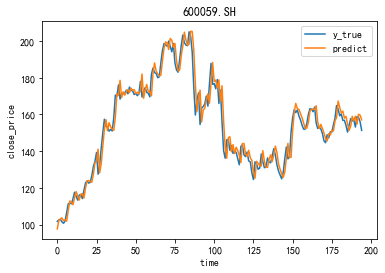

In [51]:
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras import models
from keras import layers
import sys
import keras
import matplotlib.pyplot as plt
from sklearn import preprocessing, metrics


dataset = pd.read_csv('./SH#600132.csv', encoding='gbk')
my_matrix = dataset.values
# my_matrix = my_matrix.astype('float32')
X, y = my_matrix[:-2, [1, 2, 3, 4, 7, 8]], my_matrix[1:-1, 4]
date = my_matrix[1:-1, 0]
X = X[:, [0, 1, 2, 3, 5]]

X_train = X[:int(0.8*len(X)), :]
X_predict = X[int(0.8*len(X)):, :]
y_train = np.array(y[:int(0.8*len(y))])
y_predict = np.array(y[int(0.8*len(y)):])
date = date[int(0.8*len(y)):]
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

model = Sequential()
model.add(Dense(64, input_shape=(X_train.shape[1],), activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam', metrics=['mae'])

mse = 50
i = 0
while mse > 33:
    history = model.fit(X_train, y_train, epochs=15, batch_size=4, validation_data=(X_test, y_test), verbose=2)
    predictions = model.predict(X_predict)

    print(metrics.mean_squared_error(y_predict, predictions))
    print(metrics.mean_absolute_error(y_predict, predictions))
    print(np.sqrt(metrics.mean_squared_error(y_predict, predictions)))  # RMSE
    mse = metrics.mean_squared_error(y_predict, predictions)
    print(i)
    i = i + 1

predictions = model.predict(X_predict)
date = date.reshape(195, 1)
output = np.array((date, predictions), dtype=object).T
output = np.reshape(output, (output.shape[1], 2))
print(output.shape)
print(date.shape)
print(predictions.shape)

output = pd.DataFrame(output, columns=['date', 'pre_y'])
output.to_csv('output2.csv')
print(output)

print("==========================")
plt.plot(y_predict, label='y_true')
plt.plot(predictions, label='predict')
plt.title('600059.SH', fontsize='12')
plt.ylabel('close_price', fontsize='10')
plt.xlabel('time', fontsize='10')
plt.legend()
plt.show()

## （七）总结
公司报告一直以来都是投资者获取上市公司经营财务状况等信息的主要来源，而在多因子选股或机器学习预测股票价格时，一般很少考虑到公告事件对股票价格的影响，当公告事件占股票价格波动主导因素时通常会有较差的表现。因此本次研究中利用自然语言处理技术，对上市公司临时公告进行文本挖掘，提取出其中与股票价格相关的特征，并利用神经网络构建模型，实现对公告事件发生后股票价格上涨概率的预测，预测结果可作为投资者选股的参考，也可作为因子参与基于历史交易数据的股价预测模型的训练，从而实现对市场信息的充分利用，提高模型预测精度、稳定性和泛化性。
本次研究引入了超额收益率概念，将不属于公告事件影响的市场收益率从实际收益率中剔除，大大提升了文本挖掘预测模型分类的准确率，以判断超额收益率是否为正作为目标也更接近于行业内获取市场超额收益的实际导向。本次研究构建的文本挖掘模型在实验中表现较好，可以作为选股依据。因此，利用自然语言处理和机器学习技术构建基于公司报告文本挖掘的股票价格辅助预测模型时可行的。

随着技术的不断发展，自然语言处理和深度学习技术在金融，尤其是股票市场的应用将会愈发广泛，不仅能给主观投资交易提供参考建议，还能凭借其处理速度上的优势对市场信息做出更快的响应，获取更高的收益。本文的工作证明了自然语言处理和深度学习的结合挖掘公告文本信息的可行性，人工分析上市公司公告不仅需要花费大量的时间，还对人员的专业知识和经济嗅觉有很高的要求，而机器仅需几秒钟就能完成对一篇公告的阅读，并能预测这篇公告对股价的影响，足以证明其优越性。未来，机器和人工的结合或许会成为行业的主流模式。

受限于时间、硬件以及本人目前能力等因素，本次研究还存在很多可以提升改进的地方：

* (1)目前对公告文本的挖掘局限在临时公告，下一步可以尝试挖掘定期报告这类长文本中的信息，对其影响进行分析判断。
* (2)本次研究中公告所选取的范围仅为酿酒企业，未来可以拓展到全部上市公司，股票价格预测模型也可以推广到所有股票。
* (3)本次研究采用的Word2Vec生成词向量，之后的研究中可以采用最新的预训练模型如BERT、XLNet模型来完成自然语言处理过程，提高从文本中提取特征的能力。
* (4)没有针对模型预测结果提供相应的交易策略，在下一步的工作中可以将模型和相应的交易策略结合起来，形成集数据生成、模型训练、预测回测于一体的模型选股系统或平台，验证在实际市场交易中的可靠性。
* (5)没有对报告文本按性质分类，不同类型的公告对公司的影响程度不同，市场对公告的反应时间、程度也存在差异，在之后的工作中可以尝试研究不同类型公告的影响，提高预测准确率。
* (6)本次研究没有考虑到公司在同一交易日发布多条公告是否会造成连锁反应，正面公告和负面公告的发布先后、严重程度、占比等都会对市场造成影响，在未来研究工作中会将这些信息运用到模型训练中。